# Emergency Department Environment

In [36]:
import simpy
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import copy
import scienceplots
import sympy as sp

plt.style.use(['science'])

In [4]:
class Project:
    def __init__(self, name, time_distribution, staff_needed, **kwargs):
        self.name = name
        self.time_distribution = time_distribution
        self.staff_needed = staff_needed  # 该项目需要的工作人员数量
        if time_distribution == "uniform":
            self.min_time = kwargs.get('min_time', 0)
            self.max_time = kwargs.get('max_time', 0)
        elif time_distribution == "triangular":
            self.min_time = kwargs.get('min_time', 0)
            self.mode_time = kwargs.get('mode_time', 0)
            self.max_time = kwargs.get('max_time', 0)
    
    def get_time(self):
        if self.time_distribution == "uniform":
            return random.randint(self.min_time, self.max_time)
        elif self.time_distribution == "triangular":
            return int(np.random.triangular(self.min_time, self.mode_time, self.max_time))

In [5]:
class Staff:
    def __init__(self):
        self.staff_dict = {}  # 存储各种类型的工作人员和其数量
        self.staff_prices = {}  # 存储各种类型的工作人员和其价格

    def add_staff(self, staff_type, quantity, price):
        self.staff_dict[staff_type] = quantity
        self.staff_prices[staff_type] = price

    def assign_staff(self, staff_type, quantity):
        self.staff_dict[staff_type] -= quantity

    def release_staff(self, staff_type, quantity):
        self.staff_dict[staff_type] += quantity


In [6]:
class Patient:
    def __init__(self, env, name, projects, project_probabilities):
        self.env = env
        self.name = name
        self.all_projects = projects
        self.project_probabilities = project_probabilities
        
        self.current_project = None
        self.current_project_start_time = 0
        self.current_project_end_time = 0
        self.current_project_time = 0
        
        self.in_project = False
        self.is_waiting = False
        
        self.waiting_time = 0
        self.emergency_room_waiting_time = 0
        self.total_time = 0  # 记录总共花费的时间
        
        self.start_times = {}  # 记录每个项目的开始时间
        self.end_times = {}    # 记录每个项目的结束时间
        self.project_times = {}  # 记录每个项目使用的时间

        self.completed_projects = []  # 记录完成的项目

    def execute_project(self, project):
        self.in_project = True
        self.current_project_start_time = self.env.now
        self.start_times[self.current_project.name] = self.current_project_start_time  # 记录项目开始时间
        project_time = self.current_project.get_time()
        self.current_project_time = project_time
        # end_time = self.env.now
        # self.end_times[self.current_project.name] = end_time  # 记录项目结束时间
        self.project_times[self.current_project.name] = project_time  # 记录项目使用的时间
        self.total_time += project_time  # 更新总共花费的时间
        self.completed_projects.append(project)  # 记录完成的项目
        
    def check_finish(self):
        if self.env.now - self.current_project_start_time > self.current_project_time:
            self.in_project = False
            self.current_project_end_time = self.env.now
            if  self.current_project != None:
                self.end_times[self.current_project.name] = self.current_project_end_time

    def choose_next_project(self):
        current_project_name = self.current_project.name if self.current_project else None
        next_project_probabilities = self.project_probabilities.get(current_project_name, self.project_probabilities["default"])
        projects = list(next_project_probabilities.keys())
        probabilities = list(next_project_probabilities.values())
        # print(projects,probabilities)
        chosen_project = random.choices(projects, probabilities)[0]
        chosen_project = [project for project in self.all_projects if project.name == chosen_project][0]
        self.current_project = chosen_project
        return chosen_project


In [7]:
class EmergencyDepartment:
    def __init__(self, env, staff, projects, project_probabilities, arrival_time):
        self.env = env
        self.staff = staff
        self.projects = projects
        self.project_probabilities = project_probabilities
        self.patients = []
        self.discharged_patient = []
        self.arrival_time = arrival_time

    def admit_patient(self, patient):
        self.patients.append(patient)
        
    def process_patient(self, patients):
        while True:
            if self.env.now in self.arrival_time:
                self.admit_patient(Patient(self.env, len(self.patients)+1, self.projects, self.project_probabilities))
            for patient in patients:
                if patient in self.discharged_patient:
                    continue  # 跳过已经出院的患者
                
                if patient.current_project != None:
                    if patient.current_project.name == "Discharge":
                        self.discharged_patient.append(patient)
                        continue

                if not patient.in_project and not patient.is_waiting:  # 如果当前没有项目，则选择下一个项目
                    project = patient.choose_next_project()
                    if self.can_start_project(project):
                        self.assign_staff(project)
                        patient.execute_project(project)
                    else:
                        patient.waiting_time += 1
                        patient.is_waiting = True 
                        if patient.current_project.name == "Emergency room":
                            patient.emergency_room_waiting_time += 1
                    continue
                
                if not patient.in_project and patient.is_waiting:  # 如果当前没有项目，则选择下一个项目
                    project = patient.current_project
                    
                    if self.can_start_project(project):
                        self.assign_staff(project)
                        patient.execute_project(project)
                        patient.is_waiting = False
                    else:
                        patient.waiting_time += 1
                        if patient.current_project.name == "Emergency room":
                            patient.emergency_room_waiting_time += 1
                    continue
                
                patient.check_finish()
                if not patient.in_project:
                    project = patient.completed_projects[-1]
                    self.release_staff(project)
                    
            yield self.env.timeout(1)  # 继续等待1个单位时间
            
    def can_start_project(self, project):
        staff_needed = project.staff_needed
        project_name = project.name
        if project_name in self.staff.staff_dict:
            available_staff = self.staff.staff_dict[project_name]
            return staff_needed <= available_staff
        else:
            return False

    def assign_staff(self, project):
        staff_needed = project.staff_needed
        project_name = project.name
        if project_name in ["Examination room", "Reexamination process"]:
            self.staff.assign_staff("Examination room", staff_needed)
            self.staff.assign_staff("Reexamination process", staff_needed)
        # elif project_name =="Emergency room":
        #     if self.staff.staff_dict[project_name] < staff_needed:
        #         self.staff.assign_staff("Examination room", staff_needed)
        #         self.staff.assign_staff("Reexamination process", staff_needed) 
        #     else:
        #         self.staff.assign_staff(project_name, staff_needed)
        else:
            self.staff.assign_staff(project_name, staff_needed)

    def release_staff(self, project):
        staff_needed = project.staff_needed
        project_name = project.name
        if project_name in ["Examination room", "Reexamination process"]:
            self.staff.release_staff("Examination room", staff_needed)
            self.staff.release_staff("Reexamination process", staff_needed)
        # elif project_name == "Emergency room":
        #     if self.staff.staff_dict[project_name] < staff_needed:
        #         self.staff.release_staff("Examination room", staff_needed)
        #         self.staff.release_staff("Reexamination process", staff_needed) 
        #     else:
        #         self.staff.release_staff(project_name, staff_needed)
        else:
            self.staff.release_staff(project_name, staff_needed)


In [8]:
def calculate_average_waiting_time(waiting_times):
    if waiting_times:
        return sum(waiting_times) / len(waiting_times)
    else:
        return 0
    
def arrival_times(arrival_rates: list):
    hour = range(len(arrival_rates))
    arr_time = []
    for h in hour:
        for _ in range(round(arrival_rates[h])):
            arr_time.append(random.randint(h*60, (h+1)*60)) # Non-homogenous Poisson process
        # for t in np.linspace(h*60,(h+1)*60,int(round(arrival_rates[h]))+1):
        #     arr_time.append(round(t))
        # arr_time = arr_time[:-1]
    return arr_time

def calculate_discharge_per_hour(emergency_department):
    discharge_count_per_hour = {}
    for hour in range(24):  # 遍历24小时
        discharge_count_per_hour[hour] = 0  # 初始化每小时的出院人数为0
    for patient in emergency_department.patients:
        completed_projects = patient.completed_projects
        if completed_projects and completed_projects[-1].name == "Discharge":  # 检查是否有完成的项目，并且最后一个项目是"Discharge"
            discharge_time = patient.start_times.get("Discharge", -1)  # 获取"Discharge"项目的开始时间
            if discharge_time != -1:  # 如果有"Discharge"项目
                hour = discharge_time // 60  # 计算"Discharge"项目开始的小时
                discharge_count_per_hour[hour] += 1  # 对应小时的出院人数加1
    return discharge_count_per_hour



## Test

In [9]:
env = simpy.Environment()

# 定义病人每小时到达率
arrival_rates = [5.33, 5.33, 3.82, 3.82, 3.06, 3.06, 4.54, 4.54, 6.81, 6.84, 8.32, 8.32, 
                    9.01, 9.01, 8.36, 7.5, 8.32, 7.5, 8.32, 8.32, 7.5, 5.33, 3.82, 2.3]
# arrival_rates = [i*10 for i in arrival_rates]
arrival_time = arrival_times(arrival_rates)

# 创建不同项目
projects = [
    Project("default", "uniform", staff_needed=0, min_time=0, max_time=0),
    Project("Reception", "uniform", staff_needed=1, min_time=5, max_time=10),
    Project("Examination room", "uniform", staff_needed=1, min_time=10, max_time=20),
    Project("Lab tests", "triangular", staff_needed=1, min_time=10, mode_time=20, max_time=30),
    Project("Reexamination process", "uniform", staff_needed=1, min_time=7, max_time=12),
    Project("Treatment room", "uniform", staff_needed=1, min_time=20, max_time=30),
    Project("Emergency room", "uniform", staff_needed=3, min_time=60, max_time=120),
    Project("Discharge", "uniform", staff_needed=0, min_time=0, max_time=0)  # 出院项目
]

# 创建工作人员
staff = Staff()
staff.add_staff("default", 0, 0)
staff.add_staff("Reception", 1, 0.4)
staff.add_staff("Lab tests", 2, 0.5)
staff.add_staff("Examination room", 3, 1.2)
staff.add_staff("Reexamination process", 3, 1.2)
staff.add_staff("Treatment room", 2, 0.3)
staff.add_staff("Emergency room", 7, 0.3)
staff.add_staff("Discharge", 0, 0)

project_probabilities = {
    "default": {"Reception": 1.0, "Lab tests": 0.0, "Examination room": 0.0,
                "Reexamination process": 0.0, "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
    "Reception": {"Examination room": 1.0, "Lab tests": 0.0, "Reexamination process": 0.0,
                "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
    "Examination room": {"Treatment room": 0.2, "Lab tests": 0.5, "Discharge": 0.05, "Emergency room": 0.25,
                        "Reception": 0.0, "Reexamination process": 0.0},
    "Lab tests": {"Reexamination process": 1.0, "Reception": 0.0, "Examination room": 0.0,
                "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
    "Reexamination process": {"Treatment room": 0.4, "Discharge": 0.1, "Emergency room": 0.5,
                            "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0},
    "Treatment room": {"Discharge": 1.0, "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
                        "Reexamination process": 0.0, "Emergency room": 0.0},
    "Emergency room": {"Discharge": 1.0, "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
                        "Reexamination process": 0.0, "Treatment room": 0.0},
    "Discharge": {"Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
                "Reexamination process": 0.0, "Treatment room": 0.0, "Emergency room": 0.0}
}

emergency_department = EmergencyDepartment(env, staff, projects, project_probabilities, arrival_time)
env.process(emergency_department.process_patient(emergency_department.patients))
env.run(until=1440)  # 模拟24小时
for patient in emergency_department.patients:
    print(f"Patient: {patient.name}")
    print(f"Project: {[project.name for project in patient.completed_projects]}")
    for project in projects[1:]:
        start_time = patient.start_times.get(project.name, "Not Started")
        end_time = patient.end_times.get(project.name, "Not Finished")
        project_time = patient.project_times.get(project.name, 0)
        print(f"Project: {project.name}, Start Time: {start_time}, End Time: {end_time}, Project Time: {project_time}")
    print(f"Total Time Spent: {patient.total_time}")
    print(f"Total Waiting Time: {patient.waiting_time}")
    print(f"Emergency Room Waiting Time: {patient.emergency_room_waiting_time}")
    print("\n")
waiting_times_C1 = [patient.emergency_room_waiting_time for patient in emergency_department.patients if any(project.name == "Emergency room" for project in patient.completed_projects)]
average_waiting_time_C1 = calculate_average_waiting_time(waiting_times_C1)
print(f"C1病人的等待时间的平均值为: {average_waiting_time_C1:.2f} 分钟")

Patient: 1
Project: ['Reception', 'Examination room', 'Lab tests', 'Reexamination process', 'Emergency room', 'Discharge']
Project: Reception, Start Time: 14, End Time: 20, Project Time: 5
Project: Examination room, Start Time: 21, End Time: 39, Project Time: 17
Project: Lab tests, Start Time: 40, End Time: 60, Project Time: 19
Project: Reexamination process, Start Time: 61, End Time: 69, Project Time: 7
Project: Treatment room, Start Time: Not Started, End Time: Not Finished, Project Time: 0
Project: Emergency room, Start Time: 70, End Time: 179, Project Time: 108
Project: Discharge, Start Time: 180, End Time: Not Finished, Project Time: 0
Total Time Spent: 156
Total Waiting Time: 0
Emergency Room Waiting Time: 0


Patient: 2
Project: ['Reception', 'Examination room', 'Lab tests', 'Reexamination process', 'Treatment room', 'Discharge']
Project: Reception, Start Time: 28, End Time: 39, Project Time: 10
Project: Examination room, Start Time: 40, End Time: 54, Project Time: 13
Project: L

In [10]:
# 调用函数并打印每个小时的出院人数
discharge_per_hour = calculate_discharge_per_hour(emergency_department)
list(discharge_per_hour.values()), sum(list(discharge_per_hour.values()))

([0, 2, 3, 4, 4, 0, 5, 4, 3, 4, 6, 4, 4, 3, 4, 6, 5, 5, 7, 5, 6, 4, 5, 5], 98)

# To satisfy constraint (2) and constraint (4)
Constraint (2): $f_1(x_1,x_2,x_3,x_4,x_5) \leq B$  
Constraint (4): $1 \leq x_i \leq x_{i_{max}}, \forall i \in \{1,2,3,4,5\}$

In [11]:
def backtrack(x, cost, budget, x_max, x_cost, results): #回溯算法计算解的可行域
    if len(x) == len(x_max):
        if cost <= budget:
            results.append(x.copy())
        return

    for i in range(1, x_max[len(x)] + 1):
        new_cost = cost + i * x_cost[len(x)]
        if new_cost <= budget:
            x.append(i)
            backtrack(x, new_cost, budget, x_max, x_cost, results)
            x.pop()

def find_combinations(budget, x_max, x_cost):
    results = []
    backtrack([], 0, budget, x_max, x_cost, results)
    return results

budget = 7.7
x_max = [3, 4, 5, 6, 12]
x_cost = [0.4, 1.2, 0.5, 0.3, 0.3]

available_set = find_combinations(budget, x_max, x_cost)
print("All staff configurations:")
for configuration in available_set:
    print(configuration)
len(available_set)

All staff configurations:
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 2]
[1, 1, 1, 1, 3]
[1, 1, 1, 1, 4]
[1, 1, 1, 1, 5]
[1, 1, 1, 1, 6]
[1, 1, 1, 1, 7]
[1, 1, 1, 1, 8]
[1, 1, 1, 1, 9]
[1, 1, 1, 1, 10]
[1, 1, 1, 1, 11]
[1, 1, 1, 1, 12]
[1, 1, 1, 2, 1]
[1, 1, 1, 2, 2]
[1, 1, 1, 2, 3]
[1, 1, 1, 2, 4]
[1, 1, 1, 2, 5]
[1, 1, 1, 2, 6]
[1, 1, 1, 2, 7]
[1, 1, 1, 2, 8]
[1, 1, 1, 2, 9]
[1, 1, 1, 2, 10]
[1, 1, 1, 2, 11]
[1, 1, 1, 2, 12]
[1, 1, 1, 3, 1]
[1, 1, 1, 3, 2]
[1, 1, 1, 3, 3]
[1, 1, 1, 3, 4]
[1, 1, 1, 3, 5]
[1, 1, 1, 3, 6]
[1, 1, 1, 3, 7]
[1, 1, 1, 3, 8]
[1, 1, 1, 3, 9]
[1, 1, 1, 3, 10]
[1, 1, 1, 3, 11]
[1, 1, 1, 3, 12]
[1, 1, 1, 4, 1]
[1, 1, 1, 4, 2]
[1, 1, 1, 4, 3]
[1, 1, 1, 4, 4]
[1, 1, 1, 4, 5]
[1, 1, 1, 4, 6]
[1, 1, 1, 4, 7]
[1, 1, 1, 4, 8]
[1, 1, 1, 4, 9]
[1, 1, 1, 4, 10]
[1, 1, 1, 4, 11]
[1, 1, 1, 4, 12]
[1, 1, 1, 5, 1]
[1, 1, 1, 5, 2]
[1, 1, 1, 5, 3]
[1, 1, 1, 5, 4]
[1, 1, 1, 5, 5]
[1, 1, 1, 5, 6]
[1, 1, 1, 5, 7]
[1, 1, 1, 5, 8]
[1, 1, 1, 5, 9]
[1, 1, 1, 5, 10]
[1, 1, 1, 5, 11]
[1, 1, 1, 5, 12]

1704

# To satisfy constraint (3)
Constraint (3): $f_2(x_1,x_2,x_3,x_4,x_5) \leq Q_1$

In [12]:
# 计算时间太长

# def threshold(c, r, v, w, z):
#     return max(0, (w*z)/2*c*v - (v*r)/(2*c))

# def sample_variance(data:list):
#     n = len(data)
#     if n <= 1:
#         raise ValueError("样本容量必须大于1")
#     mean = sum(data) / n
#     return sum((x - mean) ** 2 for x in data) / (n - 1)

# def feasiblility_check(data:list, threshold, q):
#     data = [d-q for d in data]
#     if sum(data) <=  -threshold:
#         return 1
#     elif sum(data) >=  threshold:
#         return 2
#     else:
#         return 0
    
# def get_average_waiting_time(sample_time, staff_configurattion:list):
#     average_waiting_time = []
#     arrival_rates = [5.33, 5.33, 3.82, 3.82, 3.06, 3.06, 4.54, 4.54, 6.81, 6.84, 8.32, 8.32, 
#                             9.01, 9.01, 8.36, 7.5, 8.32, 7.5, 8.32, 8.32, 7.5, 5.33, 3.82, 2.3]
#     arrival_time = arrival_times(arrival_rates)
#     for _ in range(sample_time):
#         env = simpy.Environment()
#         projects = [
#             Project("default", "uniform", staff_needed=0, min_time=0, max_time=0),
#             Project("Reception", "uniform", staff_needed=1, min_time=5, max_time=10),
#             Project("Examination room", "uniform", staff_needed=1, min_time=10, max_time=20),
#             Project("Lab tests", "triangular", staff_needed=1, min_time=10, mode_time=20, max_time=30),
#             Project("Reexamination process", "uniform", staff_needed=1, min_time=7, max_time=12),
#             Project("Treatment room", "uniform", staff_needed=1, min_time=20, max_time=30),
#             Project("Emergency room", "uniform", staff_needed=3, min_time=60, max_time=120),
#             Project("Discharge", "uniform", staff_needed=0, min_time=0, max_time=0)  # 出院项目
#         ]
        
#         staff = Staff()
#         staff.add_staff("default", 0, 0)
#         staff.add_staff("Reception", staff_configurattion[0], 0.4)
#         staff.add_staff("Lab tests", staff_configurattion[2], 0.5)
#         staff.add_staff("Examination room", staff_configurattion[1], 1.2)
#         staff.add_staff("Reexamination process", staff_configurattion[1], 1.2)
#         staff.add_staff("Treatment room", staff_configurattion[3], 0.3)
#         staff.add_staff("Emergency room", staff_configurattion[4], 0.3)
#         staff.add_staff("Discharge", 0, 0)
        
#         project_probabilities = {
#             "default": {"Reception": 1.0, "Lab tests": 0.0, "Examination room": 0.0,
#                         "Reexamination process": 0.0, "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
#             "Reception": {"Examination room": 1.0, "Lab tests": 0.0, "Reexamination process": 0.0,
#                         "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
#             "Examination room": {"Treatment room": 0.2, "Lab tests": 0.5, "Discharge": 0.05, "Emergency room": 0.25,
#                                 "Reception": 0.0, "Reexamination process": 0.0},
#             "Lab tests": {"Reexamination process": 1.0, "Reception": 0.0, "Examination room": 0.0,
#                         "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
#             "Reexamination process": {"Treatment room": 0.4, "Discharge": 0.1, "Emergency room": 0.5,
#                                     "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0},
#             "Treatment room": {"Discharge": 1.0, "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
#                                 "Reexamination process": 0.0, "Emergency room": 0.0},
#             "Emergency room": {"Discharge": 1.0, "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
#                                 "Reexamination process": 0.0, "Treatment room": 0.0},
#             "Discharge": {"Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
#                         "Reexamination process": 0.0, "Treatment room": 0.0, "Emergency room": 0.0}
#         }
        
#         emergency_department = EmergencyDepartment(env, staff, projects, project_probabilities, arrival_time)
#         env.process(emergency_department.process_patient(emergency_department.patients))
#         env.run(until=1440)
#         waiting_times_C1 = [patient.emergency_room_waiting_time for patient in emergency_department.patients if any(project.name == "Emergency room" for project in patient.completed_projects)]
#         average_waiting_time_C1 = calculate_average_waiting_time(waiting_times_C1)
#         average_waiting_time.append(average_waiting_time_C1)
#     return average_waiting_time

In [13]:
# L = []

# Q1L = 60
# Q1R = 80
# c = 1 # 常量
# r = 10 # 初始模拟的次数
# v = (Q1R - Q1L) / 2 # 偏差
# mu = 9.89
# w = 2 * mu * c * 9
# z = 0 # 样本方差
# q = (Q1L + Q1R) / 2

# for configuration in available_set[:10]:
#     average_waiting_time = get_average_waiting_time(100, configuration)
#     z = sample_variance(average_waiting_time)
#     while feasiblility_check(average_waiting_time, threshold(c, r, v, w, z), q) == 0:
#         average_waiting_time.append(random.choice(average_waiting_time))
#         r += 1
#         print(r)
#     if feasiblility_check(average_waiting_time, threshold(c, r, v, w, z), q) == 1:
#         L.append(configuration)

In [17]:
def get_average_waiting_time(arrival_rates_multiple_times, sample_time, staff_configurattion:list):
    average_waiting_time = []
    arrival_rates = [5.33, 5.33, 3.82, 3.82, 3.06, 3.06, 4.54, 4.54, 6.81, 6.84, 8.32, 8.32, 
                            9.01, 9.01, 8.36, 7.5, 8.32, 7.5, 8.32, 8.32, 7.5, 5.33, 3.82, 2.3]
    arrival_rates = [arrival_rates_multiple_times*i for i in arrival_rates]
    arrival_time = arrival_times(arrival_rates)
    for _ in range(sample_time):
        env = simpy.Environment()
        projects = [
            Project("default", "uniform", staff_needed=0, min_time=0, max_time=0),
            Project("Reception", "uniform", staff_needed=1, min_time=5, max_time=10),
            Project("Examination room", "uniform", staff_needed=1, min_time=10, max_time=20),
            Project("Lab tests", "triangular", staff_needed=1, min_time=10, mode_time=20, max_time=30),
            Project("Reexamination process", "uniform", staff_needed=1, min_time=7, max_time=12),
            Project("Treatment room", "uniform", staff_needed=1, min_time=20, max_time=30),
            Project("Emergency room", "uniform", staff_needed=1, min_time=60, max_time=120),
            Project("Discharge", "uniform", staff_needed=0, min_time=0, max_time=0)  # 出院项目
        ]
        
        staff = Staff()
        staff.add_staff("default", 0, 0)
        staff.add_staff("Reception", staff_configurattion[0], 0.4)
        staff.add_staff("Lab tests", staff_configurattion[2], 0.5)
        staff.add_staff("Examination room", staff_configurattion[1], 1.2)
        staff.add_staff("Reexamination process", staff_configurattion[1], 1.2)
        staff.add_staff("Treatment room", staff_configurattion[3], 0.3)
        staff.add_staff("Emergency room", staff_configurattion[4], 0.3)
        staff.add_staff("Discharge", 0, 0)
        
        project_probabilities = {
            "default": {"Reception": 1.0, "Lab tests": 0.0, "Examination room": 0.0,
                        "Reexamination process": 0.0, "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
            "Reception": {"Examination room": 1.0, "Lab tests": 0.0, "Reexamination process": 0.0,
                        "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
            "Examination room": {"Treatment room": 0.2, "Lab tests": 0.5, "Discharge": 0.05, "Emergency room": 0.25,
                                "Reception": 0.0, "Reexamination process": 0.0},
            "Lab tests": {"Reexamination process": 1.0, "Reception": 0.0, "Examination room": 0.0,
                        "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
            "Reexamination process": {"Treatment room": 0.4, "Discharge": 0.1, "Emergency room": 0.5,
                                    "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0},
            "Treatment room": {"Discharge": 1.0, "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
                                "Reexamination process": 0.0, "Emergency room": 0.0},
            "Emergency room": {"Discharge": 1.0, "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
                                "Reexamination process": 0.0, "Treatment room": 0.0},
            "Discharge": {"Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
                        "Reexamination process": 0.0, "Treatment room": 0.0, "Emergency room": 0.0}
        }
        
        emergency_department = EmergencyDepartment(env, staff, projects, project_probabilities, arrival_time)
        env.process(emergency_department.process_patient(emergency_department.patients))
        env.run(until=1440)
        waiting_times_C1 = [patient.emergency_room_waiting_time for patient in emergency_department.patients if any(project.name == "Emergency room" for project in patient.completed_projects)]
        average_waiting_time_C1 = calculate_average_waiting_time(waiting_times_C1)
        average_waiting_time.append(average_waiting_time_C1)
    return average_waiting_time

## When the arrival rate is $\lambda(t)$

In [15]:
# 每个工作人员组合做10次模拟，记录每1次的平均等待时间，取其中10个平均值的最大值，不能超过180分钟
F_1AR = []

for configuration in available_set:
    average_waiting_time = get_average_waiting_time(1, 10, configuration)
    if max(average_waiting_time) <= 180: # Waiting time should be smaller than 180 minites
        F_1AR.append(configuration)
        
len(F_1AR)

1224

## When the arrival rate is $0.65\lambda(t)$

In [18]:
F_065AR = []

for configuration in available_set:
    average_waiting_time = get_average_waiting_time(0.65, 10, configuration)
    if max(average_waiting_time) <= 180: # Waiting time should be smaller than 180 minites
        F_065AR.append(configuration)
        
len(F_065AR)

1309

## When the arrival rate is $1.3\lambda(t)$

In [19]:
F_13AR = []

for configuration in available_set:
    average_waiting_time = get_average_waiting_time(1.3, 10, configuration)
    if max(average_waiting_time) <= 180: # Waiting time should be smaller than 180 minites
        F_13AR.append(configuration)
        
len(F_13AR)

1170

# Optimization algorithm

In [23]:
def get_discharge_number(arrival_rates_multiple_times, staff_configurattion:list):
    arrival_rates = [5.33, 5.33, 3.82, 3.82, 3.06, 3.06, 4.54, 4.54, 6.81, 6.84, 8.32, 8.32, 
                            9.01, 9.01, 8.36, 7.5, 8.32, 7.5, 8.32, 8.32, 7.5, 5.33, 3.82, 2.3]
    arrival_rates = [arrival_rates_multiple_times * i for i in arrival_rates]
    arrival_time = arrival_times(arrival_rates)
    
    env = simpy.Environment()
    
    projects = [
            Project("default", "uniform", staff_needed=0, min_time=0, max_time=0),
            Project("Reception", "uniform", staff_needed=1, min_time=5, max_time=10),
            Project("Examination room", "uniform", staff_needed=1, min_time=10, max_time=20),
            Project("Lab tests", "triangular", staff_needed=1, min_time=10, mode_time=20, max_time=30),
            Project("Reexamination process", "uniform", staff_needed=1, min_time=7, max_time=12),
            Project("Treatment room", "uniform", staff_needed=1, min_time=20, max_time=30),
            Project("Emergency room", "uniform", staff_needed=1, min_time=60, max_time=120),
            Project("Discharge", "uniform", staff_needed=0, min_time=0, max_time=0)  # 出院项目
        ]
    
    staff = Staff()
    staff.add_staff("default", 0, 0)
    staff.add_staff("Reception", staff_configurattion[0], 0.4)
    staff.add_staff("Lab tests", staff_configurattion[2], 0.5)
    staff.add_staff("Examination room", staff_configurattion[1], 1.2)
    staff.add_staff("Reexamination process", staff_configurattion[1], 1.2)
    staff.add_staff("Treatment room", staff_configurattion[3], 0.3)
    staff.add_staff("Emergency room", staff_configurattion[4], 0.3)
    staff.add_staff("Discharge", 0, 0)
    
    project_probabilities = {
        "default": {"Reception": 1.0, "Lab tests": 0.0, "Examination room": 0.0,
                    "Reexamination process": 0.0, "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
        "Reception": {"Examination room": 1.0, "Lab tests": 0.0, "Reexamination process": 0.0,
                    "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
        "Examination room": {"Treatment room": 0.2, "Lab tests": 0.5, "Discharge": 0.05, "Emergency room": 0.25,
                            "Reception": 0.0, "Reexamination process": 0.0},
        "Lab tests": {"Reexamination process": 1.0, "Reception": 0.0, "Examination room": 0.0,
                    "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
        "Reexamination process": {"Treatment room": 0.4, "Discharge": 0.1, "Emergency room": 0.5,
                                "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0},
        "Treatment room": {"Discharge": 1.0, "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
                            "Reexamination process": 0.0, "Emergency room": 0.0},
        "Emergency room": {"Discharge": 1.0, "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
                            "Reexamination process": 0.0, "Treatment room": 0.0},
        "Discharge": {"Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
                    "Reexamination process": 0.0, "Treatment room": 0.0, "Emergency room": 0.0}
    }
    
    emergency_department = EmergencyDepartment(env, staff, projects, project_probabilities, arrival_time)
    
    env.process(emergency_department.process_patient(emergency_department.patients))
    env.run(until=1440)
    
    discharge_count_per_hour = {}
    for hour in range(24):  # 遍历24小时
        discharge_count_per_hour[hour] = 0  # 初始化每小时的出院人数为0
    for patient in emergency_department.patients:
        completed_projects = patient.completed_projects
        if completed_projects and completed_projects[-1].name == "Discharge":  # 检查是否有完成的项目，并且最后一个项目是"Discharge"
            discharge_time = patient.start_times.get("Discharge", -1)  # 获取"Discharge"项目的开始时间
            if discharge_time != -1:  # 如果有"Discharge"项目
                hour = discharge_time // 60  # 计算"Discharge"项目开始的小时
                discharge_count_per_hour[hour] += 1  # 对应小时的出院人数加1
    return sum(list(discharge_count_per_hour.values()))

def find_optimal_configuration(bound, feasible_set, arrival_rates_multiple_times):
    FF = copy.deepcopy(feasible_set)
    i = random.choice(FF)
    FF.remove(i)
    
    T_total = []
    
    configuration_pair = []
    X = []
    T = []
    current_configuration = i

    for _ in tqdm(range(len(FF) - 1)):
        j = random.choice(FF)
        FF.remove(j)
        configuration_pair.append((current_configuration, j))
        while sum(X) > -bound and sum(X) < bound:
            discharge_number_current_configuration = get_discharge_number(arrival_rates_multiple_times, current_configuration)
            discharge_number_j = get_discharge_number(arrival_rates_multiple_times, j)
            if discharge_number_current_configuration < discharge_number_j:
                X.append(1)
            elif discharge_number_current_configuration > discharge_number_j:
                X.append(-1)
            else:
                X.append(0)
            T.append(sum(X))
        T_total.append(T)
        print(T)
        if sum(X) >= bound:
            current_configuration = j
        T = []
        X = []
        
    optimal_configuration = current_configuration 
    
    return optimal_configuration, configuration_pair, T_total

## When the arrival rate is $\lambda(t)$

In [21]:
optimal_configuration_1AR, configuration_pair_1AR, T_total_1AR = find_optimal_configuration(3, F_1AR, 1)


  0%|          | 1/1222 [00:01<26:07,  1.28s/it]

[-1, -2, -1, -1, -1, 0, 0, -1, 0, 1, 2, 3]


  0%|          | 2/1222 [00:01<14:27,  1.41it/s]

[1, 2, 3]


  0%|          | 3/1222 [00:01<10:50,  1.87it/s]

[-1, -2, -3]


  0%|          | 4/1222 [00:02<09:01,  2.25it/s]

[-1, -2, -3]


  0%|          | 5/1222 [00:02<08:01,  2.53it/s]

[-1, -2, -3]


  0%|          | 6/1222 [00:02<07:29,  2.70it/s]

[-1, -2, -3]


  1%|          | 7/1222 [00:03<07:06,  2.85it/s]

[-1, -2, -3]


  1%|          | 8/1222 [00:03<06:51,  2.95it/s]

[-1, -2, -3]


  1%|          | 9/1222 [00:03<06:37,  3.05it/s]

[-1, -2, -3]


  1%|          | 10/1222 [00:04<06:33,  3.08it/s]

[-1, -2, -3]


  1%|          | 11/1222 [00:05<10:24,  1.94it/s]

[1, 2, 1, 0, -1, -2, -1, -2, -3]


  1%|          | 12/1222 [00:05<09:14,  2.18it/s]

[-1, -2, -3]


  1%|          | 13/1222 [00:05<08:22,  2.41it/s]

[1, 2, 3]


  1%|          | 14/1222 [00:05<07:41,  2.62it/s]

[-1, -2, -3]


  1%|          | 15/1222 [00:06<07:14,  2.78it/s]

[-1, -2, -3]


  1%|▏         | 16/1222 [00:06<06:56,  2.89it/s]

[-1, -2, -3]


  1%|▏         | 17/1222 [00:06<06:43,  2.99it/s]

[-1, -2, -3]


  1%|▏         | 18/1222 [00:07<06:32,  3.07it/s]

[-1, -2, -3]


  2%|▏         | 19/1222 [00:07<06:26,  3.11it/s]

[-1, -2, -3]


  2%|▏         | 20/1222 [00:07<06:22,  3.14it/s]

[-1, -2, -3]


  2%|▏         | 21/1222 [00:08<06:16,  3.19it/s]

[-1, -2, -3]


  2%|▏         | 22/1222 [00:08<06:12,  3.22it/s]

[-1, -2, -3]


  2%|▏         | 23/1222 [00:08<06:06,  3.27it/s]

[-1, -2, -3]


  2%|▏         | 24/1222 [00:09<06:06,  3.27it/s]

[-1, -2, -3]


  2%|▏         | 25/1222 [00:09<06:42,  2.98it/s]

[-1, -2, -2, -3]


  2%|▏         | 26/1222 [00:09<06:30,  3.07it/s]

[-1, -2, -3]


  2%|▏         | 27/1222 [00:10<06:26,  3.09it/s]

[-1, -2, -3]


  2%|▏         | 28/1222 [00:10<06:19,  3.15it/s]

[-1, -2, -3]


  2%|▏         | 29/1222 [00:10<06:16,  3.17it/s]

[-1, -2, -3]


  2%|▏         | 30/1222 [00:11<06:20,  3.13it/s]

[-1, -2, -3]


  3%|▎         | 31/1222 [00:11<06:18,  3.15it/s]

[-1, -2, -3]


  3%|▎         | 32/1222 [00:11<06:14,  3.18it/s]

[-1, -2, -3]


  3%|▎         | 33/1222 [00:12<07:27,  2.66it/s]

[-1, -2, -1, -2, -3]


  3%|▎         | 34/1222 [00:12<07:12,  2.75it/s]

[1, 2, 3]


  3%|▎         | 35/1222 [00:13<08:13,  2.40it/s]

[-1, 0, -1, -2, -3]


  3%|▎         | 36/1222 [00:13<07:38,  2.59it/s]

[-1, -2, -3]


  3%|▎         | 37/1222 [00:13<07:13,  2.73it/s]

[-1, -2, -3]


  3%|▎         | 38/1222 [00:14<06:57,  2.83it/s]

[-1, -2, -3]


  3%|▎         | 39/1222 [00:14<06:43,  2.93it/s]

[-1, -2, -3]


  3%|▎         | 40/1222 [00:14<06:31,  3.02it/s]

[-1, -2, -3]


  3%|▎         | 41/1222 [00:14<06:23,  3.08it/s]

[-1, -2, -3]


  3%|▎         | 42/1222 [00:15<06:17,  3.12it/s]

[-1, -2, -3]


  4%|▎         | 43/1222 [00:15<06:15,  3.14it/s]

[-1, -2, -3]


  4%|▎         | 44/1222 [00:15<06:14,  3.15it/s]

[-1, -2, -3]


  4%|▎         | 45/1222 [00:16<06:10,  3.17it/s]

[-1, -2, -3]


  4%|▍         | 46/1222 [00:16<06:10,  3.17it/s]

[-1, -2, -3]


  4%|▍         | 47/1222 [00:16<06:11,  3.17it/s]

[-1, -2, -3]


  4%|▍         | 48/1222 [00:17<06:07,  3.19it/s]

[-1, -2, -3]


  4%|▍         | 49/1222 [00:17<06:46,  2.89it/s]

[-1, -2, -2, -3]


  4%|▍         | 50/1222 [00:17<06:33,  2.98it/s]

[-1, -2, -3]


  4%|▍         | 51/1222 [00:18<06:28,  3.02it/s]

[-1, -2, -3]


  4%|▍         | 52/1222 [00:18<06:27,  3.02it/s]

[-1, -2, -3]


  4%|▍         | 53/1222 [00:18<06:25,  3.03it/s]

[-1, -2, -3]


  4%|▍         | 54/1222 [00:19<06:20,  3.07it/s]

[-1, -2, -3]


  5%|▍         | 55/1222 [00:19<06:15,  3.11it/s]

[-1, -2, -3]


  5%|▍         | 56/1222 [00:19<06:12,  3.13it/s]

[-1, -2, -3]


  5%|▍         | 57/1222 [00:20<06:54,  2.81it/s]

[-1, -2, -3]


  5%|▍         | 58/1222 [00:20<06:40,  2.91it/s]

[-1, -2, -3]


  5%|▍         | 59/1222 [00:20<06:34,  2.95it/s]

[-1, -2, -3]


  5%|▍         | 60/1222 [00:21<06:25,  3.02it/s]

[-1, -2, -3]


  5%|▍         | 61/1222 [00:21<06:18,  3.07it/s]

[-1, -2, -3]


  5%|▌         | 62/1222 [00:21<06:11,  3.12it/s]

[-1, -2, -3]


  5%|▌         | 63/1222 [00:22<06:06,  3.16it/s]

[-1, -2, -3]


  5%|▌         | 64/1222 [00:22<06:06,  3.16it/s]

[-1, -2, -3]


  5%|▌         | 65/1222 [00:22<06:02,  3.19it/s]

[-1, -2, -3]


  5%|▌         | 66/1222 [00:23<06:01,  3.20it/s]

[-1, -2, -3]


  5%|▌         | 67/1222 [00:23<06:02,  3.19it/s]

[-1, -2, -3]


  6%|▌         | 68/1222 [00:23<05:57,  3.23it/s]

[-1, -2, -3]


  6%|▌         | 69/1222 [00:23<05:55,  3.25it/s]

[-1, -2, -3]


  6%|▌         | 70/1222 [00:24<05:54,  3.25it/s]

[-1, -2, -3]


  6%|▌         | 71/1222 [00:24<05:51,  3.27it/s]

[-1, -2, -3]


  6%|▌         | 72/1222 [00:24<05:53,  3.25it/s]

[-1, -2, -3]


  6%|▌         | 73/1222 [00:25<05:53,  3.25it/s]

[-1, -2, -3]


  6%|▌         | 74/1222 [00:25<06:09,  3.11it/s]

[-1, -2, -3]


  6%|▌         | 75/1222 [00:25<06:21,  3.01it/s]

[-1, -2, -3]


  6%|▌         | 76/1222 [00:26<06:11,  3.09it/s]

[-1, -2, -3]


  6%|▋         | 77/1222 [00:26<06:14,  3.05it/s]

[-1, -2, -3]


  6%|▋         | 78/1222 [00:26<06:24,  2.97it/s]

[-1, -2, -3]


  6%|▋         | 79/1222 [00:27<06:26,  2.96it/s]

[-1, -2, -3]


  7%|▋         | 80/1222 [00:27<06:22,  2.98it/s]

[-1, -2, -3]


  7%|▋         | 81/1222 [00:27<06:16,  3.03it/s]

[-1, -2, -3]


  7%|▋         | 82/1222 [00:28<06:09,  3.09it/s]

[-1, -2, -3]


  7%|▋         | 83/1222 [00:28<06:29,  2.92it/s]

[-1, -2, -3]


  7%|▋         | 84/1222 [00:28<06:20,  2.99it/s]

[-1, -2, -3]


  7%|▋         | 85/1222 [00:29<07:28,  2.54it/s]

[1, 0, -1, -2, -3]


  7%|▋         | 86/1222 [00:29<07:00,  2.70it/s]

[-1, -2, -3]


  7%|▋         | 87/1222 [00:30<06:38,  2.85it/s]

[-1, -2, -3]


  7%|▋         | 88/1222 [00:30<06:27,  2.93it/s]

[-1, -2, -3]


  7%|▋         | 89/1222 [00:30<06:16,  3.01it/s]

[-1, -2, -3]


  7%|▋         | 90/1222 [00:30<06:08,  3.07it/s]

[-1, -2, -3]


  7%|▋         | 91/1222 [00:31<06:02,  3.12it/s]

[-1, -2, -3]


  8%|▊         | 92/1222 [00:31<06:01,  3.13it/s]

[-1, -2, -3]


  8%|▊         | 93/1222 [00:31<06:05,  3.09it/s]

[-1, -2, -3]


  8%|▊         | 94/1222 [00:32<06:06,  3.08it/s]

[-1, -2, -3]


  8%|▊         | 95/1222 [00:32<06:08,  3.06it/s]

[-1, -2, -3]


  8%|▊         | 96/1222 [00:32<06:07,  3.06it/s]

[-1, -2, -3]


  8%|▊         | 97/1222 [00:33<06:05,  3.08it/s]

[-1, -2, -3]


  8%|▊         | 98/1222 [00:33<06:02,  3.10it/s]

[-1, -2, -3]


  8%|▊         | 99/1222 [00:33<06:02,  3.10it/s]

[-1, -2, -3]


  8%|▊         | 100/1222 [00:35<10:40,  1.75it/s]

[1, 2, 1, 2, 1, 0, -1, 0, -1, -2, -3]


  8%|▊         | 101/1222 [00:35<09:16,  2.02it/s]

[-1, -2, -3]


  8%|▊         | 102/1222 [00:35<08:12,  2.27it/s]

[-1, -2, -3]


  8%|▊         | 103/1222 [00:35<07:30,  2.49it/s]

[-1, -2, -3]


  9%|▊         | 104/1222 [00:36<07:03,  2.64it/s]

[-1, -2, -3]


  9%|▊         | 105/1222 [00:36<06:39,  2.80it/s]

[-1, -2, -3]


  9%|▊         | 106/1222 [00:36<06:26,  2.89it/s]

[-1, -2, -3]


  9%|▉         | 107/1222 [00:37<06:12,  2.99it/s]

[-1, -2, -3]


  9%|▉         | 108/1222 [00:37<06:04,  3.06it/s]

[-1, -2, -3]


  9%|▉         | 109/1222 [00:37<05:56,  3.12it/s]

[-1, -2, -3]


  9%|▉         | 110/1222 [00:38<05:53,  3.14it/s]

[-1, -2, -3]


  9%|▉         | 111/1222 [00:38<05:50,  3.17it/s]

[-1, -2, -3]


  9%|▉         | 112/1222 [00:38<05:47,  3.19it/s]

[-1, -2, -3]


  9%|▉         | 113/1222 [00:39<05:47,  3.19it/s]

[-1, -2, -3]


  9%|▉         | 114/1222 [00:40<09:46,  1.89it/s]

[-1, 0, -1, -1, -2, -1, -2, -1, -2, -3]


  9%|▉         | 115/1222 [00:41<12:33,  1.47it/s]

[1, 1, 0, -1, 0, -1, -2, -1, -2, -3]


  9%|▉         | 116/1222 [00:41<10:29,  1.76it/s]

[-1, -2, -3]


 10%|▉         | 117/1222 [00:41<09:00,  2.04it/s]

[-1, -2, -3]


 10%|▉         | 118/1222 [00:42<07:59,  2.30it/s]

[-1, -2, -3]


 10%|▉         | 119/1222 [00:42<07:16,  2.53it/s]

[-1, -2, -3]


 10%|▉         | 120/1222 [00:42<06:53,  2.67it/s]

[-1, -2, -3]


 10%|▉         | 121/1222 [00:43<06:37,  2.77it/s]

[-1, -2, -3]


 10%|▉         | 122/1222 [00:43<06:23,  2.87it/s]

[-1, -2, -3]


 10%|█         | 123/1222 [00:43<06:11,  2.96it/s]

[-1, -2, -3]


 10%|█         | 124/1222 [00:44<06:03,  3.02it/s]

[-1, -2, -3]


 10%|█         | 125/1222 [00:44<05:53,  3.11it/s]

[-1, -2, -3]


 10%|█         | 126/1222 [00:44<05:47,  3.16it/s]

[-1, -2, -3]


 10%|█         | 127/1222 [00:44<05:49,  3.13it/s]

[-1, -2, -3]


 10%|█         | 128/1222 [00:45<05:44,  3.17it/s]

[-1, -2, -3]


 11%|█         | 129/1222 [00:45<05:42,  3.19it/s]

[-1, -2, -3]


 11%|█         | 130/1222 [00:45<05:42,  3.19it/s]

[-1, -2, -3]


 11%|█         | 131/1222 [00:46<05:43,  3.17it/s]

[-1, -2, -3]


 11%|█         | 132/1222 [00:46<05:40,  3.20it/s]

[-1, -2, -3]


 11%|█         | 133/1222 [00:46<05:37,  3.23it/s]

[-1, -2, -3]


 11%|█         | 134/1222 [00:47<05:36,  3.23it/s]

[-1, -2, -3]


 11%|█         | 135/1222 [00:47<06:46,  2.67it/s]

[1, 2, 1, 2, 3]


 11%|█         | 136/1222 [00:47<06:24,  2.83it/s]

[-1, -2, -3]


 11%|█         | 137/1222 [00:48<06:10,  2.93it/s]

[-1, -2, -3]


 11%|█▏        | 138/1222 [00:48<06:01,  3.00it/s]

[-1, -2, -3]


 11%|█▏        | 139/1222 [00:48<05:54,  3.06it/s]

[-1, -2, -3]


 11%|█▏        | 140/1222 [00:49<05:48,  3.11it/s]

[-1, -2, -3]


 12%|█▏        | 141/1222 [00:49<05:42,  3.15it/s]

[-1, -2, -3]


 12%|█▏        | 142/1222 [00:49<05:43,  3.14it/s]

[-1, -2, -3]


 12%|█▏        | 143/1222 [00:50<05:40,  3.17it/s]

[-1, -2, -3]


 12%|█▏        | 144/1222 [00:50<05:38,  3.19it/s]

[-1, -2, -3]


 12%|█▏        | 145/1222 [00:50<05:37,  3.19it/s]

[-1, -2, -3]


 12%|█▏        | 146/1222 [00:51<05:36,  3.20it/s]

[-1, -2, -3]


 12%|█▏        | 147/1222 [00:51<05:36,  3.19it/s]

[-1, -2, -3]


 12%|█▏        | 148/1222 [00:51<05:36,  3.19it/s]

[-1, -2, -3]


 12%|█▏        | 149/1222 [00:51<05:31,  3.24it/s]

[-1, -2, -3]


 12%|█▏        | 150/1222 [00:52<05:28,  3.26it/s]

[-1, -2, -3]


 12%|█▏        | 151/1222 [00:52<05:28,  3.26it/s]

[-1, -2, -3]


 12%|█▏        | 152/1222 [00:52<05:26,  3.28it/s]

[-1, -2, -3]


 13%|█▎        | 153/1222 [00:53<05:25,  3.29it/s]

[-1, -2, -3]


 13%|█▎        | 154/1222 [00:53<05:23,  3.30it/s]

[-1, -2, -3]


 13%|█▎        | 155/1222 [00:53<05:23,  3.30it/s]

[-1, -2, -3]


 13%|█▎        | 156/1222 [00:54<05:22,  3.31it/s]

[-1, -2, -3]


 13%|█▎        | 157/1222 [00:54<05:22,  3.30it/s]

[-1, -2, -3]


 13%|█▎        | 158/1222 [00:54<05:20,  3.32it/s]

[-1, -2, -3]


 13%|█▎        | 159/1222 [00:55<05:21,  3.31it/s]

[-1, -2, -3]


 13%|█▎        | 160/1222 [00:55<05:27,  3.24it/s]

[-1, -2, -3]


 13%|█▎        | 161/1222 [00:55<05:25,  3.26it/s]

[-1, -2, -3]


 13%|█▎        | 162/1222 [00:55<05:26,  3.24it/s]

[-1, -2, -3]


 13%|█▎        | 163/1222 [00:56<05:29,  3.22it/s]

[-1, -2, -3]


 13%|█▎        | 164/1222 [00:56<05:32,  3.18it/s]

[-1, -2, -3]


 14%|█▎        | 165/1222 [00:56<05:29,  3.21it/s]

[-1, -2, -3]


 14%|█▎        | 166/1222 [00:57<05:26,  3.24it/s]

[-1, -2, -3]


 14%|█▎        | 167/1222 [00:57<05:22,  3.27it/s]

[-1, -2, -3]


 14%|█▎        | 168/1222 [00:57<05:22,  3.27it/s]

[-1, -2, -3]


 14%|█▍        | 169/1222 [00:58<05:19,  3.29it/s]

[-1, -2, -3]


 14%|█▍        | 170/1222 [00:58<05:19,  3.29it/s]

[-1, -2, -3]


 14%|█▍        | 171/1222 [00:58<05:25,  3.23it/s]

[-1, -2, -3]


 14%|█▍        | 172/1222 [00:59<05:26,  3.22it/s]

[-1, -2, -3]


 14%|█▍        | 173/1222 [00:59<05:26,  3.21it/s]

[-1, -2, -3]


 14%|█▍        | 174/1222 [00:59<05:21,  3.26it/s]

[-1, -2, -3]


 14%|█▍        | 175/1222 [00:59<05:19,  3.28it/s]

[-1, -2, -3]


 14%|█▍        | 176/1222 [01:00<05:15,  3.31it/s]

[-1, -2, -3]


 14%|█▍        | 177/1222 [01:00<05:15,  3.31it/s]

[-1, -2, -3]


 15%|█▍        | 178/1222 [01:00<05:15,  3.31it/s]

[-1, -2, -3]


 15%|█▍        | 179/1222 [01:01<05:14,  3.31it/s]

[-1, -2, -3]


 15%|█▍        | 180/1222 [01:01<05:17,  3.28it/s]

[-1, -2, -3]


 15%|█▍        | 181/1222 [01:01<05:15,  3.30it/s]

[-1, -2, -3]


 15%|█▍        | 182/1222 [01:02<05:14,  3.31it/s]

[-1, -2, -3]


 15%|█▍        | 183/1222 [01:02<05:12,  3.32it/s]

[-1, -2, -3]


 15%|█▌        | 184/1222 [01:02<05:12,  3.32it/s]

[-1, -2, -3]


 15%|█▌        | 185/1222 [01:02<05:11,  3.32it/s]

[-1, -2, -3]


 15%|█▌        | 186/1222 [01:03<05:11,  3.33it/s]

[-1, -2, -3]


 15%|█▌        | 187/1222 [01:03<05:10,  3.34it/s]

[-1, -2, -3]


 15%|█▌        | 188/1222 [01:03<05:13,  3.30it/s]

[-1, -2, -3]


 15%|█▌        | 189/1222 [01:04<05:13,  3.29it/s]

[-1, -2, -3]


 16%|█▌        | 190/1222 [01:04<05:24,  3.18it/s]

[-1, -2, -3]


 16%|█▌        | 191/1222 [01:04<05:22,  3.19it/s]

[-1, -2, -3]


 16%|█▌        | 192/1222 [01:05<05:18,  3.23it/s]

[-1, -2, -3]


 16%|█▌        | 193/1222 [01:05<05:17,  3.24it/s]

[-1, -2, -3]


 16%|█▌        | 194/1222 [01:05<05:18,  3.23it/s]

[-1, -2, -3]


 16%|█▌        | 195/1222 [01:06<05:18,  3.23it/s]

[-1, -2, -3]


 16%|█▌        | 196/1222 [01:06<05:15,  3.25it/s]

[-1, -2, -3]


 16%|█▌        | 197/1222 [01:06<05:14,  3.26it/s]

[-1, -2, -3]


 16%|█▌        | 198/1222 [01:06<05:18,  3.22it/s]

[-1, -2, -3]


 16%|█▋        | 199/1222 [01:07<05:18,  3.21it/s]

[-1, -2, -3]


 16%|█▋        | 200/1222 [01:07<05:16,  3.23it/s]

[-1, -2, -3]


 16%|█▋        | 201/1222 [01:07<05:23,  3.15it/s]

[-1, -2, -3]


 17%|█▋        | 202/1222 [01:08<05:34,  3.05it/s]

[-1, -2, -3]


 17%|█▋        | 203/1222 [01:08<05:28,  3.10it/s]

[-1, -2, -3]


 17%|█▋        | 204/1222 [01:08<05:22,  3.15it/s]

[-1, -2, -3]


 17%|█▋        | 205/1222 [01:09<05:23,  3.14it/s]

[-1, -2, -3]


 17%|█▋        | 206/1222 [01:09<05:18,  3.19it/s]

[-1, -2, -3]


 17%|█▋        | 207/1222 [01:09<05:13,  3.24it/s]

[-1, -2, -3]


 17%|█▋        | 208/1222 [01:10<05:17,  3.19it/s]

[-1, -2, -3]


 17%|█▋        | 209/1222 [01:10<05:34,  3.02it/s]

[-1, -2, -3]


 17%|█▋        | 210/1222 [01:10<05:29,  3.07it/s]

[-1, -2, -3]


 17%|█▋        | 211/1222 [01:11<05:30,  3.06it/s]

[-1, -2, -3]


 17%|█▋        | 212/1222 [01:11<05:26,  3.09it/s]

[-1, -2, -3]


 17%|█▋        | 213/1222 [01:11<05:22,  3.13it/s]

[-1, -2, -3]


 18%|█▊        | 214/1222 [01:12<05:18,  3.17it/s]

[-1, -2, -3]


 18%|█▊        | 215/1222 [01:12<05:14,  3.20it/s]

[-1, -2, -3]


 18%|█▊        | 216/1222 [01:12<05:10,  3.24it/s]

[-1, -2, -3]


 18%|█▊        | 217/1222 [01:12<05:10,  3.23it/s]

[-1, -2, -3]


 18%|█▊        | 218/1222 [01:13<05:11,  3.23it/s]

[-1, -2, -3]


 18%|█▊        | 219/1222 [01:13<05:11,  3.22it/s]

[-1, -2, -3]


 18%|█▊        | 220/1222 [01:13<05:10,  3.23it/s]

[-1, -2, -3]


 18%|█▊        | 221/1222 [01:14<05:09,  3.23it/s]

[-1, -2, -3]


 18%|█▊        | 222/1222 [01:14<05:08,  3.24it/s]

[-1, -2, -3]


 18%|█▊        | 223/1222 [01:14<05:15,  3.17it/s]

[-1, -2, -3]


 18%|█▊        | 224/1222 [01:15<05:17,  3.15it/s]

[-1, -2, -3]


 18%|█▊        | 225/1222 [01:15<05:17,  3.14it/s]

[-1, -2, -3]


 18%|█▊        | 226/1222 [01:15<05:19,  3.12it/s]

[-1, -2, -3]


 19%|█▊        | 227/1222 [01:16<05:17,  3.13it/s]

[-1, -2, -3]


 19%|█▊        | 228/1222 [01:16<05:17,  3.13it/s]

[-1, -2, -3]


 19%|█▊        | 229/1222 [01:16<05:12,  3.17it/s]

[-1, -2, -3]


 19%|█▉        | 230/1222 [01:17<05:10,  3.20it/s]

[-1, -2, -3]


 19%|█▉        | 231/1222 [01:17<05:09,  3.20it/s]

[-1, -2, -3]


 19%|█▉        | 232/1222 [01:17<05:11,  3.18it/s]

[-1, -2, -3]


 19%|█▉        | 233/1222 [01:18<05:10,  3.18it/s]

[-1, -2, -3]


 19%|█▉        | 234/1222 [01:18<05:06,  3.22it/s]

[-1, -2, -3]


 19%|█▉        | 235/1222 [01:18<05:03,  3.25it/s]

[-1, -2, -3]


 19%|█▉        | 236/1222 [01:18<05:04,  3.23it/s]

[-1, -2, -3]


 19%|█▉        | 237/1222 [01:19<05:05,  3.23it/s]

[-1, -2, -3]


 19%|█▉        | 238/1222 [01:19<05:04,  3.23it/s]

[-1, -2, -3]


 20%|█▉        | 239/1222 [01:19<05:09,  3.18it/s]

[-1, -2, -3]


 20%|█▉        | 240/1222 [01:20<05:09,  3.17it/s]

[-1, -2, -3]


 20%|█▉        | 241/1222 [01:20<05:04,  3.22it/s]

[-1, -2, -3]


 20%|█▉        | 242/1222 [01:20<05:02,  3.24it/s]

[-1, -2, -3]


 20%|█▉        | 243/1222 [01:21<05:01,  3.25it/s]

[-1, -2, -3]


 20%|█▉        | 244/1222 [01:21<05:00,  3.26it/s]

[-1, -2, -3]


 20%|██        | 245/1222 [01:21<04:59,  3.26it/s]

[-1, -2, -3]


 20%|██        | 246/1222 [01:22<05:00,  3.25it/s]

[-1, -2, -3]


 20%|██        | 247/1222 [01:22<04:59,  3.25it/s]

[-1, -2, -3]


 20%|██        | 248/1222 [01:22<04:58,  3.27it/s]

[-1, -2, -3]


 20%|██        | 249/1222 [01:23<05:12,  3.11it/s]

[-1, -2, -3]


 20%|██        | 250/1222 [01:23<05:12,  3.11it/s]

[-1, -2, -3]


 21%|██        | 251/1222 [01:23<05:11,  3.12it/s]

[-1, -2, -3]


 21%|██        | 252/1222 [01:23<05:07,  3.16it/s]

[-1, -2, -3]


 21%|██        | 253/1222 [01:24<05:07,  3.15it/s]

[-1, -2, -3]


 21%|██        | 254/1222 [01:24<05:13,  3.09it/s]

[-1, -2, -3]


 21%|██        | 255/1222 [01:24<05:11,  3.10it/s]

[-1, -2, -3]


 21%|██        | 256/1222 [01:25<05:08,  3.13it/s]

[-1, -2, -3]


 21%|██        | 257/1222 [01:25<05:04,  3.17it/s]

[-1, -2, -3]


 21%|██        | 258/1222 [01:25<05:08,  3.13it/s]

[-1, -2, -3]


 21%|██        | 259/1222 [01:26<05:25,  2.96it/s]

[-1, -2, -3]


 21%|██▏       | 260/1222 [01:26<05:17,  3.03it/s]

[-1, -2, -3]


 21%|██▏       | 261/1222 [01:26<05:09,  3.10it/s]

[-1, -2, -3]


 21%|██▏       | 262/1222 [01:27<05:04,  3.15it/s]

[-1, -2, -3]


 22%|██▏       | 263/1222 [01:27<05:11,  3.08it/s]

[-1, -2, -3]


 22%|██▏       | 264/1222 [01:27<05:11,  3.08it/s]

[-1, -2, -3]


 22%|██▏       | 265/1222 [01:28<05:05,  3.13it/s]

[-1, -2, -3]


 22%|██▏       | 266/1222 [01:28<05:07,  3.11it/s]

[-1, -2, -3]


 22%|██▏       | 267/1222 [01:28<05:04,  3.14it/s]

[-1, -2, -3]


 22%|██▏       | 268/1222 [01:29<05:03,  3.14it/s]

[-1, -2, -3]


 22%|██▏       | 269/1222 [01:29<04:57,  3.20it/s]

[-1, -2, -3]


 22%|██▏       | 270/1222 [01:29<04:55,  3.23it/s]

[-1, -2, -3]


 22%|██▏       | 271/1222 [01:30<04:55,  3.22it/s]

[-1, -2, -3]


 22%|██▏       | 272/1222 [01:30<04:53,  3.24it/s]

[-1, -2, -3]


 22%|██▏       | 273/1222 [01:30<05:05,  3.11it/s]

[-1, -2, -3]


 22%|██▏       | 274/1222 [01:31<05:11,  3.04it/s]

[-1, -2, -3]


 23%|██▎       | 275/1222 [01:31<05:04,  3.11it/s]

[-1, -2, -3]


 23%|██▎       | 276/1222 [01:31<05:01,  3.14it/s]

[-1, -2, -3]


 23%|██▎       | 277/1222 [01:31<05:00,  3.14it/s]

[-1, -2, -3]


 23%|██▎       | 278/1222 [01:32<05:01,  3.13it/s]

[-1, -2, -3]


 23%|██▎       | 279/1222 [01:32<05:00,  3.13it/s]

[-1, -2, -3]


 23%|██▎       | 280/1222 [01:32<04:58,  3.16it/s]

[-1, -2, -3]


 23%|██▎       | 281/1222 [01:33<04:56,  3.18it/s]

[-1, -2, -3]


 23%|██▎       | 282/1222 [01:33<04:57,  3.16it/s]

[-1, -2, -3]


 23%|██▎       | 283/1222 [01:33<04:57,  3.16it/s]

[-1, -2, -3]


 23%|██▎       | 284/1222 [01:34<04:55,  3.17it/s]

[-1, -2, -3]


 23%|██▎       | 285/1222 [01:34<04:58,  3.14it/s]

[-1, -2, -3]


 23%|██▎       | 286/1222 [01:34<04:56,  3.16it/s]

[-1, -2, -3]


 23%|██▎       | 287/1222 [01:35<04:57,  3.14it/s]

[-1, -2, -3]


 24%|██▎       | 288/1222 [01:35<04:55,  3.16it/s]

[-1, -2, -3]


 24%|██▎       | 289/1222 [01:35<04:56,  3.15it/s]

[-1, -2, -3]


 24%|██▎       | 290/1222 [01:36<04:54,  3.16it/s]

[-1, -2, -3]


 24%|██▍       | 291/1222 [01:36<04:53,  3.18it/s]

[-1, -2, -3]


 24%|██▍       | 292/1222 [01:36<04:52,  3.18it/s]

[-1, -2, -3]


 24%|██▍       | 293/1222 [01:37<04:55,  3.14it/s]

[-1, -2, -3]


 24%|██▍       | 294/1222 [01:37<04:51,  3.18it/s]

[-1, -2, -3]


 24%|██▍       | 295/1222 [01:37<04:59,  3.10it/s]

[-1, -2, -3]


 24%|██▍       | 296/1222 [01:38<05:02,  3.07it/s]

[-1, -2, -3]


 24%|██▍       | 297/1222 [01:38<04:59,  3.09it/s]

[-1, -2, -3]


 24%|██▍       | 298/1222 [01:38<04:56,  3.12it/s]

[-1, -2, -3]


 24%|██▍       | 299/1222 [01:38<04:55,  3.12it/s]

[-1, -2, -3]


 25%|██▍       | 300/1222 [01:39<04:50,  3.17it/s]

[1, 2, 3]


 25%|██▍       | 301/1222 [01:39<04:48,  3.19it/s]

[-1, -2, -3]


 25%|██▍       | 302/1222 [01:39<04:47,  3.20it/s]

[-1, -2, -3]


 25%|██▍       | 303/1222 [01:40<04:45,  3.22it/s]

[-1, -2, -3]


 25%|██▍       | 304/1222 [01:40<04:42,  3.25it/s]

[-1, -2, -3]


 25%|██▍       | 305/1222 [01:40<04:41,  3.26it/s]

[-1, -2, -3]


 25%|██▌       | 306/1222 [01:41<04:47,  3.18it/s]

[-1, -2, -3]


 25%|██▌       | 307/1222 [01:41<04:46,  3.19it/s]

[-1, -2, -3]


 25%|██▌       | 308/1222 [01:41<04:48,  3.16it/s]

[-1, -2, -3]


 25%|██▌       | 309/1222 [01:42<04:47,  3.17it/s]

[-1, -2, -3]


 25%|██▌       | 310/1222 [01:42<04:48,  3.16it/s]

[-1, -2, -3]


 25%|██▌       | 311/1222 [01:42<04:44,  3.20it/s]

[-1, -2, -3]


 26%|██▌       | 312/1222 [01:43<04:43,  3.21it/s]

[-1, -2, -3]


 26%|██▌       | 313/1222 [01:43<04:42,  3.21it/s]

[-1, -2, -3]


 26%|██▌       | 314/1222 [01:43<04:45,  3.18it/s]

[-1, -2, -3]


 26%|██▌       | 315/1222 [01:43<04:42,  3.22it/s]

[-1, -2, -3]


 26%|██▌       | 316/1222 [01:44<04:42,  3.21it/s]

[-1, -2, -3]


 26%|██▌       | 317/1222 [01:44<04:46,  3.16it/s]

[-1, -2, -3]


 26%|██▌       | 318/1222 [01:44<04:44,  3.17it/s]

[-1, -2, -3]


 26%|██▌       | 319/1222 [01:45<04:42,  3.20it/s]

[-1, -2, -3]


 26%|██▌       | 320/1222 [01:45<04:42,  3.19it/s]

[-1, -2, -3]


 26%|██▋       | 321/1222 [01:45<04:49,  3.11it/s]

[-1, -2, -3]


 26%|██▋       | 322/1222 [01:46<04:46,  3.14it/s]

[-1, -2, -3]


 26%|██▋       | 323/1222 [01:46<04:45,  3.14it/s]

[-1, -2, -3]


 27%|██▋       | 324/1222 [01:46<04:59,  3.00it/s]

[-1, -2, -3]


 27%|██▋       | 325/1222 [01:47<04:55,  3.03it/s]

[-1, -2, -3]


 27%|██▋       | 326/1222 [01:47<04:52,  3.06it/s]

[-1, -2, -3]


 27%|██▋       | 327/1222 [01:47<04:47,  3.11it/s]

[-1, -2, -3]


 27%|██▋       | 328/1222 [01:48<04:45,  3.13it/s]

[-1, -2, -3]


 27%|██▋       | 329/1222 [01:48<04:47,  3.11it/s]

[-1, -2, -3]


 27%|██▋       | 330/1222 [01:48<04:43,  3.14it/s]

[-1, -2, -3]


 27%|██▋       | 331/1222 [01:49<04:40,  3.18it/s]

[-1, -2, -3]


 27%|██▋       | 332/1222 [01:49<04:38,  3.20it/s]

[-1, -2, -3]


 27%|██▋       | 333/1222 [01:49<04:52,  3.04it/s]

[-1, -2, -3]


 27%|██▋       | 334/1222 [01:50<04:43,  3.13it/s]

[-1, -2, -3]


 27%|██▋       | 335/1222 [01:50<04:37,  3.20it/s]

[-1, -2, -3]


 27%|██▋       | 336/1222 [01:50<04:36,  3.20it/s]

[-1, -2, -3]


 28%|██▊       | 337/1222 [01:50<04:36,  3.21it/s]

[-1, -2, -3]


 28%|██▊       | 338/1222 [01:51<04:34,  3.22it/s]

[-1, -2, -3]


 28%|██▊       | 339/1222 [01:51<04:34,  3.21it/s]

[-1, -2, -3]


 28%|██▊       | 340/1222 [01:51<04:32,  3.23it/s]

[-1, -2, -3]


 28%|██▊       | 341/1222 [01:52<04:33,  3.23it/s]

[-1, -2, -3]


 28%|██▊       | 342/1222 [01:52<04:31,  3.24it/s]

[-1, -2, -3]


 28%|██▊       | 343/1222 [01:52<04:31,  3.23it/s]

[-1, -2, -3]


 28%|██▊       | 344/1222 [01:53<04:32,  3.22it/s]

[-1, -2, -3]


 28%|██▊       | 345/1222 [01:53<04:33,  3.20it/s]

[-1, -2, -3]


 28%|██▊       | 346/1222 [01:53<04:31,  3.23it/s]

[-1, -2, -3]


 28%|██▊       | 347/1222 [01:54<04:30,  3.23it/s]

[-1, -2, -3]


 28%|██▊       | 348/1222 [01:54<04:28,  3.26it/s]

[-1, -2, -3]


 29%|██▊       | 349/1222 [01:54<04:28,  3.25it/s]

[-1, -2, -3]


 29%|██▊       | 350/1222 [01:54<04:29,  3.23it/s]

[-1, -2, -3]


 29%|██▊       | 351/1222 [01:55<04:29,  3.23it/s]

[-1, -2, -3]


 29%|██▉       | 352/1222 [01:55<04:28,  3.24it/s]

[-1, -2, -3]


 29%|██▉       | 353/1222 [01:55<04:25,  3.27it/s]

[-1, -2, -3]


 29%|██▉       | 354/1222 [01:56<04:24,  3.28it/s]

[-1, -2, -3]


 29%|██▉       | 355/1222 [01:56<04:25,  3.27it/s]

[-1, -2, -3]


 29%|██▉       | 356/1222 [01:56<04:28,  3.23it/s]

[-1, -2, -3]


 29%|██▉       | 357/1222 [01:57<04:25,  3.26it/s]

[-1, -2, -3]


 29%|██▉       | 358/1222 [01:57<04:21,  3.30it/s]

[-1, -2, -3]


 29%|██▉       | 359/1222 [01:57<04:22,  3.29it/s]

[-1, -2, -3]


 29%|██▉       | 360/1222 [01:58<04:19,  3.32it/s]

[-1, -2, -3]


 30%|██▉       | 361/1222 [01:58<04:19,  3.32it/s]

[-1, -2, -3]


 30%|██▉       | 362/1222 [01:58<04:21,  3.29it/s]

[-1, -2, -3]


 30%|██▉       | 363/1222 [01:58<04:18,  3.33it/s]

[-1, -2, -3]


 30%|██▉       | 364/1222 [01:59<04:19,  3.30it/s]

[-1, -2, -3]


 30%|██▉       | 365/1222 [01:59<04:22,  3.26it/s]

[-1, -2, -3]


 30%|██▉       | 366/1222 [02:00<05:37,  2.54it/s]

[1, 0, -1, -2, -2, -3]


 30%|███       | 367/1222 [02:00<05:14,  2.72it/s]

[-1, -2, -3]


 30%|███       | 368/1222 [02:00<04:59,  2.85it/s]

[-1, -2, -3]


 30%|███       | 369/1222 [02:01<04:52,  2.92it/s]

[-1, -2, -3]


 30%|███       | 370/1222 [02:01<04:45,  2.99it/s]

[-1, -2, -3]


 30%|███       | 371/1222 [02:01<04:43,  3.00it/s]

[-1, -2, -3]


 30%|███       | 372/1222 [02:02<04:44,  2.99it/s]

[-1, -2, -3]


 31%|███       | 373/1222 [02:02<04:37,  3.06it/s]

[-1, -2, -3]


 31%|███       | 374/1222 [02:02<04:34,  3.09it/s]

[-1, -2, -3]


 31%|███       | 375/1222 [02:03<04:37,  3.05it/s]

[-1, -2, -3]


 31%|███       | 376/1222 [02:03<04:28,  3.15it/s]

[-1, -2, -3]


 31%|███       | 377/1222 [02:03<04:26,  3.18it/s]

[-1, -2, -3]


 31%|███       | 378/1222 [02:03<04:25,  3.18it/s]

[-1, -2, -3]


 31%|███       | 379/1222 [02:04<04:23,  3.19it/s]

[-1, -2, -3]


 31%|███       | 380/1222 [02:04<04:24,  3.18it/s]

[-1, -2, -3]


 31%|███       | 381/1222 [02:04<04:25,  3.17it/s]

[-1, -2, -3]


 31%|███▏      | 382/1222 [02:05<04:23,  3.18it/s]

[-1, -2, -3]


 31%|███▏      | 383/1222 [02:05<04:23,  3.18it/s]

[-1, -2, -3]


 31%|███▏      | 384/1222 [02:05<04:20,  3.21it/s]

[-1, -2, -3]


 32%|███▏      | 385/1222 [02:06<04:18,  3.24it/s]

[-1, -2, -3]


 32%|███▏      | 386/1222 [02:06<04:17,  3.25it/s]

[-1, -2, -3]


 32%|███▏      | 387/1222 [02:06<04:18,  3.23it/s]

[-1, -2, -3]


 32%|███▏      | 388/1222 [02:07<04:20,  3.20it/s]

[-1, -2, -3]


 32%|███▏      | 389/1222 [02:07<04:19,  3.22it/s]

[-1, -2, -3]


 32%|███▏      | 390/1222 [02:07<04:17,  3.23it/s]

[-1, -2, -3]


 32%|███▏      | 391/1222 [02:07<04:16,  3.24it/s]

[-1, -2, -3]


 32%|███▏      | 392/1222 [02:08<04:14,  3.27it/s]

[-1, -2, -3]


 32%|███▏      | 393/1222 [02:08<04:13,  3.27it/s]

[-1, -2, -3]


 32%|███▏      | 394/1222 [02:08<04:15,  3.24it/s]

[-1, -2, -3]


 32%|███▏      | 395/1222 [02:09<04:13,  3.26it/s]

[-1, -2, -3]


 32%|███▏      | 396/1222 [02:09<04:17,  3.21it/s]

[-1, -2, -3]


 32%|███▏      | 397/1222 [02:09<04:13,  3.25it/s]

[-1, -2, -3]


 33%|███▎      | 398/1222 [02:10<04:14,  3.24it/s]

[-1, -2, -3]


 33%|███▎      | 399/1222 [02:10<04:13,  3.25it/s]

[-1, -2, -3]


 33%|███▎      | 400/1222 [02:10<04:12,  3.25it/s]

[-1, -2, -3]


 33%|███▎      | 401/1222 [02:11<04:12,  3.25it/s]

[-1, -2, -3]


 33%|███▎      | 402/1222 [02:11<04:11,  3.26it/s]

[-1, -2, -3]


 33%|███▎      | 403/1222 [02:11<04:10,  3.27it/s]

[-1, -2, -3]


 33%|███▎      | 404/1222 [02:11<04:08,  3.29it/s]

[-1, -2, -3]


 33%|███▎      | 405/1222 [02:12<04:14,  3.22it/s]

[-1, -2, -3]


 33%|███▎      | 406/1222 [02:12<04:11,  3.24it/s]

[-1, -2, -3]


 33%|███▎      | 407/1222 [02:12<04:09,  3.27it/s]

[-1, -2, -3]


 33%|███▎      | 408/1222 [02:13<04:09,  3.27it/s]

[-1, -2, -3]


 33%|███▎      | 409/1222 [02:13<04:08,  3.27it/s]

[-1, -2, -3]


 34%|███▎      | 410/1222 [02:13<04:09,  3.25it/s]

[-1, -2, -3]


 34%|███▎      | 411/1222 [02:14<04:09,  3.25it/s]

[-1, -2, -3]


 34%|███▎      | 412/1222 [02:14<04:08,  3.26it/s]

[-1, -2, -3]


 34%|███▍      | 413/1222 [02:14<04:06,  3.28it/s]

[-1, -2, -3]


 34%|███▍      | 414/1222 [02:15<04:08,  3.25it/s]

[-1, -2, -3]


 34%|███▍      | 415/1222 [02:15<04:07,  3.26it/s]

[-1, -2, -3]


 34%|███▍      | 416/1222 [02:15<04:09,  3.23it/s]

[-1, -2, -3]


 34%|███▍      | 417/1222 [02:15<04:09,  3.22it/s]

[-1, -2, -3]


 34%|███▍      | 418/1222 [02:16<04:06,  3.26it/s]

[-1, -2, -3]


 34%|███▍      | 419/1222 [02:16<04:06,  3.26it/s]

[-1, -2, -3]


 34%|███▍      | 420/1222 [02:16<04:05,  3.26it/s]

[-1, -2, -3]


 34%|███▍      | 421/1222 [02:17<04:03,  3.29it/s]

[-1, -2, -3]


 35%|███▍      | 422/1222 [02:17<04:06,  3.24it/s]

[-1, -2, -3]


 35%|███▍      | 423/1222 [02:17<04:09,  3.20it/s]

[-1, -2, -3]


 35%|███▍      | 424/1222 [02:18<04:13,  3.15it/s]

[-1, -2, -3]


 35%|███▍      | 425/1222 [02:18<04:09,  3.20it/s]

[-1, -2, -3]


 35%|███▍      | 426/1222 [02:18<04:10,  3.17it/s]

[-1, -2, -3]


 35%|███▍      | 427/1222 [02:19<04:09,  3.19it/s]

[-1, -2, -3]


 35%|███▌      | 428/1222 [02:19<04:06,  3.22it/s]

[-1, -2, -3]


 35%|███▌      | 429/1222 [02:19<04:03,  3.26it/s]

[-1, -2, -3]


 35%|███▌      | 430/1222 [02:19<03:59,  3.31it/s]

[-1, -2, -3]


 35%|███▌      | 431/1222 [02:20<04:02,  3.26it/s]

[-1, -2, -3]


 35%|███▌      | 432/1222 [02:20<04:00,  3.29it/s]

[-1, -2, -3]


 35%|███▌      | 433/1222 [02:20<04:00,  3.29it/s]

[-1, -2, -3]


 36%|███▌      | 434/1222 [02:21<03:58,  3.30it/s]

[-1, -2, -3]


 36%|███▌      | 435/1222 [02:21<03:58,  3.31it/s]

[-1, -2, -3]


 36%|███▌      | 436/1222 [02:21<03:58,  3.29it/s]

[-1, -2, -3]


 36%|███▌      | 437/1222 [02:22<03:57,  3.30it/s]

[-1, -2, -3]


 36%|███▌      | 438/1222 [02:22<03:58,  3.29it/s]

[-1, -2, -3]


 36%|███▌      | 439/1222 [02:22<04:00,  3.25it/s]

[-1, -2, -3]


 36%|███▌      | 440/1222 [02:23<03:59,  3.27it/s]

[-1, -2, -3]


 36%|███▌      | 441/1222 [02:23<03:57,  3.28it/s]

[-1, -2, -3]


 36%|███▌      | 442/1222 [02:23<03:55,  3.31it/s]

[-1, -2, -3]


 36%|███▋      | 443/1222 [02:23<03:54,  3.32it/s]

[-1, -2, -3]


 36%|███▋      | 444/1222 [02:24<03:56,  3.29it/s]

[-1, -2, -3]


 36%|███▋      | 445/1222 [02:24<03:55,  3.30it/s]

[-1, -2, -3]


 36%|███▋      | 446/1222 [02:24<03:59,  3.25it/s]

[-1, -2, -3]


 37%|███▋      | 447/1222 [02:25<03:58,  3.24it/s]

[-1, -2, -3]


 37%|███▋      | 448/1222 [02:25<03:56,  3.27it/s]

[-1, -2, -3]


 37%|███▋      | 449/1222 [02:25<03:55,  3.28it/s]

[-1, -2, -3]


 37%|███▋      | 450/1222 [02:26<03:54,  3.30it/s]

[-1, -2, -3]


 37%|███▋      | 451/1222 [02:26<03:56,  3.26it/s]

[-1, -2, -3]


 37%|███▋      | 452/1222 [02:26<04:00,  3.20it/s]

[-1, -2, -3]


 37%|███▋      | 453/1222 [02:27<03:58,  3.22it/s]

[-1, -2, -3]


 37%|███▋      | 454/1222 [02:27<03:57,  3.24it/s]

[-1, -2, -3]


 37%|███▋      | 455/1222 [02:27<03:57,  3.23it/s]

[-1, -2, -3]


 37%|███▋      | 456/1222 [02:27<03:53,  3.28it/s]

[-1, -2, -3]


 37%|███▋      | 457/1222 [02:28<03:54,  3.26it/s]

[-1, -2, -3]


 37%|███▋      | 458/1222 [02:28<03:55,  3.24it/s]

[-1, -2, -3]


 38%|███▊      | 459/1222 [02:28<03:55,  3.24it/s]

[-1, -2, -3]


 38%|███▊      | 460/1222 [02:29<03:55,  3.24it/s]

[-1, -2, -3]


 38%|███▊      | 461/1222 [02:29<03:53,  3.26it/s]

[-1, -2, -3]


 38%|███▊      | 462/1222 [02:29<03:50,  3.29it/s]

[-1, -2, -3]


 38%|███▊      | 463/1222 [02:30<03:50,  3.30it/s]

[-1, -2, -3]


 38%|███▊      | 464/1222 [02:30<03:49,  3.30it/s]

[-1, -2, -3]


 38%|███▊      | 465/1222 [02:30<03:50,  3.28it/s]

[-1, -2, -3]


 38%|███▊      | 466/1222 [02:31<03:58,  3.17it/s]

[-1, -2, -3]


 38%|███▊      | 467/1222 [02:31<03:55,  3.21it/s]

[-1, -2, -3]


 38%|███▊      | 468/1222 [02:31<03:54,  3.21it/s]

[-1, -2, -3]


 38%|███▊      | 469/1222 [02:31<03:54,  3.21it/s]

[-1, -2, -3]


 38%|███▊      | 470/1222 [02:32<03:52,  3.24it/s]

[-1, -2, -3]


 39%|███▊      | 471/1222 [02:32<03:49,  3.27it/s]

[-1, -2, -3]


 39%|███▊      | 472/1222 [02:32<03:50,  3.26it/s]

[-1, -2, -3]


 39%|███▊      | 473/1222 [02:33<03:50,  3.26it/s]

[-1, -2, -3]


 39%|███▉      | 474/1222 [02:33<03:49,  3.26it/s]

[-1, -2, -3]


 39%|███▉      | 475/1222 [02:33<03:51,  3.23it/s]

[-1, -2, -3]


 39%|███▉      | 476/1222 [02:34<03:49,  3.25it/s]

[-1, -2, -3]


 39%|███▉      | 477/1222 [02:34<03:51,  3.22it/s]

[-1, -2, -3]


 39%|███▉      | 478/1222 [02:34<03:56,  3.14it/s]

[-1, -2, -3]


 39%|███▉      | 479/1222 [02:35<03:53,  3.18it/s]

[-1, -2, -3]


 39%|███▉      | 480/1222 [02:35<03:52,  3.19it/s]

[-1, -2, -3]


 39%|███▉      | 481/1222 [02:35<03:50,  3.21it/s]

[-1, -2, -3]


 39%|███▉      | 482/1222 [02:35<03:49,  3.23it/s]

[-1, -2, -3]


 40%|███▉      | 483/1222 [02:36<03:48,  3.23it/s]

[-1, -2, -3]


 40%|███▉      | 484/1222 [02:36<03:47,  3.24it/s]

[-1, -2, -3]


 40%|███▉      | 485/1222 [02:36<03:46,  3.25it/s]

[-1, -2, -3]


 40%|███▉      | 486/1222 [02:37<03:46,  3.25it/s]

[-1, -2, -3]


 40%|███▉      | 487/1222 [02:37<03:46,  3.25it/s]

[-1, -2, -3]


 40%|███▉      | 488/1222 [02:37<03:47,  3.22it/s]

[-1, -2, -3]


 40%|████      | 489/1222 [02:38<03:46,  3.23it/s]

[-1, -2, -3]


 40%|████      | 490/1222 [02:38<03:47,  3.22it/s]

[-1, -2, -3]


 40%|████      | 491/1222 [02:38<03:45,  3.24it/s]

[-1, -2, -3]


 40%|████      | 492/1222 [02:39<03:44,  3.26it/s]

[-1, -2, -3]


 40%|████      | 493/1222 [02:39<03:44,  3.25it/s]

[-1, -2, -3]


 40%|████      | 494/1222 [02:39<03:44,  3.24it/s]

[-1, -2, -3]


 41%|████      | 495/1222 [02:39<03:42,  3.27it/s]

[-1, -2, -3]


 41%|████      | 496/1222 [02:40<03:43,  3.25it/s]

[-1, -2, -3]


 41%|████      | 497/1222 [02:40<03:44,  3.23it/s]

[-1, -2, -3]


 41%|████      | 498/1222 [02:40<03:43,  3.23it/s]

[-1, -2, -3]


 41%|████      | 499/1222 [02:41<03:42,  3.25it/s]

[-1, -2, -3]


 41%|████      | 500/1222 [02:41<03:40,  3.27it/s]

[-1, -2, -3]


 41%|████      | 501/1222 [02:41<03:42,  3.24it/s]

[-1, -2, -3]


 41%|████      | 502/1222 [02:42<03:41,  3.26it/s]

[-1, -2, -3]


 41%|████      | 503/1222 [02:42<03:40,  3.26it/s]

[-1, -2, -3]


 41%|████      | 504/1222 [02:42<03:40,  3.25it/s]

[-1, -2, -3]


 41%|████▏     | 505/1222 [02:43<03:41,  3.24it/s]

[-1, -2, -3]


 41%|████▏     | 506/1222 [02:43<03:41,  3.23it/s]

[-1, -2, -3]


 41%|████▏     | 507/1222 [02:43<03:40,  3.24it/s]

[-1, -2, -3]


 42%|████▏     | 508/1222 [02:44<03:39,  3.25it/s]

[-1, -2, -3]


 42%|████▏     | 509/1222 [02:44<03:39,  3.25it/s]

[-1, -2, -3]


 42%|████▏     | 510/1222 [02:44<03:39,  3.25it/s]

[-1, -2, -3]


 42%|████▏     | 511/1222 [02:44<03:38,  3.25it/s]

[-1, -2, -3]


 42%|████▏     | 512/1222 [02:45<03:36,  3.28it/s]

[-1, -2, -3]


 42%|████▏     | 513/1222 [02:45<03:40,  3.22it/s]

[-1, -2, -3]


 42%|████▏     | 514/1222 [02:45<03:38,  3.25it/s]

[-1, -2, -3]


 42%|████▏     | 515/1222 [02:46<03:36,  3.27it/s]

[-1, -2, -3]


 42%|████▏     | 516/1222 [02:46<03:34,  3.29it/s]

[-1, -2, -3]


 42%|████▏     | 517/1222 [02:46<03:37,  3.24it/s]

[-1, -2, -3]


 42%|████▏     | 518/1222 [02:47<03:38,  3.22it/s]

[-1, -2, -3]


 42%|████▏     | 519/1222 [02:47<03:35,  3.27it/s]

[-1, -2, -3]


 43%|████▎     | 520/1222 [02:47<03:35,  3.26it/s]

[-1, -2, -3]


 43%|████▎     | 521/1222 [02:47<03:34,  3.27it/s]

[-1, -2, -3]


 43%|████▎     | 522/1222 [02:48<03:34,  3.26it/s]

[-1, -2, -3]


 43%|████▎     | 523/1222 [02:48<03:32,  3.29it/s]

[-1, -2, -3]


 43%|████▎     | 524/1222 [02:48<03:34,  3.26it/s]

[-1, -2, -3]


 43%|████▎     | 525/1222 [02:49<03:31,  3.30it/s]

[-1, -2, -3]


 43%|████▎     | 526/1222 [02:49<03:31,  3.29it/s]

[-1, -2, -3]


 43%|████▎     | 527/1222 [02:49<03:30,  3.30it/s]

[-1, -2, -3]


 43%|████▎     | 528/1222 [02:50<03:29,  3.31it/s]

[-1, -2, -3]


 43%|████▎     | 529/1222 [02:50<03:30,  3.29it/s]

[-1, -2, -3]


 43%|████▎     | 530/1222 [02:50<03:34,  3.22it/s]

[-1, -2, -3]


 43%|████▎     | 531/1222 [02:51<03:35,  3.20it/s]

[-1, -2, -3]


 44%|████▎     | 532/1222 [02:51<03:36,  3.19it/s]

[-1, -2, -3]


 44%|████▎     | 533/1222 [02:51<03:35,  3.20it/s]

[-1, -2, -3]


 44%|████▎     | 534/1222 [02:51<03:33,  3.22it/s]

[-1, -2, -3]


 44%|████▍     | 535/1222 [02:52<03:30,  3.26it/s]

[-1, -2, -3]


 44%|████▍     | 536/1222 [02:52<03:29,  3.27it/s]

[-1, -2, -3]


 44%|████▍     | 537/1222 [02:52<03:30,  3.25it/s]

[-1, -2, -3]


 44%|████▍     | 538/1222 [02:53<03:30,  3.25it/s]

[-1, -2, -3]


 44%|████▍     | 539/1222 [02:53<03:29,  3.26it/s]

[-1, -2, -3]


 44%|████▍     | 540/1222 [02:53<03:30,  3.24it/s]

[-1, -2, -3]


 44%|████▍     | 541/1222 [02:54<03:29,  3.25it/s]

[-1, -2, -3]


 44%|████▍     | 542/1222 [02:54<03:29,  3.24it/s]

[-1, -2, -3]


 44%|████▍     | 543/1222 [02:54<03:32,  3.20it/s]

[-1, -2, -3]


 45%|████▍     | 544/1222 [02:55<03:31,  3.20it/s]

[-1, -2, -3]


 45%|████▍     | 545/1222 [02:55<03:29,  3.23it/s]

[-1, -2, -3]


 45%|████▍     | 546/1222 [02:55<03:31,  3.20it/s]

[-1, -2, -3]


 45%|████▍     | 547/1222 [02:56<03:31,  3.20it/s]

[-1, -2, -3]


 45%|████▍     | 548/1222 [02:56<03:30,  3.20it/s]

[-1, -2, -3]


 45%|████▍     | 549/1222 [02:56<03:28,  3.22it/s]

[-1, -2, -3]


 45%|████▌     | 550/1222 [02:56<03:29,  3.21it/s]

[-1, -2, -3]


 45%|████▌     | 551/1222 [02:57<03:28,  3.22it/s]

[-1, -2, -3]


 45%|████▌     | 552/1222 [02:57<03:31,  3.17it/s]

[-1, -2, -3]


 45%|████▌     | 553/1222 [02:57<03:29,  3.19it/s]

[-1, -2, -3]


 45%|████▌     | 554/1222 [02:58<03:28,  3.21it/s]

[-1, -2, -3]


 45%|████▌     | 555/1222 [02:58<03:27,  3.22it/s]

[-1, -2, -3]


 45%|████▌     | 556/1222 [02:58<03:25,  3.23it/s]

[-1, -2, -3]


 46%|████▌     | 557/1222 [02:59<03:26,  3.21it/s]

[-1, -2, -3]


 46%|████▌     | 558/1222 [02:59<03:28,  3.18it/s]

[-1, -2, -3]


 46%|████▌     | 559/1222 [02:59<03:29,  3.16it/s]

[-1, -2, -3]


 46%|████▌     | 560/1222 [03:00<03:31,  3.13it/s]

[-1, -2, -3]


 46%|████▌     | 561/1222 [03:00<03:30,  3.14it/s]

[-1, -2, -3]


 46%|████▌     | 562/1222 [03:00<03:27,  3.18it/s]

[-1, -2, -3]


 46%|████▌     | 563/1222 [03:01<03:27,  3.17it/s]

[-1, -2, -3]


 46%|████▌     | 564/1222 [03:01<03:31,  3.12it/s]

[-1, -2, -3]


 46%|████▌     | 565/1222 [03:01<03:33,  3.08it/s]

[-1, -2, -3]


 46%|████▋     | 566/1222 [03:02<03:32,  3.09it/s]

[-1, -2, -3]


 46%|████▋     | 567/1222 [03:02<03:27,  3.16it/s]

[-1, -2, -3]


 46%|████▋     | 568/1222 [03:02<03:27,  3.15it/s]

[-1, -2, -3]


 47%|████▋     | 569/1222 [03:02<03:26,  3.16it/s]

[-1, -2, -3]


 47%|████▋     | 570/1222 [03:03<03:25,  3.17it/s]

[-1, -2, -3]


 47%|████▋     | 571/1222 [03:03<03:25,  3.18it/s]

[-1, -2, -3]


 47%|████▋     | 572/1222 [03:03<03:23,  3.19it/s]

[-1, -2, -3]


 47%|████▋     | 573/1222 [03:04<03:25,  3.15it/s]

[-1, -2, -3]


 47%|████▋     | 574/1222 [03:04<03:25,  3.15it/s]

[-1, -2, -3]


 47%|████▋     | 575/1222 [03:04<03:22,  3.19it/s]

[-1, -2, -3]


 47%|████▋     | 576/1222 [03:05<03:22,  3.19it/s]

[-1, -2, -3]


 47%|████▋     | 577/1222 [03:05<03:19,  3.23it/s]

[-1, -2, -3]


 47%|████▋     | 578/1222 [03:05<03:21,  3.20it/s]

[-1, -2, -3]


 47%|████▋     | 579/1222 [03:06<03:20,  3.21it/s]

[-1, -2, -3]


 47%|████▋     | 580/1222 [03:06<03:20,  3.20it/s]

[-1, -2, -3]


 48%|████▊     | 581/1222 [03:06<03:24,  3.13it/s]

[-1, -2, -3]


 48%|████▊     | 582/1222 [03:07<03:33,  3.00it/s]

[-1, -2, -3]


 48%|████▊     | 583/1222 [03:07<03:28,  3.06it/s]

[-1, -2, -3]


 48%|████▊     | 584/1222 [03:07<03:25,  3.11it/s]

[-1, -2, -3]


 48%|████▊     | 585/1222 [03:08<03:29,  3.04it/s]

[-1, -2, -3]


 48%|████▊     | 586/1222 [03:08<03:29,  3.04it/s]

[-1, -2, -3]


 48%|████▊     | 587/1222 [03:08<03:26,  3.07it/s]

[-1, -2, -3]


 48%|████▊     | 588/1222 [03:09<03:22,  3.13it/s]

[-1, -2, -3]


 48%|████▊     | 589/1222 [03:09<03:17,  3.20it/s]

[-1, -2, -3]


 48%|████▊     | 590/1222 [03:09<03:16,  3.22it/s]

[-1, -2, -3]


 48%|████▊     | 591/1222 [03:09<03:17,  3.20it/s]

[-1, -2, -3]


 48%|████▊     | 592/1222 [03:10<03:16,  3.21it/s]

[-1, -2, -3]


 49%|████▊     | 593/1222 [03:10<03:16,  3.19it/s]

[-1, -2, -3]


 49%|████▊     | 594/1222 [03:10<03:16,  3.20it/s]

[-1, -2, -3]


 49%|████▊     | 595/1222 [03:11<03:13,  3.24it/s]

[-1, -2, -3]


 49%|████▉     | 596/1222 [03:11<03:11,  3.26it/s]

[-1, -2, -3]


 49%|████▉     | 597/1222 [03:11<03:11,  3.27it/s]

[-1, -2, -3]


 49%|████▉     | 598/1222 [03:12<03:21,  3.10it/s]

[-1, -2, -3]


 49%|████▉     | 599/1222 [03:12<03:18,  3.14it/s]

[-1, -2, -3]


 49%|████▉     | 600/1222 [03:12<03:20,  3.11it/s]

[-1, -2, -3]


 49%|████▉     | 601/1222 [03:13<03:16,  3.16it/s]

[-1, -2, -3]


 49%|████▉     | 602/1222 [03:13<03:15,  3.17it/s]

[-1, -2, -3]


 49%|████▉     | 603/1222 [03:13<03:14,  3.18it/s]

[-1, -2, -3]


 49%|████▉     | 604/1222 [03:14<03:12,  3.21it/s]

[-1, -2, -3]


 50%|████▉     | 605/1222 [03:14<03:12,  3.21it/s]

[-1, -2, -3]


 50%|████▉     | 606/1222 [03:14<03:10,  3.23it/s]

[-1, -2, -3]


 50%|████▉     | 607/1222 [03:14<03:18,  3.10it/s]

[-1, -2, -3]


 50%|████▉     | 608/1222 [03:15<03:15,  3.13it/s]

[-1, -2, -3]


 50%|████▉     | 609/1222 [03:15<03:13,  3.18it/s]

[-1, -2, -3]


 50%|████▉     | 610/1222 [03:15<03:10,  3.22it/s]

[-1, -2, -3]


 50%|█████     | 611/1222 [03:16<03:08,  3.24it/s]

[-1, -2, -3]


 50%|█████     | 612/1222 [03:16<03:09,  3.23it/s]

[-1, -2, -3]


 50%|█████     | 613/1222 [03:16<03:09,  3.21it/s]

[-1, -2, -3]


 50%|█████     | 614/1222 [03:17<03:06,  3.26it/s]

[-1, -2, -3]


 50%|█████     | 615/1222 [03:17<03:05,  3.26it/s]

[-1, -2, -3]


 50%|█████     | 616/1222 [03:17<03:06,  3.25it/s]

[-1, -2, -3]


 50%|█████     | 617/1222 [03:18<03:06,  3.24it/s]

[-1, -2, -3]


 51%|█████     | 618/1222 [03:18<03:06,  3.25it/s]

[-1, -2, -3]


 51%|█████     | 619/1222 [03:18<03:06,  3.24it/s]

[-1, -2, -3]


 51%|█████     | 620/1222 [03:18<03:03,  3.28it/s]

[-1, -2, -3]


 51%|█████     | 621/1222 [03:19<03:06,  3.22it/s]

[-1, -2, -3]


 51%|█████     | 622/1222 [03:19<03:05,  3.23it/s]

[-1, -2, -3]


 51%|█████     | 623/1222 [03:19<03:04,  3.24it/s]

[-1, -2, -3]


 51%|█████     | 624/1222 [03:20<03:03,  3.25it/s]

[-1, -2, -3]


 51%|█████     | 625/1222 [03:20<03:03,  3.26it/s]

[-1, -2, -3]


 51%|█████     | 626/1222 [03:20<03:05,  3.21it/s]

[-1, -2, -3]


 51%|█████▏    | 627/1222 [03:21<03:07,  3.17it/s]

[-1, -2, -3]


 51%|█████▏    | 628/1222 [03:21<03:05,  3.20it/s]

[-1, -2, -3]


 51%|█████▏    | 629/1222 [03:21<03:08,  3.15it/s]

[-1, -2, -3]


 52%|█████▏    | 630/1222 [03:22<03:09,  3.13it/s]

[-1, -2, -3]


 52%|█████▏    | 631/1222 [03:22<03:13,  3.06it/s]

[-1, -2, -3]


 52%|█████▏    | 632/1222 [03:22<03:17,  2.99it/s]

[-1, -2, -3]


 52%|█████▏    | 633/1222 [03:23<03:12,  3.06it/s]

[-1, -2, -3]


 52%|█████▏    | 634/1222 [03:23<03:09,  3.10it/s]

[-1, -2, -3]


 52%|█████▏    | 635/1222 [03:23<03:06,  3.14it/s]

[-1, -2, -3]


 52%|█████▏    | 636/1222 [03:24<03:03,  3.20it/s]

[-1, -2, -3]


 52%|█████▏    | 637/1222 [03:24<03:03,  3.19it/s]

[-1, -2, -3]


 52%|█████▏    | 638/1222 [03:24<03:01,  3.22it/s]

[-1, -2, -3]


 52%|█████▏    | 639/1222 [03:24<03:01,  3.22it/s]

[-1, -2, -3]


 52%|█████▏    | 640/1222 [03:25<02:58,  3.26it/s]

[-1, -2, -3]


 52%|█████▏    | 641/1222 [03:25<02:57,  3.27it/s]

[-1, -2, -3]


 53%|█████▎    | 642/1222 [03:25<02:55,  3.30it/s]

[-1, -2, -3]


 53%|█████▎    | 643/1222 [03:26<02:54,  3.31it/s]

[-1, -2, -3]


 53%|█████▎    | 644/1222 [03:26<02:56,  3.28it/s]

[-1, -2, -3]


 53%|█████▎    | 645/1222 [03:26<02:56,  3.27it/s]

[-1, -2, -3]


 53%|█████▎    | 646/1222 [03:27<02:58,  3.23it/s]

[-1, -2, -3]


 53%|█████▎    | 647/1222 [03:27<03:00,  3.19it/s]

[-1, -2, -3]


 53%|█████▎    | 648/1222 [03:27<02:58,  3.22it/s]

[-1, -2, -3]


 53%|█████▎    | 649/1222 [03:28<02:58,  3.21it/s]

[-1, -2, -3]


 53%|█████▎    | 650/1222 [03:28<02:57,  3.22it/s]

[-1, -2, -3]


 53%|█████▎    | 651/1222 [03:28<02:54,  3.27it/s]

[-1, -2, -3]


 53%|█████▎    | 652/1222 [03:28<02:53,  3.28it/s]

[-1, -2, -3]


 53%|█████▎    | 653/1222 [03:29<02:55,  3.24it/s]

[-1, -2, -3]


 54%|█████▎    | 654/1222 [03:29<02:56,  3.23it/s]

[-1, -2, -3]


 54%|█████▎    | 655/1222 [03:29<02:57,  3.19it/s]

[-1, -2, -3]


 54%|█████▎    | 656/1222 [03:30<02:57,  3.18it/s]

[-1, -2, -3]


 54%|█████▍    | 657/1222 [03:30<02:55,  3.21it/s]

[-1, -2, -3]


 54%|█████▍    | 658/1222 [03:30<02:57,  3.17it/s]

[-1, -2, -3]


 54%|█████▍    | 659/1222 [03:31<02:54,  3.23it/s]

[-1, -2, -3]


 54%|█████▍    | 660/1222 [03:31<02:51,  3.27it/s]

[-1, -2, -3]


 54%|█████▍    | 661/1222 [03:31<02:50,  3.29it/s]

[-1, -2, -3]


 54%|█████▍    | 662/1222 [03:32<02:53,  3.23it/s]

[-1, -2, -3]


 54%|█████▍    | 663/1222 [03:32<02:50,  3.27it/s]

[-1, -2, -3]


 54%|█████▍    | 664/1222 [03:32<02:51,  3.26it/s]

[-1, -2, -3]


 54%|█████▍    | 665/1222 [03:32<02:48,  3.30it/s]

[-1, -2, -3]


 55%|█████▍    | 666/1222 [03:33<02:50,  3.26it/s]

[-1, -2, -3]


 55%|█████▍    | 667/1222 [03:33<02:49,  3.27it/s]

[-1, -2, -3]


 55%|█████▍    | 668/1222 [03:33<02:49,  3.27it/s]

[-1, -2, -3]


 55%|█████▍    | 669/1222 [03:34<02:47,  3.30it/s]

[-1, -2, -3]


 55%|█████▍    | 670/1222 [03:34<02:48,  3.27it/s]

[-1, -2, -3]


 55%|█████▍    | 671/1222 [03:34<02:49,  3.25it/s]

[-1, -2, -3]


 55%|█████▍    | 672/1222 [03:35<03:05,  2.97it/s]

[-1, -2, -3]


 55%|█████▌    | 673/1222 [03:35<03:06,  2.94it/s]

[-1, -2, -3]


 55%|█████▌    | 674/1222 [03:35<03:12,  2.84it/s]

[-1, -2, -3]


 55%|█████▌    | 675/1222 [03:36<03:05,  2.95it/s]

[-1, -2, -3]


 55%|█████▌    | 676/1222 [03:36<03:02,  3.00it/s]

[-1, -2, -3]


 55%|█████▌    | 677/1222 [03:36<02:57,  3.06it/s]

[-1, -2, -3]


 55%|█████▌    | 678/1222 [03:37<02:54,  3.11it/s]

[-1, -2, -3]


 56%|█████▌    | 679/1222 [03:37<02:54,  3.11it/s]

[-1, -2, -3]


 56%|█████▌    | 680/1222 [03:37<02:51,  3.17it/s]

[-1, -2, -3]


 56%|█████▌    | 681/1222 [03:38<02:50,  3.17it/s]

[-1, -2, -3]


 56%|█████▌    | 682/1222 [03:38<02:51,  3.16it/s]

[-1, -2, -3]


 56%|█████▌    | 683/1222 [03:38<02:52,  3.13it/s]

[-1, -2, -3]


 56%|█████▌    | 684/1222 [03:39<03:03,  2.94it/s]

[-1, -2, -3]


 56%|█████▌    | 685/1222 [03:39<03:00,  2.98it/s]

[-1, -2, -3]


 56%|█████▌    | 686/1222 [03:39<02:57,  3.03it/s]

[-1, -2, -3]


 56%|█████▌    | 687/1222 [03:40<02:55,  3.05it/s]

[-1, -2, -3]


 56%|█████▋    | 688/1222 [03:40<02:51,  3.11it/s]

[-1, -2, -3]


 56%|█████▋    | 689/1222 [03:40<02:49,  3.14it/s]

[-1, -2, -3]


 56%|█████▋    | 690/1222 [03:41<02:47,  3.18it/s]

[-1, -2, -3]


 57%|█████▋    | 691/1222 [03:41<02:44,  3.23it/s]

[-1, -2, -3]


 57%|█████▋    | 692/1222 [03:41<02:44,  3.23it/s]

[-1, -2, -3]


 57%|█████▋    | 693/1222 [03:42<02:45,  3.20it/s]

[-1, -2, -3]


 57%|█████▋    | 694/1222 [03:42<02:59,  2.95it/s]

[-1, -2, -3]


 57%|█████▋    | 695/1222 [03:42<02:57,  2.97it/s]

[-1, -2, -3]


 57%|█████▋    | 696/1222 [03:43<02:53,  3.02it/s]

[-1, -2, -3]


 57%|█████▋    | 697/1222 [03:43<02:51,  3.06it/s]

[-1, -2, -3]


 57%|█████▋    | 698/1222 [03:43<02:49,  3.08it/s]

[-1, -2, -3]


 57%|█████▋    | 699/1222 [03:44<02:53,  3.01it/s]

[-1, -2, -3]


 57%|█████▋    | 700/1222 [03:44<02:49,  3.08it/s]

[-1, -2, -3]


 57%|█████▋    | 701/1222 [03:44<02:46,  3.14it/s]

[-1, -2, -3]


 57%|█████▋    | 702/1222 [03:44<02:45,  3.13it/s]

[-1, -2, -3]


 58%|█████▊    | 703/1222 [03:45<02:43,  3.18it/s]

[-1, -2, -3]


 58%|█████▊    | 704/1222 [03:45<02:40,  3.22it/s]

[-1, -2, -3]


 58%|█████▊    | 705/1222 [03:45<02:40,  3.22it/s]

[-1, -2, -3]


 58%|█████▊    | 706/1222 [03:46<02:40,  3.21it/s]

[-1, -2, -3]


 58%|█████▊    | 707/1222 [03:46<02:38,  3.24it/s]

[-1, -2, -3]


 58%|█████▊    | 708/1222 [03:46<02:39,  3.21it/s]

[-1, -2, -3]


 58%|█████▊    | 709/1222 [03:47<02:38,  3.23it/s]

[-1, -2, -3]


 58%|█████▊    | 710/1222 [03:47<02:40,  3.18it/s]

[-1, -2, -3]


 58%|█████▊    | 711/1222 [03:47<02:38,  3.23it/s]

[-1, -2, -3]


 58%|█████▊    | 712/1222 [03:48<02:37,  3.23it/s]

[-1, -2, -3]


 58%|█████▊    | 713/1222 [03:48<02:37,  3.23it/s]

[-1, -2, -3]


 58%|█████▊    | 714/1222 [03:48<02:35,  3.26it/s]

[-1, -2, -3]


 59%|█████▊    | 715/1222 [03:48<02:34,  3.29it/s]

[-1, -2, -3]


 59%|█████▊    | 716/1222 [03:49<02:33,  3.29it/s]

[-1, -2, -3]


 59%|█████▊    | 717/1222 [03:49<02:32,  3.31it/s]

[-1, -2, -3]


 59%|█████▉    | 718/1222 [03:49<02:32,  3.30it/s]

[-1, -2, -3]


 59%|█████▉    | 719/1222 [03:50<02:32,  3.30it/s]

[-1, -2, -3]


 59%|█████▉    | 720/1222 [03:50<02:32,  3.29it/s]

[-1, -2, -3]


 59%|█████▉    | 721/1222 [03:50<02:31,  3.30it/s]

[-1, -2, -3]


 59%|█████▉    | 722/1222 [03:51<02:30,  3.31it/s]

[-1, -2, -3]


 59%|█████▉    | 723/1222 [03:51<02:31,  3.29it/s]

[-1, -2, -3]


 59%|█████▉    | 724/1222 [03:51<02:33,  3.23it/s]

[-1, -2, -3]


 59%|█████▉    | 725/1222 [03:52<02:32,  3.27it/s]

[-1, -2, -3]


 59%|█████▉    | 726/1222 [03:52<02:31,  3.26it/s]

[-1, -2, -3]


 59%|█████▉    | 727/1222 [03:52<02:32,  3.24it/s]

[-1, -2, -3]


 60%|█████▉    | 728/1222 [03:52<02:33,  3.22it/s]

[-1, -2, -3]


 60%|█████▉    | 729/1222 [03:53<02:32,  3.22it/s]

[-1, -2, -3]


 60%|█████▉    | 730/1222 [03:53<02:33,  3.21it/s]

[-1, -2, -3]


 60%|█████▉    | 731/1222 [03:53<02:32,  3.23it/s]

[-1, -2, -3]


 60%|█████▉    | 732/1222 [03:54<02:32,  3.22it/s]

[-1, -2, -3]


 60%|█████▉    | 733/1222 [03:54<02:37,  3.10it/s]

[-1, -2, -3]


 60%|██████    | 734/1222 [03:54<02:38,  3.09it/s]

[-1, -2, -3]


 60%|██████    | 735/1222 [03:55<02:34,  3.15it/s]

[-1, -2, -3]


 60%|██████    | 736/1222 [03:55<02:31,  3.20it/s]

[-1, -2, -3]


 60%|██████    | 737/1222 [03:55<02:31,  3.20it/s]

[-1, -2, -3]


 60%|██████    | 738/1222 [03:56<02:30,  3.21it/s]

[-1, -2, -3]


 60%|██████    | 739/1222 [03:56<02:30,  3.21it/s]

[-1, -2, -3]


 61%|██████    | 740/1222 [03:56<02:29,  3.23it/s]

[-1, -2, -3]


 61%|██████    | 741/1222 [03:57<02:28,  3.24it/s]

[-1, -2, -3]


 61%|██████    | 742/1222 [03:57<02:28,  3.24it/s]

[-1, -2, -3]


 61%|██████    | 743/1222 [03:57<02:27,  3.24it/s]

[-1, -2, -3]


 61%|██████    | 744/1222 [03:58<02:41,  2.96it/s]

[-1, -2, -3]


 61%|██████    | 745/1222 [03:58<02:41,  2.96it/s]

[-1, -2, -3]


 61%|██████    | 746/1222 [03:58<02:35,  3.06it/s]

[-1, -2, -3]


 61%|██████    | 747/1222 [03:58<02:30,  3.15it/s]

[-1, -2, -3]


 61%|██████    | 748/1222 [03:59<02:28,  3.20it/s]

[-1, -2, -3]


 61%|██████▏   | 749/1222 [03:59<02:27,  3.22it/s]

[-1, -2, -3]


 61%|██████▏   | 750/1222 [03:59<02:26,  3.23it/s]

[-1, -2, -3]


 61%|██████▏   | 751/1222 [04:00<02:25,  3.25it/s]

[-1, -2, -3]


 62%|██████▏   | 752/1222 [04:00<02:24,  3.26it/s]

[-1, -2, -3]


 62%|██████▏   | 753/1222 [04:00<02:23,  3.27it/s]

[-1, -2, -3]


 62%|██████▏   | 754/1222 [04:01<02:23,  3.27it/s]

[-1, -2, -3]


 62%|██████▏   | 755/1222 [04:01<02:22,  3.27it/s]

[-1, -2, -3]


 62%|██████▏   | 756/1222 [04:01<02:21,  3.30it/s]

[-1, -2, -3]


 62%|██████▏   | 757/1222 [04:02<02:22,  3.26it/s]

[-1, -2, -3]


 62%|██████▏   | 758/1222 [04:02<02:21,  3.29it/s]

[-1, -2, -3]


 62%|██████▏   | 759/1222 [04:02<02:19,  3.32it/s]

[-1, -2, -3]


 62%|██████▏   | 760/1222 [04:02<02:19,  3.31it/s]

[-1, -2, -3]


 62%|██████▏   | 761/1222 [04:03<02:22,  3.24it/s]

[-1, -2, -3]


 62%|██████▏   | 762/1222 [04:03<02:22,  3.22it/s]

[-1, -2, -3]


 62%|██████▏   | 763/1222 [04:03<02:22,  3.21it/s]

[-1, -2, -3]


 63%|██████▎   | 764/1222 [04:04<02:21,  3.23it/s]

[-1, -2, -3]


 63%|██████▎   | 765/1222 [04:04<02:22,  3.22it/s]

[-1, -2, -3]


 63%|██████▎   | 766/1222 [04:04<02:20,  3.25it/s]

[-1, -2, -3]


 63%|██████▎   | 767/1222 [04:05<02:20,  3.23it/s]

[-1, -2, -3]


 63%|██████▎   | 768/1222 [04:05<02:21,  3.22it/s]

[-1, -2, -3]


 63%|██████▎   | 769/1222 [04:05<02:20,  3.23it/s]

[-1, -2, -3]


 63%|██████▎   | 770/1222 [04:06<02:19,  3.24it/s]

[-1, -2, -3]


 63%|██████▎   | 771/1222 [04:06<02:19,  3.23it/s]

[-1, -2, -3]


 63%|██████▎   | 772/1222 [04:06<02:17,  3.26it/s]

[-1, -2, -3]


 63%|██████▎   | 773/1222 [04:06<02:16,  3.29it/s]

[-1, -2, -3]


 63%|██████▎   | 774/1222 [04:07<02:17,  3.25it/s]

[-1, -2, -3]


 63%|██████▎   | 775/1222 [04:07<02:17,  3.25it/s]

[-1, -2, -3]


 64%|██████▎   | 776/1222 [04:07<02:17,  3.23it/s]

[-1, -2, -3]


 64%|██████▎   | 777/1222 [04:08<02:20,  3.17it/s]

[-1, -2, -3]


 64%|██████▎   | 778/1222 [04:08<02:20,  3.17it/s]

[-1, -2, -3]


 64%|██████▎   | 779/1222 [04:08<02:19,  3.19it/s]

[-1, -2, -3]


 64%|██████▍   | 780/1222 [04:09<02:17,  3.21it/s]

[-1, -2, -3]


 64%|██████▍   | 781/1222 [04:09<02:15,  3.25it/s]

[-1, -2, -3]


 64%|██████▍   | 782/1222 [04:09<02:15,  3.25it/s]

[-1, -2, -3]


 64%|██████▍   | 783/1222 [04:10<02:16,  3.21it/s]

[-1, -2, -3]


 64%|██████▍   | 784/1222 [04:10<02:15,  3.24it/s]

[-1, -2, -3]


 64%|██████▍   | 785/1222 [04:10<02:16,  3.20it/s]

[-1, -2, -3]


 64%|██████▍   | 786/1222 [04:11<02:19,  3.13it/s]

[-1, -2, -3]


 64%|██████▍   | 787/1222 [04:11<02:17,  3.16it/s]

[-1, -2, -3]


 64%|██████▍   | 788/1222 [04:11<02:28,  2.92it/s]

[-1, -2, -3]


 65%|██████▍   | 789/1222 [04:12<02:25,  2.98it/s]

[-1, -2, -3]


 65%|██████▍   | 790/1222 [04:12<02:22,  3.03it/s]

[-1, -2, -3]


 65%|██████▍   | 791/1222 [04:12<02:21,  3.04it/s]

[-1, -2, -3]


 65%|██████▍   | 792/1222 [04:13<02:19,  3.08it/s]

[-1, -2, -3]


 65%|██████▍   | 793/1222 [04:13<02:17,  3.11it/s]

[-1, -2, -3]


 65%|██████▍   | 794/1222 [04:13<02:17,  3.10it/s]

[-1, -2, -3]


 65%|██████▌   | 795/1222 [04:14<02:25,  2.93it/s]

[-1, -2, -3]


 65%|██████▌   | 796/1222 [04:14<02:22,  2.98it/s]

[-1, -2, -3]


 65%|██████▌   | 797/1222 [04:14<02:22,  2.98it/s]

[-1, -2, -3]


 65%|██████▌   | 798/1222 [04:14<02:17,  3.08it/s]

[-1, -2, -3]


 65%|██████▌   | 799/1222 [04:15<02:14,  3.14it/s]

[-1, -2, -3]


 65%|██████▌   | 800/1222 [04:15<02:15,  3.12it/s]

[-1, -2, -3]


 66%|██████▌   | 801/1222 [04:15<02:14,  3.14it/s]

[-1, -2, -3]


 66%|██████▌   | 802/1222 [04:16<02:25,  2.89it/s]

[-1, -2, -3]


 66%|██████▌   | 803/1222 [04:16<02:32,  2.75it/s]

[-1, -2, -3]


 66%|██████▌   | 804/1222 [04:18<05:18,  1.31it/s]

[-1, 0, 1, 0, 1, 2, 1, 0, -1, -2, -1, -2, -2, -1, -2, -3]


 66%|██████▌   | 805/1222 [04:18<04:20,  1.60it/s]

[-1, -2, -3]


 66%|██████▌   | 806/1222 [04:19<03:42,  1.87it/s]

[-1, -2, -3]


 66%|██████▌   | 807/1222 [04:19<03:15,  2.13it/s]

[-1, -2, -3]


 66%|██████▌   | 808/1222 [04:19<03:10,  2.18it/s]

[-1, -2, -3]


 66%|██████▌   | 809/1222 [04:20<02:54,  2.37it/s]

[-1, -2, -3]


 66%|██████▋   | 810/1222 [04:20<02:39,  2.58it/s]

[-1, -2, -3]


 66%|██████▋   | 811/1222 [04:20<02:30,  2.74it/s]

[-1, -2, -3]


 66%|██████▋   | 812/1222 [04:21<02:22,  2.88it/s]

[-1, -2, -3]


 67%|██████▋   | 813/1222 [04:21<02:17,  2.98it/s]

[-1, -2, -3]


 67%|██████▋   | 814/1222 [04:21<02:13,  3.05it/s]

[-1, -2, -3]


 67%|██████▋   | 815/1222 [04:22<02:12,  3.08it/s]

[-1, -2, -3]


 67%|██████▋   | 816/1222 [04:22<02:11,  3.09it/s]

[-1, -2, -3]


 67%|██████▋   | 817/1222 [04:22<02:09,  3.13it/s]

[-1, -2, -3]


 67%|██████▋   | 818/1222 [04:22<02:06,  3.19it/s]

[-1, -2, -3]


 67%|██████▋   | 819/1222 [04:23<02:04,  3.22it/s]

[-1, -2, -3]


 67%|██████▋   | 820/1222 [04:23<02:04,  3.24it/s]

[-1, -2, -3]


 67%|██████▋   | 821/1222 [04:23<02:03,  3.24it/s]

[-1, -2, -3]


 67%|██████▋   | 822/1222 [04:24<02:03,  3.24it/s]

[-1, -2, -3]


 67%|██████▋   | 823/1222 [04:24<02:03,  3.23it/s]

[-1, -2, -3]


 67%|██████▋   | 824/1222 [04:24<02:05,  3.18it/s]

[-1, -2, -3]


 68%|██████▊   | 825/1222 [04:25<02:04,  3.20it/s]

[-1, -2, -3]


 68%|██████▊   | 826/1222 [04:25<02:03,  3.21it/s]

[-1, -2, -3]


 68%|██████▊   | 827/1222 [04:25<02:02,  3.21it/s]

[-1, -2, -3]


 68%|██████▊   | 828/1222 [04:26<02:02,  3.22it/s]

[-1, -2, -3]


 68%|██████▊   | 829/1222 [04:26<02:03,  3.19it/s]

[-1, -2, -3]


 68%|██████▊   | 830/1222 [04:26<02:03,  3.19it/s]

[-1, -2, -3]


 68%|██████▊   | 831/1222 [04:27<02:04,  3.13it/s]

[-1, -2, -3]


 68%|██████▊   | 832/1222 [04:27<02:04,  3.12it/s]

[-1, -2, -3]


 68%|██████▊   | 833/1222 [04:27<02:03,  3.14it/s]

[-1, -2, -3]


 68%|██████▊   | 834/1222 [04:27<02:03,  3.15it/s]

[-1, -2, -3]


 68%|██████▊   | 835/1222 [04:28<02:01,  3.19it/s]

[-1, -2, -3]


 68%|██████▊   | 836/1222 [04:28<02:00,  3.21it/s]

[-1, -2, -3]


 68%|██████▊   | 837/1222 [04:28<02:01,  3.17it/s]

[-1, -2, -3]


 69%|██████▊   | 838/1222 [04:29<02:00,  3.20it/s]

[-1, -2, -3]


 69%|██████▊   | 839/1222 [04:29<02:10,  2.92it/s]

[-1, -2, -3]


 69%|██████▊   | 840/1222 [04:29<02:12,  2.89it/s]

[-1, -2, -3]


 69%|██████▉   | 841/1222 [04:30<02:08,  2.96it/s]

[-1, -2, -3]


 69%|██████▉   | 842/1222 [04:30<02:05,  3.04it/s]

[-1, -2, -3]


 69%|██████▉   | 843/1222 [04:30<02:01,  3.11it/s]

[-1, -2, -3]


 69%|██████▉   | 844/1222 [04:31<02:01,  3.12it/s]

[-1, -2, -3]


 69%|██████▉   | 845/1222 [04:31<02:00,  3.12it/s]

[-1, -2, -3]


 69%|██████▉   | 846/1222 [04:31<01:59,  3.14it/s]

[-1, -2, -3]


 69%|██████▉   | 847/1222 [04:32<01:59,  3.14it/s]

[-1, -2, -3]


 69%|██████▉   | 848/1222 [04:32<02:00,  3.11it/s]

[-1, -2, -3]


 69%|██████▉   | 849/1222 [04:32<02:00,  3.10it/s]

[-1, -2, -3]


 70%|██████▉   | 850/1222 [04:33<01:58,  3.15it/s]

[-1, -2, -3]


 70%|██████▉   | 851/1222 [04:33<01:57,  3.16it/s]

[-1, -2, -3]


 70%|██████▉   | 852/1222 [04:33<01:54,  3.24it/s]

[-1, -2, -3]


 70%|██████▉   | 853/1222 [04:34<01:54,  3.22it/s]

[-1, -2, -3]


 70%|██████▉   | 854/1222 [04:34<01:55,  3.18it/s]

[-1, -2, -3]


 70%|██████▉   | 855/1222 [04:34<01:54,  3.21it/s]

[-1, -2, -3]


 70%|███████   | 856/1222 [04:35<01:53,  3.21it/s]

[-1, -2, -3]


 70%|███████   | 857/1222 [04:35<01:52,  3.23it/s]

[-1, -2, -3]


 70%|███████   | 858/1222 [04:35<01:51,  3.26it/s]

[-1, -2, -3]


 70%|███████   | 859/1222 [04:35<01:52,  3.23it/s]

[-1, -2, -3]


 70%|███████   | 860/1222 [04:36<01:52,  3.23it/s]

[-1, -2, -3]


 70%|███████   | 861/1222 [04:36<02:02,  2.95it/s]

[-1, -2, -3]


 71%|███████   | 862/1222 [04:36<02:03,  2.91it/s]

[-1, -2, -3]


 71%|███████   | 863/1222 [04:37<02:03,  2.91it/s]

[-1, -2, -3]


 71%|███████   | 864/1222 [04:37<01:59,  2.99it/s]

[-1, -2, -3]


 71%|███████   | 865/1222 [04:37<01:57,  3.03it/s]

[-1, -2, -3]


 71%|███████   | 866/1222 [04:38<02:01,  2.93it/s]

[-1, -2, -3]


 71%|███████   | 867/1222 [04:38<02:00,  2.96it/s]

[-1, -2, -3]


 71%|███████   | 868/1222 [04:38<01:57,  3.00it/s]

[-1, -2, -3]


 71%|███████   | 869/1222 [04:39<01:55,  3.06it/s]

[-1, -2, -3]


 71%|███████   | 870/1222 [04:39<01:52,  3.12it/s]

[-1, -2, -3]


 71%|███████▏  | 871/1222 [04:39<01:49,  3.20it/s]

[-1, -2, -3]


 71%|███████▏  | 872/1222 [04:40<01:50,  3.18it/s]

[-1, -2, -3]


 71%|███████▏  | 873/1222 [04:40<01:52,  3.10it/s]

[-1, -2, -3]


 72%|███████▏  | 874/1222 [04:40<01:50,  3.16it/s]

[-1, -2, -3]


 72%|███████▏  | 875/1222 [04:41<01:48,  3.18it/s]

[-1, -2, -3]


 72%|███████▏  | 876/1222 [04:41<01:46,  3.24it/s]

[-1, -2, -3]


 72%|███████▏  | 877/1222 [04:41<01:47,  3.20it/s]

[-1, -2, -3]


 72%|███████▏  | 878/1222 [04:42<01:46,  3.23it/s]

[-1, -2, -3]


 72%|███████▏  | 879/1222 [04:42<01:47,  3.20it/s]

[-1, -2, -3]


 72%|███████▏  | 880/1222 [04:42<01:47,  3.18it/s]

[-1, -2, -3]


 72%|███████▏  | 881/1222 [04:43<02:55,  1.94it/s]

[1, 0, 1, 2, 1, 0, -1, -2, -3]


 72%|███████▏  | 882/1222 [04:44<02:34,  2.20it/s]

[-1, -2, -3]


 72%|███████▏  | 883/1222 [04:44<02:21,  2.39it/s]

[-1, -2, -3]


 72%|███████▏  | 884/1222 [04:44<02:10,  2.59it/s]

[-1, -2, -3]


 72%|███████▏  | 885/1222 [04:45<02:04,  2.71it/s]

[-1, -2, -3]


 73%|███████▎  | 886/1222 [04:45<02:07,  2.63it/s]

[-1, -2, -3]


 73%|███████▎  | 887/1222 [04:45<02:25,  2.31it/s]

[-1, -2, -3]


 73%|███████▎  | 888/1222 [04:46<02:14,  2.49it/s]

[-1, -2, -3]


 73%|███████▎  | 889/1222 [04:46<02:05,  2.66it/s]

[-1, -2, -3]


 73%|███████▎  | 890/1222 [04:46<02:00,  2.76it/s]

[-1, -2, -3]


 73%|███████▎  | 891/1222 [04:47<01:56,  2.84it/s]

[-1, -2, -3]


 73%|███████▎  | 892/1222 [04:47<01:54,  2.88it/s]

[-1, -2, -3]


 73%|███████▎  | 893/1222 [04:47<01:51,  2.95it/s]

[-1, -2, -3]


 73%|███████▎  | 894/1222 [04:48<01:47,  3.06it/s]

[-1, -2, -3]


 73%|███████▎  | 895/1222 [04:48<01:44,  3.12it/s]

[-1, -2, -3]


 73%|███████▎  | 896/1222 [04:48<01:50,  2.94it/s]

[-1, -2, -3]


 73%|███████▎  | 897/1222 [04:49<01:47,  3.02it/s]

[-1, -2, -3]


 73%|███████▎  | 898/1222 [04:49<01:55,  2.79it/s]

[-1, -2, -3]


 74%|███████▎  | 899/1222 [04:49<01:52,  2.88it/s]

[-1, -2, -3]


 74%|███████▎  | 900/1222 [04:50<01:55,  2.78it/s]

[-1, -2, -3]


 74%|███████▎  | 901/1222 [04:50<01:52,  2.86it/s]

[-1, -2, -3]


 74%|███████▍  | 902/1222 [04:51<01:48,  2.94it/s]

[-1, -2, -3]


 74%|███████▍  | 903/1222 [04:51<01:45,  3.01it/s]

[-1, -2, -3]


 74%|███████▍  | 904/1222 [04:51<01:44,  3.04it/s]

[-1, -2, -3]


 74%|███████▍  | 905/1222 [04:51<01:43,  3.06it/s]

[-1, -2, -3]


 74%|███████▍  | 906/1222 [04:52<01:41,  3.12it/s]

[-1, -2, -3]


 74%|███████▍  | 907/1222 [04:52<01:39,  3.16it/s]

[-1, -2, -3]


 74%|███████▍  | 908/1222 [04:52<01:39,  3.16it/s]

[-1, -2, -3]


 74%|███████▍  | 909/1222 [04:53<01:40,  3.11it/s]

[-1, -2, -3]


 74%|███████▍  | 910/1222 [04:53<01:41,  3.08it/s]

[-1, -2, -3]


 75%|███████▍  | 911/1222 [04:53<01:39,  3.12it/s]

[-1, -2, -3]


 75%|███████▍  | 912/1222 [04:54<01:39,  3.13it/s]

[-1, -2, -3]


 75%|███████▍  | 913/1222 [04:54<01:38,  3.13it/s]

[-1, -2, -3]


 75%|███████▍  | 914/1222 [04:54<01:37,  3.17it/s]

[-1, -2, -3]


 75%|███████▍  | 915/1222 [04:55<01:37,  3.16it/s]

[-1, -2, -3]


 75%|███████▍  | 916/1222 [04:55<01:37,  3.13it/s]

[-1, -2, -3]


 75%|███████▌  | 917/1222 [04:55<01:36,  3.15it/s]

[-1, -2, -3]


 75%|███████▌  | 918/1222 [04:56<01:37,  3.13it/s]

[-1, -2, -3]


 75%|███████▌  | 919/1222 [04:56<01:36,  3.16it/s]

[-1, -2, -3]


 75%|███████▌  | 920/1222 [04:56<01:41,  2.97it/s]

[-1, -2, -3]


 75%|███████▌  | 921/1222 [04:57<01:39,  3.03it/s]

[-1, -2, -3]


 75%|███████▌  | 922/1222 [04:57<01:37,  3.07it/s]

[-1, -2, -3]


 76%|███████▌  | 923/1222 [04:57<01:37,  3.07it/s]

[-1, -2, -3]


 76%|███████▌  | 924/1222 [04:58<01:36,  3.07it/s]

[-1, -2, -3]


 76%|███████▌  | 925/1222 [04:58<01:38,  3.02it/s]

[-1, -2, -3]


 76%|███████▌  | 926/1222 [04:58<01:38,  3.01it/s]

[-1, -2, -3]


 76%|███████▌  | 927/1222 [04:59<01:43,  2.84it/s]

[-1, -2, -3]


 76%|███████▌  | 928/1222 [04:59<01:42,  2.86it/s]

[-1, -2, -3]


 76%|███████▌  | 929/1222 [04:59<01:40,  2.91it/s]

[-1, -2, -3]


 76%|███████▌  | 930/1222 [05:00<01:38,  2.95it/s]

[-1, -2, -3]


 76%|███████▌  | 931/1222 [05:00<02:10,  2.23it/s]

[1, 0, -1, -2, -1, -2, -3]


 76%|███████▋  | 932/1222 [05:01<01:58,  2.46it/s]

[-1, -2, -3]


 76%|███████▋  | 933/1222 [05:01<01:48,  2.66it/s]

[-1, -2, -3]


 76%|███████▋  | 934/1222 [05:01<01:43,  2.79it/s]

[-1, -2, -3]


 77%|███████▋  | 935/1222 [05:02<01:38,  2.90it/s]

[-1, -2, -3]


 77%|███████▋  | 936/1222 [05:02<01:36,  2.98it/s]

[-1, -2, -3]


 77%|███████▋  | 937/1222 [05:02<01:32,  3.08it/s]

[-1, -2, -3]


 77%|███████▋  | 938/1222 [05:03<01:31,  3.11it/s]

[-1, -2, -3]


 77%|███████▋  | 939/1222 [05:03<01:30,  3.11it/s]

[-1, -2, -3]


 77%|███████▋  | 940/1222 [05:03<01:29,  3.15it/s]

[-1, -2, -3]


 77%|███████▋  | 941/1222 [05:03<01:28,  3.17it/s]

[-1, -2, -3]


 77%|███████▋  | 942/1222 [05:04<01:28,  3.17it/s]

[-1, -2, -3]


 77%|███████▋  | 943/1222 [05:04<01:27,  3.19it/s]

[-1, -2, -3]


 77%|███████▋  | 944/1222 [05:04<01:26,  3.21it/s]

[-1, -2, -3]


 77%|███████▋  | 945/1222 [05:05<01:26,  3.20it/s]

[-1, -2, -3]


 77%|███████▋  | 946/1222 [05:05<01:25,  3.24it/s]

[-1, -2, -3]


 77%|███████▋  | 947/1222 [05:05<01:25,  3.23it/s]

[-1, -2, -3]


 78%|███████▊  | 948/1222 [05:06<01:25,  3.22it/s]

[-1, -2, -3]


 78%|███████▊  | 949/1222 [05:06<01:25,  3.21it/s]

[-1, -2, -3]


 78%|███████▊  | 950/1222 [05:06<01:25,  3.17it/s]

[-1, -2, -3]


 78%|███████▊  | 951/1222 [05:07<01:25,  3.19it/s]

[-1, -2, -3]


 78%|███████▊  | 952/1222 [05:07<01:23,  3.23it/s]

[-1, -2, -3]


 78%|███████▊  | 953/1222 [05:07<01:23,  3.24it/s]

[-1, -2, -3]


 78%|███████▊  | 954/1222 [05:07<01:22,  3.24it/s]

[-1, -2, -3]


 78%|███████▊  | 955/1222 [05:08<01:22,  3.23it/s]

[-1, -2, -3]


 78%|███████▊  | 956/1222 [05:08<01:23,  3.18it/s]

[-1, -2, -3]


 78%|███████▊  | 957/1222 [05:08<01:25,  3.11it/s]

[-1, -2, -3]


 78%|███████▊  | 958/1222 [05:09<01:25,  3.08it/s]

[-1, -2, -3]


 78%|███████▊  | 959/1222 [05:09<01:26,  3.05it/s]

[-1, -2, -3]


 79%|███████▊  | 960/1222 [05:09<01:25,  3.06it/s]

[-1, -2, -3]


 79%|███████▊  | 961/1222 [05:10<01:24,  3.09it/s]

[-1, -2, -3]


 79%|███████▊  | 962/1222 [05:10<01:23,  3.10it/s]

[-1, -2, -3]


 79%|███████▉  | 963/1222 [05:10<01:23,  3.10it/s]

[-1, -2, -3]


 79%|███████▉  | 964/1222 [05:11<01:23,  3.08it/s]

[-1, -2, -3]


 79%|███████▉  | 965/1222 [05:11<01:22,  3.11it/s]

[-1, -2, -3]


 79%|███████▉  | 966/1222 [05:11<01:21,  3.14it/s]

[-1, -2, -3]


 79%|███████▉  | 967/1222 [05:12<01:20,  3.17it/s]

[-1, -2, -3]


 79%|███████▉  | 968/1222 [05:12<01:20,  3.16it/s]

[-1, -2, -3]


 79%|███████▉  | 969/1222 [05:12<01:18,  3.21it/s]

[-1, -2, -3]


 79%|███████▉  | 970/1222 [05:13<01:18,  3.22it/s]

[-1, -2, -3]


 79%|███████▉  | 971/1222 [05:13<01:17,  3.23it/s]

[-1, -2, -3]


 80%|███████▉  | 972/1222 [05:13<01:17,  3.22it/s]

[-1, -2, -3]


 80%|███████▉  | 973/1222 [05:14<01:16,  3.25it/s]

[-1, -2, -3]


 80%|███████▉  | 974/1222 [05:14<01:16,  3.22it/s]

[-1, -2, -3]


 80%|███████▉  | 975/1222 [05:14<01:18,  3.16it/s]

[-1, -2, -3]


 80%|███████▉  | 976/1222 [05:14<01:17,  3.16it/s]

[-1, -2, -3]


 80%|███████▉  | 977/1222 [05:15<01:17,  3.15it/s]

[-1, -2, -3]


 80%|████████  | 978/1222 [05:15<01:16,  3.19it/s]

[-1, -2, -3]


 80%|████████  | 979/1222 [05:15<01:15,  3.22it/s]

[-1, -2, -3]


 80%|████████  | 980/1222 [05:16<01:15,  3.22it/s]

[-1, -2, -3]


 80%|████████  | 981/1222 [05:16<01:16,  3.15it/s]

[-1, -2, -3]


 80%|████████  | 982/1222 [05:16<01:15,  3.18it/s]

[-1, -2, -3]


 80%|████████  | 983/1222 [05:17<01:14,  3.19it/s]

[-1, -2, -3]


 81%|████████  | 984/1222 [05:17<01:14,  3.19it/s]

[-1, -2, -3]


 81%|████████  | 985/1222 [05:17<01:14,  3.18it/s]

[-1, -2, -3]


 81%|████████  | 986/1222 [05:18<01:14,  3.16it/s]

[-1, -2, -3]


 81%|████████  | 987/1222 [05:18<01:14,  3.17it/s]

[-1, -2, -3]


 81%|████████  | 988/1222 [05:18<01:13,  3.20it/s]

[-1, -2, -3]


 81%|████████  | 989/1222 [05:19<01:13,  3.19it/s]

[-1, -2, -3]


 81%|████████  | 990/1222 [05:19<01:12,  3.22it/s]

[-1, -2, -3]


 81%|████████  | 991/1222 [05:19<01:11,  3.21it/s]

[-1, -2, -3]


 81%|████████  | 992/1222 [05:20<01:15,  3.05it/s]

[-1, -2, -3]


 81%|████████▏ | 993/1222 [05:20<01:14,  3.08it/s]

[-1, -2, -3]


 81%|████████▏ | 994/1222 [05:20<01:12,  3.15it/s]

[-1, -2, -3]


 81%|████████▏ | 995/1222 [05:20<01:11,  3.16it/s]

[-1, -2, -3]


 82%|████████▏ | 996/1222 [05:21<01:11,  3.14it/s]

[-1, -2, -3]


 82%|████████▏ | 997/1222 [05:21<01:11,  3.16it/s]

[-1, -2, -3]


 82%|████████▏ | 998/1222 [05:21<01:10,  3.17it/s]

[-1, -2, -3]


 82%|████████▏ | 999/1222 [05:22<01:09,  3.19it/s]

[-1, -2, -3]


 82%|████████▏ | 1000/1222 [05:22<01:10,  3.17it/s]

[-1, -2, -3]


 82%|████████▏ | 1001/1222 [05:22<01:09,  3.19it/s]

[-1, -2, -3]


 82%|████████▏ | 1002/1222 [05:23<01:09,  3.18it/s]

[-1, -2, -3]


 82%|████████▏ | 1003/1222 [05:23<01:08,  3.20it/s]

[-1, -2, -3]


 82%|████████▏ | 1004/1222 [05:23<01:08,  3.18it/s]

[-1, -2, -3]


 82%|████████▏ | 1005/1222 [05:24<01:07,  3.21it/s]

[-1, -2, -3]


 82%|████████▏ | 1006/1222 [05:24<01:07,  3.20it/s]

[-1, -2, -3]


 82%|████████▏ | 1007/1222 [05:24<01:07,  3.21it/s]

[-1, -2, -3]


 82%|████████▏ | 1008/1222 [05:25<01:06,  3.20it/s]

[-1, -2, -3]


 83%|████████▎ | 1009/1222 [05:25<01:06,  3.19it/s]

[-1, -2, -3]


 83%|████████▎ | 1010/1222 [05:25<01:07,  3.16it/s]

[-1, -2, -3]


 83%|████████▎ | 1011/1222 [05:26<01:06,  3.17it/s]

[-1, -2, -3]


 83%|████████▎ | 1012/1222 [05:26<01:05,  3.18it/s]

[-1, -2, -3]


 83%|████████▎ | 1013/1222 [05:26<01:05,  3.21it/s]

[-1, -2, -3]


 83%|████████▎ | 1014/1222 [05:26<01:04,  3.22it/s]

[-1, -2, -3]


 83%|████████▎ | 1015/1222 [05:27<01:04,  3.21it/s]

[-1, -2, -3]


 83%|████████▎ | 1016/1222 [05:27<01:03,  3.24it/s]

[-1, -2, -3]


 83%|████████▎ | 1017/1222 [05:27<01:04,  3.18it/s]

[-1, -2, -3]


 83%|████████▎ | 1018/1222 [05:28<01:03,  3.21it/s]

[-1, -2, -3]


 83%|████████▎ | 1019/1222 [05:28<01:03,  3.22it/s]

[-1, -2, -3]


 83%|████████▎ | 1020/1222 [05:28<01:02,  3.25it/s]

[-1, -2, -3]


 84%|████████▎ | 1021/1222 [05:29<01:02,  3.24it/s]

[-1, -2, -3]


 84%|████████▎ | 1022/1222 [05:29<01:01,  3.24it/s]

[-1, -2, -3]


 84%|████████▎ | 1023/1222 [05:29<01:01,  3.25it/s]

[-1, -2, -3]


 84%|████████▍ | 1024/1222 [05:30<01:01,  3.23it/s]

[-1, -2, -3]


 84%|████████▍ | 1025/1222 [05:30<01:00,  3.26it/s]

[-1, -2, -3]


 84%|████████▍ | 1026/1222 [05:30<01:01,  3.21it/s]

[-1, -2, -3]


 84%|████████▍ | 1027/1222 [05:30<01:01,  3.18it/s]

[-1, -2, -3]


 84%|████████▍ | 1028/1222 [05:31<01:00,  3.20it/s]

[-1, -2, -3]


 84%|████████▍ | 1029/1222 [05:31<01:00,  3.18it/s]

[-1, -2, -3]


 84%|████████▍ | 1030/1222 [05:31<00:59,  3.21it/s]

[-1, -2, -3]


 84%|████████▍ | 1031/1222 [05:32<00:59,  3.21it/s]

[-1, -2, -3]


 84%|████████▍ | 1032/1222 [05:32<00:58,  3.23it/s]

[-1, -2, -3]


 85%|████████▍ | 1033/1222 [05:32<00:57,  3.27it/s]

[-1, -2, -3]


 85%|████████▍ | 1034/1222 [05:33<00:57,  3.26it/s]

[-1, -2, -3]


 85%|████████▍ | 1035/1222 [05:33<00:57,  3.28it/s]

[-1, -2, -3]


 85%|████████▍ | 1036/1222 [05:33<00:58,  3.21it/s]

[-1, -2, -3]


 85%|████████▍ | 1037/1222 [05:34<00:57,  3.22it/s]

[-1, -2, -3]


 85%|████████▍ | 1038/1222 [05:34<00:57,  3.21it/s]

[-1, -2, -3]


 85%|████████▌ | 1039/1222 [05:34<00:56,  3.23it/s]

[-1, -2, -3]


 85%|████████▌ | 1040/1222 [05:34<00:56,  3.23it/s]

[-1, -2, -3]


 85%|████████▌ | 1041/1222 [05:35<00:55,  3.23it/s]

[-1, -2, -3]


 85%|████████▌ | 1042/1222 [05:35<00:55,  3.24it/s]

[-1, -2, -3]


 85%|████████▌ | 1043/1222 [05:35<00:55,  3.25it/s]

[-1, -2, -3]


 85%|████████▌ | 1044/1222 [05:36<00:54,  3.27it/s]

[-1, -2, -3]


 86%|████████▌ | 1045/1222 [05:36<00:53,  3.29it/s]

[-1, -2, -3]


 86%|████████▌ | 1046/1222 [05:36<00:53,  3.27it/s]

[-1, -2, -3]


 86%|████████▌ | 1047/1222 [05:37<00:53,  3.28it/s]

[-1, -2, -3]


 86%|████████▌ | 1048/1222 [05:37<00:53,  3.27it/s]

[-1, -2, -3]


 86%|████████▌ | 1049/1222 [05:37<00:52,  3.28it/s]

[-1, -2, -3]


 86%|████████▌ | 1050/1222 [05:38<00:52,  3.29it/s]

[-1, -2, -3]


 86%|████████▌ | 1051/1222 [05:38<00:52,  3.25it/s]

[-1, -2, -3]


 86%|████████▌ | 1052/1222 [05:38<00:53,  3.18it/s]

[-1, -2, -3]


 86%|████████▌ | 1053/1222 [05:39<00:53,  3.15it/s]

[-1, -2, -3]


 86%|████████▋ | 1054/1222 [05:39<00:53,  3.13it/s]

[-1, -2, -3]


 86%|████████▋ | 1055/1222 [05:39<00:52,  3.15it/s]

[-1, -2, -3]


 86%|████████▋ | 1056/1222 [05:39<00:51,  3.20it/s]

[-1, -2, -3]


 86%|████████▋ | 1057/1222 [05:40<00:51,  3.18it/s]

[-1, -2, -3]


 87%|████████▋ | 1058/1222 [05:40<00:51,  3.17it/s]

[-1, -2, -3]


 87%|████████▋ | 1059/1222 [05:40<00:50,  3.22it/s]

[-1, -2, -3]


 87%|████████▋ | 1060/1222 [05:41<00:49,  3.27it/s]

[-1, -2, -3]


 87%|████████▋ | 1061/1222 [05:41<00:49,  3.28it/s]

[-1, -2, -3]


 87%|████████▋ | 1062/1222 [05:41<00:48,  3.30it/s]

[-1, -2, -3]


 87%|████████▋ | 1063/1222 [05:42<00:49,  3.23it/s]

[-1, -2, -3]


 87%|████████▋ | 1064/1222 [05:42<00:49,  3.22it/s]

[-1, -2, -3]


 87%|████████▋ | 1065/1222 [05:42<00:50,  3.09it/s]

[-1, -2, -3]


 87%|████████▋ | 1066/1222 [05:43<00:50,  3.08it/s]

[-1, -2, -3]


 87%|████████▋ | 1067/1222 [05:43<00:50,  3.09it/s]

[-1, -2, -3]


 87%|████████▋ | 1068/1222 [05:43<00:50,  3.05it/s]

[-1, -2, -3]


 87%|████████▋ | 1069/1222 [05:44<00:49,  3.10it/s]

[-1, -2, -3]


 88%|████████▊ | 1070/1222 [05:44<00:48,  3.11it/s]

[-1, -2, -3]


 88%|████████▊ | 1071/1222 [05:44<00:47,  3.16it/s]

[-1, -2, -3]


 88%|████████▊ | 1072/1222 [05:45<00:47,  3.17it/s]

[-1, -2, -3]


 88%|████████▊ | 1073/1222 [05:45<00:46,  3.19it/s]

[-1, -2, -3]


 88%|████████▊ | 1074/1222 [05:45<00:51,  2.87it/s]

[0, -1, -2, -3]


 88%|████████▊ | 1075/1222 [05:46<00:49,  2.95it/s]

[-1, -2, -3]


 88%|████████▊ | 1076/1222 [05:46<00:48,  2.99it/s]

[-1, -2, -3]


 88%|████████▊ | 1077/1222 [05:46<00:48,  2.98it/s]

[-1, -2, -3]


 88%|████████▊ | 1078/1222 [05:47<00:49,  2.91it/s]

[-1, -2, -3]


 88%|████████▊ | 1079/1222 [05:47<00:47,  2.99it/s]

[-1, -2, -3]


 88%|████████▊ | 1080/1222 [05:47<00:48,  2.96it/s]

[-1, -2, -3]


 88%|████████▊ | 1081/1222 [05:48<00:46,  3.06it/s]

[-1, -2, -3]


 89%|████████▊ | 1082/1222 [05:48<00:45,  3.08it/s]

[-1, -2, -3]


 89%|████████▊ | 1083/1222 [05:48<00:44,  3.11it/s]

[-1, -2, -3]


 89%|████████▊ | 1084/1222 [05:49<00:44,  3.09it/s]

[-1, -2, -3]


 89%|████████▉ | 1085/1222 [05:49<00:43,  3.13it/s]

[-1, -2, -3]


 89%|████████▉ | 1086/1222 [05:49<00:43,  3.11it/s]

[-1, -2, -3]


 89%|████████▉ | 1087/1222 [05:49<00:43,  3.09it/s]

[-1, -2, -3]


 89%|████████▉ | 1088/1222 [05:50<00:45,  2.97it/s]

[-1, -2, -3]


 89%|████████▉ | 1089/1222 [05:50<00:43,  3.02it/s]

[-1, -2, -3]


 89%|████████▉ | 1090/1222 [05:51<00:44,  2.98it/s]

[-1, -2, -3]


 89%|████████▉ | 1091/1222 [05:51<00:42,  3.08it/s]

[-1, -2, -3]


 89%|████████▉ | 1092/1222 [05:51<00:41,  3.11it/s]

[-1, -2, -3]


 89%|████████▉ | 1093/1222 [05:51<00:41,  3.12it/s]

[-1, -2, -3]


 90%|████████▉ | 1094/1222 [05:52<00:40,  3.13it/s]

[-1, -2, -3]


 90%|████████▉ | 1095/1222 [05:52<00:40,  3.16it/s]

[-1, -2, -3]


 90%|████████▉ | 1096/1222 [05:52<00:39,  3.21it/s]

[-1, -2, -3]


 90%|████████▉ | 1097/1222 [05:53<00:40,  3.05it/s]

[-1, -2, -3]


 90%|████████▉ | 1098/1222 [05:53<00:43,  2.84it/s]

[-1, -2, -3]


 90%|████████▉ | 1099/1222 [05:54<00:47,  2.57it/s]

[-1, -2, -3]


 90%|█████████ | 1100/1222 [05:54<00:49,  2.45it/s]

[-1, -2, -3]


 90%|█████████ | 1101/1222 [05:54<00:49,  2.43it/s]

[-1, -2, -3]


 90%|█████████ | 1102/1222 [05:55<00:47,  2.52it/s]

[-1, -2, -3]


 90%|█████████ | 1103/1222 [05:55<00:45,  2.59it/s]

[-1, -2, -3]


 90%|█████████ | 1104/1222 [05:56<00:45,  2.57it/s]

[-1, -2, -3]


 90%|█████████ | 1105/1222 [05:56<00:43,  2.66it/s]

[-1, -2, -3]


 91%|█████████ | 1106/1222 [05:56<00:47,  2.45it/s]

[-1, -2, -3]


 91%|█████████ | 1107/1222 [05:57<00:48,  2.37it/s]

[-1, -2, -3]


 91%|█████████ | 1108/1222 [05:57<00:47,  2.40it/s]

[-1, -2, -3]


 91%|█████████ | 1109/1222 [05:58<00:44,  2.53it/s]

[-1, -2, -3]


 91%|█████████ | 1110/1222 [05:58<00:41,  2.68it/s]

[-1, -2, -3]


 91%|█████████ | 1111/1222 [05:58<00:40,  2.75it/s]

[-1, -2, -3]


 91%|█████████ | 1112/1222 [05:59<00:38,  2.87it/s]

[-1, -2, -3]


 91%|█████████ | 1113/1222 [05:59<00:37,  2.92it/s]

[-1, -2, -3]


 91%|█████████ | 1114/1222 [05:59<00:36,  2.93it/s]

[-1, -2, -3]


 91%|█████████ | 1115/1222 [06:00<00:35,  3.02it/s]

[-1, -2, -3]


 91%|█████████▏| 1116/1222 [06:00<00:34,  3.04it/s]

[-1, -2, -3]


 91%|█████████▏| 1117/1222 [06:00<00:34,  3.05it/s]

[-1, -2, -3]


 91%|█████████▏| 1118/1222 [06:01<00:33,  3.07it/s]

[-1, -2, -3]


 92%|█████████▏| 1119/1222 [06:01<00:33,  3.10it/s]

[-1, -2, -3]


 92%|█████████▏| 1120/1222 [06:01<00:32,  3.13it/s]

[-1, -2, -3]


 92%|█████████▏| 1121/1222 [06:01<00:31,  3.17it/s]

[-1, -2, -3]


 92%|█████████▏| 1122/1222 [06:02<00:31,  3.18it/s]

[-1, -2, -3]


 92%|█████████▏| 1123/1222 [06:02<00:31,  3.13it/s]

[-1, -2, -3]


 92%|█████████▏| 1124/1222 [06:03<00:34,  2.86it/s]

[-1, -2, -3]


 92%|█████████▏| 1125/1222 [06:03<00:33,  2.90it/s]

[-1, -2, -3]


 92%|█████████▏| 1126/1222 [06:03<00:32,  3.00it/s]

[-1, -2, -3]


 92%|█████████▏| 1127/1222 [06:04<00:31,  3.04it/s]

[-1, -2, -3]


 92%|█████████▏| 1128/1222 [06:04<00:31,  3.03it/s]

[-1, -2, -3]


 92%|█████████▏| 1129/1222 [06:04<00:30,  3.03it/s]

[-1, -2, -3]


 92%|█████████▏| 1130/1222 [06:04<00:29,  3.10it/s]

[-1, -2, -3]


 93%|█████████▎| 1131/1222 [06:05<00:28,  3.14it/s]

[-1, -2, -3]


 93%|█████████▎| 1132/1222 [06:05<00:29,  3.10it/s]

[-1, -2, -3]


 93%|█████████▎| 1133/1222 [06:05<00:28,  3.15it/s]

[-1, -2, -3]


 93%|█████████▎| 1134/1222 [06:06<00:27,  3.17it/s]

[-1, -2, -3]


 93%|█████████▎| 1135/1222 [06:06<00:27,  3.14it/s]

[-1, -2, -3]


 93%|█████████▎| 1136/1222 [06:06<00:27,  3.09it/s]

[-1, -2, -3]


 93%|█████████▎| 1137/1222 [06:07<00:27,  3.12it/s]

[-1, -2, -3]


 93%|█████████▎| 1138/1222 [06:07<00:26,  3.16it/s]

[-1, -2, -3]


 93%|█████████▎| 1139/1222 [06:07<00:26,  3.13it/s]

[-1, -2, -3]


 93%|█████████▎| 1140/1222 [06:08<00:26,  3.15it/s]

[-1, -2, -3]


 93%|█████████▎| 1141/1222 [06:08<00:26,  3.11it/s]

[-1, -2, -3]


 93%|█████████▎| 1142/1222 [06:08<00:25,  3.12it/s]

[-1, -2, -3]


 94%|█████████▎| 1143/1222 [06:09<00:25,  3.16it/s]

[-1, -2, -3]


 94%|█████████▎| 1144/1222 [06:09<00:24,  3.21it/s]

[-1, -2, -3]


 94%|█████████▎| 1145/1222 [06:09<00:23,  3.24it/s]

[-1, -2, -3]


 94%|█████████▍| 1146/1222 [06:10<00:23,  3.17it/s]

[-1, -2, -3]


 94%|█████████▍| 1147/1222 [06:10<00:23,  3.14it/s]

[-1, -2, -3]


 94%|█████████▍| 1148/1222 [06:10<00:23,  3.09it/s]

[-1, -2, -3]


 94%|█████████▍| 1149/1222 [06:11<00:23,  3.12it/s]

[-1, -2, -3]


 94%|█████████▍| 1150/1222 [06:11<00:22,  3.14it/s]

[-1, -2, -3]


 94%|█████████▍| 1151/1222 [06:11<00:22,  3.18it/s]

[-1, -2, -3]


 94%|█████████▍| 1152/1222 [06:11<00:22,  3.18it/s]

[-1, -2, -3]


 94%|█████████▍| 1153/1222 [06:12<00:21,  3.17it/s]

[-1, -2, -3]


 94%|█████████▍| 1154/1222 [06:12<00:21,  3.15it/s]

[-1, -2, -3]


 95%|█████████▍| 1155/1222 [06:12<00:21,  3.12it/s]

[-1, -2, -3]


 95%|█████████▍| 1156/1222 [06:13<00:20,  3.15it/s]

[-1, -2, -3]


 95%|█████████▍| 1157/1222 [06:13<00:20,  3.16it/s]

[-1, -2, -3]


 95%|█████████▍| 1158/1222 [06:13<00:19,  3.22it/s]

[-1, -2, -3]


 95%|█████████▍| 1159/1222 [06:14<00:19,  3.18it/s]

[-1, -2, -3]


 95%|█████████▍| 1160/1222 [06:14<00:19,  3.20it/s]

[-1, -2, -3]


 95%|█████████▌| 1161/1222 [06:14<00:18,  3.23it/s]

[-1, -2, -3]


 95%|█████████▌| 1162/1222 [06:15<00:18,  3.19it/s]

[-1, -2, -3]


 95%|█████████▌| 1163/1222 [06:15<00:18,  3.21it/s]

[-1, -2, -3]


 95%|█████████▌| 1164/1222 [06:15<00:17,  3.24it/s]

[-1, -2, -3]


 95%|█████████▌| 1165/1222 [06:16<00:17,  3.23it/s]

[-1, -2, -3]


 95%|█████████▌| 1166/1222 [06:16<00:17,  3.24it/s]

[-1, -2, -3]


 95%|█████████▌| 1167/1222 [06:16<00:17,  3.22it/s]

[-1, -2, -3]


 96%|█████████▌| 1168/1222 [06:16<00:16,  3.22it/s]

[-1, -2, -3]


 96%|█████████▌| 1169/1222 [06:17<00:16,  3.18it/s]

[-1, -2, -3]


 96%|█████████▌| 1170/1222 [06:17<00:16,  3.19it/s]

[-1, -2, -3]


 96%|█████████▌| 1171/1222 [06:17<00:16,  3.11it/s]

[-1, -2, -3]


 96%|█████████▌| 1172/1222 [06:18<00:15,  3.18it/s]

[-1, -2, -3]


 96%|█████████▌| 1173/1222 [06:18<00:15,  3.16it/s]

[-1, -2, -3]


 96%|█████████▌| 1174/1222 [06:18<00:15,  3.07it/s]

[-1, -2, -3]


 96%|█████████▌| 1175/1222 [06:19<00:15,  3.05it/s]

[-1, -2, -3]


 96%|█████████▌| 1176/1222 [06:19<00:14,  3.08it/s]

[-1, -2, -3]


 96%|█████████▋| 1177/1222 [06:19<00:14,  3.11it/s]

[-1, -2, -3]


 96%|█████████▋| 1178/1222 [06:20<00:14,  3.13it/s]

[-1, -2, -3]


 96%|█████████▋| 1179/1222 [06:20<00:13,  3.13it/s]

[-1, -2, -3]


 97%|█████████▋| 1180/1222 [06:20<00:13,  3.17it/s]

[-1, -2, -3]


 97%|█████████▋| 1181/1222 [06:21<00:13,  3.13it/s]

[-1, -2, -3]


 97%|█████████▋| 1182/1222 [06:21<00:12,  3.11it/s]

[-1, -2, -3]


 97%|█████████▋| 1183/1222 [06:21<00:12,  3.11it/s]

[-1, -2, -3]


 97%|█████████▋| 1184/1222 [06:22<00:12,  3.07it/s]

[-1, -2, -3]


 97%|█████████▋| 1185/1222 [06:22<00:12,  3.06it/s]

[-1, -2, -3]


 97%|█████████▋| 1186/1222 [06:22<00:11,  3.12it/s]

[-1, -2, -3]


 97%|█████████▋| 1187/1222 [06:23<00:11,  3.15it/s]

[-1, -2, -3]


 97%|█████████▋| 1188/1222 [06:23<00:10,  3.13it/s]

[-1, -2, -3]


 97%|█████████▋| 1189/1222 [06:23<00:10,  3.15it/s]

[-1, -2, -3]


 97%|█████████▋| 1190/1222 [06:24<00:10,  3.15it/s]

[-1, -2, -3]


 97%|█████████▋| 1191/1222 [06:24<00:09,  3.18it/s]

[-1, -2, -3]


 98%|█████████▊| 1192/1222 [06:24<00:09,  3.16it/s]

[-1, -2, -3]


 98%|█████████▊| 1193/1222 [06:24<00:09,  3.11it/s]

[-1, -2, -3]


 98%|█████████▊| 1194/1222 [06:25<00:08,  3.12it/s]

[-1, -2, -3]


 98%|█████████▊| 1195/1222 [06:25<00:08,  3.08it/s]

[-1, -2, -3]


 98%|█████████▊| 1196/1222 [06:25<00:08,  3.10it/s]

[-1, -2, -3]


 98%|█████████▊| 1197/1222 [06:26<00:08,  3.04it/s]

[-1, -2, -3]


 98%|█████████▊| 1198/1222 [06:26<00:07,  3.09it/s]

[-1, -2, -3]


 98%|█████████▊| 1199/1222 [06:26<00:07,  3.10it/s]

[-1, -2, -3]


 98%|█████████▊| 1200/1222 [06:27<00:06,  3.15it/s]

[-1, -2, -3]


 98%|█████████▊| 1201/1222 [06:27<00:06,  3.14it/s]

[-1, -2, -3]


 98%|█████████▊| 1202/1222 [06:27<00:06,  3.16it/s]

[-1, -2, -3]


 98%|█████████▊| 1203/1222 [06:28<00:06,  3.01it/s]

[-1, -2, -3]


 99%|█████████▊| 1204/1222 [06:28<00:05,  3.02it/s]

[-1, -2, -3]


 99%|█████████▊| 1205/1222 [06:28<00:06,  2.73it/s]

[-1, -2, -3]


 99%|█████████▊| 1206/1222 [06:29<00:05,  2.82it/s]

[-1, -2, -3]


 99%|█████████▉| 1207/1222 [06:29<00:05,  2.94it/s]

[-1, -2, -3]


 99%|█████████▉| 1208/1222 [06:29<00:04,  2.98it/s]

[-1, -2, -3]


 99%|█████████▉| 1209/1222 [06:30<00:04,  2.96it/s]

[-1, -2, -3]


 99%|█████████▉| 1210/1222 [06:30<00:04,  2.97it/s]

[-1, -2, -3]


 99%|█████████▉| 1211/1222 [06:31<00:03,  2.80it/s]

[-1, -2, -3]


 99%|█████████▉| 1212/1222 [06:31<00:03,  2.75it/s]

[-1, -2, -3]


 99%|█████████▉| 1213/1222 [06:31<00:03,  2.80it/s]

[-1, -2, -3]


 99%|█████████▉| 1214/1222 [06:32<00:03,  2.61it/s]

[-1, -2, -3]


 99%|█████████▉| 1215/1222 [06:32<00:02,  2.69it/s]

[-1, -2, -3]


100%|█████████▉| 1216/1222 [06:32<00:02,  2.58it/s]

[-1, -2, -3]


100%|█████████▉| 1217/1222 [06:33<00:01,  2.62it/s]

[-1, -2, -3]


100%|█████████▉| 1218/1222 [06:33<00:01,  2.69it/s]

[-1, -2, -3]


100%|█████████▉| 1219/1222 [06:34<00:01,  2.78it/s]

[-1, -2, -3]


100%|█████████▉| 1220/1222 [06:34<00:00,  2.80it/s]

[-1, -2, -3]


100%|█████████▉| 1221/1222 [06:34<00:00,  2.80it/s]

[-1, -2, -3]


100%|██████████| 1222/1222 [06:35<00:00,  3.09it/s]

[-1, -2, -3]
[1, 3, 2, 2, 7]


In [24]:
print(optimal_configuration_1AR)

[1, 3, 2, 2, 7]


## When the arrival rate is $0.65\lambda(t)$

In [25]:
optimal_configuration_065AR, configuration_pair_065AR, T_total_065AR = find_optimal_configuration(3, F_065AR, 0.65)

  0%|          | 2/1307 [00:00<03:24,  6.38it/s]

[1, 2, 3]
[1, 2, 3]


  0%|          | 4/1307 [00:00<03:16,  6.64it/s]

[-1, -2, -3]
[-1, -2, -3]


  0%|          | 6/1307 [00:00<03:15,  6.66it/s]

[-1, -2, -3]
[-1, -2, -3]


  1%|          | 7/1307 [00:01<03:16,  6.62it/s]

[-1, -2, -3]


  1%|          | 9/1307 [00:01<03:39,  5.91it/s]

[-1, 0, 1, 2, 3]
[-1, -2, -3]


  1%|          | 11/1307 [00:01<03:26,  6.28it/s]

[-1, -2, -3]
[-1, -2, -3]


  1%|          | 13/1307 [00:02<03:21,  6.41it/s]

[-1, -2, -3]
[-1, -2, -3]


  1%|          | 15/1307 [00:02<03:33,  6.06it/s]

[-1, -2, -3]
[1, 2, 2, 3]


  1%|          | 16/1307 [00:02<03:23,  6.36it/s]

[-1, -2, -3]


  1%|▏         | 18/1307 [00:03<04:04,  5.27it/s]

[-1, -1, 0, 1, 2, 3]
[-1, -2, -3]


  2%|▏         | 20/1307 [00:03<03:36,  5.94it/s]

[-1, -2, -3]
[-1, -2, -3]


  2%|▏         | 22/1307 [00:03<03:22,  6.35it/s]

[-1, -2, -3]
[-1, -2, -3]


  2%|▏         | 24/1307 [00:03<03:10,  6.72it/s]

[-1, -2, -3]
[-1, -2, -3]


  2%|▏         | 26/1307 [00:04<03:13,  6.62it/s]

[-1, -2, -3]
[-1, -2, -3]


  2%|▏         | 28/1307 [00:04<03:10,  6.70it/s]

[-1, -2, -3]
[-1, -2, -3]


  2%|▏         | 30/1307 [00:04<03:07,  6.81it/s]

[-1, -2, -3]
[-1, -2, -3]


  2%|▏         | 32/1307 [00:05<03:21,  6.34it/s]

[-1, -2, -3]
[-1, -2, -3]


  3%|▎         | 34/1307 [00:05<03:21,  6.31it/s]

[-1, -2, -3]
[-1, -2, -3]


  3%|▎         | 36/1307 [00:05<03:15,  6.51it/s]

[-1, -2, -3]
[-1, -2, -3]


  3%|▎         | 38/1307 [00:06<06:30,  3.25it/s]

[1, 0, 1, 2, 1, 0, 1, 0, 0, 0, 0, -1, -2, -1, -2, -1, -2, -2, -3]
[-1, -2, -3]


  3%|▎         | 40/1307 [00:07<04:54,  4.31it/s]

[-1, -2, -3]
[-1, -2, -3]


  3%|▎         | 41/1307 [00:07<08:35,  2.45it/s]

[-1, -2, -1, -2, -1, 0, -1, 0, 1, 2, 1, 2, 1, 2, 1, 2, 3]


  3%|▎         | 43/1307 [00:08<07:54,  2.66it/s]

[-1, -2, -1, 0, 0, -1, 0, -1, -1, -2, -1, -2, -3]
[-1, -2, -3]


  3%|▎         | 44/1307 [00:08<06:30,  3.23it/s]

[-1, -2, -3]


  4%|▎         | 46/1307 [00:10<09:25,  2.23it/s]

[-1, -2, -1, 0, -1, 0, -1, 0, 1, 1, 2, 1, 2, 2, 1, 0, -1, 0, 1, 0, 1, 0, -1, -2, -3]
[-1, -2, -3]


  4%|▎         | 47/1307 [00:10<08:36,  2.44it/s]

[-1, 0, 1, 0, 1, 2, 3]


  4%|▎         | 48/1307 [00:10<08:19,  2.52it/s]

[1, 0, -1, 0, -1, -2, -2, -3]


  4%|▍         | 50/1307 [00:11<06:26,  3.25it/s]

[1, 0, -1, 0, 1, 2, 3]
[-1, -2, -3]


  4%|▍         | 52/1307 [00:11<05:56,  3.52it/s]

[1, 2, 1, 0, 1, 0, -1, -2, -3]
[-1, -2, -3]


  4%|▍         | 54/1307 [00:12<05:02,  4.15it/s]

[1, 1, 0, -1, -2, -3]
[-1, -2, -3]


  4%|▍         | 56/1307 [00:12<03:59,  5.22it/s]

[-1, -2, -3]
[-1, -2, -3]


  4%|▍         | 57/1307 [00:12<03:41,  5.63it/s]

[-1, -2, -3]


  5%|▍         | 59/1307 [00:13<04:19,  4.82it/s]

[1, 0, -1, -2, -2, -1, -2, -3]
[-1, -2, -3]


  5%|▍         | 61/1307 [00:13<03:42,  5.61it/s]

[-1, -2, -3]
[-1, -2, -3]


  5%|▍         | 63/1307 [00:13<03:18,  6.25it/s]

[-1, -2, -3]
[-1, -2, -3]


  5%|▍         | 65/1307 [00:14<03:06,  6.64it/s]

[-1, -2, -3]
[-1, -2, -3]


  5%|▌         | 67/1307 [00:14<03:02,  6.80it/s]

[-1, -2, -3]
[-1, -2, -3]


  5%|▌         | 69/1307 [00:14<03:03,  6.76it/s]

[-1, -2, -3]
[-1, -2, -3]


  5%|▌         | 71/1307 [00:15<02:59,  6.88it/s]

[-1, -2, -3]
[-1, -2, -3]


  6%|▌         | 73/1307 [00:15<03:11,  6.45it/s]

[-1, -2, -3]
[-1, -2, -3]


  6%|▌         | 74/1307 [00:15<03:08,  6.54it/s]

[-1, -2, -3]


  6%|▌         | 76/1307 [00:15<03:25,  6.00it/s]

[-1, 0, -1, -2, -3]
[-1, -2, -3]


  6%|▌         | 77/1307 [00:16<03:30,  5.86it/s]

[-1, -2, -3]


  6%|▌         | 79/1307 [00:17<06:16,  3.26it/s]

[1, 2, 2, 1, 0, 1, 1, 2, 2, 2, 1, 1, 0, 1, 2, 1, 2, 3]
[-1, -2, -3]


  6%|▌         | 81/1307 [00:17<05:34,  3.67it/s]

[1, 1, 1, 0, 1, 1, 2, 3]
[-1, -2, -3]


  6%|▋         | 82/1307 [00:17<04:51,  4.20it/s]

[-1, -2, -3]


  6%|▋         | 83/1307 [00:18<06:04,  3.36it/s]

[-1, -1, -1, 0, -1, 0, 1, 2, 3]


  6%|▋         | 84/1307 [00:18<06:01,  3.39it/s]

[-1, 0, -1, -1, -2, -3]


  7%|▋         | 86/1307 [00:18<04:51,  4.18it/s]

[-1, -2, -2, -3]
[-1, -2, -3]


  7%|▋         | 88/1307 [00:19<06:49,  2.98it/s]

[1, 2, 2, 1, 0, 1, 2, 2, 1, 1, 0, -1, -1, -2, -1, -1, -2, -3]
[-1, -2, -3]


  7%|▋         | 90/1307 [00:20<04:52,  4.17it/s]

[-1, -2, -3]
[-1, -2, -3]


  7%|▋         | 91/1307 [00:20<05:53,  3.44it/s]

[0, 0, -1, 0, -1, -2, -1, -2, -3]


  7%|▋         | 92/1307 [00:21<09:32,  2.12it/s]

[1, 2, 1, 0, 0, 1, 0, -1, -2, -2, -2, -2, -2, -1, -1, -2, -1, -2, -3]


  7%|▋         | 94/1307 [00:21<06:35,  3.06it/s]

[1, 0, -1, -2, -3]
[-1, -2, -3]


  7%|▋         | 95/1307 [00:21<05:30,  3.66it/s]

[-1, -2, -3]


  7%|▋         | 97/1307 [00:22<04:33,  4.42it/s]

[0, -1, -1, -2, -3]
[-1, -2, -3]


  8%|▊         | 99/1307 [00:22<04:37,  4.35it/s]

[1, 0, 0, -1, -2, -3]
[-1, -2, -3]


  8%|▊         | 101/1307 [00:23<03:44,  5.37it/s]

[-1, -2, -3]
[-1, -2, -3]


  8%|▊         | 103/1307 [00:23<03:18,  6.06it/s]

[-1, -2, -3]
[1, 2, 3]


  8%|▊         | 104/1307 [00:23<03:13,  6.23it/s]

[-1, -2, -3]


  8%|▊         | 105/1307 [00:24<05:08,  3.90it/s]

[1, 2, 1, 2, 1, 2, 1, 2, 2, 3]


  8%|▊         | 107/1307 [00:24<06:01,  3.32it/s]

[1, 0, -1, -2, -1, -2, -1, 0, 0, 1, 2, 3]
[-1, -2, -3]


  8%|▊         | 109/1307 [00:25<07:35,  2.63it/s]

[1, 1, 0, 1, 1, 2, 1, 2, 1, 0, -1, -1, -2, -1, 0, -1, 0, -1, -2, -3]
[-1, -2, -3]


  8%|▊         | 110/1307 [00:26<07:20,  2.72it/s]

[-1, -1, -1, 0, -1, -2, -3]


  9%|▊         | 112/1307 [00:26<05:31,  3.61it/s]

[-1, -2, -3]
[-1, -2, -3]


  9%|▊         | 114/1307 [00:26<04:20,  4.58it/s]

[-1, -2, -3]
[-1, -2, -3]


  9%|▉         | 116/1307 [00:27<03:45,  5.28it/s]

[-1, -2, -3]
[-1, -2, -3]


  9%|▉         | 118/1307 [00:27<03:18,  6.00it/s]

[1, 2, 3]
[-1, -2, -3]


  9%|▉         | 120/1307 [00:28<04:06,  4.81it/s]

[0, -1, 0, -1, -2, -2, -2, -3]
[-1, -2, -3]


  9%|▉         | 121/1307 [00:28<04:00,  4.93it/s]

[0, -1, -2, -3]


  9%|▉         | 123/1307 [00:28<03:54,  5.06it/s]

[1, 0, -1, -2, -3]
[-1, -2, -3]


 10%|▉         | 125/1307 [00:28<03:28,  5.67it/s]

[-1, -2, -3]
[-1, -2, -3]


 10%|▉         | 126/1307 [00:29<03:20,  5.89it/s]

[-1, -2, -3]


 10%|▉         | 128/1307 [00:29<04:43,  4.16it/s]

[-1, -2, -1, 0, 1, 1, 0, 1, 2, 2, 3]
[-1, -2, -3]


 10%|▉         | 130/1307 [00:30<04:44,  4.14it/s]

[0, -1, -2, -1, 0, 1, 2, 3]
[-1, -2, -3]


 10%|█         | 131/1307 [00:30<04:14,  4.61it/s]

[-1, -2, -3]


 10%|█         | 133/1307 [00:30<04:18,  4.54it/s]

[-1, 0, -1, 0, -1, -2, -3]
[-1, -2, -3]


 10%|█         | 135/1307 [00:31<03:40,  5.33it/s]

[-1, -2, -3]
[-1, -2, -3]


 10%|█         | 137/1307 [00:31<03:22,  5.78it/s]

[-1, -2, -3]
[-1, -2, -3]


 11%|█         | 139/1307 [00:31<03:11,  6.11it/s]

[-1, -2, -3]
[-1, -2, -3]


 11%|█         | 141/1307 [00:32<03:06,  6.26it/s]

[-1, -2, -3]
[-1, -2, -3]


 11%|█         | 143/1307 [00:32<03:03,  6.33it/s]

[-1, -2, -3]
[-1, -2, -3]


 11%|█         | 144/1307 [00:32<03:00,  6.43it/s]

[-1, -2, -3]


 11%|█         | 145/1307 [00:32<03:32,  5.46it/s]

[0, -1, -2, -2, -3]


 11%|█         | 146/1307 [00:33<03:45,  5.15it/s]

[-1, -2, -3]


 11%|█▏        | 148/1307 [00:33<03:40,  5.26it/s]

[0, 0, 1, 2, 3]
[-1, -2, -3]


 11%|█▏        | 150/1307 [00:33<03:13,  5.99it/s]

[-1, -2, -3]
[-1, -2, -3]


 12%|█▏        | 152/1307 [00:34<03:00,  6.40it/s]

[-1, -2, -3]
[-1, -2, -3]


 12%|█▏        | 154/1307 [00:34<03:12,  6.00it/s]

[-1, -2, -3]
[-1, -1, -2, -3]


 12%|█▏        | 156/1307 [00:34<02:58,  6.45it/s]

[-1, -2, -3]
[-1, -2, -3]


 12%|█▏        | 158/1307 [00:35<02:51,  6.70it/s]

[-1, -2, -3]
[-1, -2, -3]


 12%|█▏        | 160/1307 [00:35<02:44,  6.98it/s]

[-1, -2, -3]
[-1, -2, -3]


 12%|█▏        | 162/1307 [00:35<02:55,  6.53it/s]

[-1, -2, -3]
[-1, -2, -3]


 13%|█▎        | 164/1307 [00:35<02:57,  6.45it/s]

[-1, -2, -3]
[-1, -2, -3]


 13%|█▎        | 166/1307 [00:36<02:57,  6.44it/s]

[-1, -2, -3]
[-1, -2, -3]


 13%|█▎        | 168/1307 [00:36<03:09,  6.02it/s]

[1, 0, -1, -2, -3]
[-1, -2, -3]


 13%|█▎        | 170/1307 [00:36<03:02,  6.21it/s]

[-1, -2, -3]
[-1, -2, -3]


 13%|█▎        | 172/1307 [00:37<03:08,  6.02it/s]

[-1, 0, -1, -2, -3]
[1, 2, 3]


 13%|█▎        | 174/1307 [00:37<02:53,  6.53it/s]

[-1, -2, -3]
[-1, -2, -3]


 13%|█▎        | 176/1307 [00:37<02:47,  6.73it/s]

[-1, -2, -3]
[-1, -2, -3]


 14%|█▎        | 178/1307 [00:38<02:49,  6.68it/s]

[-1, -2, -3]
[-1, -2, -3]


 14%|█▍        | 180/1307 [00:38<02:45,  6.81it/s]

[-1, -2, -3]
[-1, -2, -3]


 14%|█▍        | 182/1307 [00:38<02:42,  6.90it/s]

[-1, -2, -3]
[-1, -2, -3]


 14%|█▍        | 184/1307 [00:39<02:42,  6.93it/s]

[1, 2, 3]
[-1, -2, -3]


 14%|█▍        | 186/1307 [00:39<02:42,  6.90it/s]

[-1, -2, -3]
[-1, -2, -3]


 14%|█▍        | 188/1307 [00:39<02:48,  6.63it/s]

[-1, -2, -3]
[-1, -2, -3]


 15%|█▍        | 190/1307 [00:39<02:45,  6.73it/s]

[-1, -2, -3]
[-1, -2, -3]


 15%|█▍        | 192/1307 [00:40<02:56,  6.33it/s]

[-1, -2, -3]
[-1, -2, -3]


 15%|█▍        | 193/1307 [00:40<02:57,  6.29it/s]

[-1, -2, -3]


 15%|█▍        | 195/1307 [00:40<03:50,  4.81it/s]

[1, 2, 1, 0, 1, 1, 2, 3]
[-1, -2, -3]


 15%|█▌        | 197/1307 [00:41<03:14,  5.71it/s]

[-1, -2, -3]
[1, 2, 3]


 15%|█▌        | 199/1307 [00:41<02:55,  6.32it/s]

[-1, -2, -3]
[-1, -2, -3]


 15%|█▌        | 201/1307 [00:41<03:25,  5.38it/s]

[-1, 0, 1, 1, 2, 3]
[-1, -2, -3]


 16%|█▌        | 203/1307 [00:42<03:24,  5.41it/s]

[1, 0, -1, -2, -3]
[-1, -2, -3]


 16%|█▌        | 205/1307 [00:42<03:03,  6.00it/s]

[-1, -2, -3]
[-1, -2, -3]


 16%|█▌        | 207/1307 [00:42<02:54,  6.31it/s]

[-1, -2, -3]
[-1, -2, -3]


 16%|█▌        | 209/1307 [00:43<03:58,  4.61it/s]

[1, 0, 1, 1, 0, -1, 0, 1, 2, 3]
[-1, -2, -3]


 16%|█▌        | 210/1307 [00:43<04:31,  4.04it/s]

[1, 1, 0, 0, 1, 2, 3]


 16%|█▌        | 211/1307 [00:44<04:55,  3.71it/s]

[1, 2, 1, 2, 1, 2, 3]


 16%|█▋        | 213/1307 [00:44<04:56,  3.69it/s]

[1, 0, -1, -2, -1, 0, -1, -2, -3]
[-1, -2, -3]


 16%|█▋        | 215/1307 [00:45<03:51,  4.72it/s]

[-1, -2, -3]
[-1, -2, -3]


 17%|█▋        | 217/1307 [00:45<03:22,  5.39it/s]

[-1, -2, -3]
[-1, -2, -3]


 17%|█▋        | 219/1307 [00:45<02:59,  6.08it/s]

[-1, -2, -3]
[-1, -2, -3]


 17%|█▋        | 220/1307 [00:45<02:56,  6.16it/s]

[-1, -2, -3]


 17%|█▋        | 222/1307 [00:46<03:13,  5.60it/s]

[-1, 0, 1, 2, 3]
[-1, -2, -3]


 17%|█▋        | 224/1307 [00:46<02:58,  6.07it/s]

[-1, -2, -3]
[-1, -2, -3]


 17%|█▋        | 226/1307 [00:46<02:48,  6.43it/s]

[-1, -2, -3]
[-1, -2, -3]


 17%|█▋        | 228/1307 [00:47<02:43,  6.59it/s]

[-1, -2, -3]
[-1, -2, -3]


 18%|█▊        | 230/1307 [00:47<02:40,  6.71it/s]

[-1, -2, -3]
[-1, -2, -3]


 18%|█▊        | 232/1307 [00:47<03:01,  5.91it/s]

[-1, 0, -1, -2, -3]
[-1, -2, -3]


 18%|█▊        | 234/1307 [00:48<02:53,  6.20it/s]

[-1, -2, -3]
[-1, -2, -3]


 18%|█▊        | 235/1307 [00:48<02:50,  6.30it/s]

[-1, -2, -3]


 18%|█▊        | 237/1307 [00:48<03:31,  5.06it/s]

[1, 2, 1, 0, -1, -2, -3]
[-1, -2, -3]


 18%|█▊        | 239/1307 [00:49<03:24,  5.23it/s]

[-1, 0, -1, -2, -3]
[-1, -2, -3]


 18%|█▊        | 241/1307 [00:49<04:50,  3.67it/s]

[1, 0, -1, 0, -1, 0, 0, 0, 1, 0, 1, 1, 2, 3]
[-1, -2, -3]


 19%|█▊        | 243/1307 [00:50<03:44,  4.75it/s]

[-1, -2, -3]
[-1, -2, -3]


 19%|█▊        | 244/1307 [00:50<03:27,  5.12it/s]

[-1, -2, -3]


 19%|█▉        | 246/1307 [00:50<03:24,  5.18it/s]

[1, 0, -1, -2, -3]
[-1, -2, -3]


 19%|█▉        | 248/1307 [00:51<03:03,  5.77it/s]

[-1, -2, -3]
[-1, -2, -3]


 19%|█▉        | 250/1307 [00:51<03:09,  5.59it/s]

[-1, -2, -3]
[-1, -2, -3]


 19%|█▉        | 252/1307 [00:51<02:55,  6.01it/s]

[-1, -2, -3]
[-1, -2, -3]


 19%|█▉        | 254/1307 [00:52<02:51,  6.13it/s]

[-1, -2, -3]
[-1, -2, -3]


 20%|█▉        | 256/1307 [00:52<02:48,  6.25it/s]

[-1, -2, -3]
[-1, -2, -3]


 20%|█▉        | 258/1307 [00:52<02:56,  5.93it/s]

[0, -1, -2, -3]
[-1, -2, -3]


 20%|█▉        | 260/1307 [00:53<02:46,  6.29it/s]

[-1, -2, -3]
[-1, -2, -3]


 20%|█▉        | 261/1307 [00:53<04:39,  3.74it/s]

[-1, -2, -1, 0, -1, -2, -1, -2, -1, -2, -3]


 20%|██        | 263/1307 [00:54<04:23,  3.96it/s]

[-1, 0, 0, -1, 0, -1, -2, -3]
[-1, -2, -3]


 20%|██        | 265/1307 [00:55<05:48,  2.99it/s]

[-1, 0, 1, 2, 2, 1, 2, 2, 1, 0, 0, 0, -1, -2, -1, -2, -3]
[-1, -2, -3]


 20%|██        | 267/1307 [00:55<04:09,  4.16it/s]

[-1, -2, -3]
[-1, -2, -3]


 21%|██        | 268/1307 [00:55<03:51,  4.50it/s]

[-1, -2, -3]


 21%|██        | 270/1307 [00:55<03:35,  4.82it/s]

[-1, 0, 1, 2, 3]
[-1, -2, -3]


 21%|██        | 272/1307 [00:56<05:17,  3.26it/s]

[-1, 0, 1, 0, -1, -2, -1, -1, -1, -2, -1, 0, 1, 2, 3]
[-1, -2, -3]


 21%|██        | 274/1307 [00:57<03:56,  4.36it/s]

[-1, -2, -3]
[-1, -2, -3]


 21%|██        | 276/1307 [00:57<03:12,  5.34it/s]

[-1, -2, -3]
[-1, -2, -3]


 21%|██▏       | 278/1307 [00:57<02:48,  6.11it/s]

[-1, -2, -3]
[-1, -2, -3]


 21%|██▏       | 279/1307 [00:57<02:44,  6.23it/s]

[-1, -2, -3]


 21%|██▏       | 281/1307 [00:58<05:03,  3.38it/s]

[-1, 0, 1, 0, 1, 0, 1, 0, -1, -1, 0, -1, -1, -1, -1, -1, -2, -3]
[-1, -2, -3]


 22%|██▏       | 283/1307 [00:59<04:37,  3.69it/s]

[-1, 0, 1, 1, 1, 0, -1, -2, -3]
[-1, -2, -3]


 22%|██▏       | 285/1307 [01:00<05:22,  3.17it/s]

[1, 0, 1, 2, 1, 0, -1, 0, -1, 0, -1, -2, -1, -2, -3]
[-1, -2, -3]


 22%|██▏       | 287/1307 [01:00<03:52,  4.39it/s]

[-1, -2, -3]
[-1, -2, -3]


 22%|██▏       | 289/1307 [01:01<04:31,  3.75it/s]

[0, 1, 2, 1, 0, 1, 0, -1, -2, -1, -2, -3]
[-1, -2, -3]


 22%|██▏       | 291/1307 [01:01<03:26,  4.92it/s]

[-1, -2, -3]
[-1, -2, -3]


 22%|██▏       | 292/1307 [01:01<03:08,  5.39it/s]

[-1, -2, -3]


 22%|██▏       | 294/1307 [01:02<05:33,  3.04it/s]

[-1, -2, -1, 0, 1, 1, 0, 0, -1, -2, -1, 0, 1, 0, -1, -2, -2, -1, -2, -2, -3]
[-1, -2, -3]


 23%|██▎       | 296/1307 [01:03<04:14,  3.97it/s]

[0, -1, -2, -2, -3]
[-1, -2, -3]


 23%|██▎       | 298/1307 [01:03<03:18,  5.08it/s]

[-1, -2, -3]
[-1, -2, -3]


 23%|██▎       | 300/1307 [01:03<02:58,  5.63it/s]

[1, 2, 2, 3]
[-1, -2, -3]


 23%|██▎       | 302/1307 [01:04<03:25,  4.88it/s]

[-1, 0, 1, 2, 1, 1, 2, 3]
[-1, -2, -3]


 23%|██▎       | 303/1307 [01:04<03:07,  5.35it/s]

[-1, -2, -3]


 23%|██▎       | 304/1307 [01:04<05:19,  3.14it/s]

[1, 1, 2, 2, 1, 2, 1, 2, 3]


 23%|██▎       | 305/1307 [01:05<04:53,  3.41it/s]

[-1, -2, -3]


 23%|██▎       | 306/1307 [01:06<09:08,  1.82it/s]

[0, -1, 0, 1, 0, 1, 1, 2, 2, 1, 0, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 1, 2, 3]


 24%|██▎       | 308/1307 [01:07<09:38,  1.73it/s]

[-1, -2, -1, -1, 0, 0, 0, 0, -1, 0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 0, 0, -1, -1, 0, 0, 1, 2, 3]
[-1, -2, -3]


 24%|██▎       | 310/1307 [01:08<05:55,  2.81it/s]

[-1, -2, -3]
[-1, -2, -3]


 24%|██▍       | 312/1307 [01:08<04:40,  3.55it/s]

[-1, -1, 0, 0, -1, -2, -3]
[-1, -2, -3]


 24%|██▍       | 314/1307 [01:08<03:29,  4.74it/s]

[-1, -2, -3]
[-1, -2, -3]


 24%|██▍       | 316/1307 [01:09<03:50,  4.30it/s]

[1, 0, 1, 0, 1, 0, -1, -2, -3]
[-1, -2, -3]


 24%|██▍       | 318/1307 [01:09<03:05,  5.35it/s]

[-1, -2, -3]
[-1, -2, -3]


 24%|██▍       | 319/1307 [01:09<03:30,  4.70it/s]

[1, 2, 1, 2, 2, 3]


 25%|██▍       | 321/1307 [01:10<03:29,  4.70it/s]

[-1, -2, -2, -3]
[-1, -2, -3]


 25%|██▍       | 323/1307 [01:10<03:20,  4.91it/s]

[0, 1, 2, 3]
[1, 2, 2, 3]


 25%|██▍       | 325/1307 [01:11<03:25,  4.79it/s]

[1, 0, 1, 0, 1, 2, 3]
[-1, -2, -3]


 25%|██▍       | 326/1307 [01:11<03:04,  5.32it/s]

[-1, -2, -3]


 25%|██▌       | 328/1307 [01:11<02:57,  5.51it/s]

[1, 0, -1, -2, -3]
[-1, -2, -3]


 25%|██▌       | 330/1307 [01:12<03:24,  4.79it/s]

[1, 0, 1, 0, 0, -1, -2, -3]
[-1, -2, -3]


 25%|██▌       | 332/1307 [01:12<03:53,  4.18it/s]

[-1, 0, 1, 1, 2, 1, 2, 1, 2, 3]
[-1, -2, -3]


 25%|██▌       | 333/1307 [01:12<03:25,  4.74it/s]

[-1, -2, -3]


 26%|██▌       | 334/1307 [01:13<03:41,  4.39it/s]

[1, 0, -1, -1, -2, -3]


 26%|██▌       | 336/1307 [01:13<03:58,  4.08it/s]

[-1, 0, 1, 0, -1, -1, 0, 1, 2, 3]
[-1, -2, -3]


 26%|██▌       | 337/1307 [01:13<03:27,  4.68it/s]

[-1, -2, -3]


 26%|██▌       | 338/1307 [01:14<03:43,  4.34it/s]

[1, 0, 0, -1, -2, -3]


 26%|██▌       | 340/1307 [01:14<04:11,  3.84it/s]

[0, -1, 0, 1, 0, -1, -2, -1, -1, -2, -3]
[-1, -2, -3]


 26%|██▌       | 341/1307 [01:14<03:37,  4.43it/s]

[-1, -2, -3]


 26%|██▌       | 343/1307 [01:15<05:17,  3.04it/s]

[1, 2, 1, 1, 0, 1, 2, 1, 0, 1, 0, -1, -1, -1, -2, -1, -2, -3]
[-1, -2, -3]


 26%|██▋       | 344/1307 [01:16<04:23,  3.66it/s]

[-1, -2, -3]


 26%|██▋       | 345/1307 [01:16<06:33,  2.45it/s]

[1, 0, 1, 2, 1, 1, 2, 1, 0, 0, -1, 0, 1, 2, 3]


 27%|██▋       | 347/1307 [01:17<04:36,  3.48it/s]

[1, 2, 1, 2, 3]
[-1, -2, -3]


 27%|██▋       | 349/1307 [01:17<03:21,  4.76it/s]

[1, 2, 3]
[-1, -2, -3]


 27%|██▋       | 350/1307 [01:17<03:02,  5.24it/s]

[-1, -2, -3]


 27%|██▋       | 352/1307 [01:17<03:04,  5.17it/s]

[-1, -1, 0, 1, 2, 3]
[-1, -2, -3]


 27%|██▋       | 354/1307 [01:18<02:40,  5.96it/s]

[-1, -2, -3]
[-1, -2, -3]


 27%|██▋       | 356/1307 [01:18<02:24,  6.57it/s]

[-1, -2, -3]
[-1, -2, -3]


 27%|██▋       | 358/1307 [01:18<02:18,  6.87it/s]

[-1, -2, -3]
[-1, -2, -3]


 28%|██▊       | 360/1307 [01:19<02:41,  5.85it/s]

[-1, 0, 0, -1, -2, -3]
[-1, -2, -3]


 28%|██▊       | 362/1307 [01:19<03:45,  4.20it/s]

[1, 2, 2, 1, 0, -1, 0, 0, 1, 2, 2, 3]
[-1, -2, -3]


 28%|██▊       | 363/1307 [01:20<03:18,  4.76it/s]

[-1, -2, -3]


 28%|██▊       | 365/1307 [01:21<06:12,  2.53it/s]

[0, -1, 0, -1, -2, -1, -2, -2, -2, -1, -1, 0, 0, 1, 1, 0, 1, 1, 0, -1, -2, -1, 0, -1, -2, -3]
[-1, -2, -3]


 28%|██▊       | 367/1307 [01:23<09:06,  1.72it/s]

[-1, -2, -1, -2, -2, -1, -2, -1, 0, 1, 1, 0, -1, 0, -1, 0, 1, 0, 1, 2, 1, 2, 1, 1, 0, 1, 0, -1, -1, 0, 1, 0, -1, -2, -1, -2, -3]
[-1, -2, -3]


 28%|██▊       | 369/1307 [01:23<05:36,  2.79it/s]

[-1, -2, -3]
[-1, -2, -3]


 28%|██▊       | 371/1307 [01:23<04:26,  3.51it/s]

[-1, 0, -1, -2, -1, -2, -3]
[-1, -2, -3]


 29%|██▊       | 373/1307 [01:24<03:15,  4.77it/s]

[-1, -2, -3]
[-1, -2, -3]


 29%|██▊       | 375/1307 [01:25<05:00,  3.10it/s]

[1, 2, 1, 2, 1, 2, 1, 0, 0, -1, 0, 0, 0, 0, -1, -2, -1, -2, -3]
[-1, -2, -3]


 29%|██▉       | 377/1307 [01:25<03:33,  4.37it/s]

[-1, -2, -3]
[-1, -2, -3]


 29%|██▉       | 379/1307 [01:25<02:49,  5.46it/s]

[-1, -2, -3]
[-1, -2, -3]


 29%|██▉       | 381/1307 [01:26<02:30,  6.15it/s]

[-1, -2, -3]
[-1, -2, -3]


 29%|██▉       | 383/1307 [01:26<02:20,  6.57it/s]

[-1, -2, -3]
[-1, -2, -3]


 29%|██▉       | 385/1307 [01:27<03:38,  4.23it/s]

[-1, -2, -1, -2, -1, 0, 1, 0, -1, 0, -1, -2, -3]
[-1, -2, -3]


 30%|██▉       | 387/1307 [01:27<02:53,  5.29it/s]

[-1, -2, -3]
[-1, -2, -3]


 30%|██▉       | 389/1307 [01:27<02:55,  5.22it/s]

[1, 0, 0, -1, -2, -3]
[-1, -2, -3]


 30%|██▉       | 390/1307 [01:27<02:42,  5.63it/s]

[-1, -2, -3]


 30%|██▉       | 392/1307 [01:28<03:20,  4.57it/s]

[1, 0, 1, 0, -1, 0, 1, 2, 3]
[1, 2, 3]


 30%|███       | 394/1307 [01:28<02:45,  5.53it/s]

[-1, -2, -3]
[-1, -2, -3]


 30%|███       | 396/1307 [01:29<02:27,  6.20it/s]

[-1, -2, -3]
[-1, -2, -3]


 30%|███       | 398/1307 [01:29<02:32,  5.96it/s]

[-1, -2, -2, -2, -3]
[-1, -2, -3]


 31%|███       | 400/1307 [01:30<04:17,  3.52it/s]

[-1, -1, 0, -1, -1, 0, 1, 0, 0, -1, 0, 1, 0, 0, 1, 2, 3]
[-1, -2, -3]


 31%|███       | 402/1307 [01:30<03:51,  3.91it/s]

[0, 1, 0, 1, 0, 1, 2, 3]
[-1, -2, -3]


 31%|███       | 404/1307 [01:31<02:57,  5.09it/s]

[-1, -2, -3]
[-1, -2, -3]


 31%|███       | 405/1307 [01:31<02:43,  5.51it/s]

[-1, -2, -3]


 31%|███       | 406/1307 [01:31<03:30,  4.29it/s]

[0, 1, 1, 0, 0, 1, 2, 3]


 31%|███       | 408/1307 [01:31<03:01,  4.94it/s]

[-1, 0, -1, -2, -3]
[-1, -2, -3]


 31%|███▏      | 409/1307 [01:32<02:43,  5.49it/s]

[-1, -2, -3]


 31%|███▏      | 410/1307 [01:32<03:20,  4.47it/s]

[-1, 0, 1, 2, 1, 2, 3]


 32%|███▏      | 412/1307 [01:33<04:22,  3.42it/s]

[0, 0, 1, 0, -1, 0, 1, 0, -1, 0, 0, -1, -1, -2, -3]
[-1, -2, -3]


 32%|███▏      | 414/1307 [01:33<03:12,  4.64it/s]

[-1, -2, -3]
[-1, -2, -3]


 32%|███▏      | 415/1307 [01:33<02:52,  5.18it/s]

[-1, -2, -3]


 32%|███▏      | 417/1307 [01:34<03:18,  4.47it/s]

[1, 0, 1, 0, -1, 0, -1, -2, -3]
[-1, -2, -3]


 32%|███▏      | 418/1307 [01:34<03:19,  4.45it/s]

[-1, -2, -1, -2, -3]


 32%|███▏      | 419/1307 [01:35<06:03,  2.45it/s]

[-1, 0, -1, 0, -1, -1, -1, 0, 1, 0, 1, 2, 1, 0, 1, 0, -1, -2, -3]


 32%|███▏      | 421/1307 [01:35<05:25,  2.72it/s]

[-1, 0, -1, 0, -1, 0, -1, -2, -1, -2, -1, -2, -3]
[-1, -2, -3]


 32%|███▏      | 422/1307 [01:36<04:25,  3.33it/s]

[-1, -2, -3]


 32%|███▏      | 424/1307 [01:36<04:17,  3.43it/s]

[1, 2, 1, 2, 1, 0, -1, -1, -2, -3]
[-1, -2, -3]


 33%|███▎      | 425/1307 [01:36<03:37,  4.06it/s]

[-1, -2, -3]


 33%|███▎      | 426/1307 [01:38<08:12,  1.79it/s]

[1, 0, 1, 0, 0, -1, 0, 1, 0, 1, 0, 0, -1, 0, 1, 0, -1, -2, -1, 0, -1, -2, -1, 0, 1, 0, 1, 2, 3]


 33%|███▎      | 428/1307 [01:38<05:25,  2.70it/s]

[1, 2, 1, 1, 2, 3]
[-1, -2, -3]


 33%|███▎      | 429/1307 [01:38<04:24,  3.32it/s]

[-1, -2, -3]


 33%|███▎      | 431/1307 [01:39<03:34,  4.09it/s]

[0, 1, 0, -1, -2, -3]
[-1, -2, -3]


 33%|███▎      | 433/1307 [01:39<02:48,  5.18it/s]

[-1, -2, -3]
[-1, -2, -3]


 33%|███▎      | 434/1307 [01:39<02:34,  5.64it/s]

[-1, -2, -3]


 33%|███▎      | 436/1307 [01:40<03:14,  4.48it/s]

[-1, 0, 1, 2, 1, 0, -1, -2, -3]
[-1, -1, -2, -3]


 33%|███▎      | 437/1307 [01:40<02:53,  5.02it/s]

[-1, -2, -3]


 34%|███▎      | 439/1307 [01:40<03:21,  4.30it/s]

[1, 0, 0, -1, 0, -1, -2, -1, -2, -3]
[-1, -2, -3]


 34%|███▎      | 441/1307 [01:41<03:26,  4.20it/s]

[0, -1, 0, 0, -1, 0, 1, 2, 3]
[-1, -2, -3]


 34%|███▍      | 443/1307 [01:41<02:44,  5.26it/s]

[-1, -2, -3]
[-1, -2, -3]


 34%|███▍      | 445/1307 [01:42<03:01,  4.75it/s]

[1, 2, 1, 1, 0, -1, -2, -3]
[-1, -2, -3]


 34%|███▍      | 446/1307 [01:42<02:43,  5.25it/s]

[-1, -2, -3]


 34%|███▍      | 447/1307 [01:43<05:29,  2.61it/s]

[1, 0, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 0, -1, -2, -1, -2, -3]


 34%|███▍      | 449/1307 [01:43<03:56,  3.63it/s]

[-1, -2, -1, -2, -3]
[-1, -2, -3]


 35%|███▍      | 451/1307 [01:43<03:10,  4.50it/s]

[1, 0, -1, -2, -3]
[-1, -2, -3]


 35%|███▍      | 452/1307 [01:43<02:51,  5.00it/s]

[-1, -2, -3]


 35%|███▍      | 454/1307 [01:44<03:00,  4.73it/s]

[-1, 0, -1, -2, -1, -2, -3]
[-1, -2, -3]


 35%|███▍      | 456/1307 [01:44<02:29,  5.69it/s]

[-1, -2, -3]
[-1, -2, -3]


 35%|███▍      | 457/1307 [01:45<06:03,  2.34it/s]

[1, 0, 1, 0, -1, -1, 0, 0, 1, 0, -1, -2, -1, -2, -1, 0, 0, 1, 0, -1, -2, -2, -3]


 35%|███▌      | 459/1307 [01:46<04:27,  3.17it/s]

[1, 0, -1, -2, -1, -2, -3]
[-1, -2, -3]


 35%|███▌      | 461/1307 [01:46<03:13,  4.37it/s]

[-1, -2, -3]
[-1, -2, -3]


 35%|███▌      | 463/1307 [01:46<02:35,  5.42it/s]

[-1, -2, -3]
[-1, -2, -3]


 36%|███▌      | 464/1307 [01:46<02:24,  5.82it/s]

[-1, -2, -3]


 36%|███▌      | 466/1307 [01:49<10:01,  1.40it/s]

[0, 1, 0, 1, 0, 0, 0, 1, 2, 2, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 2, 1, 0, -1, -2, -1, 0, -1, -1, -1, 0, 0, 1, 1, 0, -1, 0, -1, -1, 0, -1, -2, -1, 0, -1, -2, -1, 0, -1, 0, 1, 1, 0, 0, 0, 0, 0, -1, 0, -1, -2, -3]
[-1, -2, -3]


 36%|███▌      | 467/1307 [01:49<07:37,  1.84it/s]

[-1, -2, -3]


 36%|███▌      | 468/1307 [01:50<08:30,  1.64it/s]

[-1, -1, -2, -2, -1, 0, 1, 0, -1, -1, -1, -2, -1, -2, -1, -2, -3]


 36%|███▌      | 470/1307 [01:51<05:47,  2.41it/s]

[-1, 0, -1, 0, -1, -2, -2, -3]
[-1, -2, -3]


 36%|███▌      | 472/1307 [01:51<04:20,  3.21it/s]

[1, 0, -1, -2, -1, -2, -3]
[-1, -2, -3]


 36%|███▋      | 474/1307 [01:51<03:08,  4.43it/s]

[-1, -2, -3]
[-1, -2, -3]


 36%|███▋      | 476/1307 [01:52<03:01,  4.57it/s]

[-1, -2, -1, 0, -1, -2, -3]
[-1, -2, -3]


 37%|███▋      | 478/1307 [01:52<02:27,  5.64it/s]

[-1, -2, -3]
[-1, -2, -3]


 37%|███▋      | 480/1307 [01:53<02:21,  5.84it/s]

[-1, -2, -3]
[-1, -2, -2, -3]


 37%|███▋      | 482/1307 [01:53<02:07,  6.47it/s]

[-1, -2, -3]
[-1, -2, -3]


 37%|███▋      | 484/1307 [01:53<02:00,  6.83it/s]

[-1, -2, -3]
[-1, -2, -3]


 37%|███▋      | 486/1307 [01:53<01:57,  6.96it/s]

[-1, -2, -3]
[-1, -2, -3]


 37%|███▋      | 488/1307 [01:54<01:57,  6.98it/s]

[-1, -2, -3]
[-1, -2, -3]


 37%|███▋      | 490/1307 [01:54<01:57,  6.97it/s]

[-1, -2, -3]
[-1, -2, -3]


 38%|███▊      | 492/1307 [01:55<04:11,  3.24it/s]

[1, 0, 1, 2, 1, 0, 1, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, -1, -2, -2, -3]
[-1, -2, -3]


 38%|███▊      | 494/1307 [01:56<03:37,  3.74it/s]

[1, 2, 1, 2, 1, 2, 2, 3]
[-1, -2, -3]


 38%|███▊      | 495/1307 [01:56<03:06,  4.36it/s]

[-1, -2, -3]


 38%|███▊      | 497/1307 [01:56<02:53,  4.67it/s]

[-1, 0, 1, 2, 3]
[-1, -1, -2, -3]


 38%|███▊      | 499/1307 [01:56<02:22,  5.68it/s]

[-1, -2, -3]
[-1, -2, -3]


 38%|███▊      | 500/1307 [01:57<02:21,  5.68it/s]

[0, -1, -2, -3]


 38%|███▊      | 502/1307 [01:57<02:27,  5.44it/s]

[-1, 0, 1, 2, 2, 3]
[-1, -2, -3]


 39%|███▊      | 504/1307 [01:57<02:09,  6.21it/s]

[-1, -2, -3]
[-1, -2, -3]


 39%|███▊      | 506/1307 [01:57<02:00,  6.65it/s]

[-1, -2, -3]
[-1, -2, -3]


 39%|███▉      | 507/1307 [01:58<01:57,  6.79it/s]

[-1, -2, -3]


 39%|███▉      | 509/1307 [01:58<02:52,  4.62it/s]

[-1, -2, -1, -2, -1, -2, -1, -1, -2, -2, -3]
[-1, -2, -3]


 39%|███▉      | 511/1307 [01:59<02:22,  5.58it/s]

[-1, -2, -3]
[-1, -2, -3]


 39%|███▉      | 513/1307 [01:59<02:07,  6.21it/s]

[-1, -2, -3]
[-1, -2, -3]


 39%|███▉      | 514/1307 [01:59<04:09,  3.18it/s]

[1, 0, 0, 1, 0, 1, 2, 1, 2, 1, 0, -1, -1, -2, -3]


 39%|███▉      | 516/1307 [02:00<03:59,  3.31it/s]

[-1, 0, 1, 0, 1, 0, -1, -1, -1, -2, -3]
[-1, -2, -3]


 40%|███▉      | 518/1307 [02:01<04:06,  3.21it/s]

[1, 2, 1, 0, 0, -1, 0, 1, 1, 0, -1, -2, -3]
[-1, -2, -3]


 40%|███▉      | 520/1307 [02:02<04:09,  3.15it/s]

[-1, 0, 1, 2, 1, 0, -1, 0, 1, 0, -1, -2, -3]
[-1, -2, -3]


 40%|███▉      | 522/1307 [02:02<02:58,  4.39it/s]

[-1, -2, -3]
[-1, -2, -3]


 40%|████      | 523/1307 [02:02<02:39,  4.92it/s]

[-1, -2, -3]


 40%|████      | 525/1307 [02:02<02:27,  5.30it/s]

[-1, 0, -1, -2, -3]
[-1, -2, -3]


 40%|████      | 527/1307 [02:03<02:11,  5.94it/s]

[-1, -2, -3]
[-1, -2, -3]


 40%|████      | 529/1307 [02:03<01:58,  6.59it/s]

[-1, -2, -3]
[-1, -2, -3]


 41%|████      | 531/1307 [02:03<02:14,  5.76it/s]

[-1, -1, -2, -1, -2, -3]
[-1, -2, -3]


 41%|████      | 533/1307 [02:04<02:03,  6.29it/s]

[-1, -2, -3]
[-1, -2, -3]


 41%|████      | 535/1307 [02:04<02:00,  6.40it/s]

[-1, -1, -2, -3]
[-1, -2, -3]


 41%|████      | 536/1307 [02:04<02:16,  5.64it/s]

[-1, 0, -1, -2, -3]


 41%|████      | 538/1307 [02:05<02:36,  4.92it/s]

[1, 1, 2, 1, 2, 2, 2, 3]
[-1, -2, -3]


 41%|████▏     | 540/1307 [02:05<02:10,  5.86it/s]

[1, 2, 3]
[-1, -2, -3]


 41%|████▏     | 541/1307 [02:05<02:05,  6.12it/s]

[-1, -2, -3]


 42%|████▏     | 543/1307 [02:06<02:31,  5.04it/s]

[0, -1, -2, -1, 0, 1, 2, 3]
[-1, -2, -3]


 42%|████▏     | 545/1307 [02:06<02:10,  5.85it/s]

[-1, -2, -3]
[-1, -2, -3]


 42%|████▏     | 547/1307 [02:06<01:57,  6.46it/s]

[-1, -2, -3]
[-1, -2, -3]


 42%|████▏     | 549/1307 [02:06<01:53,  6.69it/s]

[-1, -2, -3]
[-1, -2, -3]


 42%|████▏     | 551/1307 [02:07<01:50,  6.83it/s]

[-1, -2, -3]
[-1, -2, -3]


 42%|████▏     | 553/1307 [02:08<03:12,  3.93it/s]

[1, 0, 1, 0, -1, 0, -1, 0, 1, 0, 1, 0, 1, 2, 3]
[-1, -2, -3]


 42%|████▏     | 554/1307 [02:08<03:34,  3.51it/s]

[-1, 0, -1, 0, 0, 1, 2, 3]


 42%|████▏     | 555/1307 [02:09<05:11,  2.42it/s]

[-1, -1, -2, -2, -1, 0, -1, -1, 0, 1, 2, 1, 0, 1, 2, 3]


 43%|████▎     | 557/1307 [02:09<04:14,  2.94it/s]

[0, -1, 0, -1, -2, -1, 0, 1, 2, 3]
[-1, -2, -3]


 43%|████▎     | 559/1307 [02:10<02:58,  4.19it/s]

[-1, -2, -3]
[-1, -2, -3]


 43%|████▎     | 561/1307 [02:10<02:21,  5.28it/s]

[-1, -2, -3]
[-1, -2, -3]


 43%|████▎     | 563/1307 [02:10<02:03,  6.04it/s]

[-1, -2, -3]
[-1, -2, -3]


 43%|████▎     | 564/1307 [02:10<01:58,  6.26it/s]

[-1, -2, -3]


 43%|████▎     | 566/1307 [02:11<02:10,  5.66it/s]

[1, 2, 1, 1, 2, 3]
[-1, -2, -3]


 43%|████▎     | 567/1307 [02:11<02:03,  6.00it/s]

[-1, -2, -3]


 44%|████▎     | 569/1307 [02:11<02:12,  5.55it/s]

[0, 0, -1, -1, -2, -3]
[-1, -2, -3]


 44%|████▎     | 570/1307 [02:11<02:02,  6.00it/s]

[-1, -2, -3]


 44%|████▍     | 572/1307 [02:12<02:13,  5.52it/s]

[-1, 0, -1, -1, -2, -3]
[-1, -2, -3]


 44%|████▍     | 574/1307 [02:12<01:59,  6.16it/s]

[-1, -2, -3]
[-1, -2, -3]


 44%|████▍     | 576/1307 [02:12<01:51,  6.55it/s]

[-1, -2, -3]
[-1, -2, -3]


 44%|████▍     | 578/1307 [02:13<01:46,  6.82it/s]

[-1, -2, -3]
[-1, -2, -3]


 44%|████▍     | 580/1307 [02:13<01:48,  6.70it/s]

[-1, -2, -3]
[-1, -2, -3]


 45%|████▍     | 582/1307 [02:13<02:05,  5.77it/s]

[-1, -2, -1, -2, -2, -3]
[-1, -2, -3]


 45%|████▍     | 583/1307 [02:13<01:58,  6.10it/s]

[-1, -2, -3]


 45%|████▍     | 585/1307 [02:14<02:17,  5.26it/s]

[0, 1, 0, 1, 2, 3]
[-1, -2, -2, -3]


 45%|████▍     | 587/1307 [02:14<01:59,  6.04it/s]

[-1, -2, -3]
[-1, -2, -3]


 45%|████▍     | 588/1307 [02:14<01:54,  6.28it/s]

[-1, -2, -3]


 45%|████▌     | 590/1307 [02:15<02:20,  5.12it/s]

[1, 0, 0, 1, 0, -1, -2, -3]
[-1, -2, -3]


 45%|████▌     | 591/1307 [02:15<02:09,  5.54it/s]

[-1, -2, -3]


 45%|████▌     | 593/1307 [02:16<03:49,  3.11it/s]

[-1, 0, 1, 2, 1, 0, -1, -2, -1, -2, -1, 0, -1, -2, -2, -1, 0, -1, -2, -3]
[-1, -2, -3]


 46%|████▌     | 595/1307 [02:16<02:56,  4.04it/s]

[-1, -2, -1, -2, -3]
[-1, -2, -3]


 46%|████▌     | 597/1307 [02:17<02:17,  5.17it/s]

[-1, -2, -3]
[-1, -2, -3]


 46%|████▌     | 599/1307 [02:17<01:58,  5.98it/s]

[-1, -2, -3]
[-1, -2, -3]


 46%|████▌     | 601/1307 [02:17<01:48,  6.48it/s]

[-1, -2, -3]
[-1, -2, -3]


 46%|████▌     | 603/1307 [02:17<01:42,  6.89it/s]

[-1, -2, -3]
[-1, -2, -3]


 46%|████▌     | 604/1307 [02:18<01:41,  6.92it/s]

[-1, -2, -3]


 46%|████▋     | 606/1307 [02:19<03:17,  3.54it/s]

[-1, -1, 0, 1, 0, -1, 0, -1, -2, -1, 0, 1, 0, -1, 0, -1, -2, -3]
[-1, -2, -3]


 47%|████▋     | 608/1307 [02:19<02:27,  4.72it/s]

[-1, -2, -3]
[-1, -2, -3]


 47%|████▋     | 610/1307 [02:19<02:55,  3.97it/s]

[1, 0, 1, 0, 1, 2, 1, 1, 2, 3]
[-1, -2, -3]


 47%|████▋     | 611/1307 [02:20<02:50,  4.08it/s]

[-1, -2, -1, -2, -3]


 47%|████▋     | 612/1307 [02:20<02:54,  3.98it/s]

[-1, -1, -2, -1, -2, -3]


 47%|████▋     | 614/1307 [02:21<02:59,  3.85it/s]

[0, 1, 2, 1, 2, 1, 2, 1, 2, 3]
[-1, -2, -3]


 47%|████▋     | 616/1307 [02:21<02:18,  4.99it/s]

[-1, -2, -3]
[-1, -2, -3]


 47%|████▋     | 618/1307 [02:21<02:47,  4.11it/s]

[1, 1, 0, 1, 1, 0, 1, 2, 1, 2, 3]
[-1, -2, -3]


 47%|████▋     | 619/1307 [02:22<02:26,  4.69it/s]

[-1, -2, -3]


 48%|████▊     | 621/1307 [02:22<02:19,  4.93it/s]

[-1, -2, -2, -1, -2, -3]
[-1, -2, -3]


 48%|████▊     | 623/1307 [02:22<01:56,  5.86it/s]

[-1, -2, -3]
[-1, -2, -3]


 48%|████▊     | 624/1307 [02:22<01:50,  6.17it/s]

[-1, -2, -3]


 48%|████▊     | 625/1307 [02:23<02:12,  5.13it/s]

[1, 0, 0, -1, -2, -3]


 48%|████▊     | 627/1307 [02:23<02:24,  4.72it/s]

[1, 2, 1, 0, -1, -1, -2, -3]
[-1, -2, -3]


 48%|████▊     | 629/1307 [02:24<01:59,  5.67it/s]

[-1, -2, -3]
[-1, -2, -3]


 48%|████▊     | 630/1307 [02:24<04:12,  2.68it/s]

[1, 1, 0, 1, 0, -1, -1, -2, -2, -2, -1, 0, -1, -2, -1, -2, -1, -2, -3]


 48%|████▊     | 631/1307 [02:25<03:44,  3.02it/s]

[-1, -2, -1, -2, -3]


 48%|████▊     | 633/1307 [02:25<02:57,  3.80it/s]

[1, 1, 2, 1, 2, 3]
[-1, -2, -3]


 49%|████▊     | 635/1307 [02:25<02:15,  4.96it/s]

[-1, -2, -3]
[-1, -2, -3]


 49%|████▊     | 637/1307 [02:26<01:55,  5.81it/s]

[-1, -2, -3]
[-1, -2, -3]


 49%|████▉     | 639/1307 [02:26<01:54,  5.84it/s]

[-1, 0, 1, 2, 3]
[-1, -2, -3]


 49%|████▉     | 640/1307 [02:26<01:48,  6.13it/s]

[-1, -2, -3]


 49%|████▉     | 642/1307 [02:27<04:13,  2.62it/s]

[-1, 0, -1, -1, 0, -1, 0, -1, 0, 1, 2, 1, 0, -1, 0, 1, 0, 0, -1, 0, -1, 0, 0, -1, -1, -1, -2, -3]
[-1, -2, -3]


 49%|████▉     | 644/1307 [02:28<02:52,  3.85it/s]

[-1, -2, -3]
[-1, -2, -3]


 49%|████▉     | 646/1307 [02:28<02:10,  5.06it/s]

[-1, -2, -3]
[-1, -2, -3]


 50%|████▉     | 648/1307 [02:28<01:51,  5.91it/s]

[-1, -2, -3]
[-1, -2, -3]


 50%|████▉     | 649/1307 [02:29<02:09,  5.08it/s]

[-1, 0, -1, -2, -2, -3]


 50%|████▉     | 651/1307 [02:29<02:13,  4.91it/s]

[-1, 0, 1, 2, 1, 2, 3]
[-1, -2, -3]


 50%|████▉     | 652/1307 [02:30<03:25,  3.18it/s]

[1, 0, 1, 2, 1, 2, 1, 0, -1, 0, -1, -2, -3]


 50%|████▉     | 653/1307 [02:30<04:08,  2.63it/s]

[1, 2, 1, 0, 1, 0, 0, -1, 0, -1, -2, -3]


 50%|█████     | 655/1307 [02:31<03:13,  3.38it/s]

[0, -1, -2, -1, -2, -2, -3]
[-1, -2, -3]


 50%|█████     | 656/1307 [02:31<04:24,  2.46it/s]

[1, 0, 1, 0, -1, 0, -1, 0, 1, 0, 1, 2, 1, 2, 3]


 50%|█████     | 658/1307 [02:32<03:09,  3.42it/s]

[-1, -2, -1, -2, -3]
[-1, -2, -3]


 50%|█████     | 660/1307 [02:32<03:11,  3.38it/s]

[1, 0, -1, -2, -1, -1, 0, -1, -2, -3]
[-1, -1, -2, -3]


 51%|█████     | 662/1307 [02:33<02:31,  4.26it/s]

[1, 0, -1, -2, -3]
[-1, -2, -3]


 51%|█████     | 664/1307 [02:33<02:00,  5.32it/s]

[-1, -2, -3]
[-1, -2, -3]


 51%|█████     | 665/1307 [02:34<05:30,  1.94it/s]

[0, 1, 2, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, -1, -2, -1, 0, -1, 0, -1, 0, -1, -1, -2, -1, 0, -1, -2, -3]


 51%|█████     | 666/1307 [02:35<05:16,  2.02it/s]

[-1, -2, -1, -2, -1, -2, -1, -1, -2, -3]


 51%|█████     | 668/1307 [02:35<03:32,  3.00it/s]

[-1, 0, -1, -2, -3]
[-1, -2, -3]


 51%|█████▏    | 670/1307 [02:35<02:28,  4.28it/s]

[-1, -2, -3]
[1, 2, 3]


 51%|█████▏    | 672/1307 [02:36<02:27,  4.30it/s]

[-1, -1, 0, 1, 0, 1, 2, 3]
[-1, -2, -3]


 52%|█████▏    | 674/1307 [02:36<01:57,  5.40it/s]

[-1, -2, -3]
[-1, -2, -3]


 52%|█████▏    | 676/1307 [02:37<02:12,  4.77it/s]

[-1, 0, 0, 1, 0, -1, -2, -3]
[-1, -2, -3]


 52%|█████▏    | 678/1307 [02:37<01:49,  5.73it/s]

[-1, -2, -3]
[-1, -2, -3]


 52%|█████▏    | 679/1307 [02:37<01:43,  6.05it/s]

[-1, -2, -3]


 52%|█████▏    | 681/1307 [02:38<02:50,  3.67it/s]

[1, 1, 0, -1, -2, -2, -1, 0, 1, 0, -1, -1, -1, -2, -2, -3]
[-1, -2, -3]


 52%|█████▏    | 682/1307 [02:38<02:48,  3.70it/s]

[-1, -1, -2, -1, -2, -3]


 52%|█████▏    | 684/1307 [02:39<02:30,  4.15it/s]

[-1, -2, -1, 0, -1, -2, -3]
[-1, -2, -3]


 52%|█████▏    | 686/1307 [02:39<01:57,  5.27it/s]

[-1, -2, -3]
[-1, -2, -3]


 53%|█████▎    | 688/1307 [02:39<01:42,  6.03it/s]

[-1, -2, -3]
[-1, -2, -3]


 53%|█████▎    | 690/1307 [02:39<01:33,  6.59it/s]

[-1, -2, -3]
[-1, -2, -3]


 53%|█████▎    | 692/1307 [02:40<01:30,  6.81it/s]

[-1, -2, -3]
[-1, -2, -3]


 53%|█████▎    | 694/1307 [02:40<01:55,  5.29it/s]

[1, 1, 2, 1, 0, 1, 2, 3]
[-1, -2, -3]


 53%|█████▎    | 695/1307 [02:40<01:47,  5.72it/s]

[-1, -2, -3]


 53%|█████▎    | 697/1307 [02:41<02:20,  4.34it/s]

[1, 0, -1, 0, 1, 0, 1, 0, -1, -2, -3]
[-1, -2, -3]


 53%|█████▎    | 699/1307 [02:41<01:53,  5.36it/s]

[-1, -2, -3]
[-1, -2, -3]


 54%|█████▎    | 701/1307 [02:42<01:38,  6.14it/s]

[-1, -2, -3]
[-1, -2, -3]


 54%|█████▍    | 703/1307 [02:42<01:31,  6.59it/s]

[-1, -2, -3]
[-1, -2, -3]


 54%|█████▍    | 704/1307 [02:42<01:28,  6.79it/s]

[-1, -2, -3]


 54%|█████▍    | 706/1307 [02:43<02:09,  4.64it/s]

[-1, -1, -2, -1, -1, -2, -2, -1, -2, -2, -3]
[-1, -2, -3]


 54%|█████▍    | 708/1307 [02:43<01:46,  5.62it/s]

[-1, -2, -3]
[-1, -2, -3]


 54%|█████▍    | 710/1307 [02:43<01:35,  6.26it/s]

[-1, -2, -3]
[-1, -2, -3]


 54%|█████▍    | 711/1307 [02:43<01:32,  6.45it/s]

[-1, -2, -3]


 55%|█████▍    | 713/1307 [02:44<02:28,  4.01it/s]

[-1, 0, -1, 0, -1, 0, 1, 0, 1, 1, 0, -1, -2, -3]
[-1, -2, -3]


 55%|█████▍    | 715/1307 [02:44<01:55,  5.13it/s]

[-1, -2, -3]
[-1, -2, -3]


 55%|█████▍    | 716/1307 [02:44<01:45,  5.58it/s]

[-1, -2, -3]


 55%|█████▍    | 717/1307 [02:45<02:08,  4.58it/s]

[1, 2, 1, 0, -1, -2, -3]


 55%|█████▌    | 719/1307 [02:46<03:40,  2.66it/s]

[0, 1, 0, 1, 0, 1, 0, -1, 0, -1, 0, -1, -1, -2, -1, 0, 1, 0, -1, -2, -1, -2, -3]
[-1, -2, -2, -3]


 55%|█████▌    | 720/1307 [02:46<02:59,  3.28it/s]

[-1, -2, -3]


 55%|█████▌    | 722/1307 [02:47<02:30,  3.88it/s]

[1, 0, -1, 0, -1, -2, -3]
[-1, -2, -3]


 55%|█████▌    | 724/1307 [02:47<01:55,  5.04it/s]

[-1, -2, -3]
[-1, -2, -3]


 56%|█████▌    | 726/1307 [02:47<01:37,  5.98it/s]

[-1, -2, -3]
[-1, -2, -3]


 56%|█████▌    | 728/1307 [02:47<01:36,  5.99it/s]

[-1, -2, -3]
[0, -1, -2, -3]


 56%|█████▌    | 729/1307 [02:48<01:33,  6.17it/s]

[-1, -2, -3]


 56%|█████▌    | 731/1307 [02:48<01:39,  5.81it/s]

[-1, -2, -1, -2, -3]
[-1, -2, -3]


 56%|█████▌    | 733/1307 [02:48<01:30,  6.33it/s]

[-1, -2, -3]
[-1, -2, -3]


 56%|█████▌    | 735/1307 [02:49<01:25,  6.72it/s]

[-1, -2, -3]
[-1, -2, -3]


 56%|█████▋    | 736/1307 [02:49<03:08,  3.03it/s]

[0, -1, -2, -1, 0, 1, 0, 1, 0, -1, -2, -1, 0, 0, -1, -2, -3]


 56%|█████▋    | 738/1307 [02:50<03:24,  2.78it/s]

[0, 0, -1, 0, 0, 1, 2, 1, 0, -1, 0, 1, 0, -1, -2, -2, -3]
[1, 2, 3]


 57%|█████▋    | 739/1307 [02:50<02:47,  3.38it/s]

[-1, -2, -3]


 57%|█████▋    | 741/1307 [02:51<02:54,  3.24it/s]

[1, 0, -1, -2, -1, 0, -1, -2, -1, 0, 1, 2, 3]
[-1, -2, -3]


 57%|█████▋    | 743/1307 [02:53<06:11,  1.52it/s]

[1, 0, 1, 2, 1, 0, 1, 1, 1, 2, 2, 1, 0, -1, -2, -1, 0, -1, -2, -1, 0, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 1, 0, 1, 0, 1, 0, 0, 0, -1, 0, 1, 2, 1, 1, 2, 2, 1, 2, 3]
[-1, -2, -3]


 57%|█████▋    | 744/1307 [02:54<04:43,  1.98it/s]

[-1, -2, -3]


 57%|█████▋    | 746/1307 [02:54<03:51,  2.42it/s]

[1, 1, 2, 1, 2, 1, 2, 1, 0, -1, -1, -2, -3]
[-1, -2, -3]


 57%|█████▋    | 747/1307 [02:55<03:19,  2.80it/s]

[-1, 0, -1, -2, -3]


 57%|█████▋    | 748/1307 [02:55<03:11,  2.92it/s]

[0, 1, 1, 0, -1, -2, -3]


 57%|█████▋    | 750/1307 [02:56<03:15,  2.85it/s]

[-1, 0, -1, -2, -1, 0, 1, 0, 1, 0, -1, -2, -1, -2, -3]
[-1, -2, -3]


 58%|█████▊    | 752/1307 [02:56<02:19,  3.97it/s]

[-1, -1, -2, -3]
[-1, -2, -3]


 58%|█████▊    | 754/1307 [02:56<01:47,  5.17it/s]

[-1, -2, -3]
[-1, -2, -3]


 58%|█████▊    | 755/1307 [02:56<01:38,  5.59it/s]

[-1, -2, -3]


 58%|█████▊    | 756/1307 [02:57<01:53,  4.87it/s]

[0, -1, -2, -1, -2, -3]


 58%|█████▊    | 758/1307 [02:57<01:45,  5.21it/s]

[-1, 0, -1, -2, -3]
[-1, -2, -3]


 58%|█████▊    | 760/1307 [02:58<02:55,  3.11it/s]

[-1, 0, 1, 2, 1, 0, -1, 0, 0, 1, 1, 1, 0, -1, -2, -1, -2, -1, -2, -3]
[-1, -2, -3]


 58%|█████▊    | 762/1307 [02:58<02:14,  4.06it/s]

[1, 0, -1, -2, -3]
[-1, -2, -3]


 58%|█████▊    | 764/1307 [02:59<01:44,  5.19it/s]

[-1, -2, -3]
[-1, -2, -3]


 59%|█████▊    | 766/1307 [02:59<01:30,  5.97it/s]

[-1, -2, -3]
[-1, -2, -3]


 59%|█████▉    | 768/1307 [02:59<01:23,  6.45it/s]

[-1, -2, -3]
[-1, -2, -3]


 59%|█████▉    | 770/1307 [03:00<01:19,  6.76it/s]

[-1, -2, -3]
[-1, -2, -3]


 59%|█████▉    | 772/1307 [03:00<01:17,  6.91it/s]

[-1, -2, -3]
[-1, -2, -3]


 59%|█████▉    | 774/1307 [03:00<01:16,  6.96it/s]

[-1, -2, -3]
[-1, -2, -3]


 59%|█████▉    | 776/1307 [03:00<01:16,  6.97it/s]

[-1, -2, -3]
[-1, -2, -3]


 59%|█████▉    | 777/1307 [03:01<01:15,  7.02it/s]

[-1, -2, -3]


 60%|█████▉    | 779/1307 [03:01<02:27,  3.58it/s]

[0, -1, 0, 1, 0, -1, -1, -2, -2, -1, 0, -1, -1, 0, -1, -2, -2, -3]
[-1, -2, -3]


 60%|█████▉    | 781/1307 [03:02<01:49,  4.78it/s]

[-1, -2, -3]
[-1, -2, -3]


 60%|█████▉    | 783/1307 [03:02<01:40,  5.22it/s]

[-1, -2, -2, -2, -3]
[-1, -2, -3]


 60%|██████    | 785/1307 [03:02<01:26,  6.07it/s]

[-1, -2, -3]
[1, 2, 3]


 60%|██████    | 787/1307 [03:03<01:23,  6.21it/s]

[-1, -2, -2, -3]
[-1, -2, -3]


 60%|██████    | 789/1307 [03:03<01:23,  6.20it/s]

[-1, -2, -3]
[-1, -2, -3]


 61%|██████    | 791/1307 [03:03<01:20,  6.38it/s]

[-1, -2, -3]
[-1, -2, -3]


 61%|██████    | 793/1307 [03:04<01:58,  4.35it/s]

[-1, 0, 0, 1, 1, 0, -1, -2, -1, -2, -3]
[-1, -2, -3]


 61%|██████    | 795/1307 [03:04<01:53,  4.52it/s]

[1, 0, -1, 0, -1, -2, -3]
[-1, -2, -3]


 61%|██████    | 797/1307 [03:05<01:32,  5.54it/s]

[-1, -2, -3]
[-1, -2, -3]


 61%|██████    | 799/1307 [03:05<01:21,  6.23it/s]

[-1, -2, -3]
[-1, -2, -3]


 61%|██████    | 800/1307 [03:05<01:17,  6.53it/s]

[-1, -2, -3]


 61%|██████▏   | 802/1307 [03:06<01:47,  4.69it/s]

[1, 2, 2, 1, 0, 1, 1, 2, 3]
[0, -1, -2, -3]


 62%|██████▏   | 804/1307 [03:06<01:37,  5.15it/s]

[-1, -2, -1, -2, -3]
[-1, -2, -3]


 62%|██████▏   | 806/1307 [03:06<01:24,  5.94it/s]

[-1, -2, -3]
[-1, -2, -3]


 62%|██████▏   | 808/1307 [03:07<01:45,  4.75it/s]

[-1, 0, -1, -2, -1, 0, 1, 2, 3]
[-1, -2, -3]


 62%|██████▏   | 810/1307 [03:07<01:27,  5.70it/s]

[-1, -2, -3]
[-1, -2, -3]


 62%|██████▏   | 812/1307 [03:08<01:17,  6.36it/s]

[-1, -2, -3]
[-1, -2, -3]


 62%|██████▏   | 814/1307 [03:08<01:13,  6.69it/s]

[-1, -2, -3]
[-1, -2, -3]


 62%|██████▏   | 816/1307 [03:08<01:11,  6.83it/s]

[-1, -2, -3]
[-1, -2, -3]


 63%|██████▎   | 818/1307 [03:08<01:08,  7.12it/s]

[-1, -2, -3]
[1, 2, 3]


 63%|██████▎   | 820/1307 [03:09<01:09,  7.02it/s]

[-1, -2, -3]
[-1, -2, -3]


 63%|██████▎   | 822/1307 [03:09<01:15,  6.40it/s]

[0, 0, 1, 2, 3]
[-1, -2, -3]


 63%|██████▎   | 824/1307 [03:09<01:12,  6.69it/s]

[-1, -2, -3]
[-1, -2, -3]


 63%|██████▎   | 826/1307 [03:10<01:09,  6.94it/s]

[-1, -2, -3]
[-1, -2, -3]


 63%|██████▎   | 828/1307 [03:10<01:07,  7.05it/s]

[-1, -2, -3]
[-1, -2, -3]


 64%|██████▎   | 830/1307 [03:10<01:06,  7.18it/s]

[-1, -2, -3]
[-1, -2, -3]


 64%|██████▎   | 831/1307 [03:10<01:06,  7.12it/s]

[-1, -2, -3]


 64%|██████▎   | 833/1307 [03:11<02:16,  3.47it/s]

[1, 0, -1, -1, -1, 0, 0, -1, -2, -2, -1, 0, 1, 0, 1, 0, -1, -2, -3]
[-1, -2, -3]


 64%|██████▍   | 835/1307 [03:12<01:41,  4.66it/s]

[-1, -2, -3]
[-1, -2, -3]


 64%|██████▍   | 837/1307 [03:12<01:40,  4.68it/s]

[1, 0, 1, 0, -1, -2, -3]
[-1, -2, -3]


 64%|██████▍   | 839/1307 [03:12<01:22,  5.64it/s]

[-1, -2, -3]
[-1, -2, -3]


 64%|██████▍   | 841/1307 [03:13<01:15,  6.17it/s]

[-1, -2, -3]
[-1, -2, -3]


 64%|██████▍   | 843/1307 [03:13<01:10,  6.57it/s]

[-1, -2, -3]
[-1, -2, -3]


 65%|██████▍   | 845/1307 [03:13<01:07,  6.80it/s]

[-1, -2, -3]
[-1, -2, -3]


 65%|██████▍   | 847/1307 [03:14<01:21,  5.62it/s]

[1, 0, -1, 0, -1, -2, -3]
[-1, -2, -3]


 65%|██████▍   | 849/1307 [03:14<01:12,  6.28it/s]

[-1, -2, -3]
[-1, -2, -3]


 65%|██████▌   | 851/1307 [03:14<01:08,  6.68it/s]

[-1, -2, -3]
[-1, -2, -3]


 65%|██████▌   | 853/1307 [03:14<01:05,  6.94it/s]

[-1, -2, -3]
[-1, -2, -3]


 65%|██████▌   | 855/1307 [03:15<01:04,  6.99it/s]

[-1, -2, -3]
[-1, -2, -3]


 66%|██████▌   | 857/1307 [03:15<01:03,  7.07it/s]

[-1, -2, -3]
[-1, -2, -3]


 66%|██████▌   | 859/1307 [03:15<01:03,  7.10it/s]

[-1, -2, -3]
[-1, -2, -3]


 66%|██████▌   | 860/1307 [03:15<01:13,  6.08it/s]

[-1, 0, 1, 2, 3]


 66%|██████▌   | 862/1307 [03:16<01:16,  5.84it/s]

[1, 0, -1, -2, -3]
[-1, -2, -3]


 66%|██████▌   | 864/1307 [03:16<01:09,  6.37it/s]

[-1, -2, -3]
[-1, -2, -3]


 66%|██████▋   | 866/1307 [03:16<01:05,  6.71it/s]

[-1, -2, -3]
[-1, -2, -3]


 66%|██████▋   | 868/1307 [03:17<01:03,  6.87it/s]

[-1, -2, -3]
[-1, -2, -3]


 67%|██████▋   | 870/1307 [03:17<01:02,  6.94it/s]

[-1, -2, -3]
[-1, -2, -3]


 67%|██████▋   | 872/1307 [03:17<01:02,  6.94it/s]

[-1, -2, -3]
[-1, -2, -3]


 67%|██████▋   | 874/1307 [03:18<01:02,  6.98it/s]

[-1, -2, -3]
[-1, -2, -3]


 67%|██████▋   | 876/1307 [03:18<01:00,  7.08it/s]

[-1, -2, -3]
[-1, -2, -3]


 67%|██████▋   | 878/1307 [03:18<01:01,  7.03it/s]

[-1, -2, -3]
[-1, -2, -3]


 67%|██████▋   | 880/1307 [03:18<01:00,  7.10it/s]

[-1, -2, -3]
[-1, -2, -3]


 67%|██████▋   | 882/1307 [03:19<01:00,  6.99it/s]

[-1, -2, -3]
[-1, -2, -3]


 68%|██████▊   | 884/1307 [03:19<01:00,  6.96it/s]

[-1, -2, -3]
[-1, -2, -3]


 68%|██████▊   | 886/1307 [03:19<00:59,  7.04it/s]

[-1, -2, -3]
[-1, -2, -3]


 68%|██████▊   | 888/1307 [03:20<01:00,  6.95it/s]

[-1, -2, -3]
[-1, -2, -3]


 68%|██████▊   | 890/1307 [03:20<01:05,  6.40it/s]

[-1, -2, -3]
[-1, -2, -3]


 68%|██████▊   | 892/1307 [03:20<01:02,  6.67it/s]

[-1, -2, -3]
[-1, -2, -3]


 68%|██████▊   | 894/1307 [03:21<01:22,  5.00it/s]

[1, 0, 0, 0, 1, 0, 1, 2, 3]
[-1, -2, -3]


 69%|██████▊   | 896/1307 [03:21<01:10,  5.85it/s]

[-1, -2, -3]
[-1, -2, -3]


 69%|██████▊   | 898/1307 [03:21<01:03,  6.43it/s]

[-1, -2, -3]
[-1, -2, -3]


 69%|██████▉   | 900/1307 [03:22<01:00,  6.71it/s]

[-1, -2, -3]
[-1, -2, -3]


 69%|██████▉   | 902/1307 [03:22<01:21,  4.98it/s]

[1, 1, 2, 2, 2, 2, 1, 2, 3]
[-1, -2, -3]


 69%|██████▉   | 904/1307 [03:22<01:09,  5.81it/s]

[-1, -2, -3]
[-1, -2, -3]


 69%|██████▉   | 906/1307 [03:23<01:03,  6.33it/s]

[-1, -2, -3]
[-1, -2, -3]


 69%|██████▉   | 907/1307 [03:23<01:11,  5.63it/s]

[-1, 0, 1, 2, 3]


 70%|██████▉   | 909/1307 [03:23<01:10,  5.68it/s]

[-1, 0, 1, 2, 3]
[-1, -2, -3]


 70%|██████▉   | 911/1307 [03:24<01:02,  6.35it/s]

[1, 2, 3]
[-1, -2, -3]


 70%|██████▉   | 913/1307 [03:24<01:23,  4.71it/s]

[-1, 0, -1, 0, 1, 1, 0, -1, -2, -3]
[-1, -2, -3]


 70%|███████   | 915/1307 [03:25<01:45,  3.73it/s]

[1, 0, 1, 0, -1, 0, -1, -1, -1, 0, -1, -2, -3]
[-1, -2, -3]


 70%|███████   | 917/1307 [03:25<01:23,  4.65it/s]

[-1, -2, -3]
[-1, -1, -2, -3]


 70%|███████   | 919/1307 [03:25<01:09,  5.59it/s]

[-1, -2, -3]
[-1, -2, -3]


 70%|███████   | 920/1307 [03:26<01:05,  5.91it/s]

[-1, -2, -3]


 71%|███████   | 922/1307 [03:26<01:28,  4.36it/s]

[1, 0, 1, 0, -1, 0, -1, 0, 1, 2, 3]
[-1, -2, -3]


 71%|███████   | 924/1307 [03:27<01:10,  5.45it/s]

[-1, -2, -3]
[1, 2, 3]


 71%|███████   | 926/1307 [03:27<01:01,  6.16it/s]

[-1, -2, -3]
[-1, -2, -3]


 71%|███████   | 928/1307 [03:27<00:57,  6.61it/s]

[1, 2, 3]
[-1, -2, -3]


 71%|███████   | 930/1307 [03:28<01:09,  5.46it/s]

[0, 0, 0, 0, 1, 2, 3]
[-1, -2, -3]


 71%|███████▏  | 932/1307 [03:28<01:08,  5.46it/s]

[-1, -2, -1, -2, -3]
[-1, -2, -3]


 71%|███████▏  | 934/1307 [03:28<01:01,  6.11it/s]

[-1, -2, -3]
[-1, -2, -3]


 72%|███████▏  | 936/1307 [03:29<00:56,  6.52it/s]

[-1, -2, -3]
[-1, -2, -3]


 72%|███████▏  | 938/1307 [03:29<00:54,  6.83it/s]

[-1, -2, -3]
[-1, -2, -3]


 72%|███████▏  | 940/1307 [03:29<00:53,  6.89it/s]

[-1, -2, -3]
[-1, -2, -3]


 72%|███████▏  | 942/1307 [03:31<02:57,  2.05it/s]

[0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, -1, 0, 0, 1, 2, 1, 2, 1, 2, 1, 0, -1, 0, 0, -1, 0, 0, 1, 0, 0, -1, 0, 1, 0, -1, -2, -1, -2, -3]
[1, 2, 3]


 72%|███████▏  | 944/1307 [03:32<02:35,  2.34it/s]

[1, 1, 2, 1, 0, -1, -2, -1, -1, 0, -1, 0, -1, -1, -2, -3]
[-1, -2, -3]


 72%|███████▏  | 946/1307 [03:32<01:41,  3.57it/s]

[-1, -2, -3]
[-1, -2, -3]


 73%|███████▎  | 948/1307 [03:32<01:14,  4.80it/s]

[-1, -2, -3]
[-1, -2, -3]


 73%|███████▎  | 950/1307 [03:33<01:02,  5.68it/s]

[-1, -2, -3]
[-1, -2, -3]


 73%|███████▎  | 951/1307 [03:33<01:22,  4.31it/s]

[-1, -1, 0, 1, 2, 1, 2, 3]


 73%|███████▎  | 953/1307 [03:34<01:29,  3.97it/s]

[-1, 0, -1, -2, -2, -1, -2, -1, -2, -3]
[-1, -2, -3]


 73%|███████▎  | 955/1307 [03:34<01:09,  5.09it/s]

[-1, -2, -3]
[-1, -2, -3]


 73%|███████▎  | 957/1307 [03:34<00:59,  5.86it/s]

[-1, -2, -3]
[-1, -2, -3]


 73%|███████▎  | 959/1307 [03:35<01:00,  5.78it/s]

[1, 2, 1, 2, 3]
[-1, -2, -3]


 74%|███████▎  | 961/1307 [03:35<00:54,  6.36it/s]

[-1, -2, -3]
[-1, -2, -3]


 74%|███████▎  | 962/1307 [03:35<01:32,  3.72it/s]

[-1, -2, -1, -1, -2, -1, 0, 1, 0, -1, -2, -3]


 74%|███████▍  | 964/1307 [03:36<02:00,  2.85it/s]

[1, 1, 0, 1, 0, -1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0, -1, -2, -3]
[-1, -2, -3]


 74%|███████▍  | 966/1307 [03:37<01:22,  4.11it/s]

[-1, -2, -3]
[-1, -2, -3]


 74%|███████▍  | 967/1307 [03:37<01:13,  4.61it/s]

[-1, -2, -3]


 74%|███████▍  | 969/1307 [03:37<01:06,  5.06it/s]

[-1, 0, 1, 2, 3]
[-1, -2, -3]


 74%|███████▍  | 971/1307 [03:38<01:59,  2.81it/s]

[1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, -1, 0, 1, 0, -1, -1, 0, -1, -2, -3]
[-1, -2, -3]


 74%|███████▍  | 973/1307 [03:39<01:22,  4.05it/s]

[-1, -2, -3]
[-1, -2, -3]


 75%|███████▍  | 975/1307 [03:39<01:22,  4.01it/s]

[1, 0, 1, 0, -1, 0, 1, 2, 3]
[-1, -2, -3]


 75%|███████▍  | 976/1307 [03:39<01:11,  4.60it/s]

[-1, -2, -3]


 75%|███████▍  | 978/1307 [03:40<01:23,  3.96it/s]

[1, 1, 2, 1, 0, 0, -1, 0, 1, 2, 3]
[-1, -2, -3]


 75%|███████▍  | 980/1307 [03:40<01:04,  5.07it/s]

[-1, -2, -3]
[-1, -2, -3]


 75%|███████▌  | 982/1307 [03:41<00:55,  5.86it/s]

[-1, -2, -3]
[-1, -2, -3]


 75%|███████▌  | 983/1307 [03:41<00:52,  6.16it/s]

[-1, -2, -3]


 75%|███████▌  | 985/1307 [03:41<01:00,  5.35it/s]

[-1, 0, 1, 0, -1, -2, -3]
[-1, -2, -3]


 75%|███████▌  | 986/1307 [03:41<00:55,  5.75it/s]

[-1, -2, -3]


 76%|███████▌  | 988/1307 [03:43<01:52,  2.84it/s]

[0, -1, -1, -1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 1, 0, 1, 0, 1, 2, 1, 2, 2, 3]
[-1, -2, -3]


 76%|███████▌  | 990/1307 [03:43<01:17,  4.10it/s]

[-1, -2, -3]
[-1, -2, -3]


 76%|███████▌  | 991/1307 [03:43<01:07,  4.67it/s]

[-1, -2, -3]


 76%|███████▌  | 993/1307 [03:44<02:17,  2.28it/s]

[1, 0, -1, 0, 1, 0, -1, -1, -2, -1, 0, 0, 0, -1, 0, 1, 0, -1, 0, -1, -2, -1, -1, 0, 1, 1, 0, -1, -2, -2, -3]
[-1, -2, -3]


 76%|███████▌  | 995/1307 [03:45<01:29,  3.48it/s]

[1, 2, 3]
[-1, -2, -3]


 76%|███████▋  | 997/1307 [03:45<01:06,  4.68it/s]

[-1, -2, -3]
[-1, -2, -3]


 76%|███████▋  | 999/1307 [03:45<00:54,  5.66it/s]

[-1, -2, -3]
[-1, -2, -3]


 77%|███████▋  | 1000/1307 [03:46<00:58,  5.25it/s]

[1, 0, -1, -2, -3]


 77%|███████▋  | 1001/1307 [03:46<02:02,  2.50it/s]

[-1, -2, -1, -2, -2, -1, 0, 1, 2, 2, 1, 0, 1, 0, 1, 2, 1, 2, 3]


 77%|███████▋  | 1003/1307 [03:47<01:51,  2.72it/s]

[1, 0, 1, 0, -1, -1, 0, 1, 0, -1, 0, 1, 2, 3]
[-1, -2, -3]


 77%|███████▋  | 1005/1307 [03:47<01:16,  3.94it/s]

[-1, -2, -3]
[-1, -2, -3]


 77%|███████▋  | 1007/1307 [03:48<01:02,  4.78it/s]

[-1, -2, -3]
[-1, -1, -2, -3]


 77%|███████▋  | 1008/1307 [03:48<00:56,  5.27it/s]

[-1, -2, -3]


 77%|███████▋  | 1010/1307 [03:49<01:10,  4.20it/s]

[-1, 0, 1, 1, 0, 1, 1, 0, -1, -2, -3]
[-1, -2, -3]


 77%|███████▋  | 1012/1307 [03:49<01:06,  4.41it/s]

[1, 2, 1, 2, 2, 3]
[0, -1, -2, -3]


 78%|███████▊  | 1014/1307 [03:49<00:57,  5.10it/s]

[-1, -2, -3]
[-1, -2, -2, -3]


 78%|███████▊  | 1016/1307 [03:50<00:48,  5.96it/s]

[-1, -2, -3]
[-1, -2, -3]


 78%|███████▊  | 1017/1307 [03:50<00:53,  5.42it/s]

[-1, -2, -1, -2, -3]


 78%|███████▊  | 1019/1307 [03:50<00:52,  5.51it/s]

[1, 0, -1, -2, -3]
[-1, -2, -3]


 78%|███████▊  | 1021/1307 [03:51<00:46,  6.19it/s]

[-1, -2, -3]
[-1, -2, -3]


 78%|███████▊  | 1023/1307 [03:51<01:18,  3.61it/s]

[-1, -2, -2, -1, 0, -1, -1, 0, -1, 0, -1, 0, 1, 1, 2, 3]
[-1, -2, -3]


 78%|███████▊  | 1024/1307 [03:52<01:07,  4.20it/s]

[-1, -2, -3]


 79%|███████▊  | 1026/1307 [03:52<01:22,  3.39it/s]

[-1, 0, 0, -1, 0, -1, -1, -2, -2, -1, -2, -2, -2, -3]
[-1, -2, -3]


 79%|███████▊  | 1028/1307 [03:53<01:18,  3.55it/s]

[0, -1, 0, -1, -2, -1, 0, -1, -2, -3]
[-1, -2, -3]


 79%|███████▉  | 1030/1307 [03:53<00:59,  4.69it/s]

[-1, -2, -3]
[-1, -2, -3]


 79%|███████▉  | 1031/1307 [03:54<01:36,  2.85it/s]

[-1, 0, -1, 0, 1, 0, -1, 0, 1, 0, 1, 0, 1, 2, 3]


 79%|███████▉  | 1033/1307 [03:55<01:37,  2.82it/s]

[1, 2, 1, 2, 1, 0, 1, 1, 0, -1, -1, 0, -1, -2, -3]
[-1, -2, -3]


 79%|███████▉  | 1035/1307 [03:55<01:06,  4.07it/s]

[-1, -2, -3]
[-1, -2, -3]


 79%|███████▉  | 1037/1307 [03:55<00:52,  5.18it/s]

[-1, -2, -3]
[-1, -2, -3]


 79%|███████▉  | 1039/1307 [03:56<00:44,  6.00it/s]

[-1, -2, -3]
[-1, -2, -3]


 80%|███████▉  | 1041/1307 [03:56<00:40,  6.62it/s]

[-1, -2, -3]
[-1, -2, -3]


 80%|███████▉  | 1043/1307 [03:56<00:40,  6.47it/s]

[-1, -1, -2, -3]
[-1, -2, -3]


 80%|███████▉  | 1045/1307 [03:56<00:38,  6.79it/s]

[-1, -2, -3]
[-1, -2, -3]


 80%|████████  | 1047/1307 [03:57<00:37,  6.87it/s]

[-1, -2, -3]
[-1, -2, -3]


 80%|████████  | 1049/1307 [03:57<00:37,  6.89it/s]

[-1, -2, -3]
[-1, -2, -3]


 80%|████████  | 1051/1307 [03:57<00:36,  6.93it/s]

[-1, -2, -3]
[-1, -2, -3]


 81%|████████  | 1053/1307 [03:58<00:36,  6.91it/s]

[-1, -2, -3]
[-1, -2, -3]


 81%|████████  | 1054/1307 [03:58<00:36,  6.91it/s]

[-1, -2, -3]


 81%|████████  | 1056/1307 [03:58<00:58,  4.26it/s]

[-1, -1, 0, -1, 0, -1, 0, -1, 0, 1, 2, 2, 3]
[-1, -2, -3]


 81%|████████  | 1058/1307 [03:59<01:25,  2.92it/s]

[-1, 0, 1, 0, -1, 0, 0, -1, -1, -2, -1, 0, 0, -1, -2, -1, 0, -1, -2, -3]
[-1, -2, -3]


 81%|████████  | 1060/1307 [04:01<01:40,  2.47it/s]

[-1, 0, -1, -2, -1, -2, -2, -1, 0, 0, -1, 0, 1, 1, 0, -1, 0, -1, -1, -2, -3]
[-1, -2, -3]


 81%|████████▏ | 1062/1307 [04:01<01:06,  3.68it/s]

[-1, -2, -3]
[-1, -2, -3]


 81%|████████▏ | 1063/1307 [04:01<01:15,  3.23it/s]

[1, 0, -1, -1, -2, -1, -1, -2, -3]


 81%|████████▏ | 1064/1307 [04:02<01:15,  3.22it/s]

[0, 1, 0, 0, -1, -2, -3]


 81%|████████▏ | 1065/1307 [04:02<01:21,  2.95it/s]

[-1, -2, -1, 0, 1, 0, -1, -2, -3]


 82%|████████▏ | 1067/1307 [04:02<01:01,  3.91it/s]

[-1, 0, -1, -2, -3]
[-1, -2, -3]


 82%|████████▏ | 1069/1307 [04:03<00:47,  5.01it/s]

[-1, -2, -3]
[-1, -2, -3]


 82%|████████▏ | 1070/1307 [04:03<00:42,  5.54it/s]

[-1, -2, -3]


 82%|████████▏ | 1071/1307 [04:03<01:01,  3.87it/s]

[-1, -2, -1, 0, -1, 0, 0, -1, -2, -3]


 82%|████████▏ | 1073/1307 [04:04<01:03,  3.67it/s]

[1, 0, -1, -1, 0, -1, -1, 0, -1, -2, -3]
[-1, -2, -3]


 82%|████████▏ | 1075/1307 [04:04<00:47,  4.84it/s]

[-1, -2, -3]
[-1, -2, -3]


 82%|████████▏ | 1076/1307 [04:04<00:42,  5.42it/s]

[1, 2, 3]


 82%|████████▏ | 1078/1307 [04:05<00:49,  4.62it/s]

[1, 0, 1, 0, -1, 0, -1, -2, -3]
[-1, -2, -3]


 83%|████████▎ | 1079/1307 [04:05<00:44,  5.14it/s]

[-1, -2, -3]


 83%|████████▎ | 1081/1307 [04:06<00:54,  4.14it/s]

[-1, -1, 0, -1, -1, -2, -1, 0, 1, 2, 3]
[-1, -2, -3]


 83%|████████▎ | 1083/1307 [04:06<00:44,  5.05it/s]

[0, -1, -2, -3]
[-1, -2, -3]


 83%|████████▎ | 1085/1307 [04:06<00:43,  5.11it/s]

[-1, -2, -1, -1, -2, -3]
[-1, -2, -3]


 83%|████████▎ | 1086/1307 [04:06<00:39,  5.63it/s]

[-1, -2, -3]


 83%|████████▎ | 1087/1307 [04:07<01:08,  3.20it/s]

[-1, 0, 1, 2, 1, 0, 1, 2, 1, 1, 0, -1, -2, -3]


 83%|████████▎ | 1088/1307 [04:07<01:08,  3.21it/s]

[-1, 0, -1, -2, -1, -2, -3]


 83%|████████▎ | 1090/1307 [04:08<01:01,  3.50it/s]

[0, 1, 1, 0, 1, 0, -1, -2, -3]
[-1, -2, -3]


 84%|████████▎ | 1092/1307 [04:08<00:45,  4.69it/s]

[-1, -2, -3]
[-1, -2, -3]


 84%|████████▎ | 1094/1307 [04:08<00:38,  5.58it/s]

[-1, -2, -3]
[-1, -2, -3]


 84%|████████▍ | 1096/1307 [04:09<00:33,  6.24it/s]

[-1, -2, -3]
[-1, -2, -3]


 84%|████████▍ | 1098/1307 [04:09<00:37,  5.57it/s]

[1, 0, -1, -1, -2, -3]
[-1, -2, -3]


 84%|████████▍ | 1100/1307 [04:09<00:32,  6.33it/s]

[-1, -2, -3]
[-1, -2, -3]


 84%|████████▍ | 1102/1307 [04:10<00:30,  6.73it/s]

[1, 2, 3]
[-1, -2, -3]


 84%|████████▍ | 1104/1307 [04:10<00:29,  6.94it/s]

[-1, -2, -3]
[1, 2, 3]


 85%|████████▍ | 1106/1307 [04:10<00:28,  7.03it/s]

[-1, -2, -3]
[-1, -2, -3]


 85%|████████▍ | 1107/1307 [04:10<00:28,  7.06it/s]

[-1, -2, -3]


 85%|████████▍ | 1109/1307 [04:11<00:53,  3.67it/s]

[1, 0, 0, -1, -1, 0, -1, 0, 1, 0, 1, 0, 1, 2, 1, 2, 3]
[-1, -2, -3]


 85%|████████▌ | 1111/1307 [04:12<01:01,  3.17it/s]

[1, 0, -1, 0, 0, 1, 0, 1, 1, 0, -1, -2, -2, -2, -3]
[-1, -2, -3]


 85%|████████▌ | 1112/1307 [04:12<00:51,  3.79it/s]

[-1, -2, -3]


 85%|████████▌ | 1113/1307 [04:13<00:48,  3.96it/s]

[1, 0, 1, 2, 3]


 85%|████████▌ | 1115/1307 [04:13<00:44,  4.29it/s]

[1, 0, 1, 1, 2, 2, 3]
[-1, -2, -3]


 85%|████████▌ | 1117/1307 [04:13<00:35,  5.37it/s]

[-1, -2, -3]
[-1, -2, -3]


 86%|████████▌ | 1119/1307 [04:14<00:30,  6.07it/s]

[-1, -2, -3]
[-1, -2, -3]


 86%|████████▌ | 1121/1307 [04:14<00:28,  6.52it/s]

[-1, -2, -3]
[-1, -2, -3]


 86%|████████▌ | 1123/1307 [04:14<00:27,  6.75it/s]

[-1, -2, -3]
[-1, -2, -3]


 86%|████████▌ | 1125/1307 [04:14<00:26,  6.86it/s]

[-1, -2, -3]
[-1, -2, -3]


 86%|████████▌ | 1127/1307 [04:15<00:25,  7.00it/s]

[-1, -2, -3]
[-1, -2, -3]


 86%|████████▋ | 1129/1307 [04:15<00:25,  6.97it/s]

[-1, -2, -3]
[-1, -2, -3]


 87%|████████▋ | 1131/1307 [04:15<00:25,  6.83it/s]

[-1, -2, -3]
[-1, -2, -3]


 87%|████████▋ | 1133/1307 [04:16<00:24,  7.00it/s]

[-1, -2, -3]
[-1, -2, -3]


 87%|████████▋ | 1135/1307 [04:16<00:38,  4.45it/s]

[1, 0, 0, 1, 0, 1, 2, 1, 2, 1, 2, 3]
[-1, -2, -3]


 87%|████████▋ | 1137/1307 [04:17<00:31,  5.48it/s]

[-1, -2, -3]
[-1, -2, -3]


 87%|████████▋ | 1139/1307 [04:17<00:38,  4.39it/s]

[1, 2, 1, 0, -1, -2, -1, -2, -2, -3]
[-1, -2, -3]


 87%|████████▋ | 1140/1307 [04:17<00:33,  4.96it/s]

[-1, -2, -3]


 87%|████████▋ | 1142/1307 [04:18<01:02,  2.65it/s]

[0, -1, 0, 1, 2, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, -1, -1, -2, -1, -1, -1, -1, -2, -3]
[-1, -1, -2, -3]


 88%|████████▊ | 1144/1307 [04:19<00:42,  3.87it/s]

[-1, -2, -3]
[-1, -2, -3]


 88%|████████▊ | 1146/1307 [04:19<00:31,  5.06it/s]

[-1, -2, -3]
[-1, -2, -3]


 88%|████████▊ | 1148/1307 [04:19<00:28,  5.57it/s]

[-1, -2, -3]
[-1, -1, -2, -3]


 88%|████████▊ | 1150/1307 [04:20<00:25,  6.16it/s]

[-1, -2, -3]
[-1, -2, -3]


 88%|████████▊ | 1151/1307 [04:20<00:24,  6.41it/s]

[-1, -2, -3]


 88%|████████▊ | 1152/1307 [04:21<00:49,  3.10it/s]

[1, 0, 1, 2, 1, 0, 1, 2, 1, 2, 2, 1, 0, -1, -2, -3]


 88%|████████▊ | 1154/1307 [04:21<00:49,  3.11it/s]

[-1, -2, -1, 0, 0, 1, 0, -1, 0, -1, -1, -2, -3]
[-1, -2, -3]


 88%|████████▊ | 1156/1307 [04:22<00:34,  4.37it/s]

[-1, -2, -3]
[-1, -2, -3]


 89%|████████▊ | 1158/1307 [04:22<00:27,  5.45it/s]

[-1, -2, -3]
[-1, -2, -3]


 89%|████████▉ | 1160/1307 [04:23<00:41,  3.58it/s]

[-1, 0, -1, 0, 1, 0, -1, -1, 0, 1, 2, 1, 0, 1, 2, 3]
[-1, -2, -3]


 89%|████████▉ | 1162/1307 [04:23<00:40,  3.56it/s]

[1, 1, 1, 0, 0, 1, 2, 2, 1, 2, 3]
[-1, -2, -3]


 89%|████████▉ | 1163/1307 [04:24<00:56,  2.55it/s]

[-1, 0, 1, 2, 1, 0, 0, 1, 0, -1, -2, -1, -2, -3]


 89%|████████▉ | 1165/1307 [04:24<00:40,  3.51it/s]

[-1, -2, -1, -2, -3]
[-1, -2, -3]


 89%|████████▉ | 1167/1307 [04:25<00:29,  4.71it/s]

[-1, -2, -3]
[-1, -2, -3]


 89%|████████▉ | 1169/1307 [04:25<00:26,  5.29it/s]

[-1, -2, -3]
[0, 1, 2, 3]


 90%|████████▉ | 1170/1307 [04:25<00:23,  5.73it/s]

[-1, -2, -3]


 90%|████████▉ | 1171/1307 [04:25<00:25,  5.26it/s]

[1, 0, -1, -2, -3]


 90%|████████▉ | 1173/1307 [04:26<00:27,  4.96it/s]

[1, 0, 1, 0, -1, -2, -3]
[-1, -2, -3]


 90%|████████▉ | 1175/1307 [04:26<00:22,  5.92it/s]

[-1, -2, -3]
[-1, -2, -3]


 90%|█████████ | 1177/1307 [04:26<00:20,  6.38it/s]

[-1, -2, -3]
[-1, -2, -3]


 90%|█████████ | 1179/1307 [04:27<00:19,  6.65it/s]

[-1, -2, -3]
[-1, -2, -3]


 90%|█████████ | 1180/1307 [04:27<00:18,  6.90it/s]

[-1, -2, -3]


 90%|█████████ | 1182/1307 [04:28<00:40,  3.07it/s]

[-1, 0, 0, 0, -1, 0, -1, 0, -1, 0, 1, 0, 1, 0, -1, -1, -2, -2, -1, -2, -1, -2, -3]
[-1, -2, -3]


 91%|█████████ | 1184/1307 [04:28<00:32,  3.75it/s]

[1, 0, 1, 0, -1, -2, -3]
[-1, -2, -3]


 91%|█████████ | 1186/1307 [04:29<00:25,  4.67it/s]

[-1, -2, -3]
[0, -1, -2, -3]


 91%|█████████ | 1188/1307 [04:29<00:21,  5.64it/s]

[-1, -2, -3]
[-1, -2, -3]


 91%|█████████ | 1190/1307 [04:29<00:18,  6.25it/s]

[-1, -2, -3]
[-1, -2, -3]


 91%|█████████ | 1192/1307 [04:30<00:22,  5.15it/s]

[-1, 0, -1, -1, 0, -1, -2, -3]
[-1, -2, -3]


 91%|█████████▏| 1194/1307 [04:30<00:20,  5.51it/s]

[-1, -2, -3]
[-1, -2, -3]


 92%|█████████▏| 1196/1307 [04:30<00:20,  5.32it/s]

[0, -1, -2, -1, -2, -3]
[-1, -2, -3]


 92%|█████████▏| 1198/1307 [04:31<00:17,  6.10it/s]

[-1, -2, -3]
[-1, -2, -3]


 92%|█████████▏| 1200/1307 [04:31<00:25,  4.22it/s]

[0, 0, -1, 0, 1, 0, -1, -1, -2, -2, -2, -3]
[-1, -2, -3]


 92%|█████████▏| 1202/1307 [04:32<00:19,  5.32it/s]

[-1, -2, -3]
[-1, -2, -3]


 92%|█████████▏| 1203/1307 [04:32<00:18,  5.76it/s]

[-1, -2, -3]


 92%|█████████▏| 1205/1307 [04:32<00:17,  5.75it/s]

[-1, 0, -1, -2, -3]
[-1, -2, -3]


 92%|█████████▏| 1207/1307 [04:32<00:16,  6.22it/s]

[-1, -2, -3]
[-1, -2, -3]


 93%|█████████▎| 1209/1307 [04:33<00:14,  6.79it/s]

[-1, -2, -3]
[-1, -2, -3]


 93%|█████████▎| 1211/1307 [04:33<00:14,  6.48it/s]

[-1, -2, -2, -3]
[-1, -2, -3]


 93%|█████████▎| 1212/1307 [04:33<00:14,  6.66it/s]

[-1, -2, -3]


 93%|█████████▎| 1213/1307 [04:34<00:18,  5.06it/s]

[1, 2, 1, 0, -1, -2, -3]


 93%|█████████▎| 1215/1307 [04:34<00:18,  4.87it/s]

[1, 0, -1, 0, -1, -2, -3]
[-1, -2, -3]


 93%|█████████▎| 1216/1307 [04:34<00:16,  5.36it/s]

[-1, -2, -3]


 93%|█████████▎| 1218/1307 [04:35<00:22,  3.94it/s]

[0, 1, 2, 1, 0, -1, -2, -1, 0, -1, -2, -2, -3]
[-1, -2, -3]


 93%|█████████▎| 1220/1307 [04:35<00:18,  4.82it/s]

[-1, -2, -3]
[0, -1, -2, -3]


 93%|█████████▎| 1221/1307 [04:35<00:16,  5.31it/s]

[-1, -2, -3]


 94%|█████████▎| 1223/1307 [04:36<00:19,  4.39it/s]

[1, 1, 0, -1, -2, -1, 0, -1, -2, -3]
[-1, -2, -3]


 94%|█████████▎| 1225/1307 [04:38<00:42,  1.94it/s]

[1, 0, 1, 0, -1, 0, -1, -2, -1, 0, 0, 1, 0, -1, -2, -2, -1, -2, -1, 0, -1, 0, 1, 0, -1, 0, -1, 0, 1, 0, -1, 0, -1, -2, -1, 0, -1, -2, -3]
[-1, -2, -3]


 94%|█████████▍| 1226/1307 [04:38<00:32,  2.47it/s]

[-1, -2, -3]


 94%|█████████▍| 1228/1307 [04:38<00:24,  3.23it/s]

[-1, -2, -1, 0, -1, -2, -3]
[-1, -2, -3]


 94%|█████████▍| 1230/1307 [04:39<00:16,  4.54it/s]

[-1, -2, -3]
[1, 2, 3]


 94%|█████████▍| 1232/1307 [04:39<00:13,  5.54it/s]

[-1, -2, -3]
[-1, -2, -3]


 94%|█████████▍| 1234/1307 [04:39<00:11,  6.19it/s]

[-1, -2, -3]
[-1, -2, -3]


 95%|█████████▍| 1236/1307 [04:39<00:10,  6.69it/s]

[-1, -2, -3]
[-1, -2, -3]


 95%|█████████▍| 1237/1307 [04:40<00:10,  6.66it/s]

[-1, -2, -3]


 95%|█████████▍| 1238/1307 [04:40<00:12,  5.69it/s]

[-1, -1, -2, -2, -3]


 95%|█████████▍| 1240/1307 [04:41<00:21,  3.18it/s]

[1, 0, -1, -1, -1, -2, -1, -2, -1, -2, -1, -1, 0, 0, 1, 0, -1, -1, -2, -3]
[-1, -2, -3]


 95%|█████████▍| 1241/1307 [04:41<00:19,  3.32it/s]

[-1, -1, -2, -1, -2, -3]


 95%|█████████▌| 1242/1307 [04:42<00:20,  3.14it/s]

[-1, -2, -1, 0, 1, 2, 2, 3]


 95%|█████████▌| 1244/1307 [04:42<00:16,  3.94it/s]

[-1, -2, -2, -1, -2, -3]
[-1, -2, -3]


 95%|█████████▌| 1246/1307 [04:42<00:12,  5.03it/s]

[-1, -2, -3]
[-1, -2, -3]


 95%|█████████▌| 1248/1307 [04:43<00:10,  5.67it/s]

[-1, -2, -2, -3]
[1, 2, 3]


 96%|█████████▌| 1250/1307 [04:43<00:09,  6.29it/s]

[-1, -2, -3]
[-1, -2, -3]


 96%|█████████▌| 1252/1307 [04:43<00:10,  5.09it/s]

[-1, -1, 0, 1, 2, 1, 2, 3]
[-1, -2, -3]


 96%|█████████▌| 1254/1307 [04:44<00:10,  5.08it/s]

[-1, -1, -2, -1, -2, -3]
[-1, -2, -3]


 96%|█████████▌| 1255/1307 [04:44<00:09,  5.54it/s]

[-1, -2, -3]


 96%|█████████▌| 1257/1307 [04:44<00:10,  5.00it/s]

[1, 0, -1, 0, -1, -2, -3]
[-1, -2, -3]


 96%|█████████▋| 1259/1307 [04:45<00:08,  5.87it/s]

[-1, -2, -3]
[-1, -2, -3]


 96%|█████████▋| 1261/1307 [04:45<00:07,  6.41it/s]

[-1, -2, -3]
[-1, -2, -3]


 97%|█████████▋| 1263/1307 [04:45<00:06,  6.75it/s]

[-1, -2, -3]
[-1, -2, -3]


 97%|█████████▋| 1265/1307 [04:45<00:06,  6.91it/s]

[-1, -2, -3]
[-1, -2, -3]


 97%|█████████▋| 1267/1307 [04:46<00:07,  5.06it/s]

[1, 2, 1, 0, -1, -2, -1, -2, -3]
[-1, -2, -3]


 97%|█████████▋| 1269/1307 [04:46<00:06,  5.96it/s]

[-1, -2, -3]
[1, 2, 3]


 97%|█████████▋| 1271/1307 [04:47<00:05,  6.57it/s]

[-1, -2, -3]
[-1, -2, -3]


 97%|█████████▋| 1273/1307 [04:47<00:04,  6.91it/s]

[-1, -2, -3]
[1, 2, 3]


 98%|█████████▊| 1275/1307 [04:47<00:05,  5.86it/s]

[1, 0, 1, 2, 2, 3]
[-1, -2, -3]


 98%|█████████▊| 1277/1307 [04:48<00:04,  6.38it/s]

[-1, -2, -3]
[-1, -2, -3]


 98%|█████████▊| 1279/1307 [04:48<00:04,  6.67it/s]

[-1, -2, -3]
[-1, -2, -3]


 98%|█████████▊| 1281/1307 [04:49<00:06,  3.91it/s]

[-1, -1, 0, 1, 0, -1, 0, 1, 0, -1, -1, 0, 1, 2, 3]
[-1, -2, -3]


 98%|█████████▊| 1283/1307 [04:49<00:05,  4.51it/s]

[1, 0, 0, 1, 2, 3]
[-1, -2, -3]


 98%|█████████▊| 1285/1307 [04:49<00:04,  5.45it/s]

[-1, -2, -3]
[-1, -2, -3]


 98%|█████████▊| 1286/1307 [04:49<00:03,  5.83it/s]

[-1, -2, -3]


 99%|█████████▊| 1288/1307 [04:50<00:03,  4.97it/s]

[-1, -2, -1, -1, 0, 1, 2, 3]
[-1, -2, -3]


 99%|█████████▊| 1290/1307 [04:52<00:07,  2.26it/s]

[1, 0, -1, 0, -1, -1, 0, -1, -1, 0, -1, 0, -1, -2, -1, 0, -1, -2, -1, 0, -1, -2, -1, -1, -2, -1, 0, 0, -1, -2, -3]
[-1, -2, -3]


 99%|█████████▉| 1292/1307 [04:52<00:04,  3.47it/s]

[-1, -2, -3]
[-1, -2, -3]


 99%|█████████▉| 1294/1307 [04:52<00:02,  4.70it/s]

[-1, -2, -3]
[-1, -2, -3]


 99%|█████████▉| 1296/1307 [04:52<00:01,  5.64it/s]

[-1, -2, -3]
[-1, -2, -3]


 99%|█████████▉| 1298/1307 [04:53<00:01,  6.25it/s]

[-1, -2, -3]
[-1, -2, -3]


 99%|█████████▉| 1299/1307 [04:53<00:01,  6.46it/s]

[-1, -2, -3]


100%|█████████▉| 1301/1307 [04:54<00:01,  3.98it/s]

[1, 2, 2, 1, 0, -1, 0, 1, 2, 1, 2, 1, 2, 3]
[-1, -2, -3]


100%|█████████▉| 1303/1307 [04:55<00:01,  2.84it/s]

[-1, 0, -1, -1, -2, -1, -2, -1, 0, 1, 0, 1, 2, 1, 0, 1, 0, -1, -2, -3]
[-1, -2, -3]


100%|█████████▉| 1305/1307 [04:55<00:00,  4.07it/s]

[-1, -2, -3]
[-1, -2, -3]


100%|██████████| 1307/1307 [04:55<00:00,  4.42it/s]

[-1, -2, -3]
[-1, -2, -3]


In [26]:
print(optimal_configuration_065AR)

[2, 3, 2, 1, 6]


## When the arrival rate is $1.3\lambda(t)$

In [27]:
optimal_configuration_13AR, configuration_pair_13AR, T_total_13AR = find_optimal_configuration(3, F_13AR, 1.3)

  0%|          | 1/1168 [00:00<08:45,  2.22it/s]

[-1, -2, -3]


  0%|          | 2/1168 [00:00<08:44,  2.22it/s]

[-1, -2, -3]


  0%|          | 3/1168 [00:01<08:40,  2.24it/s]

[-1, -2, -3]


  0%|          | 4/1168 [00:01<08:52,  2.19it/s]

[-1, -2, -3]


  0%|          | 5/1168 [00:02<08:43,  2.22it/s]

[-1, -2, -3]


  1%|          | 6/1168 [00:02<08:39,  2.24it/s]

[-1, -2, -3]


  1%|          | 7/1168 [00:03<08:41,  2.23it/s]

[-1, -2, -3]


  1%|          | 8/1168 [00:03<08:35,  2.25it/s]

[-1, -2, -3]


  1%|          | 9/1168 [00:04<08:34,  2.25it/s]

[-1, -2, -3]


  1%|          | 10/1168 [00:04<08:44,  2.21it/s]

[-1, -2, -3]


  1%|          | 11/1168 [00:04<08:38,  2.23it/s]

[-1, -2, -3]


  1%|          | 12/1168 [00:05<08:46,  2.19it/s]

[-1, -2, -3]


  1%|          | 13/1168 [00:05<08:55,  2.16it/s]

[-1, -2, -3]


  1%|          | 14/1168 [00:06<08:45,  2.20it/s]

[-1, -2, -3]


  1%|▏         | 15/1168 [00:06<08:56,  2.15it/s]

[-1, -2, -3]


  1%|▏         | 16/1168 [00:07<08:50,  2.17it/s]

[-1, -2, -3]


  1%|▏         | 17/1168 [00:07<08:56,  2.15it/s]

[-1, -2, -3]


  2%|▏         | 18/1168 [00:08<09:02,  2.12it/s]

[-1, -2, -3]


  2%|▏         | 19/1168 [00:08<08:54,  2.15it/s]

[-1, -2, -3]


  2%|▏         | 20/1168 [00:09<08:46,  2.18it/s]

[-1, -2, -3]


  2%|▏         | 21/1168 [00:09<08:44,  2.18it/s]

[-1, -2, -3]


  2%|▏         | 22/1168 [00:10<08:40,  2.20it/s]

[-1, -2, -3]


  2%|▏         | 23/1168 [00:10<08:35,  2.22it/s]

[-1, -2, -3]


  2%|▏         | 24/1168 [00:10<08:28,  2.25it/s]

[-1, -2, -3]


  2%|▏         | 25/1168 [00:11<08:27,  2.25it/s]

[-1, -2, -3]


  2%|▏         | 26/1168 [00:11<08:20,  2.28it/s]

[-1, -2, -3]


  2%|▏         | 27/1168 [00:12<08:21,  2.28it/s]

[-1, -2, -3]


  2%|▏         | 28/1168 [00:12<08:21,  2.27it/s]

[-1, -2, -3]


  2%|▏         | 29/1168 [00:13<08:18,  2.29it/s]

[-1, -2, -3]


  3%|▎         | 30/1168 [00:13<08:19,  2.28it/s]

[-1, -2, -3]


  3%|▎         | 31/1168 [00:13<08:22,  2.26it/s]

[-1, -2, -3]


  3%|▎         | 32/1168 [00:14<08:21,  2.26it/s]

[-1, -2, -3]


  3%|▎         | 33/1168 [00:14<08:21,  2.27it/s]

[-1, -2, -3]


  3%|▎         | 34/1168 [00:15<08:20,  2.27it/s]

[-1, -2, -3]


  3%|▎         | 35/1168 [00:15<08:32,  2.21it/s]

[-1, -2, -3]


  3%|▎         | 36/1168 [00:16<08:31,  2.21it/s]

[-1, -2, -3]


  3%|▎         | 37/1168 [00:16<08:38,  2.18it/s]

[-1, -2, -3]


  3%|▎         | 38/1168 [00:17<08:32,  2.20it/s]

[-1, -2, -3]


  3%|▎         | 39/1168 [00:17<08:28,  2.22it/s]

[-1, -2, -3]


  3%|▎         | 40/1168 [00:18<08:35,  2.19it/s]

[-1, -2, -3]


  4%|▎         | 41/1168 [00:18<08:26,  2.23it/s]

[-1, -2, -3]


  4%|▎         | 42/1168 [00:18<08:24,  2.23it/s]

[-1, -2, -3]


  4%|▎         | 43/1168 [00:19<08:20,  2.25it/s]

[-1, -2, -3]


  4%|▍         | 44/1168 [00:19<08:18,  2.26it/s]

[-1, -2, -3]


  4%|▍         | 45/1168 [00:20<08:31,  2.20it/s]

[-1, -2, -3]


  4%|▍         | 46/1168 [00:20<08:24,  2.22it/s]

[-1, -2, -3]


  4%|▍         | 47/1168 [00:21<08:34,  2.18it/s]

[-1, -2, -3]


  4%|▍         | 48/1168 [00:21<08:27,  2.21it/s]

[-1, -2, -3]


  4%|▍         | 49/1168 [00:22<08:22,  2.22it/s]

[-1, -2, -3]


  4%|▍         | 50/1168 [00:22<08:28,  2.20it/s]

[-1, -2, -3]


  4%|▍         | 51/1168 [00:23<08:32,  2.18it/s]

[-1, -2, -3]


  4%|▍         | 52/1168 [00:23<08:39,  2.15it/s]

[-1, -2, -3]


  5%|▍         | 53/1168 [00:23<08:41,  2.14it/s]

[-1, -2, -3]


  5%|▍         | 54/1168 [00:24<08:35,  2.16it/s]

[-1, -2, -3]


  5%|▍         | 55/1168 [00:24<08:27,  2.19it/s]

[-1, -2, -3]


  5%|▍         | 56/1168 [00:25<08:22,  2.21it/s]

[-1, -2, -3]


  5%|▍         | 57/1168 [00:25<08:27,  2.19it/s]

[-1, -2, -3]


  5%|▍         | 58/1168 [00:26<08:24,  2.20it/s]

[-1, -2, -3]


  5%|▌         | 59/1168 [00:26<08:20,  2.22it/s]

[-1, -2, -3]


  5%|▌         | 60/1168 [00:27<08:20,  2.21it/s]

[-1, -2, -3]


  5%|▌         | 61/1168 [00:27<08:20,  2.21it/s]

[-1, -2, -3]


  5%|▌         | 62/1168 [00:28<08:25,  2.19it/s]

[-1, -2, -3]


  5%|▌         | 63/1168 [00:28<08:22,  2.20it/s]

[-1, -2, -3]


  5%|▌         | 64/1168 [00:28<08:18,  2.22it/s]

[-1, -2, -3]


  6%|▌         | 65/1168 [00:29<08:29,  2.17it/s]

[-1, -2, -3]


  6%|▌         | 66/1168 [00:29<08:22,  2.19it/s]

[-1, -2, -3]


  6%|▌         | 67/1168 [00:30<08:25,  2.18it/s]

[-1, -2, -3]


  6%|▌         | 68/1168 [00:30<08:17,  2.21it/s]

[-1, -2, -3]


  6%|▌         | 69/1168 [00:31<08:10,  2.24it/s]

[-1, -2, -3]


  6%|▌         | 70/1168 [00:31<08:21,  2.19it/s]

[-1, -2, -3]


  6%|▌         | 71/1168 [00:32<08:15,  2.21it/s]

[-1, -2, -3]


  6%|▌         | 72/1168 [00:32<08:17,  2.20it/s]

[-1, -2, -3]


  6%|▋         | 73/1168 [00:33<08:22,  2.18it/s]

[-1, -2, -3]


  6%|▋         | 74/1168 [00:33<08:29,  2.15it/s]

[-1, -2, -3]


  6%|▋         | 75/1168 [00:34<13:43,  1.33it/s]

[-1, 0, -1, 0, 1, 2, 1, 2, 3]


  7%|▋         | 76/1168 [00:35<13:11,  1.38it/s]

[-1, -1, -2, -3]


  7%|▋         | 77/1168 [00:36<11:37,  1.56it/s]

[-1, -2, -3]


  7%|▋         | 78/1168 [00:36<10:31,  1.73it/s]

[-1, -2, -3]


  7%|▋         | 79/1168 [00:36<09:48,  1.85it/s]

[-1, -2, -3]


  7%|▋         | 80/1168 [00:37<09:27,  1.92it/s]

[-1, -2, -3]


  7%|▋         | 81/1168 [00:37<08:59,  2.01it/s]

[-1, -2, -3]


  7%|▋         | 82/1168 [00:38<08:39,  2.09it/s]

[-1, -2, -3]


  7%|▋         | 83/1168 [00:38<08:38,  2.09it/s]

[-1, -2, -3]


  7%|▋         | 84/1168 [00:39<08:23,  2.15it/s]

[-1, -2, -3]


  7%|▋         | 85/1168 [00:39<08:15,  2.19it/s]

[-1, -2, -3]


  7%|▋         | 86/1168 [00:40<08:10,  2.21it/s]

[-1, -2, -3]


  7%|▋         | 87/1168 [00:40<08:04,  2.23it/s]

[-1, -2, -3]


  8%|▊         | 88/1168 [00:40<08:00,  2.25it/s]

[-1, -2, -3]


  8%|▊         | 89/1168 [00:41<08:10,  2.20it/s]

[-1, -2, -3]


  8%|▊         | 90/1168 [00:41<08:22,  2.15it/s]

[-1, -2, -3]


  8%|▊         | 91/1168 [00:42<08:10,  2.20it/s]

[-1, -2, -3]


  8%|▊         | 92/1168 [00:42<08:07,  2.21it/s]

[-1, -2, -3]


  8%|▊         | 93/1168 [00:43<08:02,  2.23it/s]

[-1, -2, -3]


  8%|▊         | 94/1168 [00:43<07:58,  2.25it/s]

[-1, -2, -3]


  8%|▊         | 95/1168 [00:44<11:40,  1.53it/s]

[-1, -2, -1, 0, -1, -2, -3]


  8%|▊         | 96/1168 [00:45<10:40,  1.67it/s]

[-1, -2, -3]


  8%|▊         | 97/1168 [00:45<09:49,  1.82it/s]

[-1, -2, -3]


  8%|▊         | 98/1168 [00:46<09:24,  1.89it/s]

[-1, -2, -3]


  8%|▊         | 99/1168 [00:46<08:56,  1.99it/s]

[-1, -2, -3]


  9%|▊         | 100/1168 [00:47<08:37,  2.06it/s]

[-1, -2, -3]


  9%|▊         | 101/1168 [00:47<08:25,  2.11it/s]

[-1, -2, -3]


  9%|▊         | 102/1168 [00:47<08:18,  2.14it/s]

[-1, -2, -3]


  9%|▉         | 103/1168 [00:48<08:19,  2.13it/s]

[-1, -2, -3]


  9%|▉         | 104/1168 [00:48<08:10,  2.17it/s]

[-1, -2, -3]


  9%|▉         | 105/1168 [00:49<08:02,  2.20it/s]

[-1, -2, -3]


  9%|▉         | 106/1168 [00:49<08:07,  2.18it/s]

[-1, -2, -3]


  9%|▉         | 107/1168 [00:50<08:15,  2.14it/s]

[-1, -2, -3]


  9%|▉         | 108/1168 [00:50<08:06,  2.18it/s]

[-1, -2, -3]


  9%|▉         | 109/1168 [00:51<08:09,  2.16it/s]

[-1, -2, -3]


  9%|▉         | 110/1168 [00:51<07:58,  2.21it/s]

[-1, -2, -3]


 10%|▉         | 111/1168 [00:52<07:52,  2.23it/s]

[-1, -2, -3]


 10%|▉         | 112/1168 [00:52<07:51,  2.24it/s]

[-1, -2, -3]


 10%|▉         | 113/1168 [00:52<07:43,  2.28it/s]

[-1, -2, -3]


 10%|▉         | 114/1168 [00:53<07:45,  2.26it/s]

[-1, -2, -3]


 10%|▉         | 115/1168 [00:53<07:55,  2.21it/s]

[-1, -2, -3]


 10%|▉         | 116/1168 [00:54<08:04,  2.17it/s]

[-1, -2, -3]


 10%|█         | 117/1168 [00:54<07:58,  2.20it/s]

[-1, -2, -3]


 10%|█         | 118/1168 [00:55<07:53,  2.22it/s]

[-1, -2, -3]


 10%|█         | 119/1168 [00:55<07:49,  2.23it/s]

[-1, -2, -3]


 10%|█         | 120/1168 [00:56<07:55,  2.20it/s]

[-1, -2, -3]


 10%|█         | 121/1168 [00:56<07:48,  2.24it/s]

[-1, -2, -3]


 10%|█         | 122/1168 [00:57<07:45,  2.25it/s]

[-1, -2, -3]


 11%|█         | 123/1168 [00:57<07:39,  2.27it/s]

[-1, -2, -3]


 11%|█         | 124/1168 [00:57<07:37,  2.28it/s]

[-1, -2, -3]


 11%|█         | 125/1168 [00:59<14:29,  1.20it/s]

[1, 2, 1, 0, -1, 0, 1, 0, -1, -2, -3]


 11%|█         | 126/1168 [01:01<19:18,  1.11s/it]

[-1, 0, 1, 2, 1, 0, -1, -2, -1, -2, -3]


 11%|█         | 127/1168 [01:01<15:51,  1.09it/s]

[-1, -2, -3]


 11%|█         | 128/1168 [01:02<13:32,  1.28it/s]

[-1, -2, -3]


 11%|█         | 129/1168 [01:02<11:47,  1.47it/s]

[-1, -2, -3]


 11%|█         | 130/1168 [01:03<10:34,  1.64it/s]

[-1, -2, -3]


 11%|█         | 131/1168 [01:03<09:50,  1.76it/s]

[-1, -2, -3]


 11%|█▏        | 132/1168 [01:04<09:22,  1.84it/s]

[-1, -2, -3]


 11%|█▏        | 133/1168 [01:04<09:03,  1.90it/s]

[-1, -2, -3]


 11%|█▏        | 134/1168 [01:05<08:36,  2.00it/s]

[-1, -2, -3]


 12%|█▏        | 135/1168 [01:05<08:17,  2.08it/s]

[-1, -2, -3]


 12%|█▏        | 136/1168 [01:05<08:06,  2.12it/s]

[-1, -2, -3]


 12%|█▏        | 137/1168 [01:06<07:57,  2.16it/s]

[-1, -2, -3]


 12%|█▏        | 138/1168 [01:06<07:49,  2.19it/s]

[-1, -2, -3]


 12%|█▏        | 139/1168 [01:07<07:54,  2.17it/s]

[-1, -2, -3]


 12%|█▏        | 140/1168 [01:08<12:06,  1.42it/s]

[0, 1, 0, 1, 0, -1, -2, -3]


 12%|█▏        | 141/1168 [01:09<10:45,  1.59it/s]

[-1, -2, -3]


 12%|█▏        | 142/1168 [01:09<09:56,  1.72it/s]

[-1, -2, -3]


 12%|█▏        | 143/1168 [01:09<09:12,  1.86it/s]

[-1, -2, -3]


 12%|█▏        | 144/1168 [01:10<08:40,  1.97it/s]

[-1, -2, -3]


 12%|█▏        | 145/1168 [01:10<08:20,  2.04it/s]

[-1, -2, -3]


 12%|█▎        | 146/1168 [01:11<08:05,  2.10it/s]

[-1, -2, -3]


 13%|█▎        | 147/1168 [01:11<07:56,  2.14it/s]

[-1, -2, -3]


 13%|█▎        | 148/1168 [01:12<07:49,  2.17it/s]

[-1, -2, -3]


 13%|█▎        | 149/1168 [01:12<07:44,  2.20it/s]

[-1, -2, -3]


 13%|█▎        | 150/1168 [01:13<07:37,  2.22it/s]

[-1, -2, -3]


 13%|█▎        | 151/1168 [01:13<07:33,  2.24it/s]

[-1, -2, -3]


 13%|█▎        | 152/1168 [01:13<07:42,  2.19it/s]

[-1, -2, -3]


 13%|█▎        | 153/1168 [01:14<07:36,  2.22it/s]

[-1, -2, -3]


 13%|█▎        | 154/1168 [01:14<07:34,  2.23it/s]

[-1, -2, -3]


 13%|█▎        | 155/1168 [01:15<07:42,  2.19it/s]

[-1, -2, -3]


 13%|█▎        | 156/1168 [01:15<07:46,  2.17it/s]

[-1, -2, -3]


 13%|█▎        | 157/1168 [01:16<07:39,  2.20it/s]

[-1, -2, -3]


 14%|█▎        | 158/1168 [01:16<07:32,  2.23it/s]

[-1, -2, -3]


 14%|█▎        | 159/1168 [01:17<07:41,  2.19it/s]

[-1, -2, -3]


 14%|█▎        | 160/1168 [01:17<07:34,  2.22it/s]

[-1, -2, -3]


 14%|█▍        | 161/1168 [01:18<07:31,  2.23it/s]

[-1, -2, -3]


 14%|█▍        | 162/1168 [01:18<07:29,  2.24it/s]

[-1, -2, -3]


 14%|█▍        | 163/1168 [01:18<07:27,  2.25it/s]

[-1, -2, -3]


 14%|█▍        | 164/1168 [01:19<07:33,  2.21it/s]

[-1, -2, -3]


 14%|█▍        | 165/1168 [01:19<07:43,  2.16it/s]

[-1, -2, -3]


 14%|█▍        | 166/1168 [01:20<07:47,  2.14it/s]

[-1, -2, -3]


 14%|█▍        | 167/1168 [01:20<07:45,  2.15it/s]

[-1, -2, -3]


 14%|█▍        | 168/1168 [01:21<07:37,  2.18it/s]

[-1, -2, -3]


 14%|█▍        | 169/1168 [01:21<07:26,  2.24it/s]

[-1, -2, -3]


 15%|█▍        | 170/1168 [01:22<07:33,  2.20it/s]

[-1, -2, -3]


 15%|█▍        | 171/1168 [01:22<07:28,  2.22it/s]

[-1, -2, -3]


 15%|█▍        | 172/1168 [01:23<07:25,  2.23it/s]

[-1, -2, -3]


 15%|█▍        | 173/1168 [01:23<07:35,  2.19it/s]

[-1, -2, -3]


 15%|█▍        | 174/1168 [01:23<07:34,  2.19it/s]

[-1, -2, -3]


 15%|█▍        | 175/1168 [01:24<07:27,  2.22it/s]

[-1, -2, -3]


 15%|█▌        | 176/1168 [01:24<07:25,  2.23it/s]

[-1, -2, -3]


 15%|█▌        | 177/1168 [01:25<07:24,  2.23it/s]

[-1, -2, -3]


 15%|█▌        | 178/1168 [01:25<07:20,  2.25it/s]

[-1, -2, -3]


 15%|█▌        | 179/1168 [01:26<07:17,  2.26it/s]

[-1, -2, -3]


 15%|█▌        | 180/1168 [01:26<07:27,  2.21it/s]

[-1, -2, -3]


 15%|█▌        | 181/1168 [01:27<07:23,  2.23it/s]

[-1, -2, -3]


 16%|█▌        | 182/1168 [01:27<07:18,  2.25it/s]

[-1, -2, -3]


 16%|█▌        | 183/1168 [01:27<07:26,  2.21it/s]

[-1, -2, -3]


 16%|█▌        | 184/1168 [01:28<07:35,  2.16it/s]

[-1, -2, -3]


 16%|█▌        | 185/1168 [01:29<09:15,  1.77it/s]

[1, 2, 1, 2, 3]


 16%|█▌        | 186/1168 [01:29<08:38,  1.89it/s]

[-1, -2, -3]


 16%|█▌        | 187/1168 [01:30<08:20,  1.96it/s]

[-1, -2, -3]


 16%|█▌        | 188/1168 [01:30<07:56,  2.06it/s]

[-1, -2, -3]


 16%|█▌        | 189/1168 [01:31<07:49,  2.08it/s]

[-1, -2, -3]


 16%|█▋        | 190/1168 [01:31<07:48,  2.09it/s]

[-1, -2, -3]


 16%|█▋        | 191/1168 [01:32<07:47,  2.09it/s]

[-1, -2, -3]


 16%|█▋        | 192/1168 [01:32<07:36,  2.14it/s]

[-1, -2, -3]


 17%|█▋        | 193/1168 [01:32<07:35,  2.14it/s]

[-1, -2, -3]


 17%|█▋        | 194/1168 [01:33<07:42,  2.11it/s]

[-1, -2, -3]


 17%|█▋        | 195/1168 [01:33<07:30,  2.16it/s]

[-1, -2, -3]


 17%|█▋        | 196/1168 [01:34<07:25,  2.18it/s]

[-1, -2, -3]


 17%|█▋        | 197/1168 [01:34<07:20,  2.21it/s]

[-1, -2, -3]


 17%|█▋        | 198/1168 [01:35<07:27,  2.17it/s]

[-1, -2, -3]


 17%|█▋        | 199/1168 [01:35<07:31,  2.15it/s]

[-1, -2, -3]


 17%|█▋        | 200/1168 [01:36<07:31,  2.14it/s]

[-1, -2, -3]


 17%|█▋        | 201/1168 [01:36<07:25,  2.17it/s]

[-1, -2, -3]


 17%|█▋        | 202/1168 [01:37<07:18,  2.20it/s]

[-1, -2, -3]


 17%|█▋        | 203/1168 [01:37<07:19,  2.20it/s]

[-1, -2, -3]


 17%|█▋        | 204/1168 [01:37<07:15,  2.21it/s]

[-1, -2, -3]


 18%|█▊        | 205/1168 [01:38<07:08,  2.25it/s]

[-1, -2, -3]


 18%|█▊        | 206/1168 [01:38<07:18,  2.19it/s]

[-1, -2, -3]


 18%|█▊        | 207/1168 [01:39<07:14,  2.21it/s]

[-1, -2, -3]


 18%|█▊        | 208/1168 [01:39<07:21,  2.17it/s]

[-1, -2, -3]


 18%|█▊        | 209/1168 [01:40<07:16,  2.20it/s]

[-1, -2, -3]


 18%|█▊        | 210/1168 [01:40<07:09,  2.23it/s]

[-1, -2, -3]


 18%|█▊        | 211/1168 [01:41<07:06,  2.24it/s]

[-1, -2, -3]


 18%|█▊        | 212/1168 [01:41<07:06,  2.24it/s]

[-1, -2, -3]


 18%|█▊        | 213/1168 [01:42<07:12,  2.21it/s]

[-1, -2, -3]


 18%|█▊        | 214/1168 [01:42<07:09,  2.22it/s]

[-1, -2, -3]


 18%|█▊        | 215/1168 [01:42<07:06,  2.23it/s]

[-1, -2, -3]


 18%|█▊        | 216/1168 [01:43<07:02,  2.25it/s]

[-1, -2, -3]


 19%|█▊        | 217/1168 [01:43<07:09,  2.22it/s]

[-1, -2, -3]


 19%|█▊        | 218/1168 [01:44<07:06,  2.23it/s]

[-1, -2, -3]


 19%|█▉        | 219/1168 [01:44<07:00,  2.26it/s]

[-1, -2, -3]


 19%|█▉        | 220/1168 [01:45<07:02,  2.24it/s]

[-1, -2, -3]


 19%|█▉        | 221/1168 [01:45<07:13,  2.19it/s]

[-1, -2, -3]


 19%|█▉        | 222/1168 [01:46<07:08,  2.21it/s]

[-1, -2, -3]


 19%|█▉        | 223/1168 [01:46<07:04,  2.22it/s]

[-1, -2, -3]


 19%|█▉        | 224/1168 [01:46<07:02,  2.23it/s]

[-1, -2, -3]


 19%|█▉        | 225/1168 [01:47<07:07,  2.21it/s]

[-1, -2, -3]


 19%|█▉        | 226/1168 [01:47<07:03,  2.23it/s]

[-1, -2, -3]


 19%|█▉        | 227/1168 [01:48<06:59,  2.24it/s]

[-1, -2, -3]


 20%|█▉        | 228/1168 [01:48<06:58,  2.24it/s]

[-1, -2, -3]


 20%|█▉        | 229/1168 [01:49<06:57,  2.25it/s]

[-1, -2, -3]


 20%|█▉        | 230/1168 [01:49<06:54,  2.26it/s]

[-1, -2, -3]


 20%|█▉        | 231/1168 [01:50<06:53,  2.26it/s]

[-1, -2, -3]


 20%|█▉        | 232/1168 [01:50<06:51,  2.27it/s]

[-1, -2, -3]


 20%|█▉        | 233/1168 [01:50<06:54,  2.26it/s]

[-1, -2, -3]


 20%|██        | 234/1168 [01:51<06:51,  2.27it/s]

[-1, -2, -3]


 20%|██        | 235/1168 [01:51<07:00,  2.22it/s]

[-1, -2, -3]


 20%|██        | 236/1168 [01:52<06:57,  2.23it/s]

[-1, -2, -3]


 20%|██        | 237/1168 [01:52<07:06,  2.18it/s]

[-1, -2, -3]


 20%|██        | 238/1168 [01:53<07:01,  2.20it/s]

[-1, -2, -3]


 20%|██        | 239/1168 [01:53<07:00,  2.21it/s]

[-1, -2, -3]


 21%|██        | 240/1168 [01:54<07:05,  2.18it/s]

[-1, -2, -3]


 21%|██        | 241/1168 [01:54<06:56,  2.22it/s]

[-1, -2, -3]


 21%|██        | 242/1168 [01:55<06:52,  2.24it/s]

[-1, -2, -3]


 21%|██        | 243/1168 [01:55<06:58,  2.21it/s]

[-1, -2, -3]


 21%|██        | 244/1168 [01:55<07:06,  2.17it/s]

[-1, -2, -3]


 21%|██        | 245/1168 [01:56<07:01,  2.19it/s]

[-1, -2, -3]


 21%|██        | 246/1168 [01:56<07:07,  2.16it/s]

[-1, -2, -3]


 21%|██        | 247/1168 [01:57<06:58,  2.20it/s]

[-1, -2, -3]


 21%|██        | 248/1168 [01:57<06:55,  2.22it/s]

[-1, -2, -3]


 21%|██▏       | 249/1168 [01:58<06:51,  2.23it/s]

[-1, -2, -3]


 21%|██▏       | 250/1168 [01:58<06:58,  2.19it/s]

[-1, -2, -3]


 21%|██▏       | 251/1168 [01:59<06:54,  2.21it/s]

[-1, -2, -3]


 22%|██▏       | 252/1168 [01:59<07:03,  2.16it/s]

[-1, -2, -3]


 22%|██▏       | 253/1168 [02:00<06:53,  2.21it/s]

[-1, -2, -3]


 22%|██▏       | 254/1168 [02:00<06:49,  2.23it/s]

[-1, -2, -3]


 22%|██▏       | 255/1168 [02:00<06:44,  2.26it/s]

[-1, -2, -3]


 22%|██▏       | 256/1168 [02:01<06:44,  2.25it/s]

[-1, -2, -3]


 22%|██▏       | 257/1168 [02:01<06:42,  2.26it/s]

[-1, -2, -3]


 22%|██▏       | 258/1168 [02:02<06:40,  2.27it/s]

[-1, -2, -3]


 22%|██▏       | 259/1168 [02:02<06:37,  2.29it/s]

[-1, -2, -3]


 22%|██▏       | 260/1168 [02:03<06:45,  2.24it/s]

[-1, -2, -3]


 22%|██▏       | 261/1168 [02:03<06:44,  2.24it/s]

[-1, -2, -3]


 22%|██▏       | 262/1168 [02:04<06:46,  2.23it/s]

[-1, -2, -3]


 23%|██▎       | 263/1168 [02:04<06:43,  2.24it/s]

[-1, -2, -3]


 23%|██▎       | 264/1168 [02:04<06:41,  2.25it/s]

[-1, -2, -3]


 23%|██▎       | 265/1168 [02:05<06:40,  2.26it/s]

[-1, -2, -3]


 23%|██▎       | 266/1168 [02:05<06:38,  2.26it/s]

[-1, -2, -3]


 23%|██▎       | 267/1168 [02:06<06:37,  2.27it/s]

[-1, -2, -3]


 23%|██▎       | 268/1168 [02:06<06:46,  2.21it/s]

[-1, -2, -3]


 23%|██▎       | 269/1168 [02:07<06:43,  2.23it/s]

[-1, -2, -3]


 23%|██▎       | 270/1168 [02:07<06:39,  2.25it/s]

[-1, -2, -3]


 23%|██▎       | 271/1168 [02:08<06:36,  2.27it/s]

[-1, -2, -3]


 23%|██▎       | 272/1168 [02:08<06:39,  2.24it/s]

[-1, -2, -3]


 23%|██▎       | 273/1168 [02:08<06:50,  2.18it/s]

[-1, -2, -3]


 23%|██▎       | 274/1168 [02:09<06:51,  2.17it/s]

[-1, -2, -3]


 24%|██▎       | 275/1168 [02:10<08:20,  1.78it/s]

[1, 0, 1, 2, 3]


 24%|██▎       | 276/1168 [02:10<07:47,  1.91it/s]

[-1, -2, -3]


 24%|██▎       | 277/1168 [02:11<07:34,  1.96it/s]

[-1, -2, -3]


 24%|██▍       | 278/1168 [02:11<07:17,  2.03it/s]

[-1, -2, -3]


 24%|██▍       | 279/1168 [02:12<07:12,  2.05it/s]

[-1, -2, -3]


 24%|██▍       | 280/1168 [02:12<07:10,  2.06it/s]

[-1, -2, -3]


 24%|██▍       | 281/1168 [02:13<07:08,  2.07it/s]

[-1, -2, -3]


 24%|██▍       | 282/1168 [02:13<06:57,  2.12it/s]

[-1, -2, -3]


 24%|██▍       | 283/1168 [02:13<06:58,  2.11it/s]

[-1, -2, -3]


 24%|██▍       | 284/1168 [02:14<06:50,  2.15it/s]

[-1, -2, -3]


 24%|██▍       | 285/1168 [02:14<06:43,  2.19it/s]

[-1, -2, -3]


 24%|██▍       | 286/1168 [02:15<06:50,  2.15it/s]

[-1, -2, -3]


 25%|██▍       | 287/1168 [02:15<06:51,  2.14it/s]

[-1, -2, -3]


 25%|██▍       | 288/1168 [02:16<06:45,  2.17it/s]

[-1, -2, -3]


 25%|██▍       | 289/1168 [02:16<06:48,  2.15it/s]

[-1, -2, -3]


 25%|██▍       | 290/1168 [02:17<06:38,  2.20it/s]

[-1, -2, -3]


 25%|██▍       | 291/1168 [02:17<06:44,  2.17it/s]

[-1, -2, -3]


 25%|██▌       | 292/1168 [02:18<06:39,  2.19it/s]

[-1, -2, -3]


 25%|██▌       | 293/1168 [02:18<06:34,  2.22it/s]

[-1, -2, -3]


 25%|██▌       | 294/1168 [02:18<06:40,  2.18it/s]

[-1, -2, -3]


 25%|██▌       | 295/1168 [02:19<06:44,  2.16it/s]

[-1, -2, -3]


 25%|██▌       | 296/1168 [02:19<06:48,  2.14it/s]

[-1, -2, -3]


 25%|██▌       | 297/1168 [02:20<06:40,  2.17it/s]

[-1, -2, -3]


 26%|██▌       | 298/1168 [02:20<06:33,  2.21it/s]

[-1, -2, -3]


 26%|██▌       | 299/1168 [02:21<06:39,  2.17it/s]

[-1, -2, -3]


 26%|██▌       | 300/1168 [02:21<06:38,  2.18it/s]

[-1, -2, -3]


 26%|██▌       | 301/1168 [02:22<06:32,  2.21it/s]

[-1, -2, -3]


 26%|██▌       | 302/1168 [02:22<06:36,  2.18it/s]

[-1, -2, -3]


 26%|██▌       | 303/1168 [02:23<06:32,  2.20it/s]

[-1, -2, -3]


 26%|██▌       | 304/1168 [02:23<06:28,  2.22it/s]

[-1, -2, -3]


 26%|██▌       | 305/1168 [02:23<06:25,  2.24it/s]

[-1, -2, -3]


 26%|██▌       | 306/1168 [02:24<06:37,  2.17it/s]

[-1, -2, -3]


 26%|██▋       | 307/1168 [02:24<06:32,  2.19it/s]

[-1, -2, -3]


 26%|██▋       | 308/1168 [02:25<06:25,  2.23it/s]

[-1, -2, -3]


 26%|██▋       | 309/1168 [02:25<06:23,  2.24it/s]

[-1, -2, -3]


 27%|██▋       | 310/1168 [02:26<06:36,  2.17it/s]

[-1, -2, -3]


 27%|██▋       | 311/1168 [02:26<06:43,  2.13it/s]

[-1, -2, -3]


 27%|██▋       | 312/1168 [02:27<06:41,  2.13it/s]

[-1, -2, -3]


 27%|██▋       | 313/1168 [02:27<06:44,  2.11it/s]

[-1, -2, -3]


 27%|██▋       | 314/1168 [02:28<06:34,  2.16it/s]

[-1, -2, -3]


 27%|██▋       | 315/1168 [02:28<06:28,  2.19it/s]

[-1, -2, -3]


 27%|██▋       | 316/1168 [02:29<06:32,  2.17it/s]

[-1, -2, -3]


 27%|██▋       | 317/1168 [02:29<06:26,  2.20it/s]

[-1, -2, -3]


 27%|██▋       | 318/1168 [02:29<06:21,  2.23it/s]

[-1, -2, -3]


 27%|██▋       | 319/1168 [02:30<06:27,  2.19it/s]

[-1, -2, -3]


 27%|██▋       | 320/1168 [02:30<06:20,  2.23it/s]

[-1, -2, -3]


 27%|██▋       | 321/1168 [02:31<06:27,  2.19it/s]

[-1, -2, -3]


 28%|██▊       | 322/1168 [02:31<06:32,  2.16it/s]

[-1, -2, -3]


 28%|██▊       | 323/1168 [02:32<06:25,  2.19it/s]

[-1, -2, -3]


 28%|██▊       | 324/1168 [02:32<06:30,  2.16it/s]

[-1, -2, -3]


 28%|██▊       | 325/1168 [02:33<06:25,  2.19it/s]

[-1, -2, -3]


 28%|██▊       | 326/1168 [02:33<06:21,  2.21it/s]

[-1, -2, -3]


 28%|██▊       | 327/1168 [02:34<06:28,  2.17it/s]

[-1, -2, -3]


 28%|██▊       | 328/1168 [02:34<06:30,  2.15it/s]

[-1, -2, -3]


 28%|██▊       | 329/1168 [02:35<06:23,  2.19it/s]

[-1, -2, -3]


 28%|██▊       | 330/1168 [02:35<06:16,  2.23it/s]

[-1, -2, -3]


 28%|██▊       | 331/1168 [02:35<06:17,  2.22it/s]

[-1, -2, -3]


 28%|██▊       | 332/1168 [02:36<06:17,  2.22it/s]

[-1, -2, -3]


 29%|██▊       | 333/1168 [02:36<06:15,  2.23it/s]

[-1, -2, -3]


 29%|██▊       | 334/1168 [02:37<06:13,  2.23it/s]

[-1, -2, -3]


 29%|██▊       | 335/1168 [02:37<06:12,  2.23it/s]

[-1, -2, -3]


 29%|██▉       | 336/1168 [02:38<06:12,  2.23it/s]

[-1, -2, -3]


 29%|██▉       | 337/1168 [02:38<06:22,  2.18it/s]

[-1, -2, -3]


 29%|██▉       | 338/1168 [02:39<06:25,  2.16it/s]

[-1, -2, -3]


 29%|██▉       | 339/1168 [02:39<06:27,  2.14it/s]

[-1, -2, -3]


 29%|██▉       | 340/1168 [02:40<06:19,  2.18it/s]

[-1, -2, -3]


 29%|██▉       | 341/1168 [02:40<06:15,  2.20it/s]

[-1, -2, -3]


 29%|██▉       | 342/1168 [02:40<06:14,  2.21it/s]

[-1, -2, -3]


 29%|██▉       | 343/1168 [02:41<06:12,  2.22it/s]

[-1, -2, -3]


 29%|██▉       | 344/1168 [02:41<06:06,  2.25it/s]

[-1, -2, -3]


 30%|██▉       | 345/1168 [02:42<06:03,  2.26it/s]

[-1, -2, -3]


 30%|██▉       | 346/1168 [02:42<06:12,  2.21it/s]

[-1, -2, -3]


 30%|██▉       | 347/1168 [02:43<06:16,  2.18it/s]

[-1, -2, -3]


 30%|██▉       | 348/1168 [02:43<06:12,  2.20it/s]

[-1, -2, -3]


 30%|██▉       | 349/1168 [02:44<06:11,  2.21it/s]

[-1, -2, -3]


 30%|██▉       | 350/1168 [02:44<06:03,  2.25it/s]

[-1, -2, -3]


 30%|███       | 351/1168 [02:44<06:03,  2.25it/s]

[-1, -2, -3]


 30%|███       | 352/1168 [02:45<06:14,  2.18it/s]

[-1, -2, -3]


 30%|███       | 353/1168 [02:45<06:09,  2.21it/s]

[-1, -2, -3]


 30%|███       | 354/1168 [02:46<06:06,  2.22it/s]

[-1, -2, -3]


 30%|███       | 355/1168 [02:46<06:14,  2.17it/s]

[-1, -2, -3]


 30%|███       | 356/1168 [02:47<06:08,  2.20it/s]

[-1, -2, -3]


 31%|███       | 357/1168 [02:47<06:04,  2.23it/s]

[-1, -2, -3]


 31%|███       | 358/1168 [02:48<06:01,  2.24it/s]

[-1, -2, -3]


 31%|███       | 359/1168 [02:48<06:09,  2.19it/s]

[-1, -2, -3]


 31%|███       | 360/1168 [02:49<06:14,  2.16it/s]

[-1, -2, -3]


 31%|███       | 361/1168 [02:50<08:13,  1.64it/s]

[-1, -1, 0, 1, 2, 3]


 31%|███       | 362/1168 [02:50<07:42,  1.74it/s]

[-1, -2, -3]


 31%|███       | 363/1168 [02:50<07:19,  1.83it/s]

[-1, -2, -3]


 31%|███       | 364/1168 [02:51<06:51,  1.95it/s]

[-1, -2, -3]


 31%|███▏      | 365/1168 [02:51<06:35,  2.03it/s]

[-1, -2, -3]


 31%|███▏      | 366/1168 [02:52<06:21,  2.10it/s]

[-1, -2, -3]


 31%|███▏      | 367/1168 [02:52<06:12,  2.15it/s]

[-1, -2, -3]


 32%|███▏      | 368/1168 [02:53<06:07,  2.17it/s]

[-1, -2, -3]


 32%|███▏      | 369/1168 [02:53<07:29,  1.78it/s]

[-1, -2, -1, -2, -3]


 32%|███▏      | 370/1168 [02:54<07:00,  1.90it/s]

[-1, -2, -3]


 32%|███▏      | 371/1168 [02:54<06:48,  1.95it/s]

[-1, -2, -3]


 32%|███▏      | 372/1168 [02:55<06:38,  2.00it/s]

[-1, -2, -3]


 32%|███▏      | 373/1168 [02:55<06:25,  2.06it/s]

[-1, -2, -3]


 32%|███▏      | 374/1168 [02:56<06:15,  2.12it/s]

[-1, -2, -3]


 32%|███▏      | 375/1168 [02:56<06:10,  2.14it/s]

[-1, -2, -3]


 32%|███▏      | 376/1168 [02:57<06:11,  2.13it/s]

[-1, -2, -3]


 32%|███▏      | 377/1168 [02:57<06:05,  2.17it/s]

[-1, -2, -3]


 32%|███▏      | 378/1168 [02:58<05:59,  2.20it/s]

[-1, -2, -3]


 32%|███▏      | 379/1168 [02:58<06:01,  2.18it/s]

[-1, -2, -3]


 33%|███▎      | 380/1168 [02:59<05:59,  2.19it/s]

[-1, -2, -3]


 33%|███▎      | 381/1168 [02:59<05:54,  2.22it/s]

[-1, -2, -3]


 33%|███▎      | 382/1168 [02:59<06:00,  2.18it/s]

[-1, -2, -3]


 33%|███▎      | 383/1168 [03:00<05:57,  2.20it/s]

[-1, -2, -3]


 33%|███▎      | 384/1168 [03:02<13:31,  1.03s/it]

[1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 0, -1, -2, -3]


 33%|███▎      | 385/1168 [03:03<11:13,  1.16it/s]

[-1, -2, -3]


 33%|███▎      | 386/1168 [03:03<09:34,  1.36it/s]

[-1, -2, -3]


 33%|███▎      | 387/1168 [03:04<08:26,  1.54it/s]

[-1, -2, -3]


 33%|███▎      | 388/1168 [03:04<07:46,  1.67it/s]

[-1, -2, -3]


 33%|███▎      | 389/1168 [03:05<07:07,  1.82it/s]

[-1, -2, -3]


 33%|███▎      | 390/1168 [03:05<06:41,  1.94it/s]

[-1, -2, -3]


 33%|███▎      | 391/1168 [03:05<06:25,  2.02it/s]

[-1, -2, -3]


 34%|███▎      | 392/1168 [03:06<06:09,  2.10it/s]

[-1, -2, -3]


 34%|███▎      | 393/1168 [03:06<05:59,  2.15it/s]

[-1, -2, -3]


 34%|███▎      | 394/1168 [03:07<06:01,  2.14it/s]

[-1, -2, -3]


 34%|███▍      | 395/1168 [03:07<05:54,  2.18it/s]

[-1, -2, -3]


 34%|███▍      | 396/1168 [03:08<07:14,  1.78it/s]

[-1, -2, -1, -2, -3]


 34%|███▍      | 397/1168 [03:08<06:45,  1.90it/s]

[-1, -2, -3]


 34%|███▍      | 398/1168 [03:09<06:30,  1.97it/s]

[-1, -2, -3]


 34%|███▍      | 399/1168 [03:09<06:15,  2.05it/s]

[-1, -2, -3]


 34%|███▍      | 400/1168 [03:10<06:03,  2.11it/s]

[-1, -2, -3]


 34%|███▍      | 401/1168 [03:10<05:56,  2.15it/s]

[-1, -2, -3]


 34%|███▍      | 402/1168 [03:11<05:58,  2.14it/s]

[-1, -2, -3]


 35%|███▍      | 403/1168 [03:11<06:03,  2.11it/s]

[-1, -2, -3]


 35%|███▍      | 404/1168 [03:12<06:04,  2.10it/s]

[-1, -2, -3]


 35%|███▍      | 405/1168 [03:12<06:05,  2.09it/s]

[-1, -2, -3]


 35%|███▍      | 406/1168 [03:13<05:58,  2.13it/s]

[-1, -2, -3]


 35%|███▍      | 407/1168 [03:13<06:00,  2.11it/s]

[-1, -2, -3]


 35%|███▍      | 408/1168 [03:14<06:00,  2.11it/s]

[-1, -2, -3]


 35%|███▌      | 409/1168 [03:14<06:00,  2.11it/s]

[-1, -2, -3]


 35%|███▌      | 410/1168 [03:15<06:04,  2.08it/s]

[-1, -2, -3]


 35%|███▌      | 411/1168 [03:15<05:56,  2.12it/s]

[-1, -2, -3]


 35%|███▌      | 412/1168 [03:15<06:00,  2.10it/s]

[-1, -2, -3]


 35%|███▌      | 413/1168 [03:16<05:51,  2.15it/s]

[-1, -2, -3]


 35%|███▌      | 414/1168 [03:16<05:44,  2.19it/s]

[-1, -2, -3]


 36%|███▌      | 415/1168 [03:17<05:39,  2.22it/s]

[-1, -2, -3]


 36%|███▌      | 416/1168 [03:17<05:36,  2.23it/s]

[-1, -2, -3]


 36%|███▌      | 417/1168 [03:18<05:35,  2.24it/s]

[-1, -2, -3]


 36%|███▌      | 418/1168 [03:18<05:35,  2.24it/s]

[-1, -2, -3]


 36%|███▌      | 419/1168 [03:19<05:31,  2.26it/s]

[-1, -2, -3]


 36%|███▌      | 420/1168 [03:19<05:38,  2.21it/s]

[-1, -2, -3]


 36%|███▌      | 421/1168 [03:19<05:43,  2.18it/s]

[-1, -2, -3]


 36%|███▌      | 422/1168 [03:20<05:39,  2.19it/s]

[-1, -2, -3]


 36%|███▌      | 423/1168 [03:20<05:36,  2.21it/s]

[-1, -2, -3]


 36%|███▋      | 424/1168 [03:21<05:35,  2.22it/s]

[-1, -2, -3]


 36%|███▋      | 425/1168 [03:26<24:11,  1.95s/it]

[1, 0, -1, 0, 1, 0, -1, -2, -1, -1, 0, -1, 0, 1, 2, 1, 2, 1, 2, 1, 0, 0, -1, -2, -1, -2, -2, -1, -1, -2, -1, -1, -2, -3]


 36%|███▋      | 426/1168 [03:27<18:45,  1.52s/it]

[-1, -2, -3]


 37%|███▋      | 427/1168 [03:27<14:50,  1.20s/it]

[-1, -2, -3]


 37%|███▋      | 428/1168 [03:28<12:06,  1.02it/s]

[-1, -2, -3]


 37%|███▋      | 429/1168 [03:28<10:08,  1.22it/s]

[-1, -2, -3]


 37%|███▋      | 430/1168 [03:29<08:43,  1.41it/s]

[-1, -2, -3]


 37%|███▋      | 431/1168 [03:29<07:42,  1.59it/s]

[-1, -2, -3]


 37%|███▋      | 432/1168 [03:30<07:01,  1.75it/s]

[-1, -2, -3]


 37%|███▋      | 433/1168 [03:30<06:34,  1.87it/s]

[-1, -2, -3]


 37%|███▋      | 434/1168 [03:30<06:11,  1.98it/s]

[-1, -2, -3]


 37%|███▋      | 435/1168 [03:31<06:05,  2.01it/s]

[-1, -2, -3]


 37%|███▋      | 436/1168 [03:31<05:53,  2.07it/s]

[-1, -2, -3]


 37%|███▋      | 437/1168 [03:32<05:44,  2.12it/s]

[-1, -2, -3]


 38%|███▊      | 438/1168 [03:32<05:36,  2.17it/s]

[-1, -2, -3]


 38%|███▊      | 439/1168 [03:33<05:39,  2.15it/s]

[-1, -2, -3]


 38%|███▊      | 440/1168 [03:33<05:42,  2.13it/s]

[-1, -2, -3]


 38%|███▊      | 441/1168 [03:34<05:43,  2.12it/s]

[-1, -2, -3]


 38%|███▊      | 442/1168 [03:34<05:46,  2.10it/s]

[-1, -2, -3]


 38%|███▊      | 443/1168 [03:35<05:47,  2.09it/s]

[-1, -2, -3]


 38%|███▊      | 444/1168 [03:35<05:45,  2.10it/s]

[-1, -2, -3]


 38%|███▊      | 445/1168 [03:36<05:46,  2.09it/s]

[-1, -2, -3]


 38%|███▊      | 446/1168 [03:36<05:44,  2.10it/s]

[-1, -2, -3]


 38%|███▊      | 447/1168 [03:37<05:45,  2.09it/s]

[-1, -2, -3]


 38%|███▊      | 448/1168 [03:37<05:36,  2.14it/s]

[-1, -2, -3]


 38%|███▊      | 449/1168 [03:37<05:44,  2.08it/s]

[-1, -2, -3]


 39%|███▊      | 450/1168 [03:38<05:35,  2.14it/s]

[-1, -2, -3]


 39%|███▊      | 451/1168 [03:38<05:28,  2.18it/s]

[-1, -2, -3]


 39%|███▊      | 452/1168 [03:39<05:32,  2.15it/s]

[-1, -2, -3]


 39%|███▉      | 453/1168 [03:39<05:30,  2.16it/s]

[-1, -2, -3]


 39%|███▉      | 454/1168 [03:40<05:26,  2.19it/s]

[-1, -2, -3]


 39%|███▉      | 455/1168 [03:40<05:29,  2.16it/s]

[-1, -2, -3]


 39%|███▉      | 456/1168 [03:41<05:23,  2.20it/s]

[-1, -2, -3]


 39%|███▉      | 457/1168 [03:41<05:29,  2.16it/s]

[-1, -2, -3]


 39%|███▉      | 458/1168 [03:42<05:26,  2.18it/s]

[-1, -2, -3]


 39%|███▉      | 459/1168 [03:42<05:21,  2.20it/s]

[-1, -2, -3]


 39%|███▉      | 460/1168 [03:42<05:19,  2.21it/s]

[-1, -2, -3]


 39%|███▉      | 461/1168 [03:43<05:16,  2.23it/s]

[-1, -2, -3]


 40%|███▉      | 462/1168 [03:43<05:21,  2.20it/s]

[-1, -2, -3]


 40%|███▉      | 463/1168 [03:44<05:19,  2.21it/s]

[-1, -2, -3]


 40%|███▉      | 464/1168 [03:44<05:25,  2.16it/s]

[-1, -2, -3]


 40%|███▉      | 465/1168 [03:45<05:22,  2.18it/s]

[-1, -2, -3]


 40%|███▉      | 466/1168 [03:45<05:20,  2.19it/s]

[-1, -2, -3]


 40%|███▉      | 467/1168 [03:46<05:22,  2.17it/s]

[-1, -2, -3]


 40%|████      | 468/1168 [03:46<05:17,  2.21it/s]

[-1, -2, -3]


 40%|████      | 469/1168 [03:47<05:16,  2.21it/s]

[-1, -2, -3]


 40%|████      | 470/1168 [03:47<05:13,  2.22it/s]

[-1, -2, -3]


 40%|████      | 471/1168 [03:47<05:15,  2.21it/s]

[-1, -2, -3]


 40%|████      | 472/1168 [03:49<07:31,  1.54it/s]

[1, 0, -1, 0, 1, 2, 3]


 40%|████      | 473/1168 [03:49<06:45,  1.71it/s]

[-1, -2, -3]


 41%|████      | 474/1168 [03:49<06:15,  1.85it/s]

[-1, -2, -3]


 41%|████      | 475/1168 [03:50<06:02,  1.91it/s]

[-1, -2, -3]


 41%|████      | 476/1168 [03:50<05:44,  2.01it/s]

[-1, -2, -3]


 41%|████      | 477/1168 [03:51<05:32,  2.08it/s]

[-1, -2, -3]


 41%|████      | 478/1168 [03:51<05:30,  2.09it/s]

[-1, -2, -3]


 41%|████      | 479/1168 [03:52<05:23,  2.13it/s]

[-1, -2, -3]


 41%|████      | 480/1168 [03:52<05:16,  2.18it/s]

[-1, -2, -3]


 41%|████      | 481/1168 [03:53<05:23,  2.12it/s]

[-1, -2, -3]


 41%|████▏     | 482/1168 [03:53<05:16,  2.17it/s]

[-1, -2, -3]


 41%|████▏     | 483/1168 [03:54<05:18,  2.15it/s]

[-1, -2, -3]


 41%|████▏     | 484/1168 [03:54<05:12,  2.19it/s]

[-1, -2, -3]


 42%|████▏     | 485/1168 [03:54<05:15,  2.17it/s]

[-1, -2, -3]


 42%|████▏     | 486/1168 [03:55<05:08,  2.21it/s]

[-1, -2, -3]


 42%|████▏     | 487/1168 [03:55<05:12,  2.18it/s]

[-1, -2, -3]


 42%|████▏     | 488/1168 [03:56<05:07,  2.21it/s]

[-1, -2, -3]


 42%|████▏     | 489/1168 [03:56<05:04,  2.23it/s]

[-1, -2, -3]


 42%|████▏     | 490/1168 [03:57<05:01,  2.25it/s]

[-1, -2, -3]


 42%|████▏     | 491/1168 [03:57<05:05,  2.22it/s]

[-1, -2, -3]


 42%|████▏     | 492/1168 [03:58<05:01,  2.24it/s]

[-1, -2, -3]


 42%|████▏     | 493/1168 [03:58<05:05,  2.21it/s]

[-1, -2, -3]


 42%|████▏     | 494/1168 [03:59<05:02,  2.22it/s]

[-1, -2, -3]


 42%|████▏     | 495/1168 [03:59<05:02,  2.22it/s]

[-1, -2, -3]


 42%|████▏     | 496/1168 [03:59<05:00,  2.24it/s]

[-1, -2, -3]


 43%|████▎     | 497/1168 [04:00<05:05,  2.20it/s]

[-1, -2, -3]


 43%|████▎     | 498/1168 [04:00<05:03,  2.21it/s]

[-1, -2, -3]


 43%|████▎     | 499/1168 [04:01<05:07,  2.18it/s]

[-1, -2, -3]


 43%|████▎     | 500/1168 [04:01<05:04,  2.19it/s]

[-1, -2, -3]


 43%|████▎     | 501/1168 [04:02<05:09,  2.16it/s]

[-1, -2, -3]


 43%|████▎     | 502/1168 [04:02<05:02,  2.20it/s]

[-1, -2, -3]


 43%|████▎     | 503/1168 [04:03<04:59,  2.22it/s]

[-1, -2, -3]


 43%|████▎     | 504/1168 [04:03<04:59,  2.22it/s]

[-1, -2, -3]


 43%|████▎     | 505/1168 [04:03<04:58,  2.22it/s]

[-1, -2, -3]


 43%|████▎     | 506/1168 [04:04<05:04,  2.17it/s]

[-1, -2, -3]


 43%|████▎     | 507/1168 [04:04<05:07,  2.15it/s]

[-1, -2, -3]


 43%|████▎     | 508/1168 [04:05<05:00,  2.20it/s]

[-1, -2, -3]


 44%|████▎     | 509/1168 [04:05<04:57,  2.21it/s]

[-1, -2, -3]


 44%|████▎     | 510/1168 [04:06<04:55,  2.22it/s]

[-1, -2, -3]


 44%|████▍     | 511/1168 [04:06<05:00,  2.19it/s]

[-1, -2, -3]


 44%|████▍     | 512/1168 [04:07<05:04,  2.16it/s]

[-1, -2, -3]


 44%|████▍     | 513/1168 [04:07<05:06,  2.14it/s]

[-1, -2, -3]


 44%|████▍     | 514/1168 [04:08<05:00,  2.18it/s]

[-1, -2, -3]


 44%|████▍     | 515/1168 [04:08<05:02,  2.16it/s]

[-1, -2, -3]


 44%|████▍     | 516/1168 [04:09<05:05,  2.13it/s]

[-1, -2, -3]


 44%|████▍     | 517/1168 [04:09<05:07,  2.12it/s]

[-1, -2, -3]


 44%|████▍     | 518/1168 [04:10<05:07,  2.11it/s]

[-1, -2, -3]


 44%|████▍     | 519/1168 [04:10<04:58,  2.17it/s]

[-1, -2, -3]


 45%|████▍     | 520/1168 [04:10<05:02,  2.14it/s]

[-1, -2, -3]


 45%|████▍     | 521/1168 [04:11<05:04,  2.13it/s]

[-1, -2, -3]


 45%|████▍     | 522/1168 [04:11<04:58,  2.16it/s]

[-1, -2, -3]


 45%|████▍     | 523/1168 [04:12<04:55,  2.18it/s]

[-1, -2, -3]


 45%|████▍     | 524/1168 [04:13<07:03,  1.52it/s]

[-1, 0, -1, -2, -1, -2, -3]


 45%|████▍     | 525/1168 [04:13<06:28,  1.66it/s]

[-1, -2, -3]


 45%|████▌     | 526/1168 [04:14<05:54,  1.81it/s]

[-1, -2, -3]


 45%|████▌     | 527/1168 [04:14<05:36,  1.91it/s]

[-1, -2, -3]


 45%|████▌     | 528/1168 [04:15<05:24,  1.97it/s]

[-1, -2, -3]


 45%|████▌     | 529/1168 [04:15<05:11,  2.05it/s]

[-1, -2, -3]


 45%|████▌     | 530/1168 [04:16<04:59,  2.13it/s]

[-1, -2, -3]


 45%|████▌     | 531/1168 [04:16<05:05,  2.09it/s]

[-1, -2, -3]


 46%|████▌     | 532/1168 [04:17<05:01,  2.11it/s]

[-1, -2, -3]


 46%|████▌     | 533/1168 [04:17<04:53,  2.16it/s]

[-1, -2, -3]


 46%|████▌     | 534/1168 [04:18<04:49,  2.19it/s]

[-1, -2, -3]


 46%|████▌     | 535/1168 [04:18<04:59,  2.11it/s]

[-1, -2, -3]


 46%|████▌     | 536/1168 [04:18<04:54,  2.15it/s]

[-1, -2, -3]


 46%|████▌     | 537/1168 [04:19<04:49,  2.18it/s]

[-1, -2, -3]


 46%|████▌     | 538/1168 [04:19<04:47,  2.19it/s]

[-1, -2, -3]


 46%|████▌     | 539/1168 [04:20<04:51,  2.16it/s]

[-1, -2, -3]


 46%|████▌     | 540/1168 [04:20<04:45,  2.20it/s]

[-1, -2, -3]


 46%|████▋     | 541/1168 [04:21<04:43,  2.22it/s]

[-1, -2, -3]


 46%|████▋     | 542/1168 [04:21<04:38,  2.25it/s]

[-1, -2, -3]


 46%|████▋     | 543/1168 [04:22<04:36,  2.26it/s]

[-1, -2, -3]


 47%|████▋     | 544/1168 [04:22<04:33,  2.28it/s]

[-1, -2, -3]


 47%|████▋     | 545/1168 [04:22<04:32,  2.29it/s]

[-1, -2, -3]


 47%|████▋     | 546/1168 [04:23<04:33,  2.28it/s]

[-1, -2, -3]


 47%|████▋     | 547/1168 [04:23<04:33,  2.27it/s]

[-1, -2, -3]


 47%|████▋     | 548/1168 [04:24<04:32,  2.28it/s]

[-1, -2, -3]


 47%|████▋     | 549/1168 [04:24<04:33,  2.26it/s]

[-1, -2, -3]


 47%|████▋     | 550/1168 [04:25<04:32,  2.27it/s]

[-1, -2, -3]


 47%|████▋     | 551/1168 [04:25<04:38,  2.22it/s]

[-1, -2, -3]


 47%|████▋     | 552/1168 [04:26<04:32,  2.26it/s]

[-1, -2, -3]


 47%|████▋     | 553/1168 [04:26<04:31,  2.26it/s]

[-1, -2, -3]


 47%|████▋     | 554/1168 [04:26<04:32,  2.25it/s]

[-1, -2, -3]


 48%|████▊     | 555/1168 [04:27<04:30,  2.27it/s]

[-1, -2, -3]


 48%|████▊     | 556/1168 [04:27<04:28,  2.28it/s]

[-1, -2, -3]


 48%|████▊     | 557/1168 [04:28<04:36,  2.21it/s]

[-1, -2, -3]


 48%|████▊     | 558/1168 [04:28<04:34,  2.22it/s]

[-1, -2, -3]


 48%|████▊     | 559/1168 [04:29<04:39,  2.18it/s]

[-1, -2, -3]


 48%|████▊     | 560/1168 [04:29<04:35,  2.21it/s]

[-1, -2, -3]


 48%|████▊     | 561/1168 [04:30<04:34,  2.21it/s]

[-1, -2, -3]


 48%|████▊     | 562/1168 [04:30<04:37,  2.18it/s]

[-1, -2, -3]


 48%|████▊     | 563/1168 [04:31<04:35,  2.20it/s]

[-1, -2, -3]


 48%|████▊     | 564/1168 [04:31<04:32,  2.22it/s]

[-1, -2, -3]


 48%|████▊     | 565/1168 [04:31<04:30,  2.23it/s]

[-1, -2, -3]


 48%|████▊     | 566/1168 [04:32<04:37,  2.17it/s]

[-1, -2, -3]


 49%|████▊     | 567/1168 [04:33<05:38,  1.77it/s]

[-1, 0, -1, -2, -3]


 49%|████▊     | 568/1168 [04:33<05:15,  1.90it/s]

[-1, -2, -3]


 49%|████▊     | 569/1168 [04:34<05:03,  1.97it/s]

[-1, -2, -3]


 49%|████▉     | 570/1168 [04:34<04:53,  2.04it/s]

[-1, -2, -3]


 49%|████▉     | 571/1168 [04:35<04:50,  2.06it/s]

[-1, -2, -3]


 49%|████▉     | 572/1168 [04:35<04:48,  2.06it/s]

[-1, -2, -3]


 49%|████▉     | 573/1168 [04:36<04:47,  2.07it/s]

[-1, -2, -3]


 49%|████▉     | 574/1168 [04:36<04:44,  2.09it/s]

[-1, -2, -3]


 49%|████▉     | 575/1168 [04:36<04:38,  2.13it/s]

[-1, -2, -3]


 49%|████▉     | 576/1168 [04:37<04:30,  2.19it/s]

[-1, -2, -3]


 49%|████▉     | 577/1168 [04:37<04:27,  2.21it/s]

[-1, -2, -3]


 49%|████▉     | 578/1168 [04:38<04:33,  2.16it/s]

[-1, -2, -3]


 50%|████▉     | 579/1168 [04:39<05:32,  1.77it/s]

[1, 1, 1, 2, 3]


 50%|████▉     | 580/1168 [04:39<05:10,  1.89it/s]

[-1, -2, -3]


 50%|████▉     | 581/1168 [04:39<04:59,  1.96it/s]

[-1, -2, -3]


 50%|████▉     | 582/1168 [04:40<04:53,  2.00it/s]

[-1, -2, -3]


 50%|████▉     | 583/1168 [04:40<04:43,  2.06it/s]

[-1, -2, -3]


 50%|█████     | 584/1168 [04:41<04:36,  2.11it/s]

[-1, -2, -3]


 50%|█████     | 585/1168 [04:41<04:29,  2.16it/s]

[-1, -2, -3]


 50%|█████     | 586/1168 [04:42<04:24,  2.20it/s]

[-1, -2, -3]


 50%|█████     | 587/1168 [04:42<04:22,  2.22it/s]

[-1, -2, -3]


 50%|█████     | 588/1168 [04:43<04:18,  2.24it/s]

[-1, -2, -3]


 50%|█████     | 589/1168 [04:43<04:22,  2.21it/s]

[-1, -2, -3]


 51%|█████     | 590/1168 [04:44<04:26,  2.17it/s]

[-1, -2, -3]


 51%|█████     | 591/1168 [04:44<04:22,  2.20it/s]

[-1, -2, -3]


 51%|█████     | 592/1168 [04:44<04:27,  2.15it/s]

[-1, -2, -3]


 51%|█████     | 593/1168 [04:45<04:22,  2.19it/s]

[-1, -2, -3]


 51%|█████     | 594/1168 [04:45<04:19,  2.21it/s]

[-1, -2, -3]


 51%|█████     | 595/1168 [04:46<04:18,  2.21it/s]

[-1, -2, -3]


 51%|█████     | 596/1168 [04:46<04:22,  2.18it/s]

[-1, -2, -3]


 51%|█████     | 597/1168 [04:47<04:19,  2.20it/s]

[-1, -2, -3]


 51%|█████     | 598/1168 [04:47<04:16,  2.22it/s]

[-1, -2, -3]


 51%|█████▏    | 599/1168 [04:48<04:17,  2.21it/s]

[-1, -2, -3]


 51%|█████▏    | 600/1168 [04:48<04:17,  2.20it/s]

[-1, -2, -3]


 51%|█████▏    | 601/1168 [04:49<04:14,  2.23it/s]

[-1, -2, -3]


 52%|█████▏    | 602/1168 [04:49<04:10,  2.26it/s]

[-1, -2, -3]


 52%|█████▏    | 603/1168 [04:49<04:14,  2.22it/s]

[-1, -2, -3]


 52%|█████▏    | 604/1168 [04:50<04:11,  2.24it/s]

[-1, -2, -3]


 52%|█████▏    | 605/1168 [04:50<04:11,  2.24it/s]

[-1, -2, -3]


 52%|█████▏    | 606/1168 [04:51<04:16,  2.19it/s]

[-1, -2, -3]


 52%|█████▏    | 607/1168 [04:51<04:14,  2.21it/s]

[-1, -2, -3]


 52%|█████▏    | 608/1168 [04:52<04:18,  2.17it/s]

[-1, -2, -3]


 52%|█████▏    | 609/1168 [04:52<04:13,  2.20it/s]

[-1, -2, -3]


 52%|█████▏    | 610/1168 [04:53<04:11,  2.22it/s]

[-1, -2, -3]


 52%|█████▏    | 611/1168 [04:53<04:14,  2.19it/s]

[-1, -2, -3]


 52%|█████▏    | 612/1168 [04:54<04:17,  2.16it/s]

[-1, -2, -3]


 52%|█████▏    | 613/1168 [04:54<04:15,  2.17it/s]

[-1, -2, -3]


 53%|█████▎    | 614/1168 [04:54<04:11,  2.21it/s]

[-1, -2, -3]


 53%|█████▎    | 615/1168 [04:55<04:09,  2.22it/s]

[-1, -2, -3]


 53%|█████▎    | 616/1168 [04:55<04:14,  2.17it/s]

[-1, -2, -3]


 53%|█████▎    | 617/1168 [04:56<04:10,  2.20it/s]

[-1, -2, -3]


 53%|█████▎    | 618/1168 [04:56<04:08,  2.22it/s]

[-1, -2, -3]


 53%|█████▎    | 619/1168 [04:57<04:07,  2.22it/s]

[-1, -2, -3]


 53%|█████▎    | 620/1168 [04:57<04:11,  2.18it/s]

[-1, -2, -3]


 53%|█████▎    | 621/1168 [04:58<04:10,  2.18it/s]

[-1, -2, -3]


 53%|█████▎    | 622/1168 [04:58<04:06,  2.21it/s]

[-1, -2, -3]


 53%|█████▎    | 623/1168 [04:59<04:10,  2.18it/s]

[-1, -2, -3]


 53%|█████▎    | 624/1168 [04:59<04:14,  2.14it/s]

[-1, -2, -3]


 54%|█████▎    | 625/1168 [05:00<04:13,  2.14it/s]

[-1, -2, -3]


 54%|█████▎    | 626/1168 [05:00<04:16,  2.11it/s]

[-1, -2, -3]


 54%|█████▎    | 627/1168 [05:00<04:11,  2.15it/s]

[-1, -2, -3]


 54%|█████▍    | 628/1168 [05:01<04:07,  2.18it/s]

[-1, -2, -3]


 54%|█████▍    | 629/1168 [05:01<04:11,  2.15it/s]

[-1, -2, -3]


 54%|█████▍    | 630/1168 [05:02<04:06,  2.18it/s]

[-1, -2, -3]


 54%|█████▍    | 631/1168 [05:02<04:04,  2.20it/s]

[-1, -2, -3]


 54%|█████▍    | 632/1168 [05:03<04:03,  2.21it/s]

[-1, -2, -3]


 54%|█████▍    | 633/1168 [05:03<04:00,  2.22it/s]

[-1, -2, -3]


 54%|█████▍    | 634/1168 [05:04<04:04,  2.18it/s]

[-1, -2, -3]


 54%|█████▍    | 635/1168 [05:04<04:09,  2.13it/s]

[-1, -2, -3]


 54%|█████▍    | 636/1168 [05:05<04:04,  2.17it/s]

[-1, -2, -3]


 55%|█████▍    | 637/1168 [05:05<04:01,  2.19it/s]

[-1, -2, -3]


 55%|█████▍    | 638/1168 [05:05<04:00,  2.20it/s]

[-1, -2, -3]


 55%|█████▍    | 639/1168 [05:06<03:56,  2.23it/s]

[-1, -2, -3]


 55%|█████▍    | 640/1168 [05:06<04:02,  2.18it/s]

[-1, -2, -3]


 55%|█████▍    | 641/1168 [05:07<03:57,  2.22it/s]

[-1, -2, -3]


 55%|█████▍    | 642/1168 [05:07<03:58,  2.20it/s]

[-1, -2, -3]


 55%|█████▌    | 643/1168 [05:08<03:56,  2.22it/s]

[-1, -2, -3]


 55%|█████▌    | 644/1168 [05:08<03:55,  2.23it/s]

[-1, -2, -3]


 55%|█████▌    | 645/1168 [05:09<03:53,  2.24it/s]

[-1, -2, -3]


 55%|█████▌    | 646/1168 [05:09<03:53,  2.23it/s]

[-1, -2, -3]


 55%|█████▌    | 647/1168 [05:09<03:52,  2.24it/s]

[-1, -2, -3]


 55%|█████▌    | 648/1168 [05:10<03:56,  2.20it/s]

[-1, -2, -3]


 56%|█████▌    | 649/1168 [05:10<03:54,  2.22it/s]

[-1, -2, -3]


 56%|█████▌    | 650/1168 [05:11<03:52,  2.23it/s]

[-1, -2, -3]


 56%|█████▌    | 651/1168 [05:11<03:51,  2.24it/s]

[-1, -2, -3]


 56%|█████▌    | 652/1168 [05:12<03:50,  2.24it/s]

[-1, -2, -3]


 56%|█████▌    | 653/1168 [05:12<03:49,  2.24it/s]

[-1, -2, -3]


 56%|█████▌    | 654/1168 [05:13<03:47,  2.26it/s]

[-1, -2, -3]


 56%|█████▌    | 655/1168 [05:13<03:53,  2.20it/s]

[-1, -2, -3]


 56%|█████▌    | 656/1168 [05:14<03:51,  2.21it/s]

[-1, -2, -3]


 56%|█████▋    | 657/1168 [05:14<03:53,  2.19it/s]

[-1, -2, -3]


 56%|█████▋    | 658/1168 [05:14<03:50,  2.21it/s]

[-1, -2, -3]


 56%|█████▋    | 659/1168 [05:15<03:49,  2.22it/s]

[-1, -2, -3]


 57%|█████▋    | 660/1168 [05:15<03:48,  2.23it/s]

[-1, -2, -3]


 57%|█████▋    | 661/1168 [05:16<03:55,  2.16it/s]

[-1, -2, -3]


 57%|█████▋    | 662/1168 [05:16<03:51,  2.18it/s]

[-1, -2, -3]


 57%|█████▋    | 663/1168 [05:17<03:47,  2.22it/s]

[-1, -2, -3]


 57%|█████▋    | 664/1168 [05:17<03:45,  2.23it/s]

[-1, -2, -3]


 57%|█████▋    | 665/1168 [05:18<03:45,  2.23it/s]

[-1, -2, -3]


 57%|█████▋    | 666/1168 [05:18<03:49,  2.19it/s]

[-1, -2, -3]


 57%|█████▋    | 667/1168 [05:19<03:45,  2.22it/s]

[-1, -2, -3]


 57%|█████▋    | 668/1168 [05:19<03:48,  2.19it/s]

[-1, -2, -3]


 57%|█████▋    | 669/1168 [05:19<03:45,  2.22it/s]

[-1, -2, -3]


 57%|█████▋    | 670/1168 [05:20<03:48,  2.18it/s]

[-1, -2, -3]


 57%|█████▋    | 671/1168 [05:20<03:53,  2.13it/s]

[-1, -2, -3]


 58%|█████▊    | 672/1168 [05:21<03:48,  2.17it/s]

[-1, -2, -3]


 58%|█████▊    | 673/1168 [05:21<03:45,  2.20it/s]

[-1, -2, -3]


 58%|█████▊    | 674/1168 [05:22<03:43,  2.21it/s]

[-1, -2, -3]


 58%|█████▊    | 675/1168 [05:22<03:41,  2.22it/s]

[-1, -2, -3]


 58%|█████▊    | 676/1168 [05:23<03:45,  2.18it/s]

[-1, -2, -3]


 58%|█████▊    | 677/1168 [05:23<03:46,  2.16it/s]

[-1, -2, -3]


 58%|█████▊    | 678/1168 [05:24<03:44,  2.18it/s]

[-1, -2, -3]


 58%|█████▊    | 679/1168 [05:24<03:41,  2.20it/s]

[-1, -2, -3]


 58%|█████▊    | 680/1168 [05:24<03:41,  2.21it/s]

[-1, -2, -3]


 58%|█████▊    | 681/1168 [05:25<03:45,  2.16it/s]

[-1, -2, -3]


 58%|█████▊    | 682/1168 [05:25<03:47,  2.14it/s]

[-1, -2, -3]


 58%|█████▊    | 683/1168 [05:26<03:43,  2.17it/s]

[-1, -2, -3]


 59%|█████▊    | 684/1168 [05:26<03:40,  2.19it/s]

[-1, -2, -3]


 59%|█████▊    | 685/1168 [05:27<03:44,  2.15it/s]

[-1, -2, -3]


 59%|█████▊    | 686/1168 [05:27<03:41,  2.17it/s]

[-1, -2, -3]


 59%|█████▉    | 687/1168 [05:28<03:37,  2.21it/s]

[-1, -2, -3]


 59%|█████▉    | 688/1168 [05:28<03:35,  2.22it/s]

[-1, -2, -3]


 59%|█████▉    | 689/1168 [05:29<03:35,  2.23it/s]

[-1, -2, -3]


 59%|█████▉    | 690/1168 [05:29<03:33,  2.24it/s]

[-1, -2, -3]


 59%|█████▉    | 691/1168 [05:29<03:31,  2.25it/s]

[-1, -2, -3]


 59%|█████▉    | 692/1168 [05:30<03:31,  2.26it/s]

[-1, -2, -3]


 59%|█████▉    | 693/1168 [05:30<03:35,  2.20it/s]

[-1, -2, -3]


 59%|█████▉    | 694/1168 [05:31<03:34,  2.21it/s]

[-1, -2, -3]


 60%|█████▉    | 695/1168 [05:31<03:36,  2.18it/s]

[-1, -2, -3]


 60%|█████▉    | 696/1168 [05:32<03:33,  2.21it/s]

[-1, -2, -3]


 60%|█████▉    | 697/1168 [05:32<03:30,  2.23it/s]

[-1, -2, -3]


 60%|█████▉    | 698/1168 [05:33<03:30,  2.23it/s]

[-1, -2, -3]


 60%|█████▉    | 699/1168 [05:33<03:28,  2.25it/s]

[-1, -2, -3]


 60%|█████▉    | 700/1168 [05:33<03:27,  2.26it/s]

[-1, -2, -3]


 60%|██████    | 701/1168 [05:34<03:29,  2.23it/s]

[-1, -2, -3]


 60%|██████    | 702/1168 [05:34<03:34,  2.17it/s]

[-1, -2, -3]


 60%|██████    | 703/1168 [05:35<03:30,  2.20it/s]

[-1, -2, -3]


 60%|██████    | 704/1168 [05:35<03:34,  2.16it/s]

[-1, -2, -3]


 60%|██████    | 705/1168 [05:36<03:31,  2.19it/s]

[-1, -2, -3]


 60%|██████    | 706/1168 [05:36<03:36,  2.14it/s]

[-1, -2, -3]


 61%|██████    | 707/1168 [05:37<03:32,  2.17it/s]

[-1, -2, -3]


 61%|██████    | 708/1168 [05:37<03:27,  2.21it/s]

[-1, -2, -3]


 61%|██████    | 709/1168 [05:38<03:26,  2.22it/s]

[-1, -2, -3]


 61%|██████    | 710/1168 [05:38<03:30,  2.18it/s]

[-1, -2, -3]


 61%|██████    | 711/1168 [05:39<03:26,  2.22it/s]

[-1, -2, -3]


 61%|██████    | 712/1168 [05:39<03:28,  2.19it/s]

[-1, -2, -3]


 61%|██████    | 713/1168 [05:39<03:25,  2.21it/s]

[-1, -2, -3]


 61%|██████    | 714/1168 [05:40<03:35,  2.11it/s]

[-1, -2, -3]


 61%|██████    | 715/1168 [05:40<03:30,  2.15it/s]

[-1, -2, -3]


 61%|██████▏   | 716/1168 [05:41<03:31,  2.14it/s]

[-1, -2, -3]


 61%|██████▏   | 717/1168 [05:41<03:26,  2.18it/s]

[-1, -2, -3]


 61%|██████▏   | 718/1168 [05:42<03:24,  2.20it/s]

[-1, -2, -3]


 62%|██████▏   | 719/1168 [05:42<03:22,  2.22it/s]

[-1, -2, -3]


 62%|██████▏   | 720/1168 [05:43<03:21,  2.23it/s]

[-1, -2, -3]


 62%|██████▏   | 721/1168 [05:43<03:19,  2.24it/s]

[-1, -2, -3]


 62%|██████▏   | 722/1168 [05:44<03:20,  2.23it/s]

[-1, -2, -3]


 62%|██████▏   | 723/1168 [05:44<03:24,  2.18it/s]

[-1, -2, -3]


 62%|██████▏   | 724/1168 [05:44<03:22,  2.19it/s]

[-1, -2, -3]


 62%|██████▏   | 725/1168 [05:45<03:20,  2.21it/s]

[-1, -2, -3]


 62%|██████▏   | 726/1168 [05:45<03:18,  2.23it/s]

[-1, -2, -3]


 62%|██████▏   | 727/1168 [05:46<03:16,  2.24it/s]

[-1, -2, -3]


 62%|██████▏   | 728/1168 [05:46<03:20,  2.19it/s]

[-1, -2, -3]


 62%|██████▏   | 729/1168 [05:47<03:17,  2.22it/s]

[-1, -2, -3]


 62%|██████▎   | 730/1168 [05:47<03:16,  2.23it/s]

[-1, -2, -3]


 63%|██████▎   | 731/1168 [05:48<03:13,  2.25it/s]

[-1, -2, -3]


 63%|██████▎   | 732/1168 [05:48<03:12,  2.27it/s]

[-1, -2, -3]


 63%|██████▎   | 733/1168 [05:49<04:00,  1.81it/s]

[-1, 0, -1, -2, -3]


 63%|██████▎   | 734/1168 [05:49<03:46,  1.91it/s]

[-1, -2, -3]


 63%|██████▎   | 735/1168 [05:50<03:35,  2.01it/s]

[-1, -2, -3]


 63%|██████▎   | 736/1168 [05:50<03:28,  2.07it/s]

[-1, -2, -3]


 63%|██████▎   | 737/1168 [05:51<03:23,  2.12it/s]

[-1, -2, -3]


 63%|██████▎   | 738/1168 [05:51<03:22,  2.12it/s]

[-1, -2, -3]


 63%|██████▎   | 739/1168 [05:52<03:17,  2.17it/s]

[-1, -2, -3]


 63%|██████▎   | 740/1168 [05:52<03:21,  2.13it/s]

[-1, -2, -3]


 63%|██████▎   | 741/1168 [05:53<03:21,  2.12it/s]

[-1, -2, -3]


 64%|██████▎   | 742/1168 [05:53<03:16,  2.17it/s]

[-1, -2, -3]


 64%|██████▎   | 743/1168 [05:53<03:13,  2.19it/s]

[-1, -2, -3]


 64%|██████▎   | 744/1168 [05:54<03:17,  2.15it/s]

[-1, -2, -3]


 64%|██████▍   | 745/1168 [05:54<03:14,  2.17it/s]

[-1, -2, -3]


 64%|██████▍   | 746/1168 [05:55<03:15,  2.16it/s]

[-1, -2, -3]


 64%|██████▍   | 747/1168 [05:55<03:17,  2.14it/s]

[-1, -2, -3]


 64%|██████▍   | 748/1168 [05:56<03:13,  2.17it/s]

[-1, -2, -3]


 64%|██████▍   | 749/1168 [05:56<03:11,  2.19it/s]

[-1, -2, -3]


 64%|██████▍   | 750/1168 [05:57<03:10,  2.19it/s]

[-1, -2, -3]


 64%|██████▍   | 751/1168 [05:57<03:11,  2.17it/s]

[-1, -2, -3]


 64%|██████▍   | 752/1168 [05:58<03:08,  2.20it/s]

[-1, -2, -3]


 64%|██████▍   | 753/1168 [05:58<03:08,  2.20it/s]

[-1, -2, -3]


 65%|██████▍   | 754/1168 [05:58<03:07,  2.21it/s]

[-1, -2, -3]


 65%|██████▍   | 755/1168 [05:59<03:05,  2.22it/s]

[-1, -2, -3]


 65%|██████▍   | 756/1168 [05:59<03:03,  2.24it/s]

[-1, -2, -3]


 65%|██████▍   | 757/1168 [06:00<03:06,  2.20it/s]

[-1, -2, -3]


 65%|██████▍   | 758/1168 [06:00<03:03,  2.23it/s]

[-1, -2, -3]


 65%|██████▍   | 759/1168 [06:01<03:03,  2.23it/s]

[-1, -2, -3]


 65%|██████▌   | 760/1168 [06:01<03:08,  2.16it/s]

[-1, -2, -3]


 65%|██████▌   | 761/1168 [06:02<03:05,  2.19it/s]

[-1, -2, -3]


 65%|██████▌   | 762/1168 [06:02<03:04,  2.20it/s]

[-1, -2, -3]


 65%|██████▌   | 763/1168 [06:02<03:02,  2.22it/s]

[-1, -2, -3]


 65%|██████▌   | 764/1168 [06:03<03:00,  2.24it/s]

[-1, -2, -3]


 65%|██████▌   | 765/1168 [06:03<02:59,  2.24it/s]

[-1, -2, -3]


 66%|██████▌   | 766/1168 [06:04<03:03,  2.19it/s]

[-1, -2, -3]


 66%|██████▌   | 767/1168 [06:04<03:00,  2.22it/s]

[-1, -2, -3]


 66%|██████▌   | 768/1168 [06:05<02:58,  2.24it/s]

[-1, -2, -3]


 66%|██████▌   | 769/1168 [06:05<03:02,  2.18it/s]

[-1, -2, -3]


 66%|██████▌   | 770/1168 [06:06<02:59,  2.21it/s]

[-1, -2, -3]


 66%|██████▌   | 771/1168 [06:06<02:58,  2.22it/s]

[-1, -2, -3]


 66%|██████▌   | 772/1168 [06:07<03:01,  2.18it/s]

[-1, -2, -3]


 66%|██████▌   | 773/1168 [06:07<02:59,  2.20it/s]

[-1, -2, -3]


 66%|██████▋   | 774/1168 [06:07<02:58,  2.21it/s]

[-1, -2, -3]


 66%|██████▋   | 775/1168 [06:08<03:01,  2.16it/s]

[-1, -2, -3]


 66%|██████▋   | 776/1168 [06:08<03:05,  2.11it/s]

[-1, -2, -3]


 67%|██████▋   | 777/1168 [06:09<03:01,  2.16it/s]

[-1, -2, -3]


 67%|██████▋   | 778/1168 [06:09<02:58,  2.19it/s]

[-1, -2, -3]


 67%|██████▋   | 779/1168 [06:10<02:57,  2.20it/s]

[-1, -2, -3]


 67%|██████▋   | 780/1168 [06:10<02:55,  2.21it/s]

[-1, -2, -3]


 67%|██████▋   | 781/1168 [06:11<02:53,  2.23it/s]

[-1, -2, -3]


 67%|██████▋   | 782/1168 [06:11<02:53,  2.23it/s]

[-1, -2, -3]


 67%|██████▋   | 783/1168 [06:12<02:56,  2.18it/s]

[-1, -2, -3]


 67%|██████▋   | 784/1168 [06:12<02:58,  2.15it/s]

[-1, -2, -3]


 67%|██████▋   | 785/1168 [06:13<02:55,  2.18it/s]

[-1, -2, -3]


 67%|██████▋   | 786/1168 [06:13<02:56,  2.17it/s]

[-1, -2, -3]


 67%|██████▋   | 787/1168 [06:13<02:54,  2.19it/s]

[-1, -2, -3]


 67%|██████▋   | 788/1168 [06:14<02:53,  2.19it/s]

[-1, -2, -3]


 68%|██████▊   | 789/1168 [06:14<02:58,  2.13it/s]

[-1, -2, -3]


 68%|██████▊   | 790/1168 [06:15<03:22,  1.87it/s]

[-1, -2, -3]


 68%|██████▊   | 791/1168 [06:16<03:16,  1.92it/s]

[-1, -2, -3]


 68%|██████▊   | 792/1168 [06:16<03:10,  1.98it/s]

[-1, -2, -3]


 68%|██████▊   | 793/1168 [06:17<03:06,  2.01it/s]

[-1, -2, -3]


 68%|██████▊   | 794/1168 [06:17<03:13,  1.93it/s]

[-1, -2, -3]


 68%|██████▊   | 795/1168 [06:18<03:21,  1.85it/s]

[-1, -2, -3]


 68%|██████▊   | 796/1168 [06:18<03:18,  1.88it/s]

[-1, -2, -3]


 68%|██████▊   | 797/1168 [06:19<03:07,  1.97it/s]

[-1, -2, -3]


 68%|██████▊   | 798/1168 [06:19<03:05,  2.00it/s]

[-1, -2, -3]


 68%|██████▊   | 799/1168 [06:20<02:59,  2.06it/s]

[-1, -2, -3]


 68%|██████▊   | 800/1168 [06:20<03:00,  2.04it/s]

[-1, -2, -3]


 69%|██████▊   | 801/1168 [06:21<02:59,  2.05it/s]

[-1, -2, -3]


 69%|██████▊   | 802/1168 [06:21<03:00,  2.03it/s]

[-1, -2, -3]


 69%|██████▉   | 803/1168 [06:22<02:56,  2.07it/s]

[-1, -2, -3]


 69%|██████▉   | 804/1168 [06:22<02:56,  2.06it/s]

[-1, -2, -3]


 69%|██████▉   | 805/1168 [06:23<02:56,  2.06it/s]

[-1, -2, -3]


 69%|██████▉   | 806/1168 [06:23<02:56,  2.05it/s]

[-1, -2, -3]


 69%|██████▉   | 807/1168 [06:23<02:51,  2.11it/s]

[-1, -2, -3]


 69%|██████▉   | 808/1168 [06:24<02:50,  2.11it/s]

[-1, -2, -3]


 69%|██████▉   | 809/1168 [06:24<02:53,  2.07it/s]

[-1, -2, -3]


 69%|██████▉   | 810/1168 [06:25<02:51,  2.09it/s]

[-1, -2, -3]


 69%|██████▉   | 811/1168 [06:25<02:48,  2.11it/s]

[-1, -2, -3]


 70%|██████▉   | 812/1168 [06:26<02:57,  2.00it/s]

[-1, -2, -3]


 70%|██████▉   | 813/1168 [06:26<02:54,  2.03it/s]

[-1, -2, -3]


 70%|██████▉   | 814/1168 [06:27<02:54,  2.02it/s]

[-1, -2, -3]


 70%|██████▉   | 815/1168 [06:27<02:52,  2.05it/s]

[-1, -2, -3]


 70%|██████▉   | 816/1168 [06:28<02:47,  2.10it/s]

[-1, -2, -3]


 70%|██████▉   | 817/1168 [06:28<02:49,  2.07it/s]

[-1, -2, -3]


 70%|███████   | 818/1168 [06:29<02:45,  2.11it/s]

[-1, -2, -3]


 70%|███████   | 819/1168 [06:29<02:42,  2.14it/s]

[-1, -2, -3]


 70%|███████   | 820/1168 [06:30<02:44,  2.12it/s]

[-1, -2, -3]


 70%|███████   | 821/1168 [06:30<02:41,  2.15it/s]

[-1, -2, -3]


 70%|███████   | 822/1168 [06:31<02:40,  2.15it/s]

[-1, -2, -3]


 70%|███████   | 823/1168 [06:31<02:38,  2.18it/s]

[-1, -2, -3]


 71%|███████   | 824/1168 [06:32<02:43,  2.10it/s]

[-1, -2, -3]


 71%|███████   | 825/1168 [06:32<02:42,  2.11it/s]

[-1, -2, -3]


 71%|███████   | 826/1168 [06:33<02:43,  2.09it/s]

[-1, -2, -3]


 71%|███████   | 827/1168 [06:33<02:41,  2.11it/s]

[-1, -2, -3]


 71%|███████   | 828/1168 [06:33<02:41,  2.10it/s]

[-1, -2, -3]


 71%|███████   | 829/1168 [06:34<02:39,  2.12it/s]

[-1, -2, -3]


 71%|███████   | 830/1168 [06:34<02:37,  2.14it/s]

[-1, -2, -3]


 71%|███████   | 831/1168 [06:35<02:35,  2.17it/s]

[-1, -2, -3]


 71%|███████   | 832/1168 [06:35<02:33,  2.19it/s]

[-1, -2, -3]


 71%|███████▏  | 833/1168 [06:36<02:32,  2.20it/s]

[-1, -2, -3]


 71%|███████▏  | 834/1168 [06:36<02:37,  2.12it/s]

[-1, -2, -3]


 71%|███████▏  | 835/1168 [06:37<02:34,  2.15it/s]

[-1, -2, -3]


 72%|███████▏  | 836/1168 [06:37<02:34,  2.15it/s]

[-1, -2, -3]


 72%|███████▏  | 837/1168 [06:38<02:35,  2.13it/s]

[-1, -2, -3]


 72%|███████▏  | 838/1168 [06:40<05:01,  1.09it/s]

[-1, 0, 0, -1, 0, -1, 0, -1, -2, -1, -2, -3]


 72%|███████▏  | 839/1168 [06:40<04:20,  1.26it/s]

[-1, -2, -3]


 72%|███████▏  | 840/1168 [06:41<03:47,  1.44it/s]

[-1, -2, -3]


 72%|███████▏  | 841/1168 [06:41<03:25,  1.59it/s]

[-1, -2, -3]


 72%|███████▏  | 842/1168 [06:42<03:08,  1.73it/s]

[-1, -2, -3]


 72%|███████▏  | 843/1168 [06:42<02:56,  1.84it/s]

[-1, -2, -3]


 72%|███████▏  | 844/1168 [06:42<02:50,  1.90it/s]

[-1, -2, -3]


 72%|███████▏  | 845/1168 [06:43<03:18,  1.63it/s]

[-1, -2, -1, -2, -3]


 72%|███████▏  | 846/1168 [06:44<03:02,  1.76it/s]

[-1, -2, -3]


 73%|███████▎  | 847/1168 [06:44<02:51,  1.87it/s]

[-1, -2, -3]


 73%|███████▎  | 848/1168 [06:45<02:47,  1.91it/s]

[-1, -2, -3]


 73%|███████▎  | 849/1168 [06:45<02:40,  1.99it/s]

[-1, -2, -3]


 73%|███████▎  | 850/1168 [06:46<02:36,  2.03it/s]

[-1, -2, -3]


 73%|███████▎  | 851/1168 [06:46<02:35,  2.03it/s]

[-1, -2, -3]


 73%|███████▎  | 852/1168 [06:47<02:35,  2.03it/s]

[-1, -2, -3]


 73%|███████▎  | 853/1168 [06:47<02:33,  2.05it/s]

[-1, -2, -3]


 73%|███████▎  | 854/1168 [06:48<02:30,  2.09it/s]

[-1, -2, -3]


 73%|███████▎  | 855/1168 [06:48<02:30,  2.08it/s]

[-1, -2, -3]


 73%|███████▎  | 856/1168 [06:49<02:30,  2.07it/s]

[-1, -2, -3]


 73%|███████▎  | 857/1168 [06:49<02:27,  2.11it/s]

[-1, -2, -3]


 73%|███████▎  | 858/1168 [06:49<02:27,  2.10it/s]

[-1, -2, -3]


 74%|███████▎  | 859/1168 [06:50<02:25,  2.12it/s]

[-1, -2, -3]


 74%|███████▎  | 860/1168 [06:50<02:26,  2.11it/s]

[-1, -2, -3]


 74%|███████▎  | 861/1168 [06:51<02:23,  2.14it/s]

[-1, -2, -3]


 74%|███████▍  | 862/1168 [06:51<02:23,  2.13it/s]

[-1, -2, -3]


 74%|███████▍  | 863/1168 [06:52<02:26,  2.09it/s]

[-1, -2, -3]


 74%|███████▍  | 864/1168 [06:52<02:26,  2.07it/s]

[-1, -2, -3]


 74%|███████▍  | 865/1168 [06:53<02:25,  2.08it/s]

[-1, -2, -3]


 74%|███████▍  | 866/1168 [06:53<02:30,  2.01it/s]

[-1, -2, -3]


 74%|███████▍  | 867/1168 [06:54<02:32,  1.98it/s]

[-1, -2, -3]


 74%|███████▍  | 868/1168 [06:54<02:28,  2.01it/s]

[-1, -2, -3]


 74%|███████▍  | 869/1168 [06:55<02:24,  2.07it/s]

[-1, -2, -3]


 74%|███████▍  | 870/1168 [06:55<02:21,  2.11it/s]

[-1, -2, -3]


 75%|███████▍  | 871/1168 [06:56<02:18,  2.14it/s]

[-1, -2, -3]


 75%|███████▍  | 872/1168 [06:56<02:21,  2.09it/s]

[-1, -2, -3]


 75%|███████▍  | 873/1168 [06:57<02:18,  2.13it/s]

[-1, -2, -3]


 75%|███████▍  | 874/1168 [06:57<02:17,  2.13it/s]

[-1, -2, -3]


 75%|███████▍  | 875/1168 [06:58<02:19,  2.11it/s]

[-1, -2, -3]


 75%|███████▌  | 876/1168 [06:58<02:16,  2.14it/s]

[-1, -2, -3]


 75%|███████▌  | 877/1168 [06:58<02:14,  2.16it/s]

[-1, -2, -3]


 75%|███████▌  | 878/1168 [06:59<02:12,  2.19it/s]

[-1, -2, -3]


 75%|███████▌  | 879/1168 [06:59<02:10,  2.21it/s]

[-1, -2, -3]


 75%|███████▌  | 880/1168 [07:00<02:13,  2.16it/s]

[-1, -2, -3]


 75%|███████▌  | 881/1168 [07:00<02:12,  2.17it/s]

[-1, -2, -3]


 76%|███████▌  | 882/1168 [07:01<02:10,  2.19it/s]

[-1, -2, -3]


 76%|███████▌  | 883/1168 [07:01<02:09,  2.20it/s]

[-1, -2, -3]


 76%|███████▌  | 884/1168 [07:02<02:08,  2.22it/s]

[-1, -2, -3]


 76%|███████▌  | 885/1168 [07:02<02:09,  2.18it/s]

[-1, -2, -3]


 76%|███████▌  | 886/1168 [07:03<02:09,  2.17it/s]

[-1, -2, -3]


 76%|███████▌  | 887/1168 [07:03<02:07,  2.20it/s]

[-1, -2, -3]


 76%|███████▌  | 888/1168 [07:03<02:06,  2.22it/s]

[-1, -2, -3]


 76%|███████▌  | 889/1168 [07:04<02:08,  2.17it/s]

[-1, -2, -3]


 76%|███████▌  | 890/1168 [07:04<02:06,  2.20it/s]

[-1, -2, -3]


 76%|███████▋  | 891/1168 [07:05<02:06,  2.20it/s]

[-1, -2, -3]


 76%|███████▋  | 892/1168 [07:05<02:09,  2.13it/s]

[-1, -2, -3]


 76%|███████▋  | 893/1168 [07:06<02:06,  2.17it/s]

[-1, -2, -3]


 77%|███████▋  | 894/1168 [07:06<02:05,  2.19it/s]

[-1, -2, -3]


 77%|███████▋  | 895/1168 [07:07<02:03,  2.21it/s]

[-1, -2, -3]


 77%|███████▋  | 896/1168 [07:07<02:04,  2.19it/s]

[-1, -2, -3]


 77%|███████▋  | 897/1168 [07:08<02:02,  2.21it/s]

[-1, -2, -3]


 77%|███████▋  | 898/1168 [07:08<02:01,  2.22it/s]

[-1, -2, -3]


 77%|███████▋  | 899/1168 [07:08<02:00,  2.23it/s]

[-1, -2, -3]


 77%|███████▋  | 900/1168 [07:09<01:59,  2.24it/s]

[-1, -2, -3]


 77%|███████▋  | 901/1168 [07:09<01:59,  2.23it/s]

[-1, -2, -3]


 77%|███████▋  | 902/1168 [07:10<01:59,  2.23it/s]

[-1, -2, -3]


 77%|███████▋  | 903/1168 [07:10<02:00,  2.19it/s]

[-1, -2, -3]


 77%|███████▋  | 904/1168 [07:11<01:59,  2.20it/s]

[-1, -2, -3]


 77%|███████▋  | 905/1168 [07:11<01:59,  2.20it/s]

[-1, -2, -3]


 78%|███████▊  | 906/1168 [07:12<01:59,  2.19it/s]

[-1, -2, -3]


 78%|███████▊  | 907/1168 [07:12<02:00,  2.16it/s]

[-1, -2, -3]


 78%|███████▊  | 908/1168 [07:13<02:00,  2.17it/s]

[-1, -2, -3]


 78%|███████▊  | 909/1168 [07:13<01:59,  2.17it/s]

[-1, -2, -3]


 78%|███████▊  | 910/1168 [07:14<01:57,  2.20it/s]

[-1, -2, -3]


 78%|███████▊  | 911/1168 [07:14<01:56,  2.20it/s]

[-1, -2, -3]


 78%|███████▊  | 912/1168 [07:14<01:56,  2.20it/s]

[-1, -2, -3]


 78%|███████▊  | 913/1168 [07:15<01:57,  2.17it/s]

[-1, -2, -3]


 78%|███████▊  | 914/1168 [07:15<01:55,  2.19it/s]

[-1, -2, -3]


 78%|███████▊  | 915/1168 [07:16<01:54,  2.21it/s]

[-1, -2, -3]


 78%|███████▊  | 916/1168 [07:16<01:55,  2.19it/s]

[-1, -2, -3]


 79%|███████▊  | 917/1168 [07:17<01:56,  2.15it/s]

[-1, -2, -3]


 79%|███████▊  | 918/1168 [07:17<01:55,  2.17it/s]

[-1, -2, -3]


 79%|███████▊  | 919/1168 [07:18<01:57,  2.11it/s]

[-1, -2, -3]


 79%|███████▉  | 920/1168 [07:18<01:55,  2.15it/s]

[-1, -2, -3]


 79%|███████▉  | 921/1168 [07:19<01:57,  2.11it/s]

[-1, -2, -3]


 79%|███████▉  | 922/1168 [07:19<01:57,  2.09it/s]

[-1, -2, -3]


 79%|███████▉  | 923/1168 [07:20<01:57,  2.08it/s]

[-1, -2, -3]


 79%|███████▉  | 924/1168 [07:20<01:57,  2.07it/s]

[-1, -2, -3]


 79%|███████▉  | 925/1168 [07:21<01:54,  2.13it/s]

[-1, -2, -3]


 79%|███████▉  | 926/1168 [07:21<01:52,  2.15it/s]

[-1, -2, -3]


 79%|███████▉  | 927/1168 [07:21<01:50,  2.18it/s]

[-1, -2, -3]


 79%|███████▉  | 928/1168 [07:22<01:49,  2.20it/s]

[-1, -2, -3]


 80%|███████▉  | 929/1168 [07:22<01:50,  2.17it/s]

[-1, -2, -3]


 80%|███████▉  | 930/1168 [07:23<01:50,  2.16it/s]

[-1, -2, -3]


 80%|███████▉  | 931/1168 [07:23<01:51,  2.12it/s]

[-1, -2, -3]


 80%|███████▉  | 932/1168 [07:24<01:49,  2.16it/s]

[-1, -2, -3]


 80%|███████▉  | 933/1168 [07:24<01:48,  2.17it/s]

[-1, -2, -3]


 80%|███████▉  | 934/1168 [07:25<01:46,  2.19it/s]

[-1, -2, -3]


 80%|████████  | 935/1168 [07:25<01:46,  2.19it/s]

[-1, -2, -3]


 80%|████████  | 936/1168 [07:26<01:47,  2.15it/s]

[-1, -2, -3]


 80%|████████  | 937/1168 [07:26<01:45,  2.19it/s]

[-1, -2, -3]


 80%|████████  | 938/1168 [07:26<01:44,  2.20it/s]

[-1, -2, -3]


 80%|████████  | 939/1168 [07:27<01:46,  2.15it/s]

[-1, -2, -3]


 80%|████████  | 940/1168 [07:27<01:44,  2.18it/s]

[-1, -2, -3]


 81%|████████  | 941/1168 [07:28<01:47,  2.12it/s]

[-1, -2, -3]


 81%|████████  | 942/1168 [07:28<01:47,  2.10it/s]

[-1, -2, -3]


 81%|████████  | 943/1168 [07:29<01:45,  2.14it/s]

[-1, -2, -3]


 81%|████████  | 944/1168 [07:29<01:42,  2.18it/s]

[-1, -2, -3]


 81%|████████  | 945/1168 [07:30<01:41,  2.19it/s]

[-1, -2, -3]


 81%|████████  | 946/1168 [07:30<01:40,  2.21it/s]

[-1, -2, -3]


 81%|████████  | 947/1168 [07:31<01:40,  2.19it/s]

[-1, -2, -3]


 81%|████████  | 948/1168 [07:31<01:39,  2.22it/s]

[-1, -2, -3]


 81%|████████▏ | 949/1168 [07:32<01:38,  2.22it/s]

[-1, -2, -3]


 81%|████████▏ | 950/1168 [07:32<01:38,  2.22it/s]

[-1, -2, -3]


 81%|████████▏ | 951/1168 [07:32<01:40,  2.15it/s]

[-1, -2, -3]


 82%|████████▏ | 952/1168 [07:33<01:41,  2.12it/s]

[-1, -2, -3]


 82%|████████▏ | 953/1168 [07:33<01:39,  2.16it/s]

[-1, -2, -3]


 82%|████████▏ | 954/1168 [07:34<01:38,  2.18it/s]

[-1, -2, -3]


 82%|████████▏ | 955/1168 [07:34<01:38,  2.17it/s]

[-1, -2, -3]


 82%|████████▏ | 956/1168 [07:35<01:37,  2.18it/s]

[-1, -2, -3]


 82%|████████▏ | 957/1168 [07:35<01:36,  2.18it/s]

[-1, -2, -3]


 82%|████████▏ | 958/1168 [07:36<01:35,  2.21it/s]

[-1, -2, -3]


 82%|████████▏ | 959/1168 [07:36<01:37,  2.14it/s]

[-1, -2, -3]


 82%|████████▏ | 960/1168 [07:37<01:38,  2.11it/s]

[-1, -2, -3]


 82%|████████▏ | 961/1168 [07:37<01:37,  2.12it/s]

[-1, -2, -3]


 82%|████████▏ | 962/1168 [07:38<01:37,  2.11it/s]

[-1, -2, -3]


 82%|████████▏ | 963/1168 [07:38<01:34,  2.16it/s]

[-1, -2, -3]


 83%|████████▎ | 964/1168 [07:38<01:33,  2.18it/s]

[-1, -2, -3]


 83%|████████▎ | 965/1168 [07:39<01:32,  2.19it/s]

[-1, -2, -3]


 83%|████████▎ | 966/1168 [07:39<01:31,  2.21it/s]

[-1, -2, -3]


 83%|████████▎ | 967/1168 [07:40<01:31,  2.19it/s]

[-1, -2, -3]


 83%|████████▎ | 968/1168 [07:40<01:36,  2.08it/s]

[-1, -2, -3]


 83%|████████▎ | 969/1168 [07:41<01:34,  2.11it/s]

[-1, -2, -3]


 83%|████████▎ | 970/1168 [07:41<01:34,  2.09it/s]

[-1, -2, -3]


 83%|████████▎ | 971/1168 [07:42<01:34,  2.09it/s]

[-1, -2, -3]


 83%|████████▎ | 972/1168 [07:42<01:33,  2.09it/s]

[-1, -2, -3]


 83%|████████▎ | 973/1168 [07:43<01:36,  2.01it/s]

[-1, -2, -3]


 83%|████████▎ | 974/1168 [07:43<01:34,  2.05it/s]

[-1, -2, -3]


 83%|████████▎ | 975/1168 [07:44<01:32,  2.08it/s]

[-1, -2, -3]


 84%|████████▎ | 976/1168 [07:44<01:31,  2.09it/s]

[-1, -2, -3]


 84%|████████▎ | 977/1168 [07:45<01:31,  2.09it/s]

[-1, -2, -3]


 84%|████████▎ | 978/1168 [07:45<01:29,  2.13it/s]

[-1, -2, -3]


 84%|████████▍ | 979/1168 [07:46<01:32,  2.05it/s]

[-1, -2, -3]


 84%|████████▍ | 980/1168 [07:46<01:30,  2.07it/s]

[-1, -2, -3]


 84%|████████▍ | 981/1168 [07:47<01:31,  2.05it/s]

[-1, -2, -3]


 84%|████████▍ | 982/1168 [07:47<01:31,  2.04it/s]

[-1, -2, -3]


 84%|████████▍ | 983/1168 [07:48<01:28,  2.09it/s]

[-1, -2, -3]


 84%|████████▍ | 984/1168 [07:48<01:28,  2.07it/s]

[-1, -2, -3]


 84%|████████▍ | 985/1168 [07:49<01:26,  2.12it/s]

[-1, -2, -3]


 84%|████████▍ | 986/1168 [07:49<01:24,  2.15it/s]

[-1, -2, -3]


 85%|████████▍ | 987/1168 [07:49<01:23,  2.17it/s]

[-1, -2, -3]


 85%|████████▍ | 988/1168 [07:50<01:23,  2.15it/s]

[-1, -2, -3]


 85%|████████▍ | 989/1168 [07:50<01:22,  2.18it/s]

[-1, -2, -3]


 85%|████████▍ | 990/1168 [07:51<01:22,  2.15it/s]

[-1, -2, -3]


 85%|████████▍ | 991/1168 [07:51<01:21,  2.17it/s]

[-1, -2, -3]


 85%|████████▍ | 992/1168 [07:52<01:19,  2.20it/s]

[-1, -2, -3]


 85%|████████▌ | 993/1168 [07:52<01:19,  2.21it/s]

[-1, -2, -3]


 85%|████████▌ | 994/1168 [07:53<01:20,  2.16it/s]

[-1, -2, -3]


 85%|████████▌ | 995/1168 [07:53<01:20,  2.16it/s]

[-1, -2, -3]


 85%|████████▌ | 996/1168 [07:54<01:19,  2.17it/s]

[-1, -2, -3]


 85%|████████▌ | 997/1168 [07:54<01:18,  2.18it/s]

[-1, -2, -3]


 85%|████████▌ | 998/1168 [07:54<01:17,  2.20it/s]

[-1, -2, -3]


 86%|████████▌ | 999/1168 [07:55<01:16,  2.21it/s]

[-1, -2, -3]


 86%|████████▌ | 1000/1168 [07:55<01:15,  2.24it/s]

[-1, -2, -3]


 86%|████████▌ | 1001/1168 [07:56<01:16,  2.19it/s]

[-1, -2, -3]


 86%|████████▌ | 1002/1168 [07:56<01:17,  2.15it/s]

[-1, -2, -3]


 86%|████████▌ | 1003/1168 [07:57<01:17,  2.12it/s]

[-1, -2, -3]


 86%|████████▌ | 1004/1168 [07:57<01:16,  2.15it/s]

[-1, -2, -3]


 86%|████████▌ | 1005/1168 [07:58<01:15,  2.15it/s]

[-1, -2, -3]


 86%|████████▌ | 1006/1168 [07:58<01:15,  2.14it/s]

[-1, -2, -3]


 86%|████████▌ | 1007/1168 [07:59<01:14,  2.17it/s]

[-1, -2, -3]


 86%|████████▋ | 1008/1168 [07:59<01:13,  2.19it/s]

[-1, -2, -3]


 86%|████████▋ | 1009/1168 [08:00<01:11,  2.21it/s]

[-1, -2, -3]


 86%|████████▋ | 1010/1168 [08:00<01:11,  2.21it/s]

[-1, -2, -3]


 87%|████████▋ | 1011/1168 [08:00<01:11,  2.19it/s]

[-1, -2, -3]


 87%|████████▋ | 1012/1168 [08:01<01:10,  2.20it/s]

[-1, -2, -3]


 87%|████████▋ | 1013/1168 [08:01<01:13,  2.12it/s]

[-1, -2, -3]


 87%|████████▋ | 1014/1168 [08:02<01:12,  2.11it/s]

[-1, -2, -3]


 87%|████████▋ | 1015/1168 [08:02<01:11,  2.15it/s]

[-1, -2, -3]


 87%|████████▋ | 1016/1168 [08:03<01:11,  2.12it/s]

[-1, -2, -3]


 87%|████████▋ | 1017/1168 [08:03<01:11,  2.11it/s]

[-1, -2, -3]


 87%|████████▋ | 1018/1168 [08:04<01:09,  2.14it/s]

[-1, -2, -3]


 87%|████████▋ | 1019/1168 [08:04<01:08,  2.16it/s]

[-1, -2, -3]


 87%|████████▋ | 1020/1168 [08:05<01:07,  2.19it/s]

[-1, -2, -3]


 87%|████████▋ | 1021/1168 [08:05<01:08,  2.15it/s]

[-1, -2, -3]


 88%|████████▊ | 1022/1168 [08:06<01:08,  2.13it/s]

[-1, -2, -3]


 88%|████████▊ | 1023/1168 [08:06<01:08,  2.11it/s]

[-1, -2, -3]


 88%|████████▊ | 1024/1168 [08:07<01:07,  2.14it/s]

[-1, -2, -3]


 88%|████████▊ | 1025/1168 [08:07<01:06,  2.16it/s]

[-1, -2, -3]


 88%|████████▊ | 1026/1168 [08:08<01:06,  2.13it/s]

[-1, -2, -3]


 88%|████████▊ | 1027/1168 [08:08<01:05,  2.15it/s]

[-1, -2, -3]


 88%|████████▊ | 1028/1168 [08:08<01:06,  2.12it/s]

[-1, -2, -3]


 88%|████████▊ | 1029/1168 [08:09<01:06,  2.11it/s]

[-1, -2, -3]


 88%|████████▊ | 1030/1168 [08:09<01:04,  2.13it/s]

[-1, -2, -3]


 88%|████████▊ | 1031/1168 [08:10<01:03,  2.16it/s]

[-1, -2, -3]


 88%|████████▊ | 1032/1168 [08:10<01:03,  2.13it/s]

[-1, -2, -3]


 88%|████████▊ | 1033/1168 [08:11<01:03,  2.12it/s]

[-1, -2, -3]


 89%|████████▊ | 1034/1168 [08:11<01:02,  2.15it/s]

[-1, -2, -3]


 89%|████████▊ | 1035/1168 [08:12<01:01,  2.15it/s]

[-1, -2, -3]


 89%|████████▊ | 1036/1168 [08:12<01:02,  2.10it/s]

[-1, -2, -3]


 89%|████████▉ | 1037/1168 [08:13<01:01,  2.14it/s]

[-1, -2, -3]


 89%|████████▉ | 1038/1168 [08:13<00:59,  2.19it/s]

[-1, -2, -3]


 89%|████████▉ | 1039/1168 [08:14<00:59,  2.16it/s]

[-1, -2, -3]


 89%|████████▉ | 1040/1168 [08:14<00:58,  2.17it/s]

[-1, -2, -3]


 89%|████████▉ | 1041/1168 [08:15<01:00,  2.10it/s]

[-1, -2, -3]


 89%|████████▉ | 1042/1168 [08:15<00:59,  2.13it/s]

[-1, -2, -3]


 89%|████████▉ | 1043/1168 [08:15<00:59,  2.10it/s]

[-1, -2, -3]


 89%|████████▉ | 1044/1168 [08:16<00:58,  2.11it/s]

[-1, -2, -3]


 89%|████████▉ | 1045/1168 [08:17<01:23,  1.47it/s]

[-1, 0, -1, 0, -1, -2, -3]


 90%|████████▉ | 1046/1168 [08:18<01:14,  1.64it/s]

[-1, -2, -3]


 90%|████████▉ | 1047/1168 [08:18<01:08,  1.78it/s]

[-1, -2, -3]


 90%|████████▉ | 1048/1168 [08:18<01:03,  1.89it/s]

[-1, -2, -3]


 90%|████████▉ | 1049/1168 [08:19<01:01,  1.95it/s]

[-1, -2, -3]


 90%|████████▉ | 1050/1168 [08:19<00:58,  2.01it/s]

[-1, -2, -3]


 90%|████████▉ | 1051/1168 [08:20<00:57,  2.05it/s]

[-1, -2, -3]


 90%|█████████ | 1052/1168 [08:20<00:56,  2.06it/s]

[-1, -2, -3]


 90%|█████████ | 1053/1168 [08:21<00:55,  2.07it/s]

[-1, -2, -3]


 90%|█████████ | 1054/1168 [08:21<00:55,  2.06it/s]

[-1, -2, -3]


 90%|█████████ | 1055/1168 [08:22<00:54,  2.07it/s]

[-1, -2, -3]


 90%|█████████ | 1056/1168 [08:22<00:53,  2.10it/s]

[-1, -2, -3]


 90%|█████████ | 1057/1168 [08:23<00:51,  2.16it/s]

[-1, -2, -3]


 91%|█████████ | 1058/1168 [08:23<00:50,  2.17it/s]

[-1, -2, -3]


 91%|█████████ | 1059/1168 [08:24<00:50,  2.18it/s]

[-1, -2, -3]


 91%|█████████ | 1060/1168 [08:24<00:49,  2.18it/s]

[-1, -2, -3]


 91%|█████████ | 1061/1168 [08:25<00:50,  2.11it/s]

[-1, -2, -3]


 91%|█████████ | 1062/1168 [08:25<00:50,  2.09it/s]

[-1, -2, -3]


 91%|█████████ | 1063/1168 [08:26<00:49,  2.12it/s]

[-1, -2, -3]


 91%|█████████ | 1064/1168 [08:26<00:48,  2.13it/s]

[-1, -2, -3]


 91%|█████████ | 1065/1168 [08:26<00:49,  2.09it/s]

[-1, -2, -3]


 91%|█████████▏| 1066/1168 [08:27<00:49,  2.08it/s]

[-1, -2, -3]


 91%|█████████▏| 1067/1168 [08:27<00:47,  2.12it/s]

[-1, -2, -3]


 91%|█████████▏| 1068/1168 [08:28<00:46,  2.15it/s]

[-1, -2, -3]


 92%|█████████▏| 1069/1168 [08:28<00:45,  2.18it/s]

[-1, -2, -3]


 92%|█████████▏| 1070/1168 [08:29<00:45,  2.15it/s]

[-1, -2, -3]


 92%|█████████▏| 1071/1168 [08:29<00:45,  2.15it/s]

[-1, -2, -3]


 92%|█████████▏| 1072/1168 [08:30<00:45,  2.13it/s]

[-1, -2, -3]


 92%|█████████▏| 1073/1168 [08:30<00:44,  2.15it/s]

[-1, -2, -3]


 92%|█████████▏| 1074/1168 [08:31<00:43,  2.16it/s]

[-1, -2, -3]


 92%|█████████▏| 1075/1168 [08:31<00:43,  2.12it/s]

[-1, -2, -3]


 92%|█████████▏| 1076/1168 [08:32<00:42,  2.15it/s]

[-1, -2, -3]


 92%|█████████▏| 1077/1168 [08:32<00:43,  2.09it/s]

[-1, -2, -3]


 92%|█████████▏| 1078/1168 [08:33<00:42,  2.11it/s]

[-1, -2, -3]


 92%|█████████▏| 1079/1168 [08:33<00:41,  2.13it/s]

[-1, -2, -3]


 92%|█████████▏| 1080/1168 [08:33<00:41,  2.12it/s]

[-1, -2, -3]


 93%|█████████▎| 1081/1168 [08:34<00:40,  2.16it/s]

[-1, -2, -3]


 93%|█████████▎| 1082/1168 [08:34<00:39,  2.19it/s]

[-1, -2, -3]


 93%|█████████▎| 1083/1168 [08:35<00:38,  2.20it/s]

[-1, -2, -3]


 93%|█████████▎| 1084/1168 [08:35<00:38,  2.19it/s]

[-1, -2, -3]


 93%|█████████▎| 1085/1168 [08:36<00:38,  2.15it/s]

[-1, -2, -3]


 93%|█████████▎| 1086/1168 [08:36<00:38,  2.10it/s]

[-1, -2, -3]


 93%|█████████▎| 1087/1168 [08:37<00:38,  2.13it/s]

[-1, -2, -3]


 93%|█████████▎| 1088/1168 [08:37<00:37,  2.12it/s]

[-1, -2, -3]


 93%|█████████▎| 1089/1168 [08:38<00:36,  2.14it/s]

[-1, -2, -3]


 93%|█████████▎| 1090/1168 [08:38<00:36,  2.13it/s]

[-1, -2, -3]


 93%|█████████▎| 1091/1168 [08:39<00:36,  2.10it/s]

[-1, -2, -3]


 93%|█████████▎| 1092/1168 [08:39<00:35,  2.13it/s]

[-1, -2, -3]


 94%|█████████▎| 1093/1168 [08:40<00:34,  2.16it/s]

[-1, -2, -3]


 94%|█████████▎| 1094/1168 [08:40<00:33,  2.18it/s]

[-1, -2, -3]


 94%|█████████▍| 1095/1168 [08:40<00:33,  2.20it/s]

[-1, -2, -3]


 94%|█████████▍| 1096/1168 [08:41<00:32,  2.21it/s]

[-1, -2, -3]


 94%|█████████▍| 1097/1168 [08:41<00:32,  2.18it/s]

[-1, -2, -3]


 94%|█████████▍| 1098/1168 [08:42<00:32,  2.15it/s]

[-1, -2, -3]


 94%|█████████▍| 1099/1168 [08:42<00:32,  2.11it/s]

[-1, -2, -3]


 94%|█████████▍| 1100/1168 [08:43<00:31,  2.13it/s]

[-1, -2, -3]


 94%|█████████▍| 1101/1168 [08:43<00:31,  2.10it/s]

[-1, -2, -3]


 94%|█████████▍| 1102/1168 [08:44<00:30,  2.14it/s]

[-1, -2, -3]


 94%|█████████▍| 1103/1168 [08:44<00:30,  2.12it/s]

[-1, -2, -3]


 95%|█████████▍| 1104/1168 [08:45<00:29,  2.15it/s]

[-1, -2, -3]


 95%|█████████▍| 1105/1168 [08:45<00:29,  2.16it/s]

[-1, -2, -3]


 95%|█████████▍| 1106/1168 [08:46<00:28,  2.19it/s]

[-1, -2, -3]


 95%|█████████▍| 1107/1168 [08:46<00:28,  2.17it/s]

[-1, -2, -3]


 95%|█████████▍| 1108/1168 [08:46<00:27,  2.15it/s]

[-1, -2, -3]


 95%|█████████▍| 1109/1168 [08:47<00:27,  2.11it/s]

[-1, -2, -3]


 95%|█████████▌| 1110/1168 [08:47<00:27,  2.14it/s]

[-1, -2, -3]


 95%|█████████▌| 1111/1168 [08:48<00:26,  2.14it/s]

[-1, -2, -3]


 95%|█████████▌| 1112/1168 [08:48<00:26,  2.08it/s]

[-1, -2, -3]


 95%|█████████▌| 1113/1168 [08:49<00:26,  2.10it/s]

[-1, -2, -3]


 95%|█████████▌| 1114/1168 [08:49<00:26,  2.07it/s]

[-1, -2, -3]


 95%|█████████▌| 1115/1168 [08:50<00:30,  1.71it/s]

[-1, -2, -1, -2, -3]


 96%|█████████▌| 1116/1168 [08:51<00:28,  1.83it/s]

[-1, -2, -3]


 96%|█████████▌| 1117/1168 [08:51<00:26,  1.94it/s]

[-1, -2, -3]


 96%|█████████▌| 1118/1168 [08:52<00:24,  2.03it/s]

[-1, -2, -3]


 96%|█████████▌| 1119/1168 [08:52<00:23,  2.10it/s]

[-1, -2, -3]


 96%|█████████▌| 1120/1168 [08:52<00:22,  2.13it/s]

[-1, -2, -3]


 96%|█████████▌| 1121/1168 [08:53<00:22,  2.12it/s]

[-1, -2, -3]


 96%|█████████▌| 1122/1168 [08:53<00:21,  2.16it/s]

[-1, -2, -3]


 96%|█████████▌| 1123/1168 [08:54<00:20,  2.18it/s]

[-1, -2, -3]


 96%|█████████▌| 1124/1168 [08:54<00:19,  2.20it/s]

[-1, -2, -3]


 96%|█████████▋| 1125/1168 [08:55<00:19,  2.15it/s]

[-1, -2, -3]


 96%|█████████▋| 1126/1168 [08:55<00:19,  2.19it/s]

[-1, -2, -3]


 96%|█████████▋| 1127/1168 [08:56<00:18,  2.16it/s]

[-1, -2, -3]


 97%|█████████▋| 1128/1168 [08:56<00:18,  2.18it/s]

[-1, -2, -3]


 97%|█████████▋| 1129/1168 [08:57<00:17,  2.19it/s]

[-1, -2, -3]


 97%|█████████▋| 1130/1168 [08:57<00:17,  2.22it/s]

[-1, -2, -3]


 97%|█████████▋| 1131/1168 [08:57<00:16,  2.18it/s]

[-1, -2, -3]


 97%|█████████▋| 1132/1168 [08:58<00:16,  2.16it/s]

[-1, -2, -3]


 97%|█████████▋| 1133/1168 [08:58<00:15,  2.19it/s]

[-1, -2, -3]


 97%|█████████▋| 1134/1168 [08:59<00:15,  2.20it/s]

[-1, -2, -3]


 97%|█████████▋| 1135/1168 [08:59<00:14,  2.21it/s]

[-1, -2, -3]


 97%|█████████▋| 1136/1168 [09:00<00:14,  2.22it/s]

[-1, -2, -3]


 97%|█████████▋| 1137/1168 [09:00<00:14,  2.18it/s]

[-1, -2, -3]


 97%|█████████▋| 1138/1168 [09:01<00:14,  2.14it/s]

[-1, -2, -3]


 98%|█████████▊| 1139/1168 [09:01<00:14,  2.02it/s]

[-1, -2, -3]


 98%|█████████▊| 1140/1168 [09:02<00:13,  2.06it/s]

[-1, -2, -3]


 98%|█████████▊| 1141/1168 [09:02<00:13,  2.06it/s]

[-1, -2, -3]


 98%|█████████▊| 1142/1168 [09:03<00:12,  2.07it/s]

[-1, -2, -3]


 98%|█████████▊| 1143/1168 [09:03<00:11,  2.09it/s]

[-1, -2, -3]


 98%|█████████▊| 1144/1168 [09:04<00:11,  2.12it/s]

[-1, -2, -3]


 98%|█████████▊| 1145/1168 [09:04<00:10,  2.10it/s]

[-1, -2, -3]


 98%|█████████▊| 1146/1168 [09:05<00:10,  2.13it/s]

[-1, -2, -3]


 98%|█████████▊| 1147/1168 [09:05<00:09,  2.15it/s]

[-1, -2, -3]


 98%|█████████▊| 1148/1168 [09:05<00:09,  2.17it/s]

[-1, -2, -3]


 98%|█████████▊| 1149/1168 [09:06<00:08,  2.19it/s]

[-1, -2, -3]


 98%|█████████▊| 1150/1168 [09:06<00:08,  2.20it/s]

[-1, -2, -3]


 99%|█████████▊| 1151/1168 [09:07<00:07,  2.16it/s]

[-1, -2, -3]


 99%|█████████▊| 1152/1168 [09:07<00:07,  2.19it/s]

[-1, -2, -3]


 99%|█████████▊| 1153/1168 [09:08<00:06,  2.20it/s]

[-1, -2, -3]


 99%|█████████▉| 1154/1168 [09:08<00:06,  2.17it/s]

[-1, -2, -3]


 99%|█████████▉| 1155/1168 [09:10<00:11,  1.18it/s]

[-1, 0, 1, 0, -1, -1, 0, -1, -2, -3]


 99%|█████████▉| 1156/1168 [09:10<00:08,  1.37it/s]

[-1, -2, -3]


 99%|█████████▉| 1157/1168 [09:11<00:07,  1.55it/s]

[-1, -2, -3]


 99%|█████████▉| 1158/1168 [09:11<00:05,  1.67it/s]

[-1, -2, -3]


 99%|█████████▉| 1159/1168 [09:12<00:04,  1.80it/s]

[-1, -2, -3]


 99%|█████████▉| 1160/1168 [09:12<00:04,  1.92it/s]

[-1, -2, -3]


 99%|█████████▉| 1161/1168 [09:13<00:03,  2.00it/s]

[-1, -2, -3]


 99%|█████████▉| 1162/1168 [09:13<00:02,  2.05it/s]

[-1, -2, -3]


100%|█████████▉| 1163/1168 [09:14<00:02,  2.06it/s]

[-1, -2, -3]


100%|█████████▉| 1164/1168 [09:14<00:01,  2.05it/s]

[-1, -2, -3]


100%|█████████▉| 1165/1168 [09:15<00:01,  2.07it/s]

[-1, -2, -3]


100%|█████████▉| 1166/1168 [09:15<00:00,  2.12it/s]

[-1, -2, -3]


100%|█████████▉| 1167/1168 [09:16<00:00,  2.10it/s]

[-1, -2, -3]


100%|██████████| 1168/1168 [09:16<00:00,  2.10it/s]

[-1, -2, -3]


In [28]:
print(optimal_configuration_13AR)

[2, 3, 1, 3, 6]


# Visualisation of ED
## A typical sample path of the random walk $T_n$.

In [29]:
def draw_random_walk(T_total, configuration_pair,  bound, n_times):
    for _ in range(n_times):
        result = random.choice(list(zip(T_total, configuration_pair)))
        y = result[0]
        pair = result[1]
        
        plt.figure(figsize = (10,6))
        plt.step(np.linspace(0,len(y)-1,len(y)), y, color = 'b', label = pair)
        
        plt.axhline(y=bound, color='k', linestyle='--')
        plt.axhline(y=-bound, color='k', linestyle='--')
        plt.text(len(y)/4, bound+0.2, 'Reject', fontsize=12, color='k', ha='center')
        plt.text(len(y)/4, -bound-0.4, 'Accept', fontsize=12, color='k', ha='center')
        
        plt.xlabel('Iteration')
        plt.ylabel('Test statistic')
        plt.xlim(0, len(y)-1)
        plt.ylim(-bound-1, bound+1)
        
        plt.legend()
        plt.show()

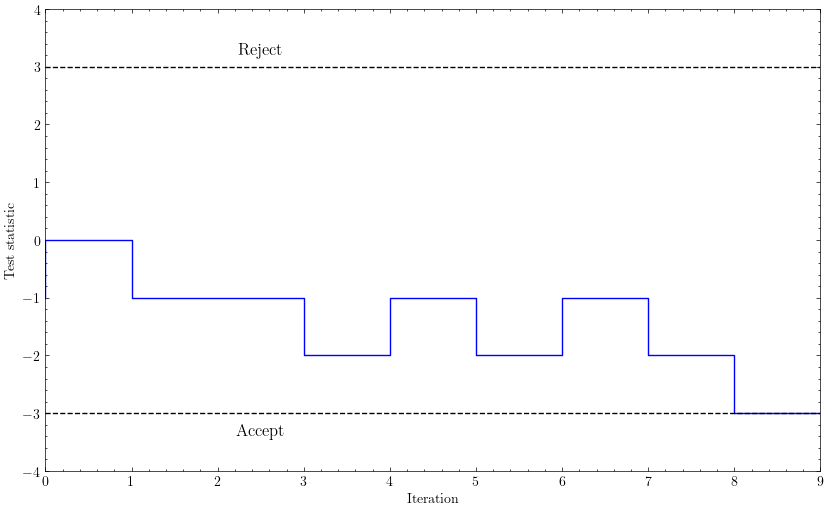

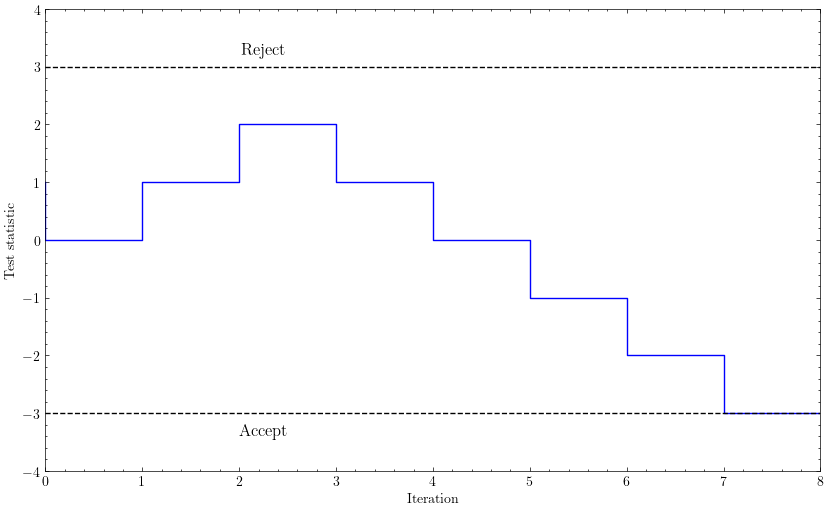

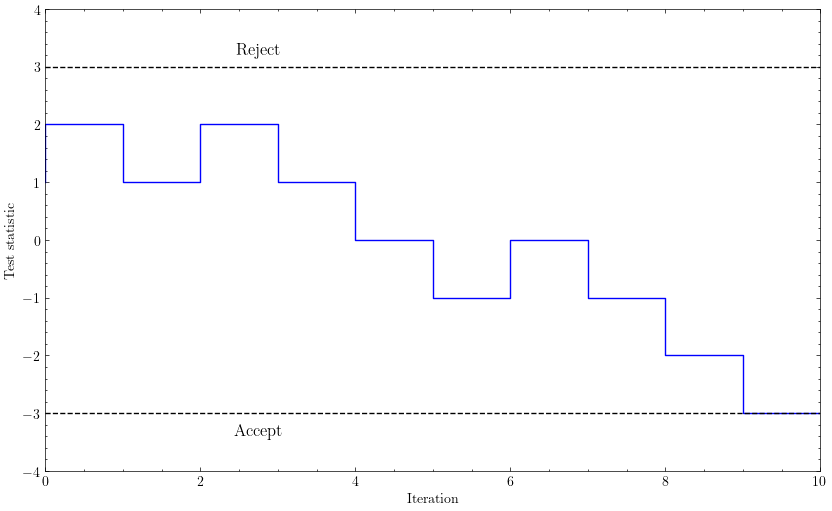

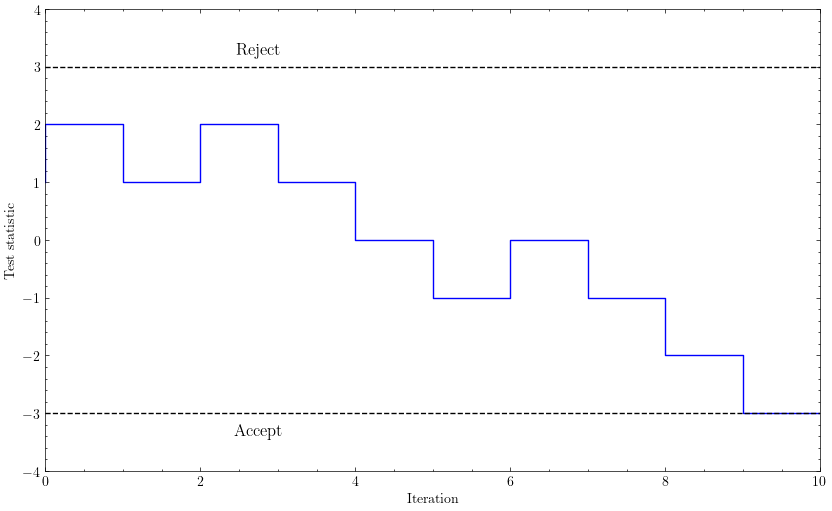

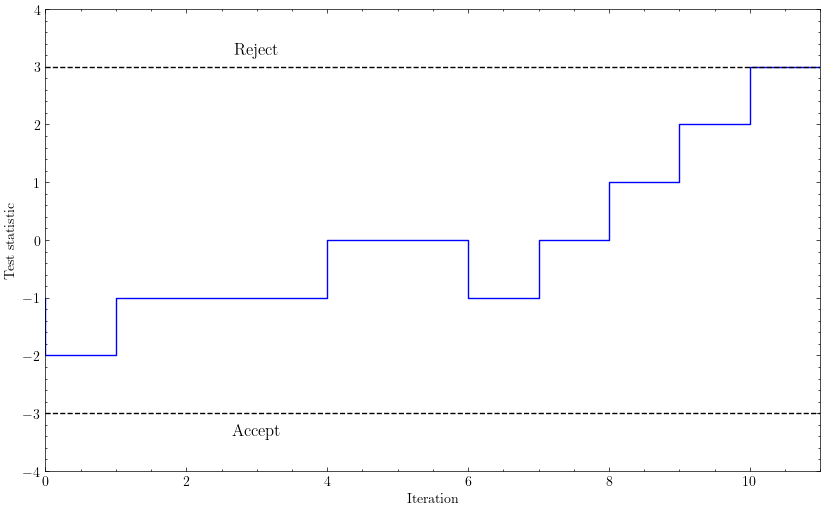

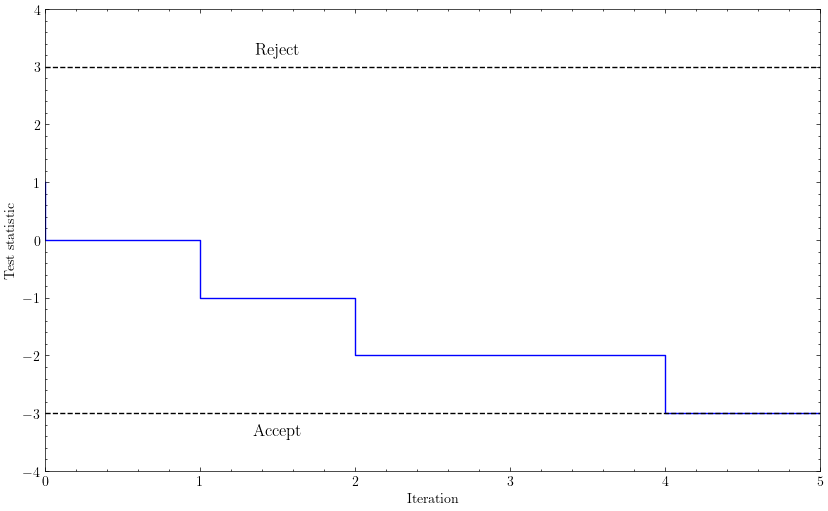

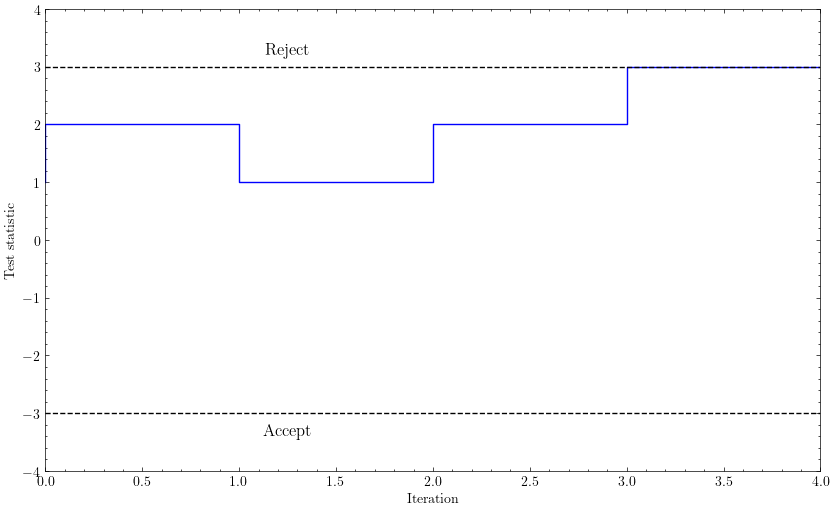

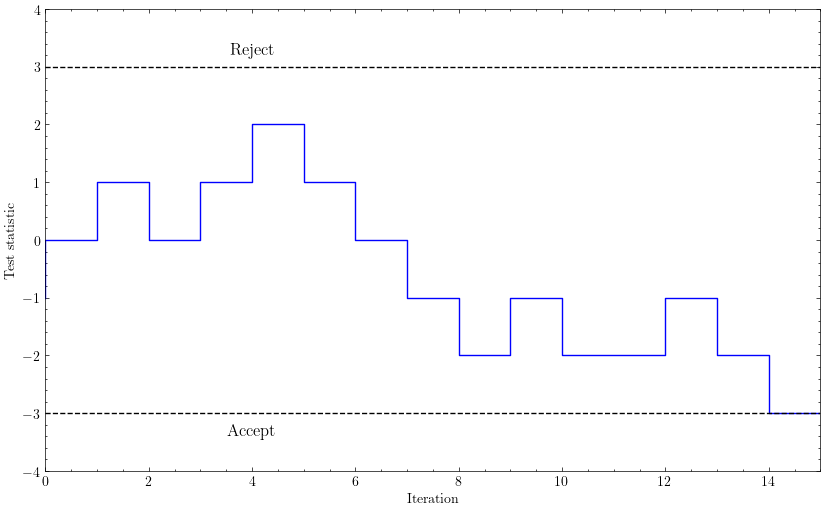

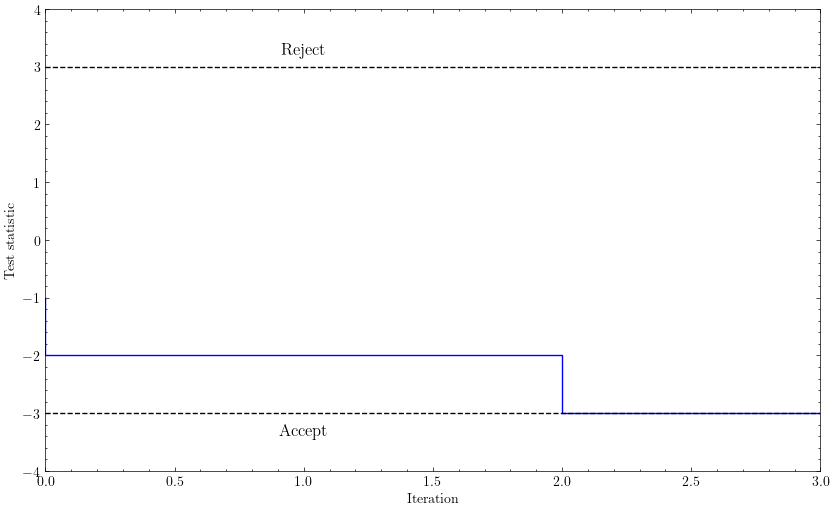

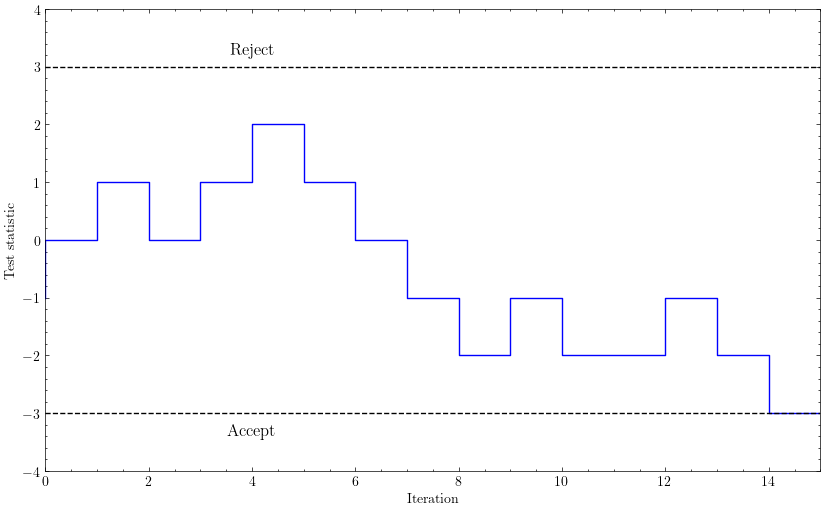

In [31]:
T_total_long = []
configuration_pair_long = []

for i in range(len(T_total_1AR)):
    if len(T_total_1AR[i]) > 3:
        T_total_long.append(T_total_1AR[i])
        configuration_pair_long.append(configuration_pair_1AR[i])
        
        
draw_random_walk(T_total_long, configuration_pair_long, 3, 10)

## Transition Matrix

In [39]:
states = ["Reception", "Lab tests", "Examination room", "Reexamination process", "Treatment room", "Emergency room", "Discharge"]

transition_matrix = np.zeros((len(states), len(states)))

for i, state in enumerate(states):
    probabilities = project_probabilities.get(state, project_probabilities["default"])
    for j, next_state in enumerate(states):
        transition_matrix[i, j] = probabilities.get(next_state, 0.0)

transition_matrix = sp.Matrix(transition_matrix)
transition_matrix

Matrix([
[0,   0, 1.0,   0,   0,    0,    0],
[0,   0,   0, 1.0,   0,    0,    0],
[0, 0.5,   0,   0, 0.2, 0.25, 0.05],
[0,   0,   0,   0, 0.4,  0.5,  0.1],
[0,   0,   0,   0,   0,    0,  1.0],
[0,   0,   0,   0,   0,    0,  1.0],
[0,   0,   0,   0,   0,    0,    0]])